# Testing for significant difference between right and left ears

In [43]:
from __future__ import print_function, division

import sys

import numpy as np

import matplotlib.pyplot as plt

from math import pi

from scipy.io import loadmat
from scipy.io import savemat
from scipy.signal import butter, filtfilt
from scipy.stats import ttest_rel

from joblib import Parallel, delayed

In [3]:
# load data
def load_data(filename):
    # load dataset
    exames_dict = loadmat(filename)
    
    target = exames_dict['target']
    exames = exames_dict['exames']

    # samples as the first dimension
    exames = np.transpose(exames,(2,0,1))

    target = target[0]
    return exames, target

def filt_data(data, order, fs, f1, f2, band):
    nyq = 0.5*fs  # nyquist frequency

    a1,b1 = butter(order,[(f1-(band/2))/nyq,(f1+(band/2))/nyq],btype='bandpass')
    a2,b2 = butter(order,[(f2-(band/2))/nyq,(f2+(band/2))/nyq],btype='bandpass')

    dataf1 = filtfilt(a1,b1,data,axis=1)
    dataf2 = filtfilt(a2,b2,data,axis=1)

    return dataf1, dataf2

def get_energy(data):
    data = np.square(data)
    return np.sum(data,axis=1)

In [25]:
# STARTING ANALYSIS

exams_path = "/home/pedrosergiot/Documents/Exames2_sem1segundo.mat"
exames, target = load_data(exams_path)

exames_1 = exames[target==0,:,:]   # exames orelha 1
exames_2 = exames[target==1,:,:]   # exames orelha 2

# data parameters
fs = 601.5  # sampling rate
f1 = 31.13  # modulating frequency 1
f2 = 39.36  # modulating frequency 2

filter_band = 0.4
#filter_band = 2.0
filter_order = 4

# FIRST APPROACH: COMPARING DISTRIBUTIONS BY T-TEST

First we check the distribution of the differences of each channel for each pair of EEGs. The result shows an gaussian tendency for all eletrodes

/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


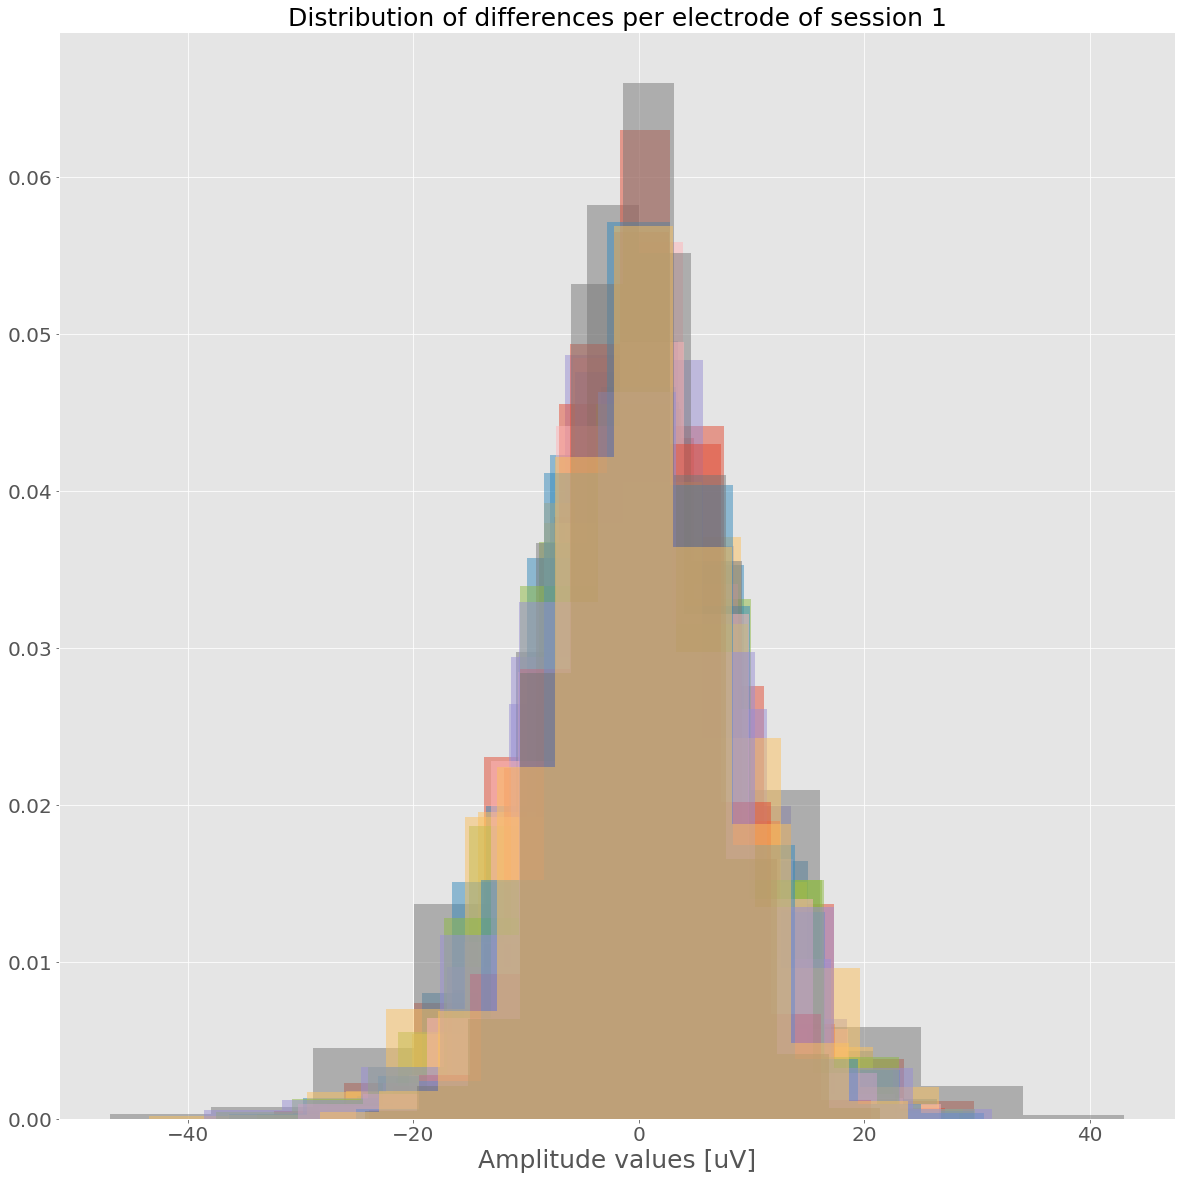

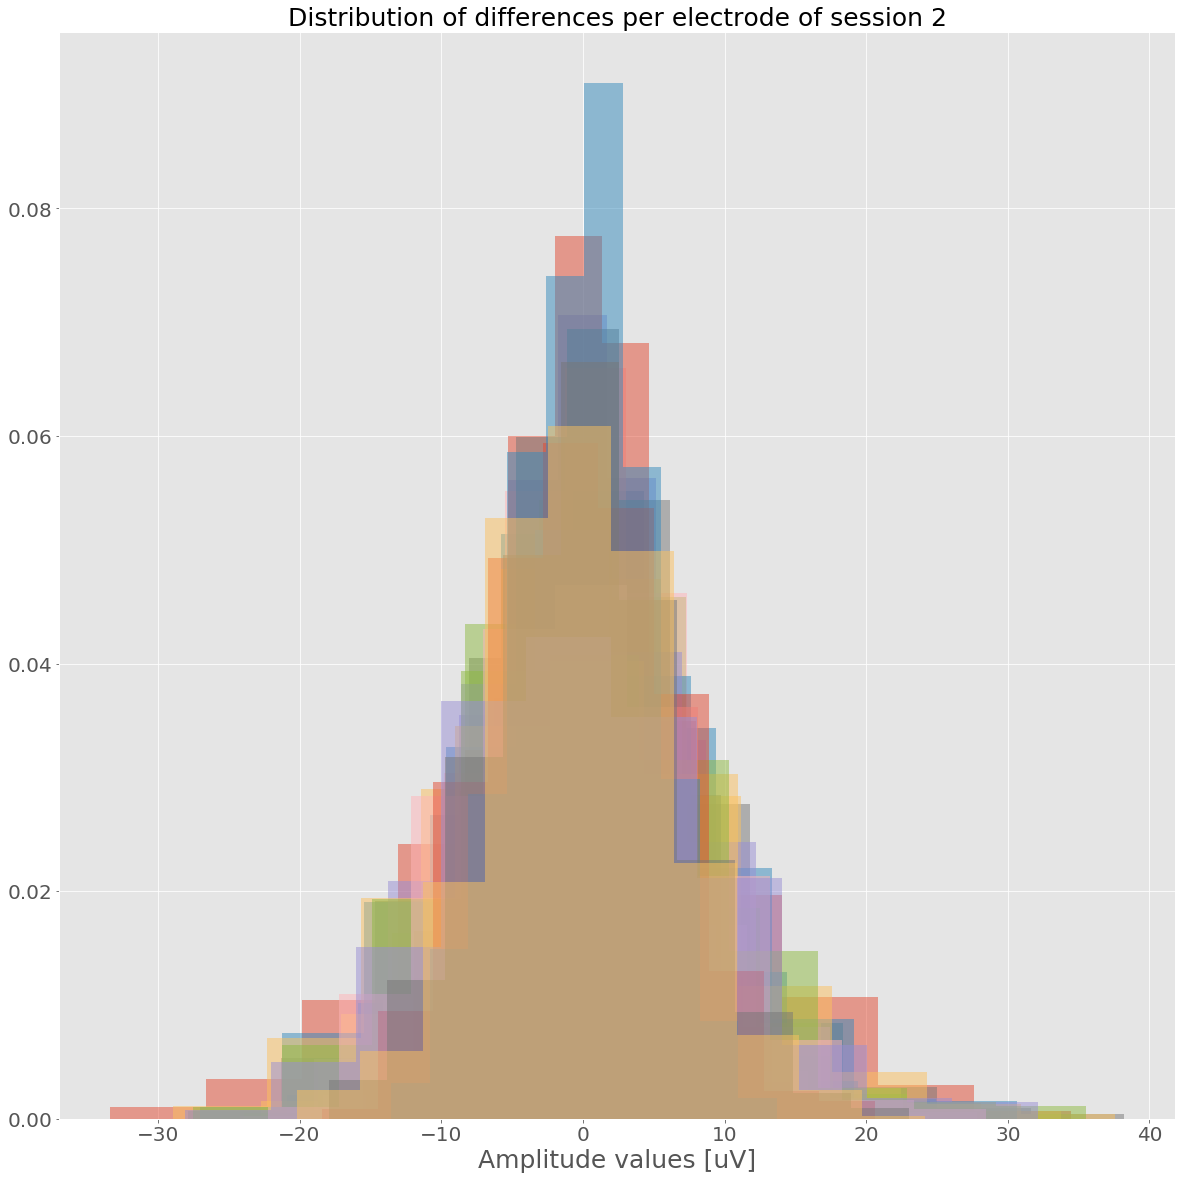

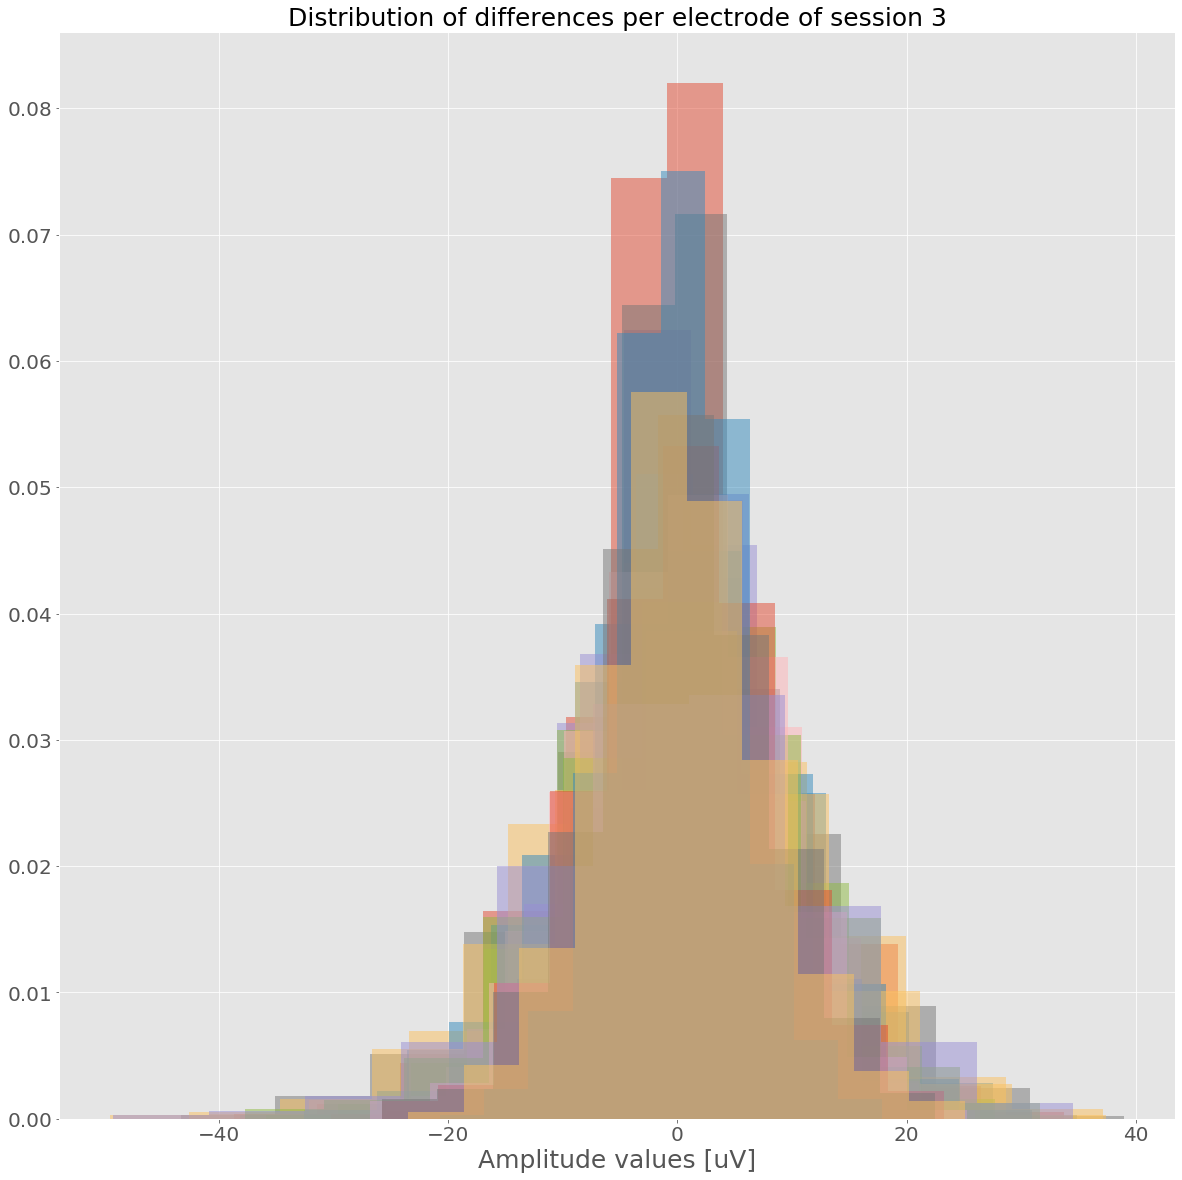

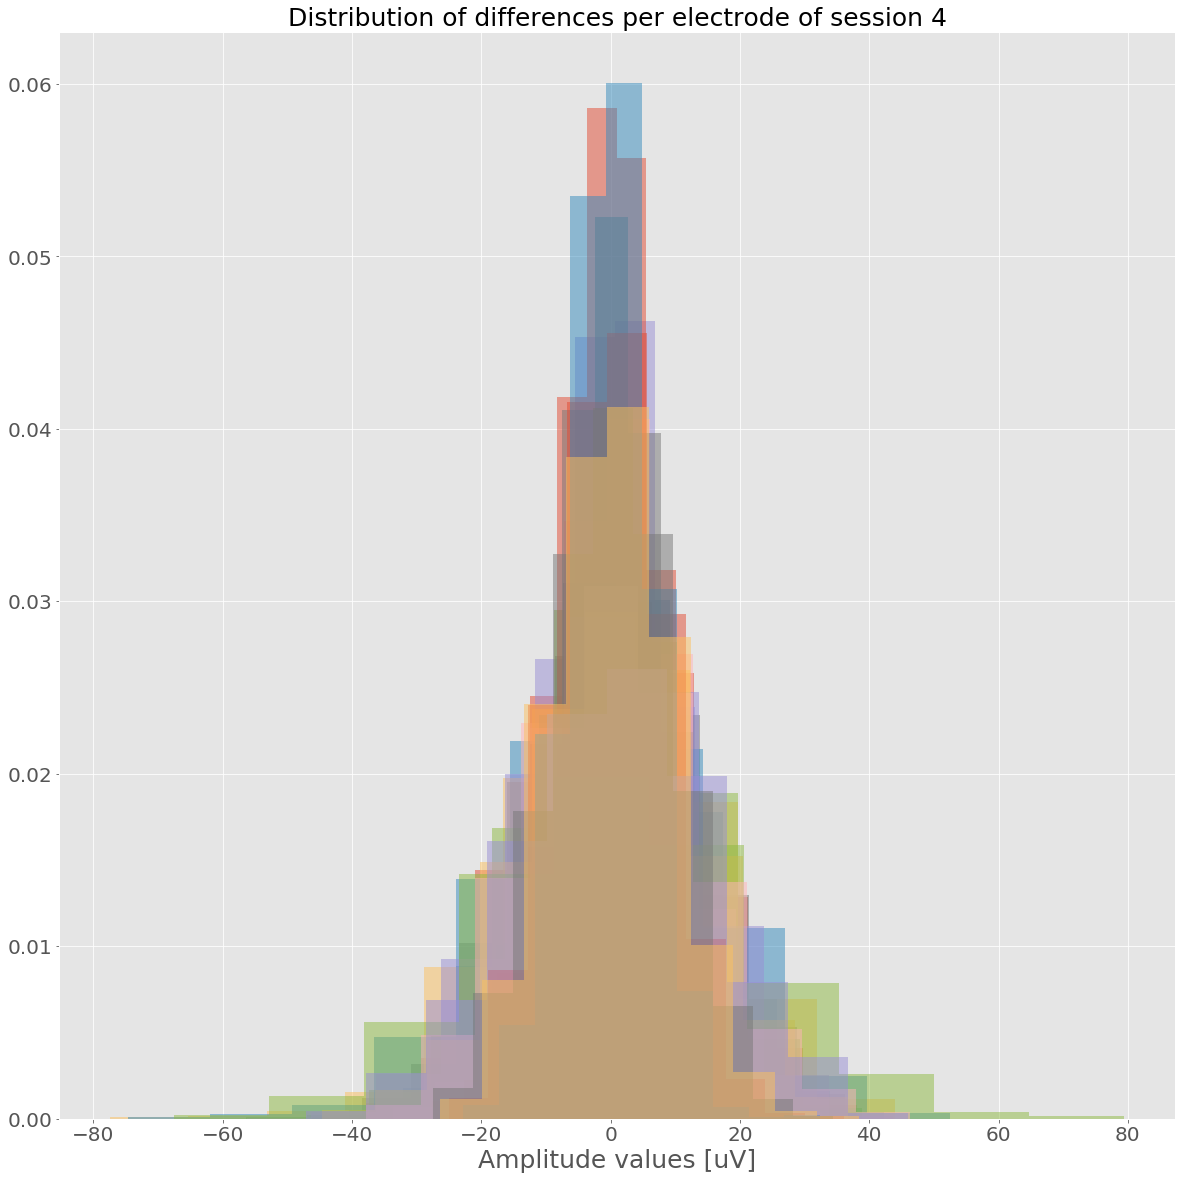

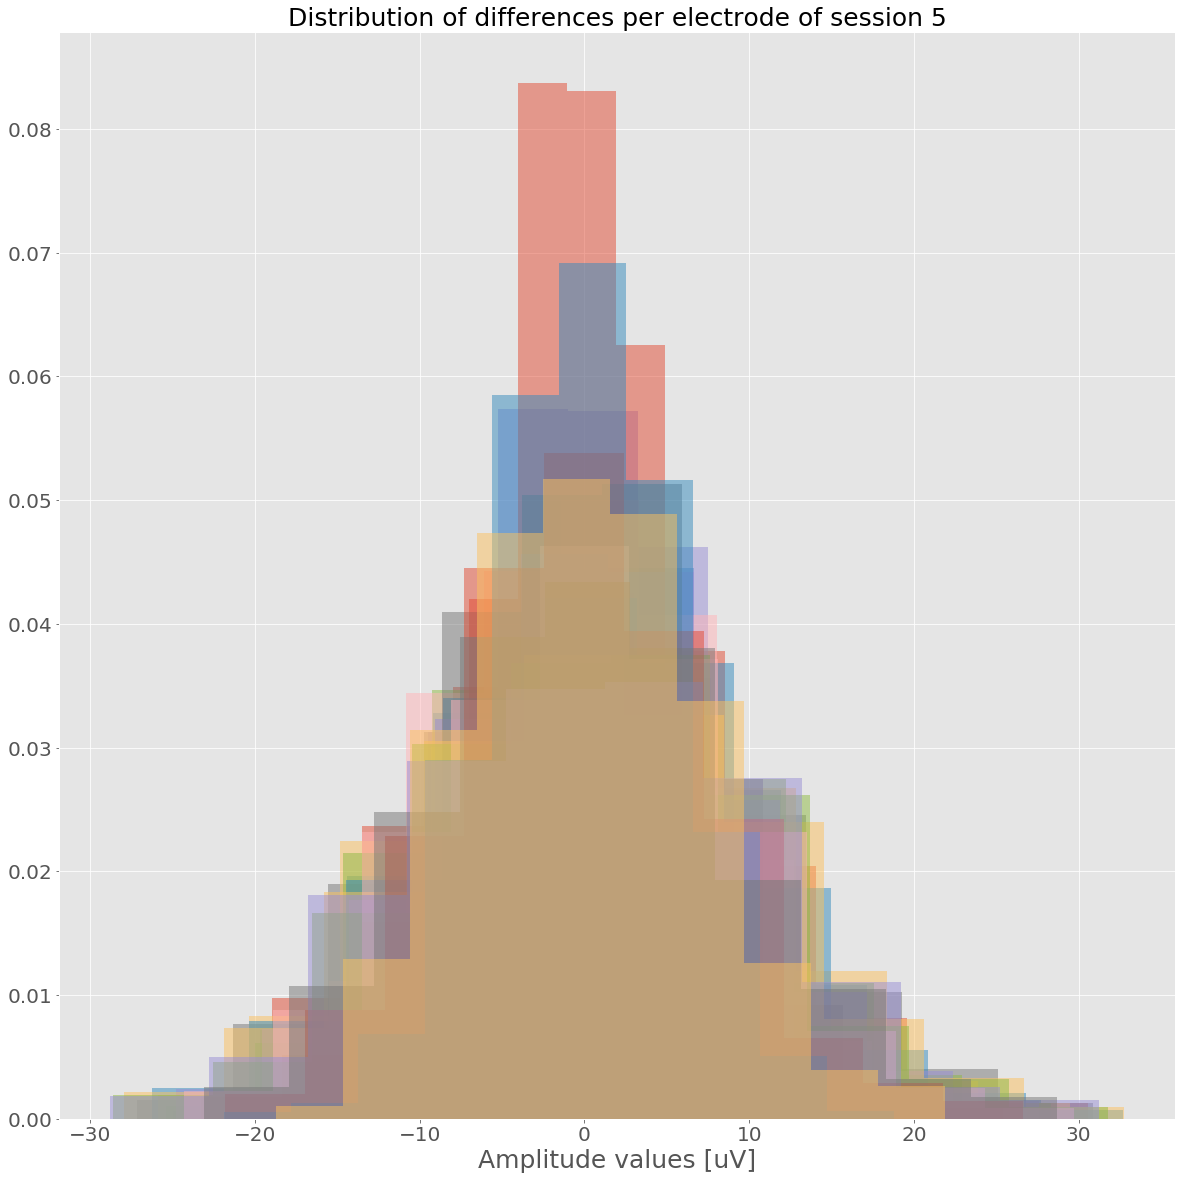

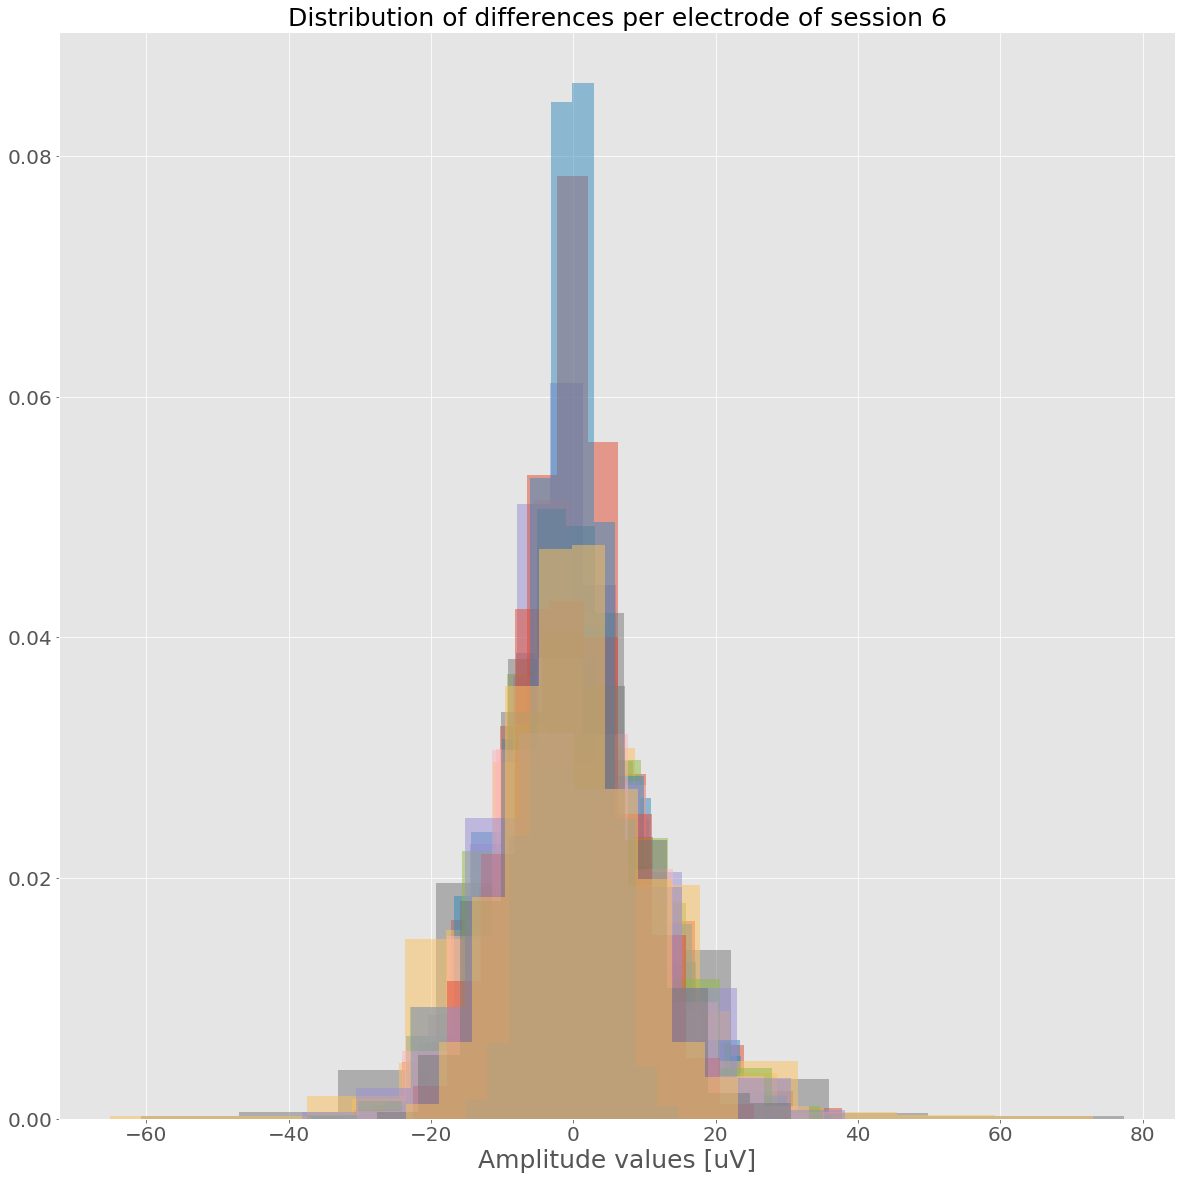

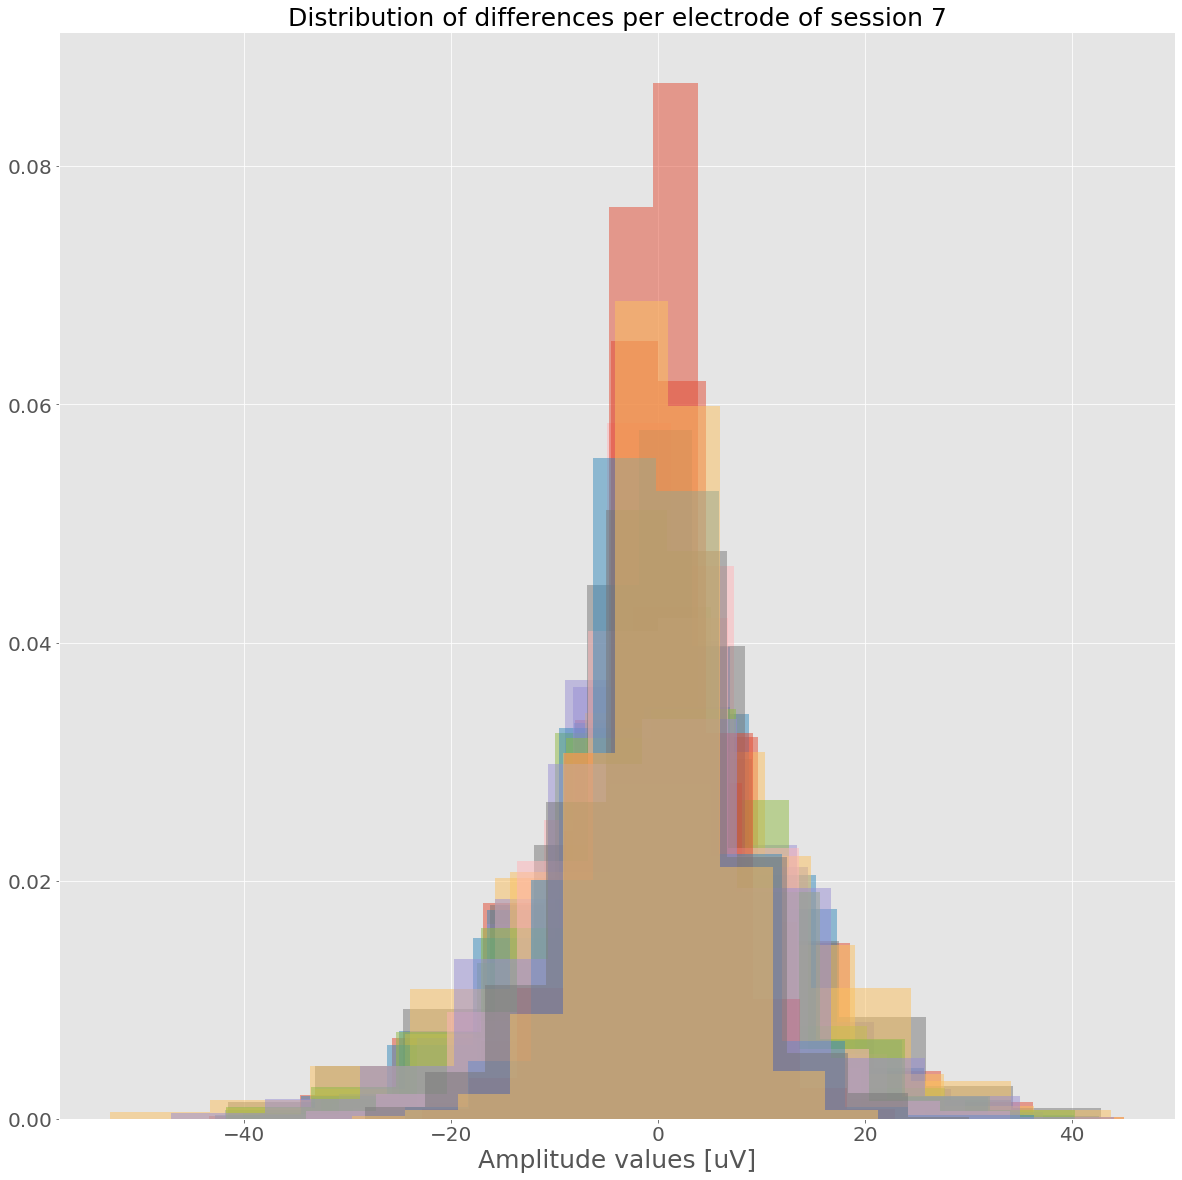

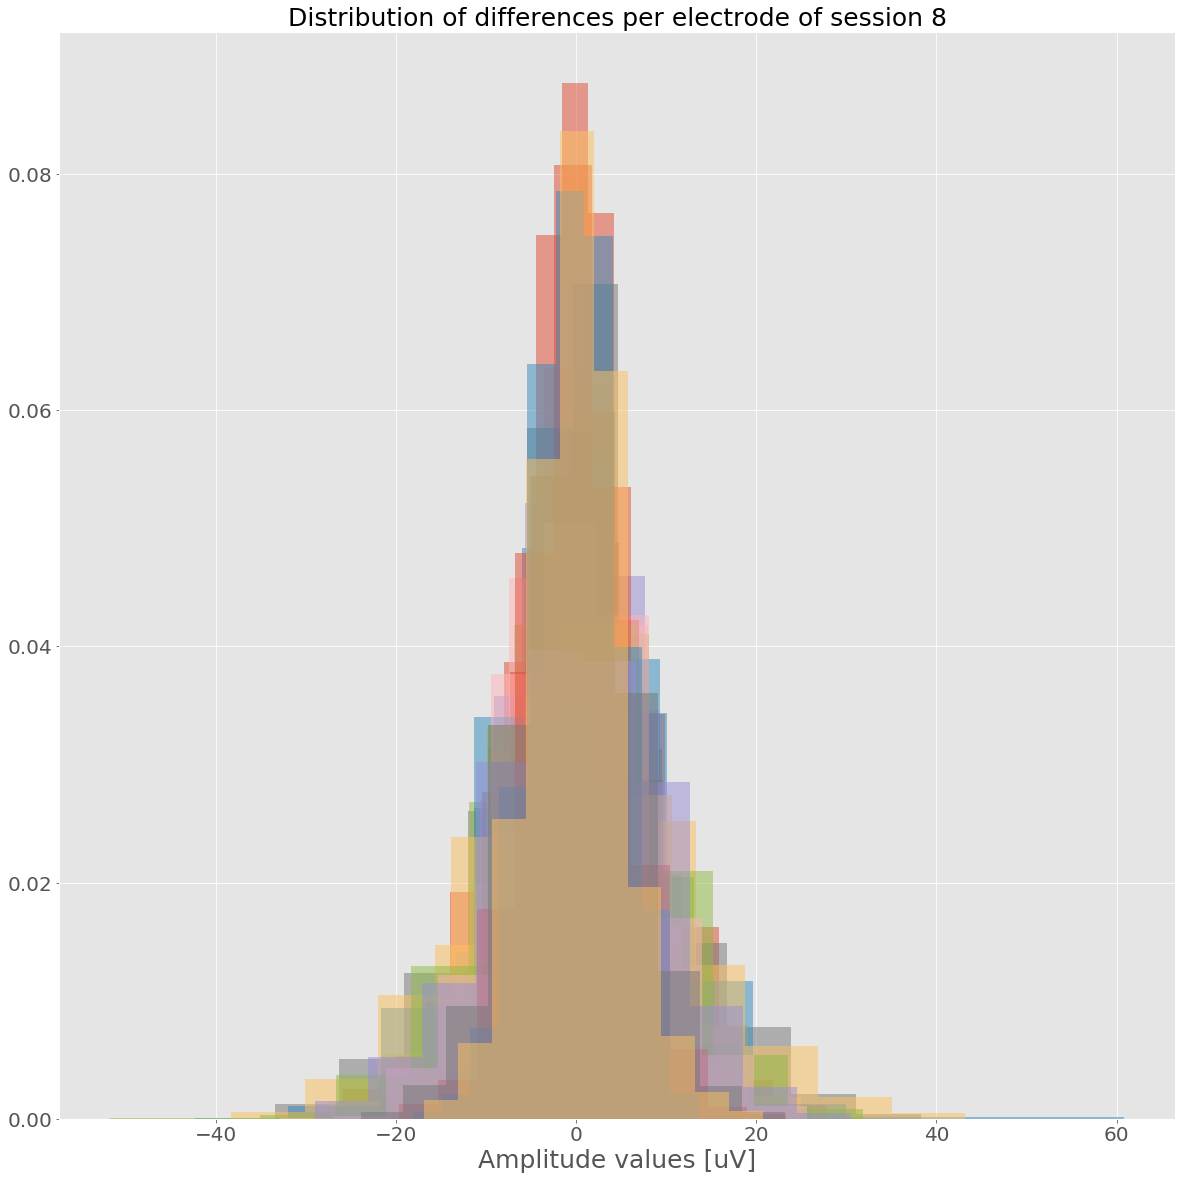

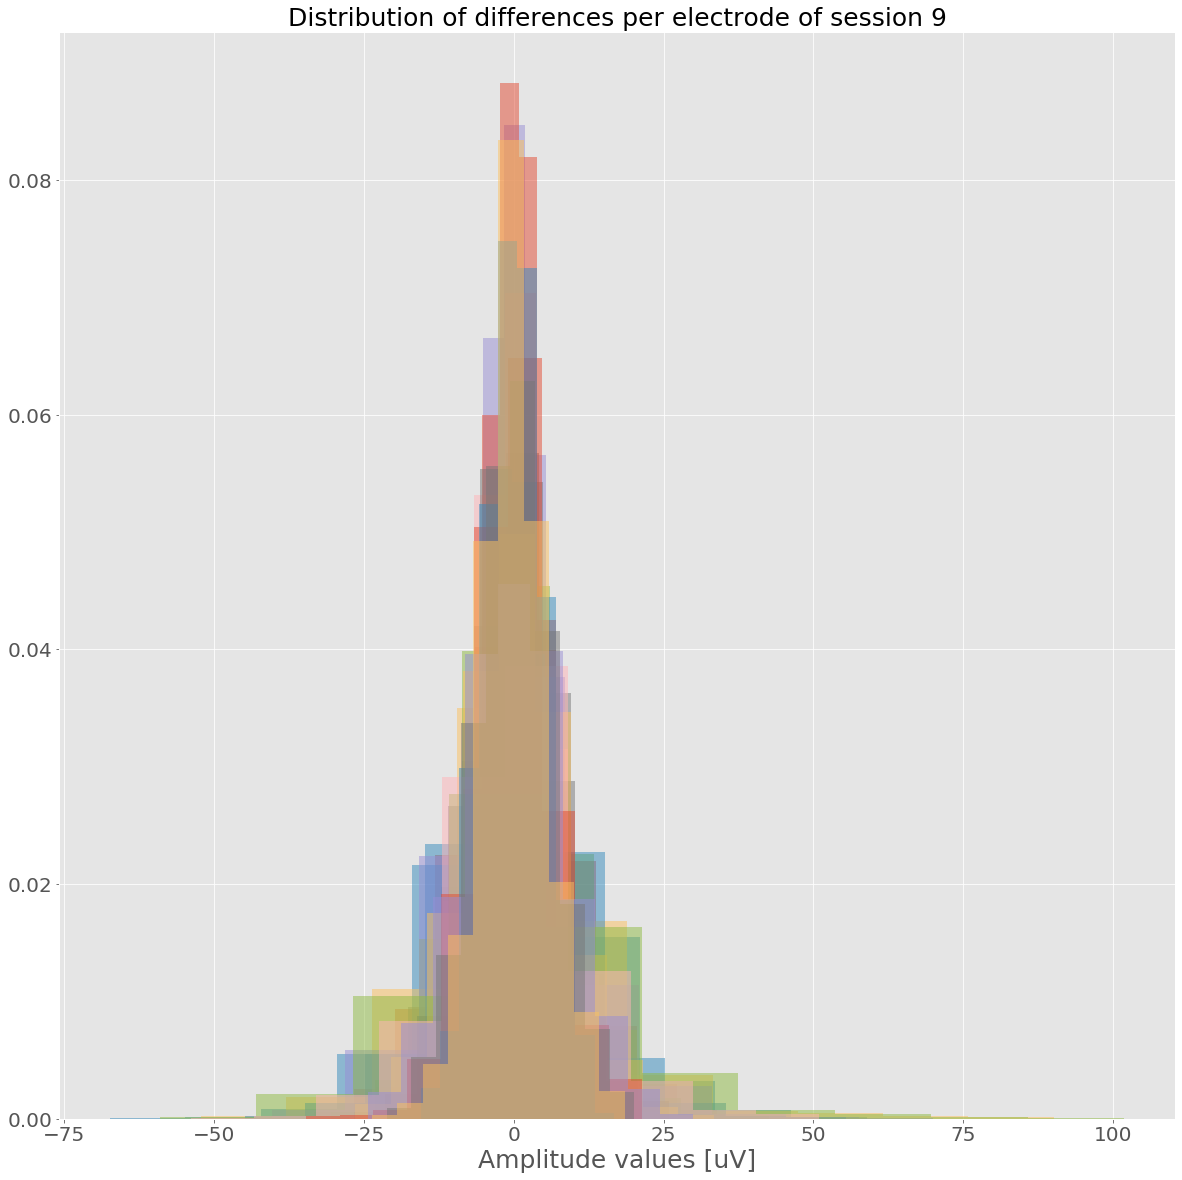

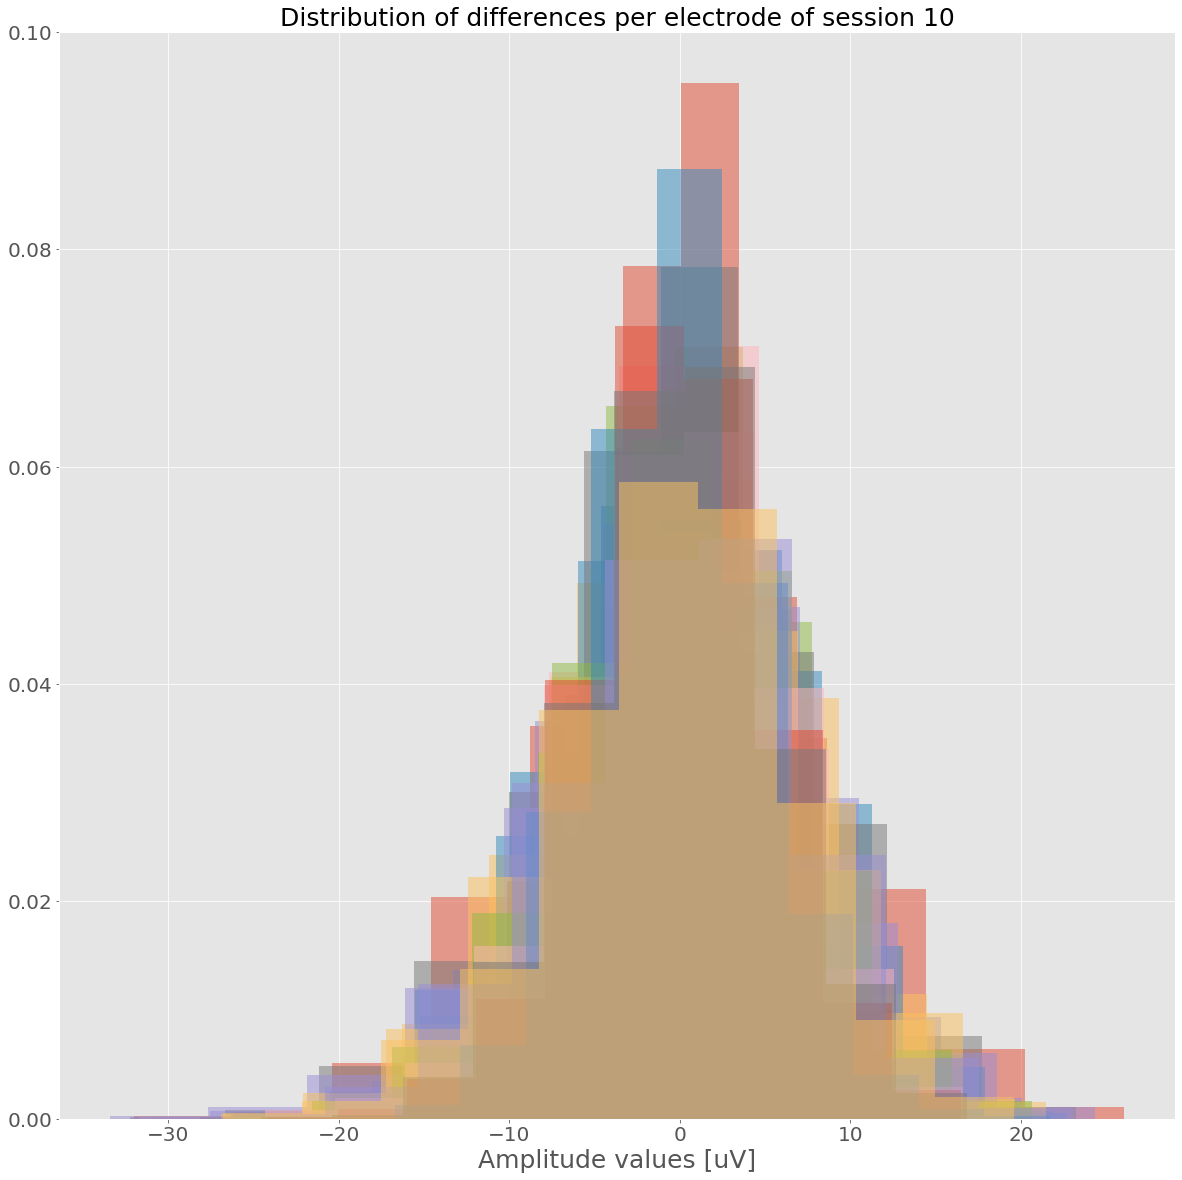

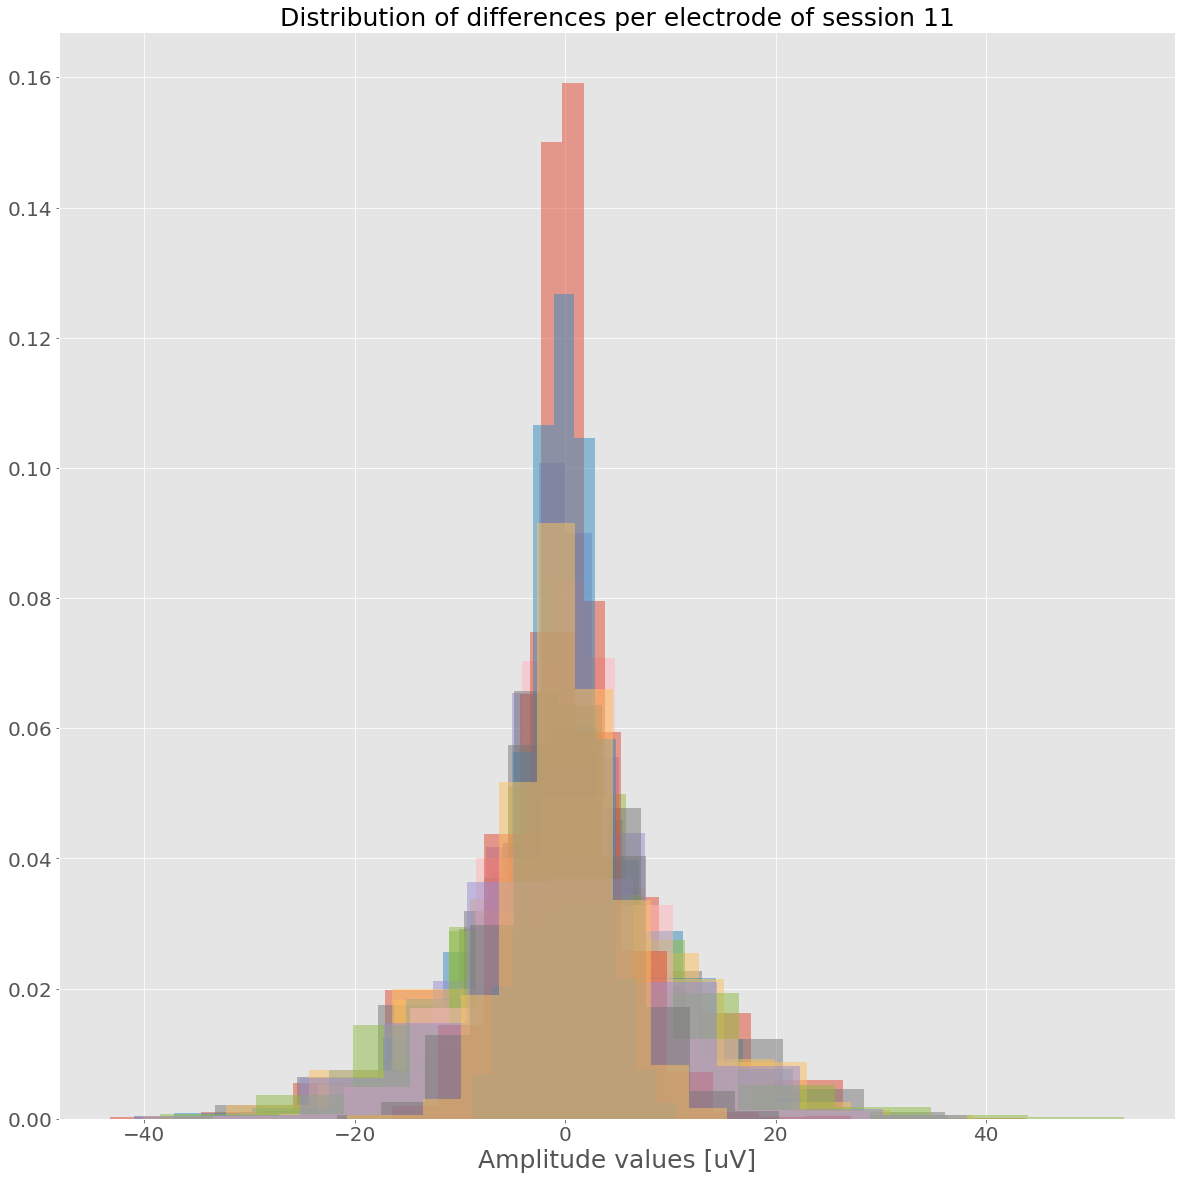

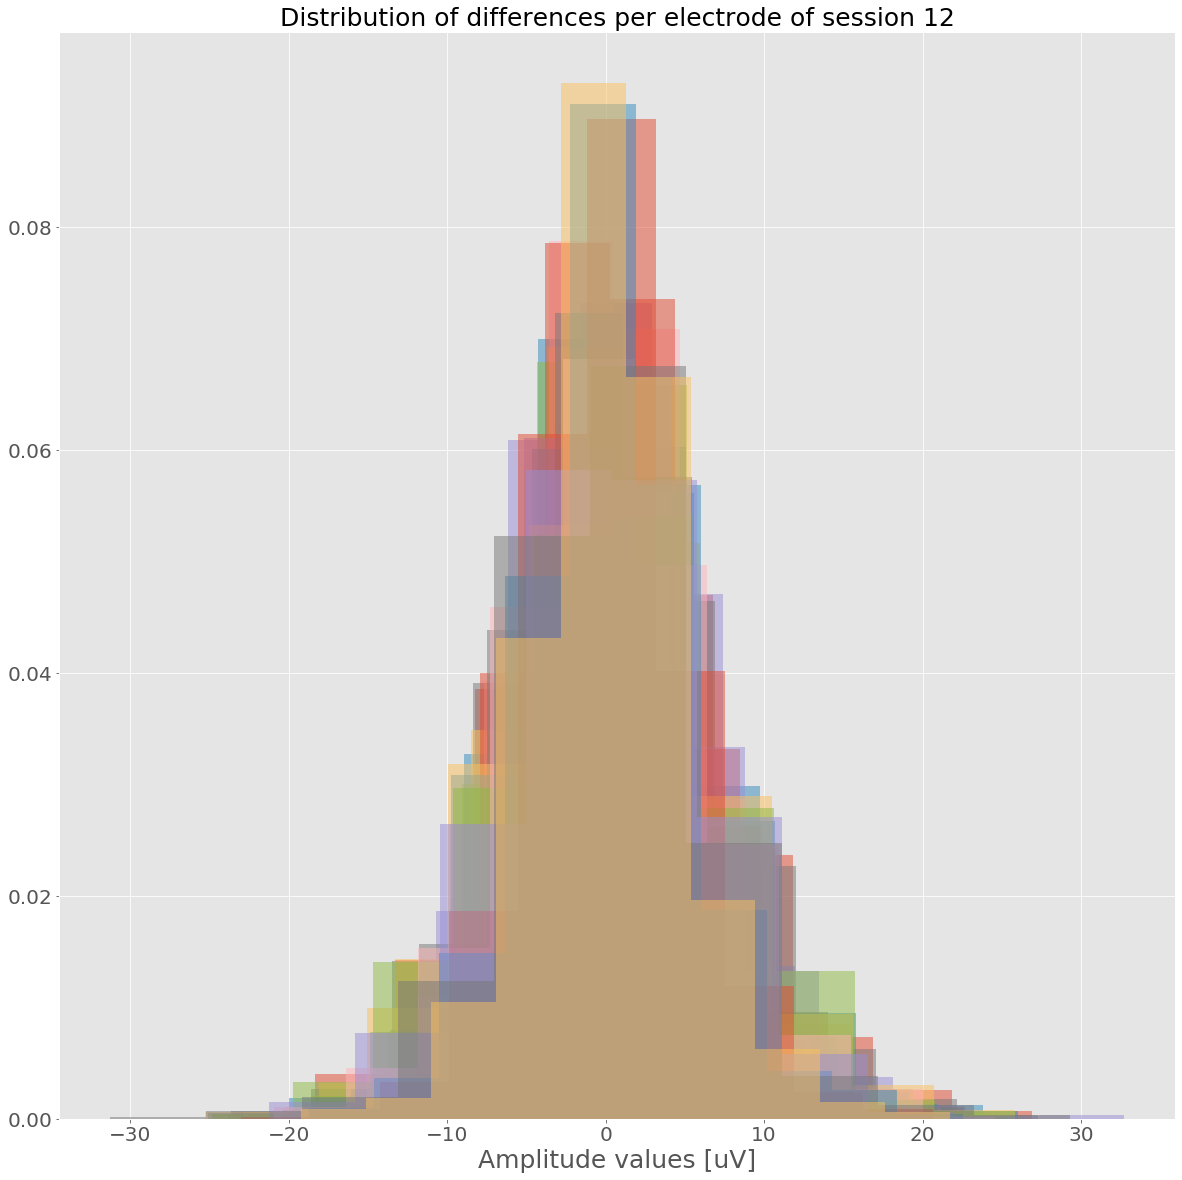

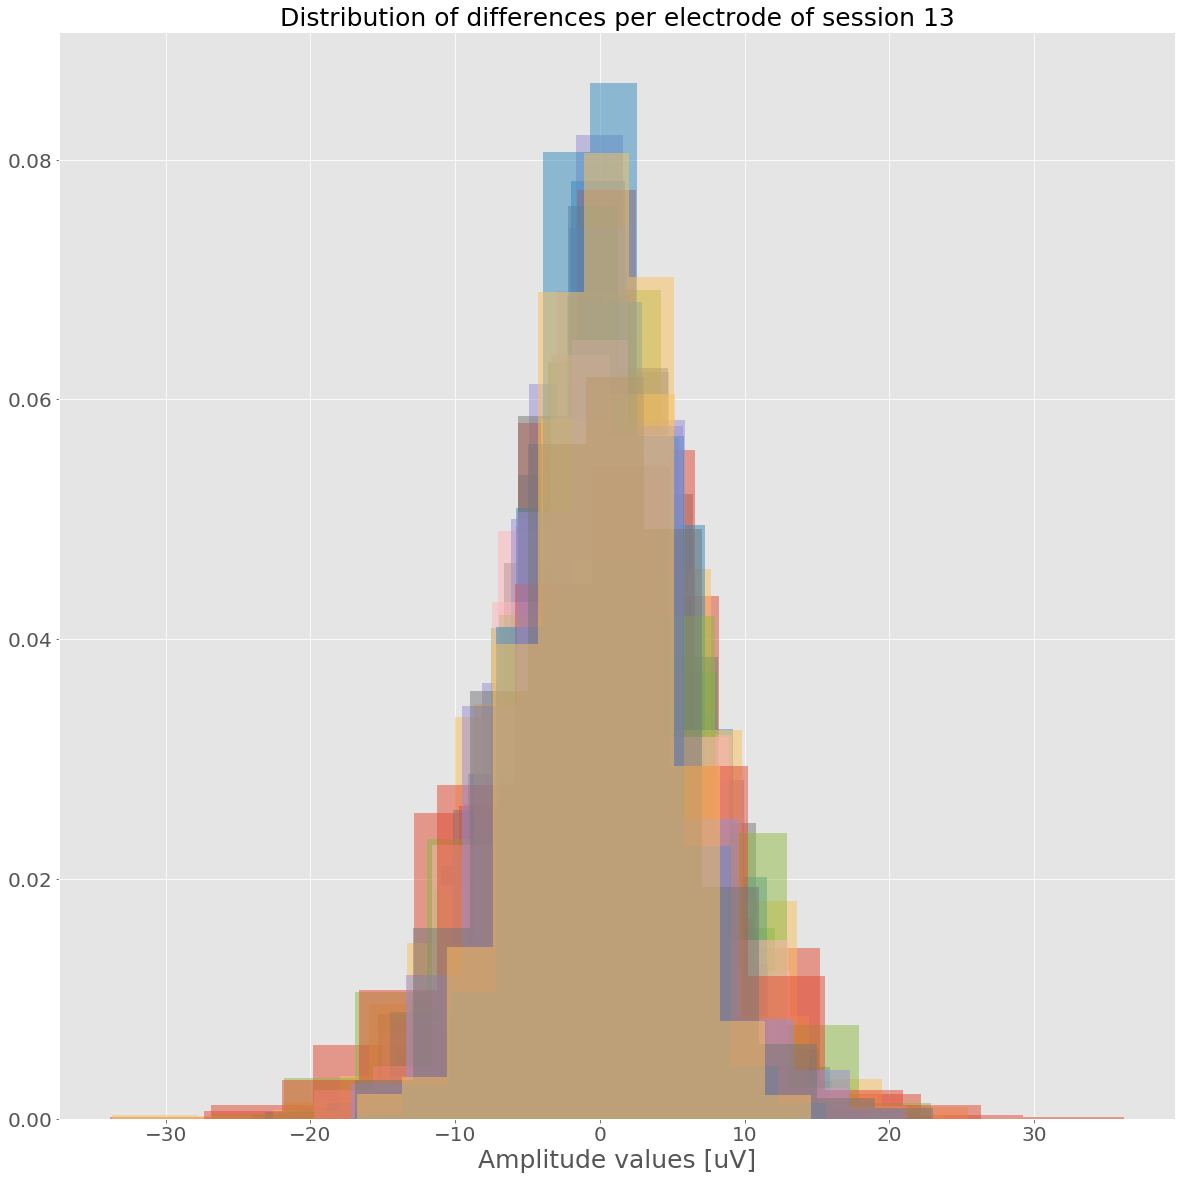

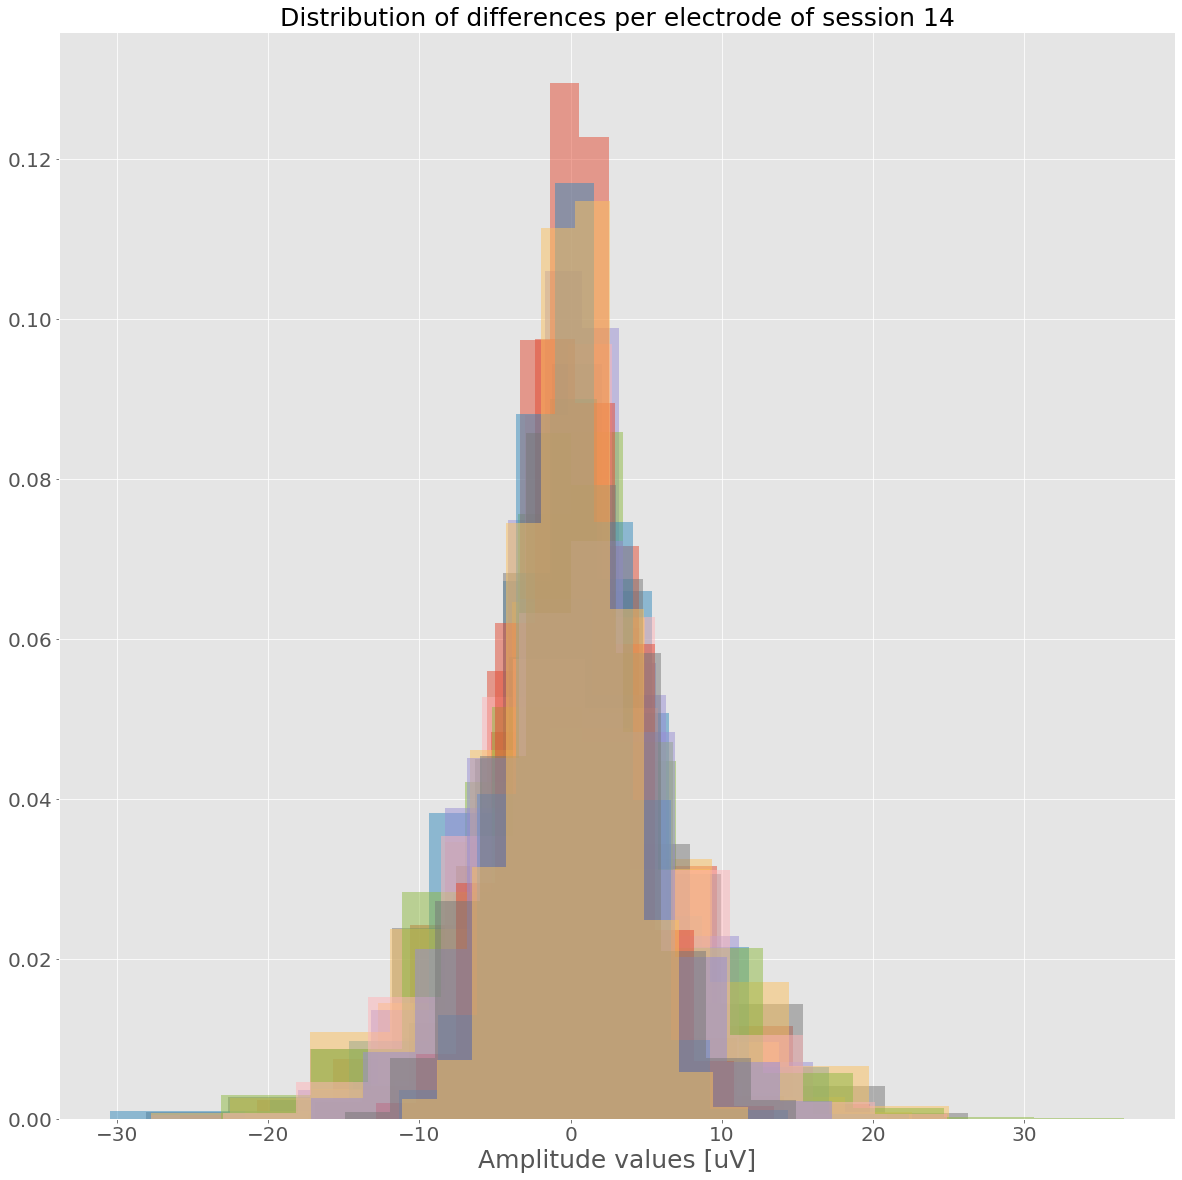

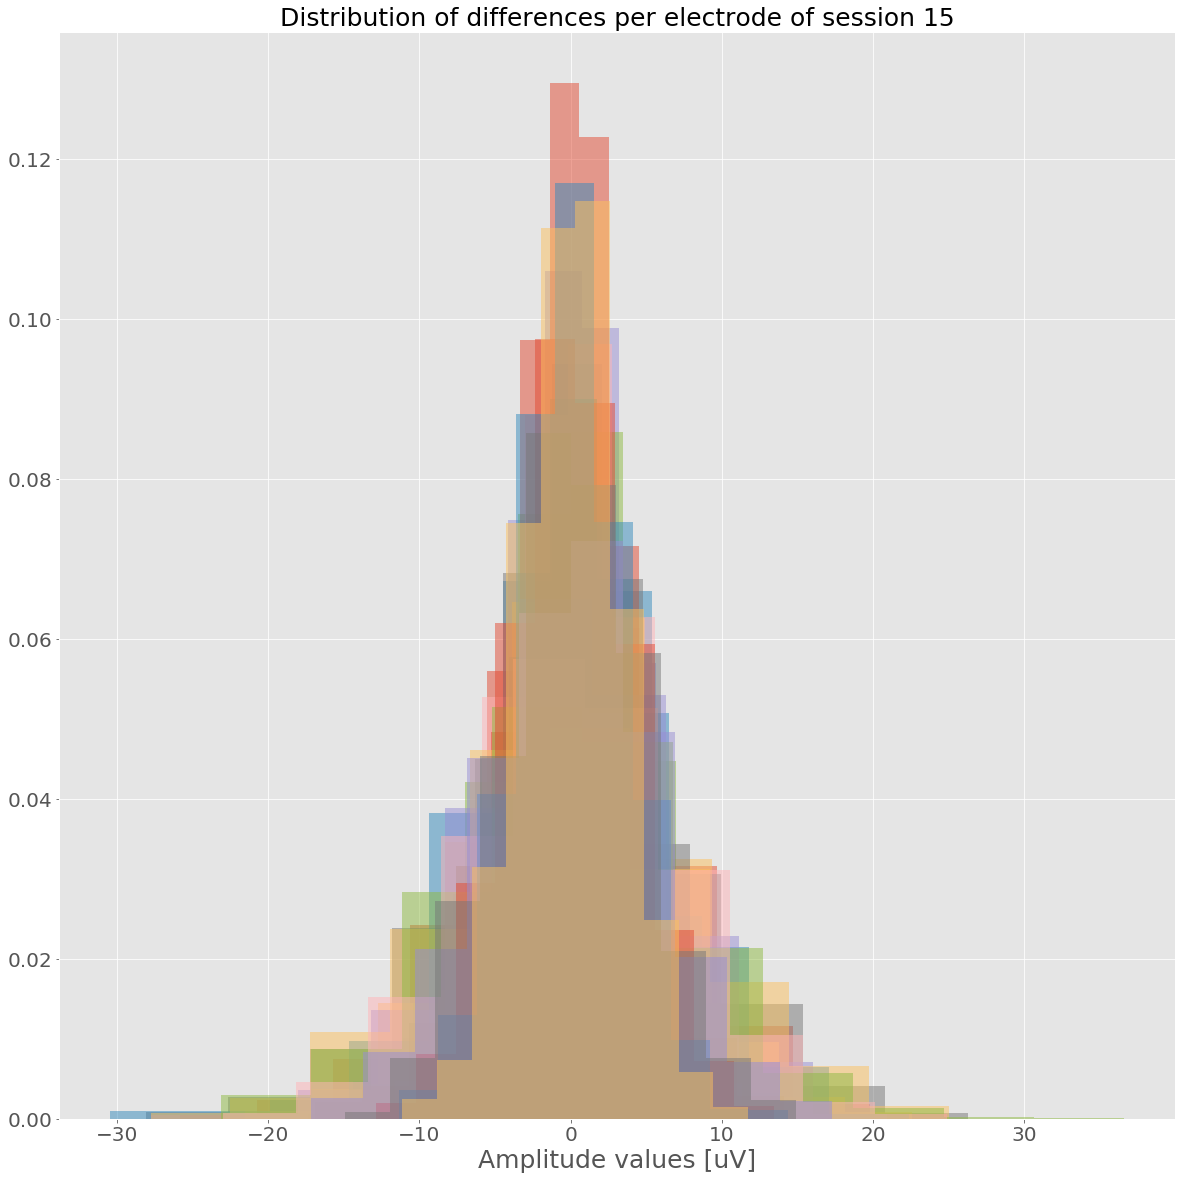

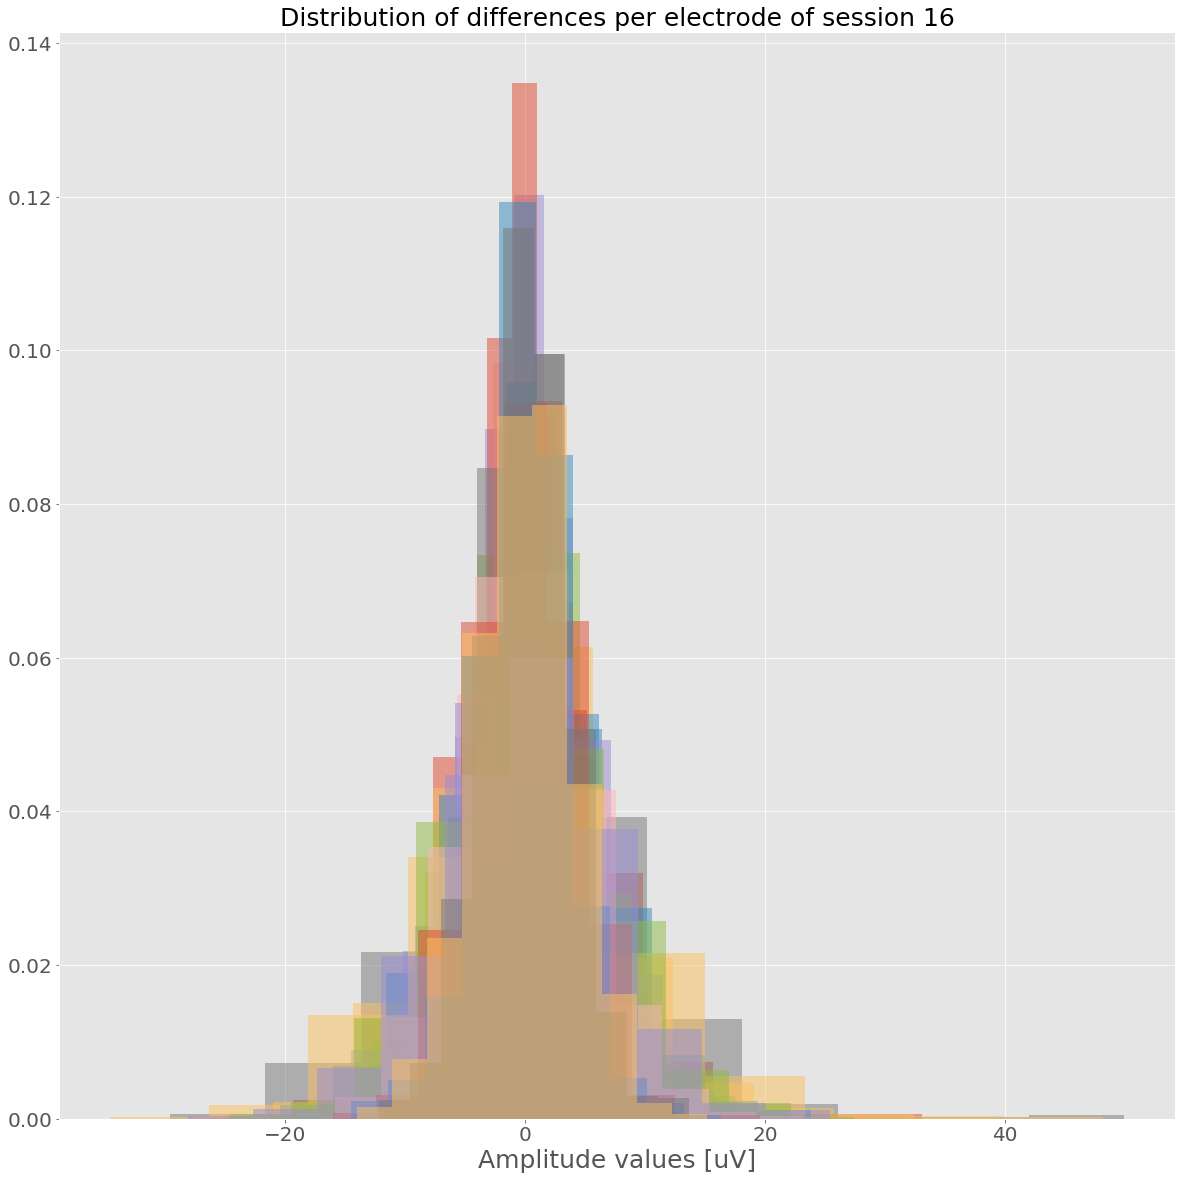

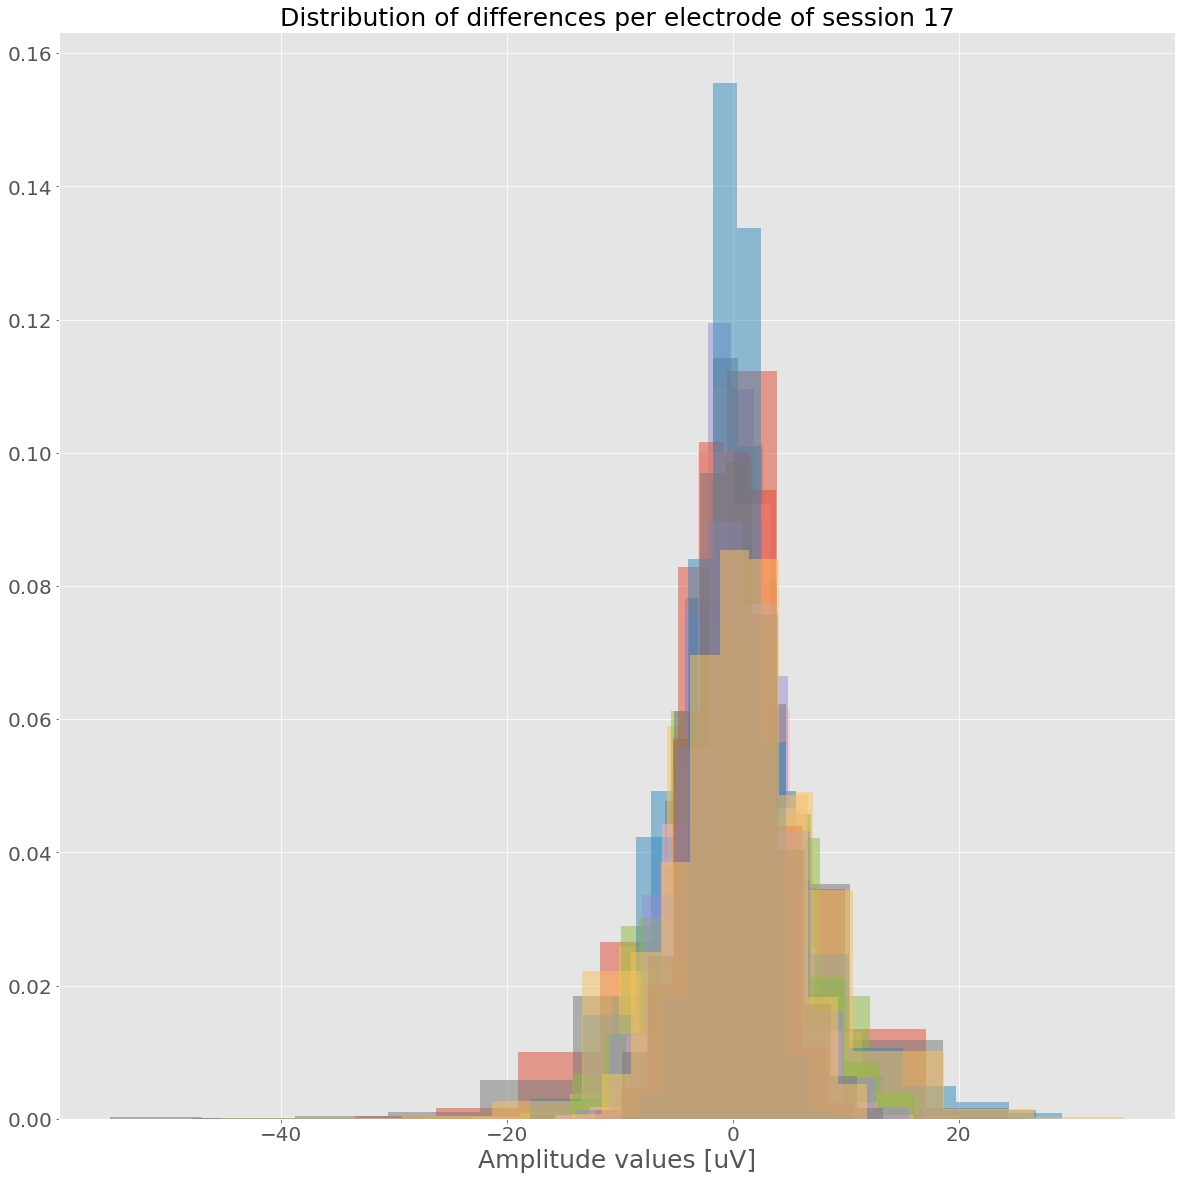

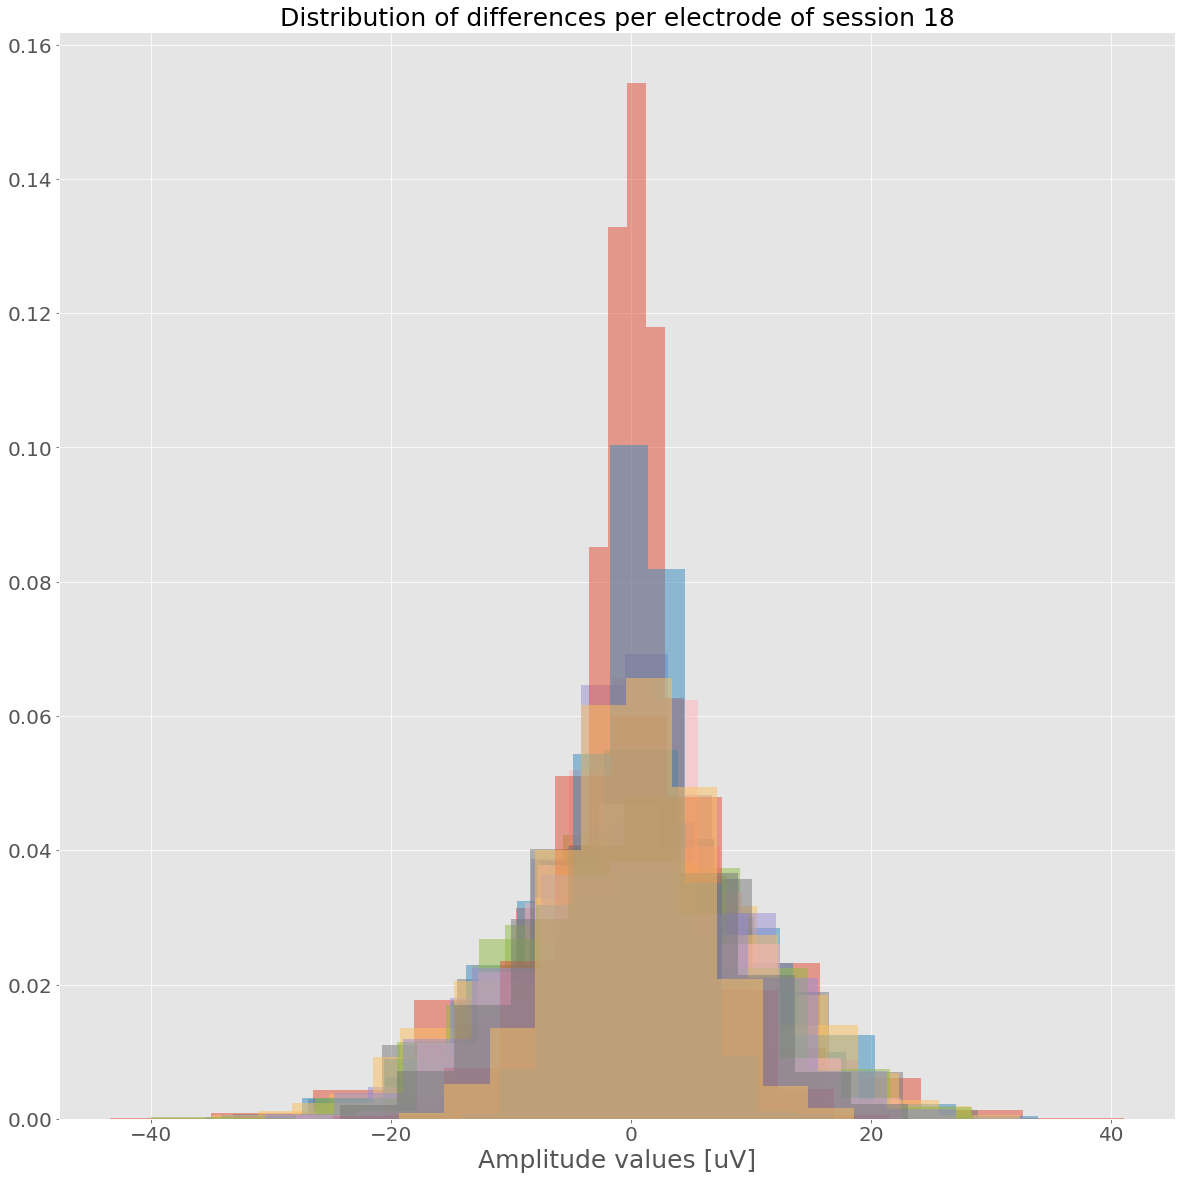

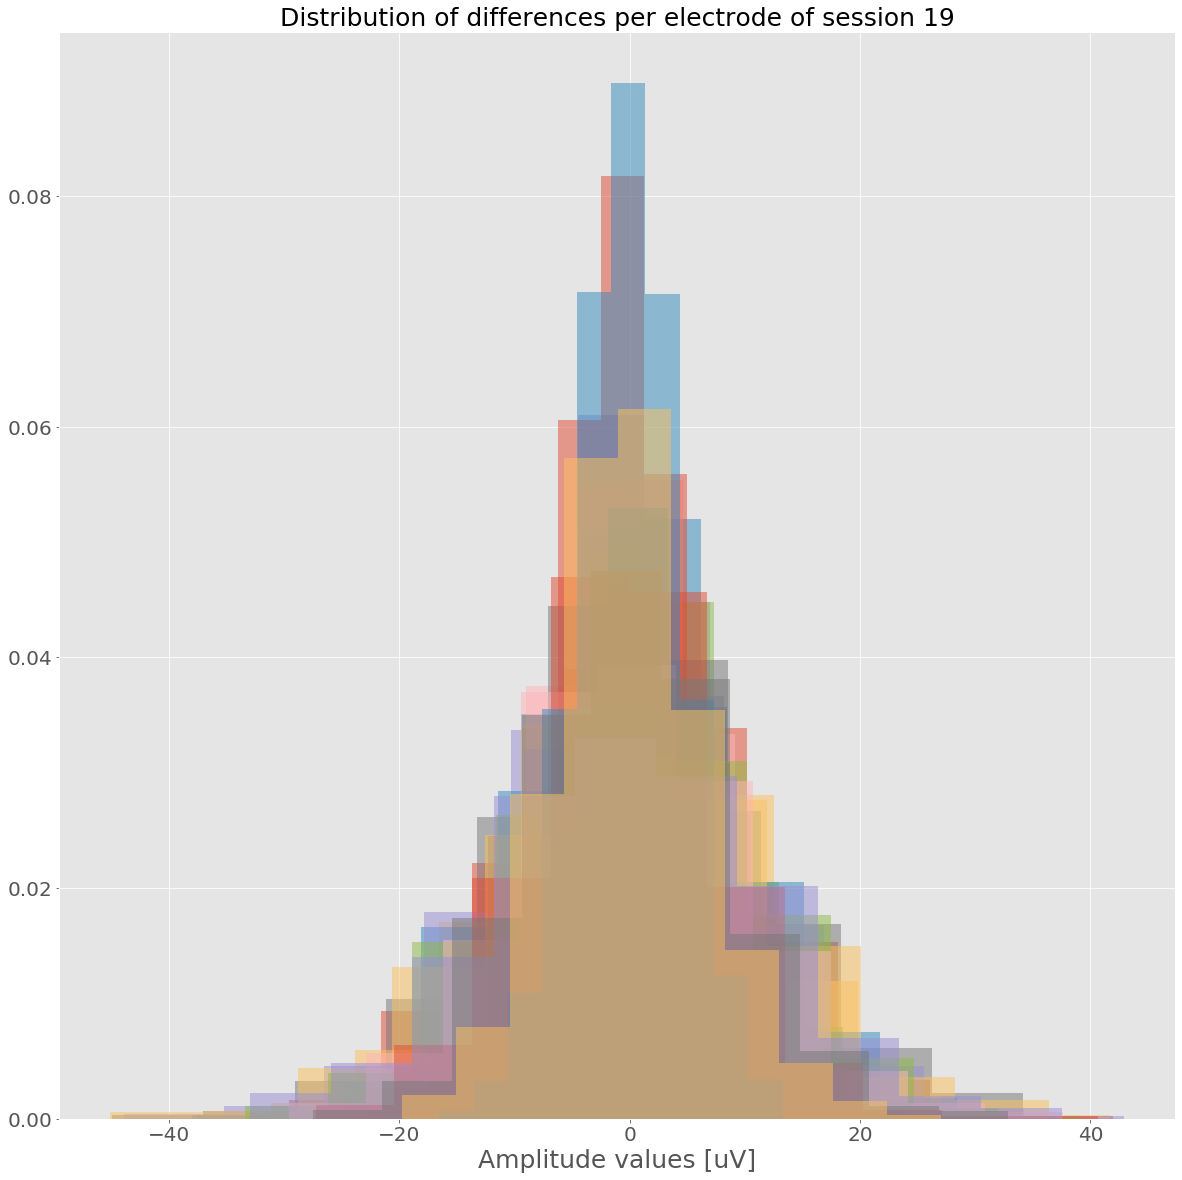

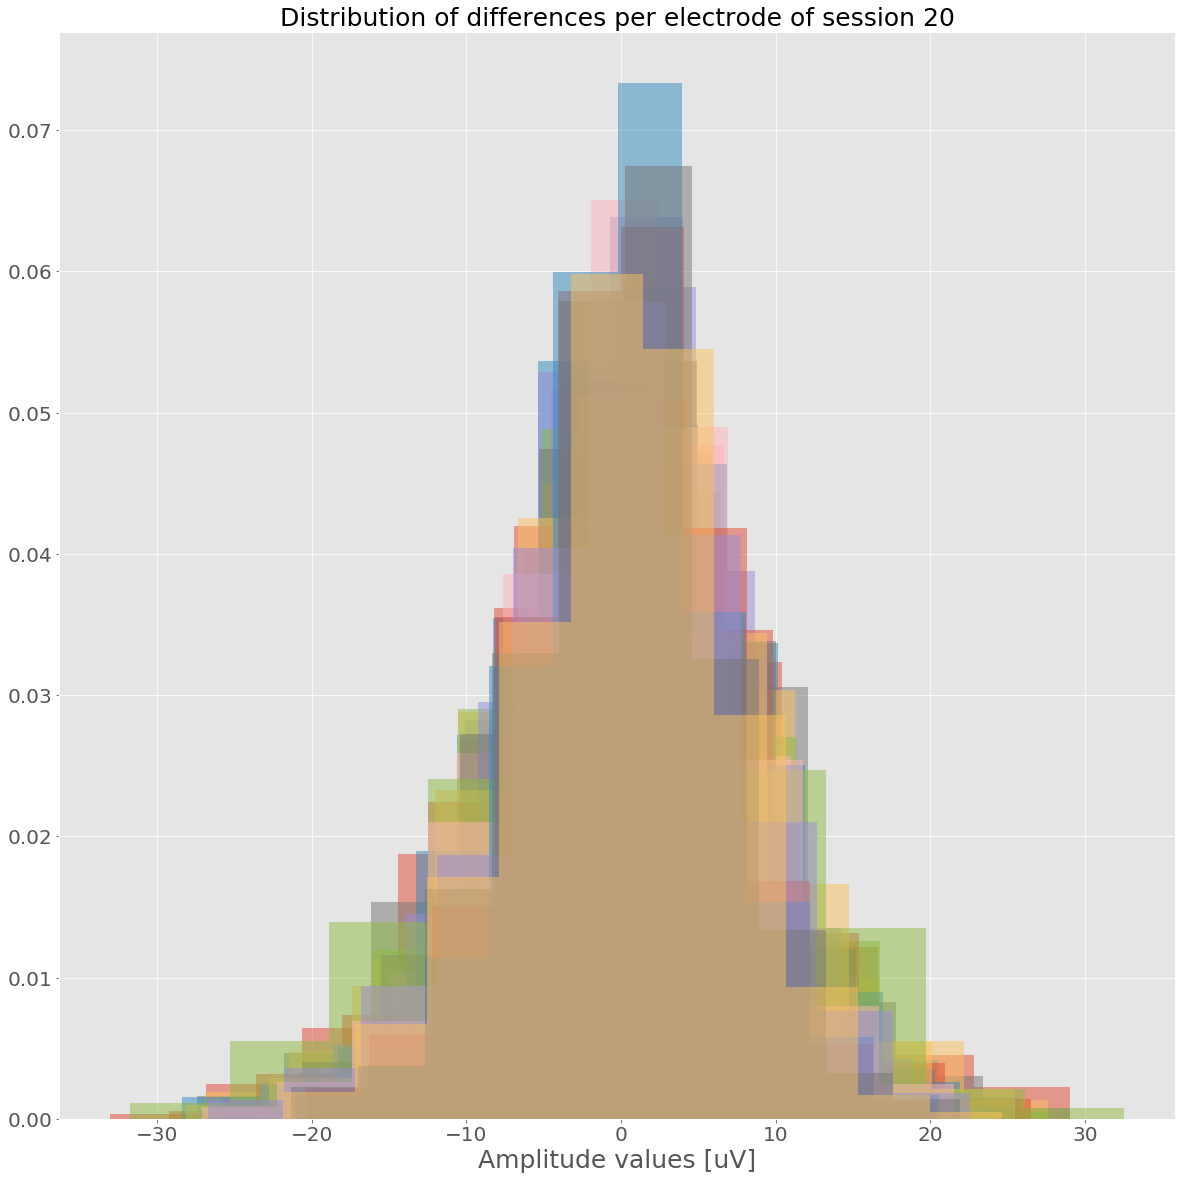

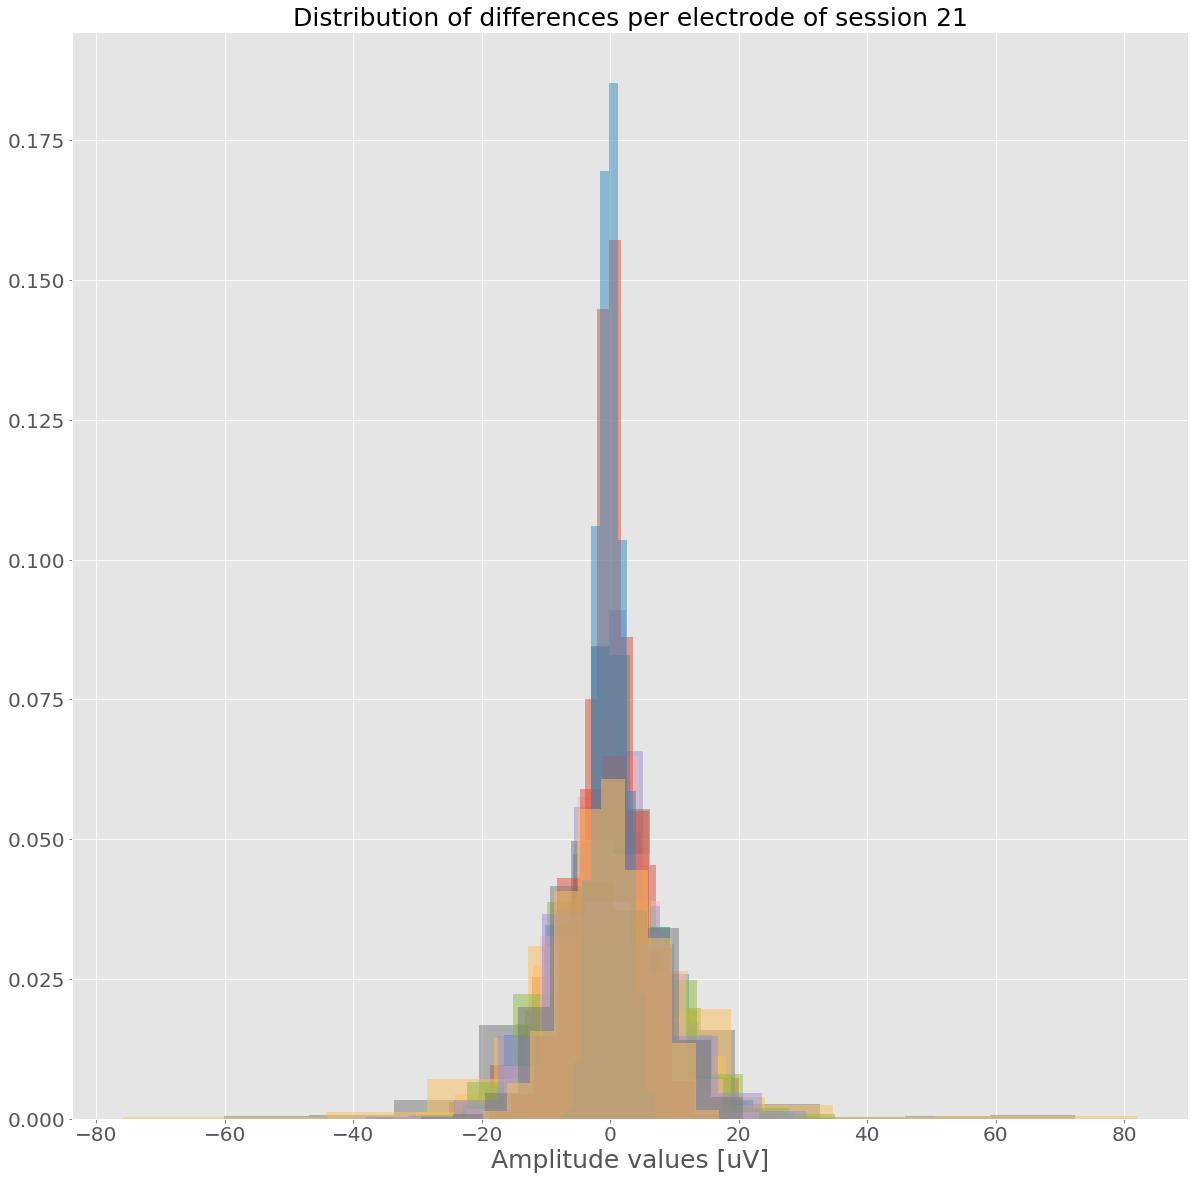

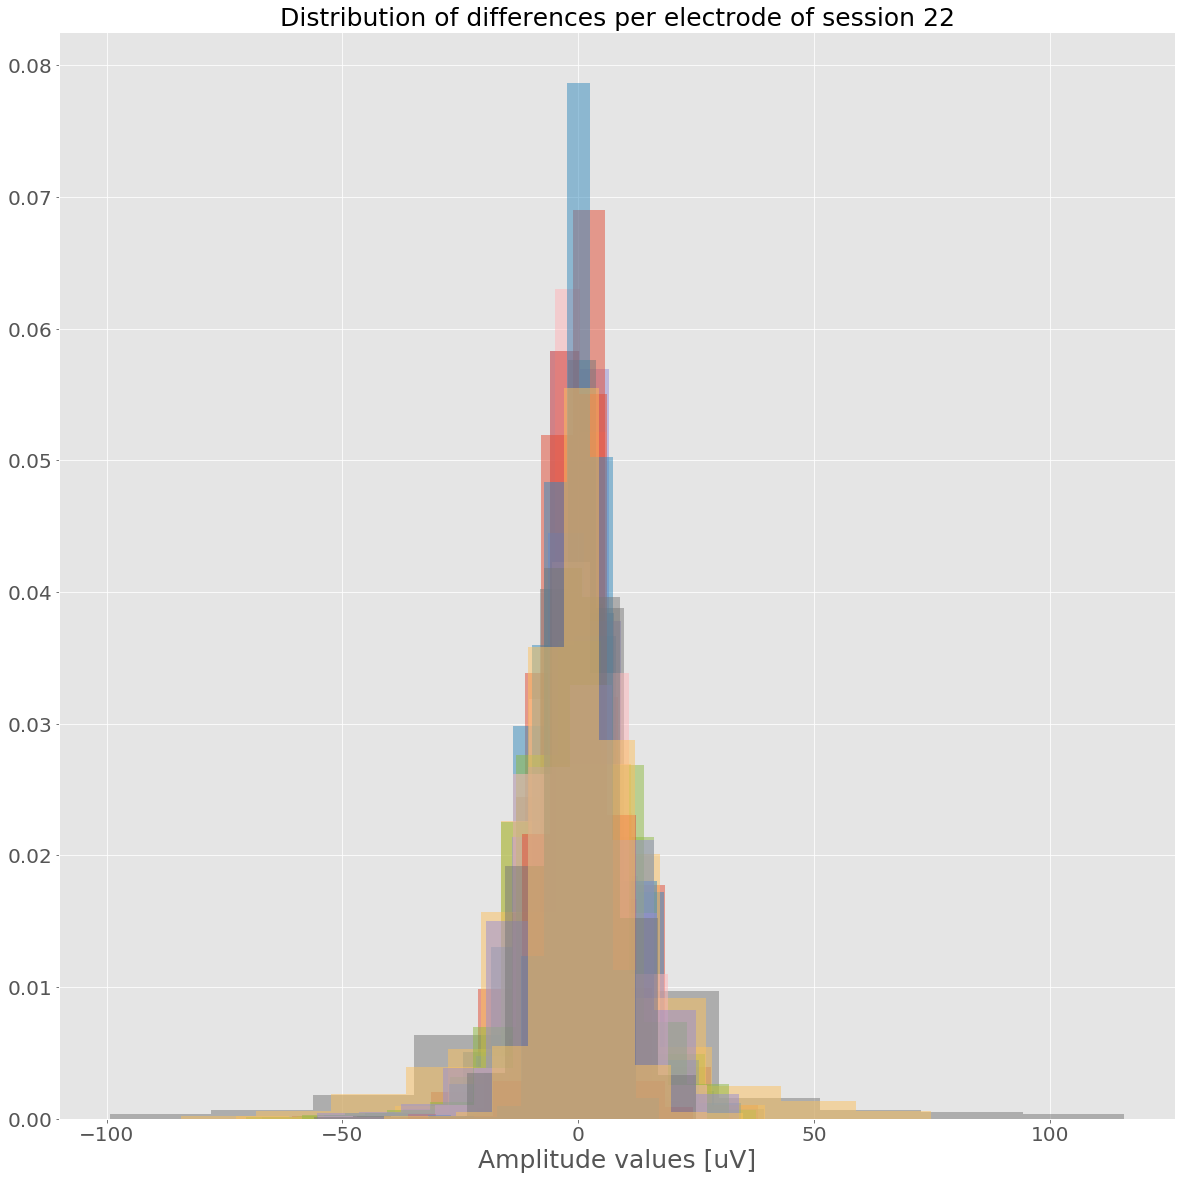

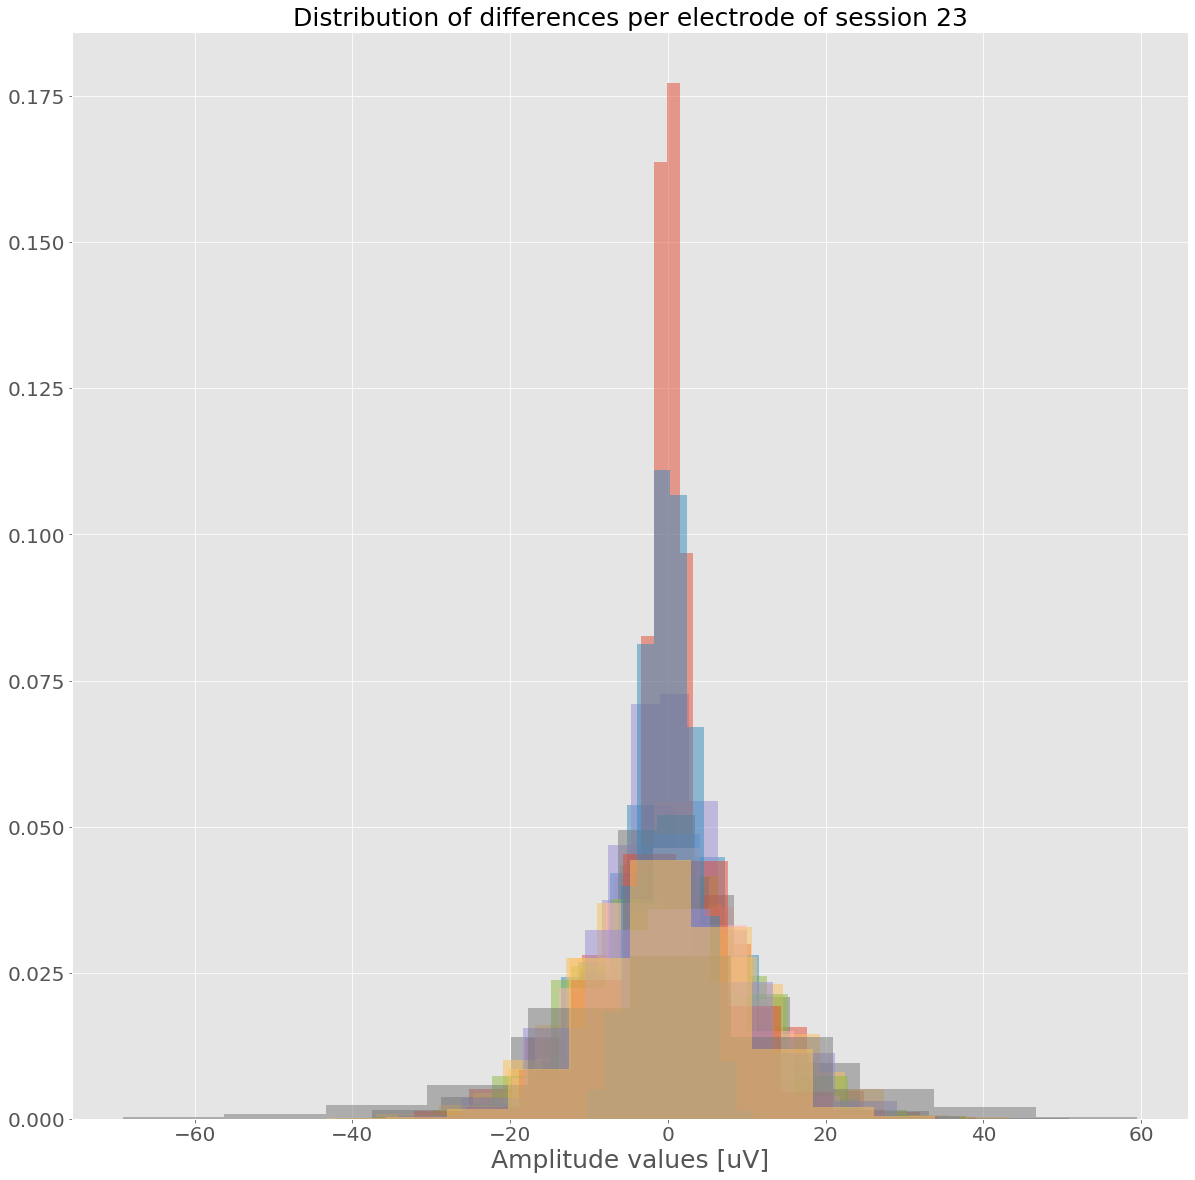

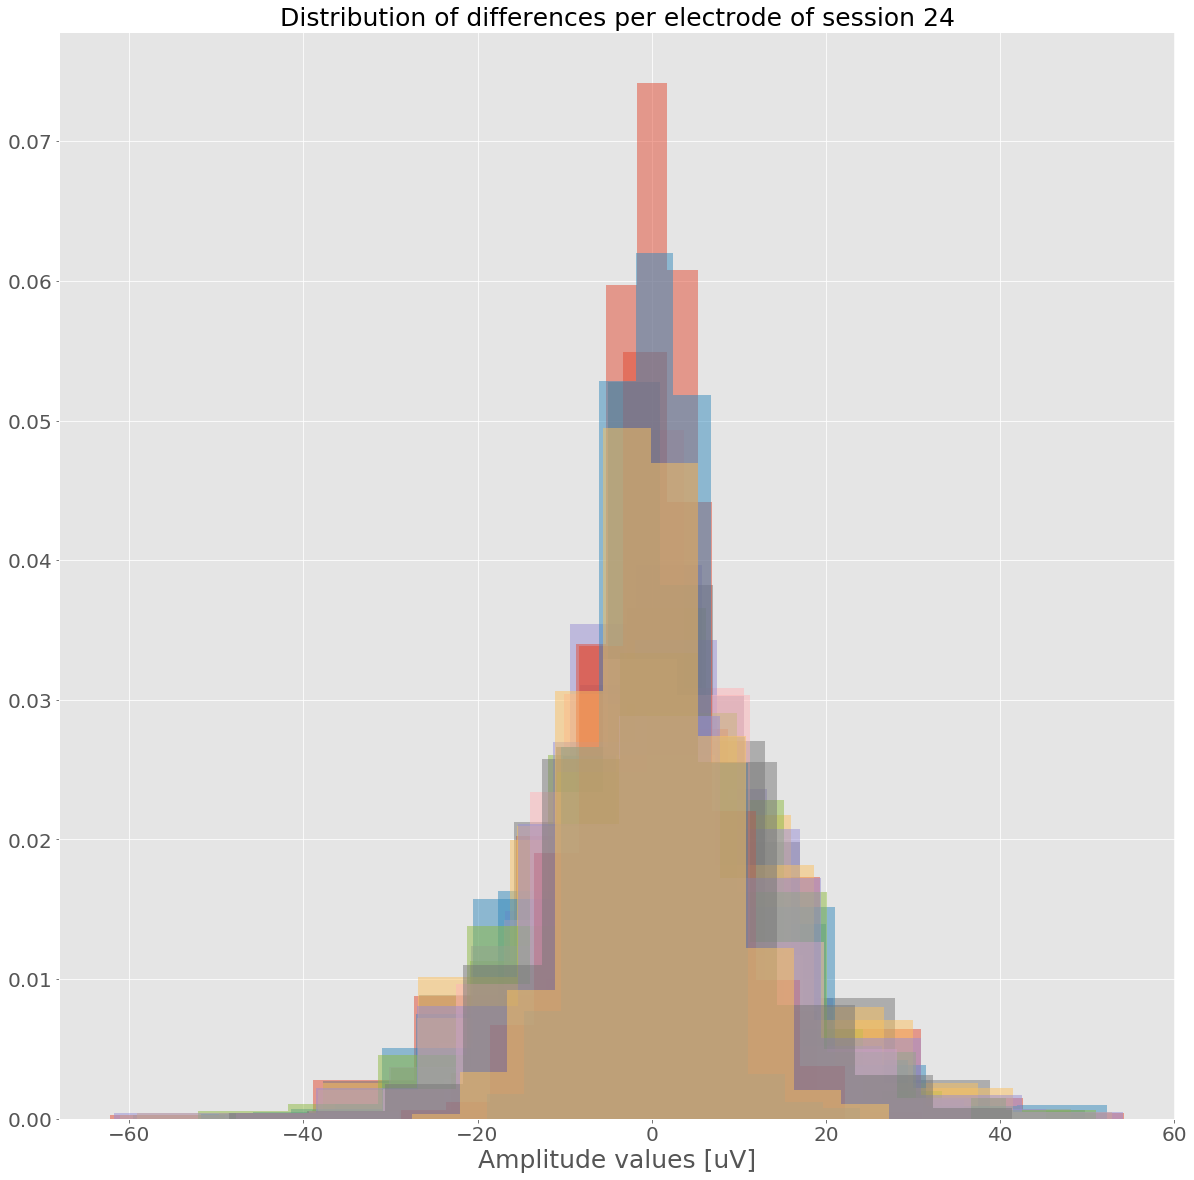

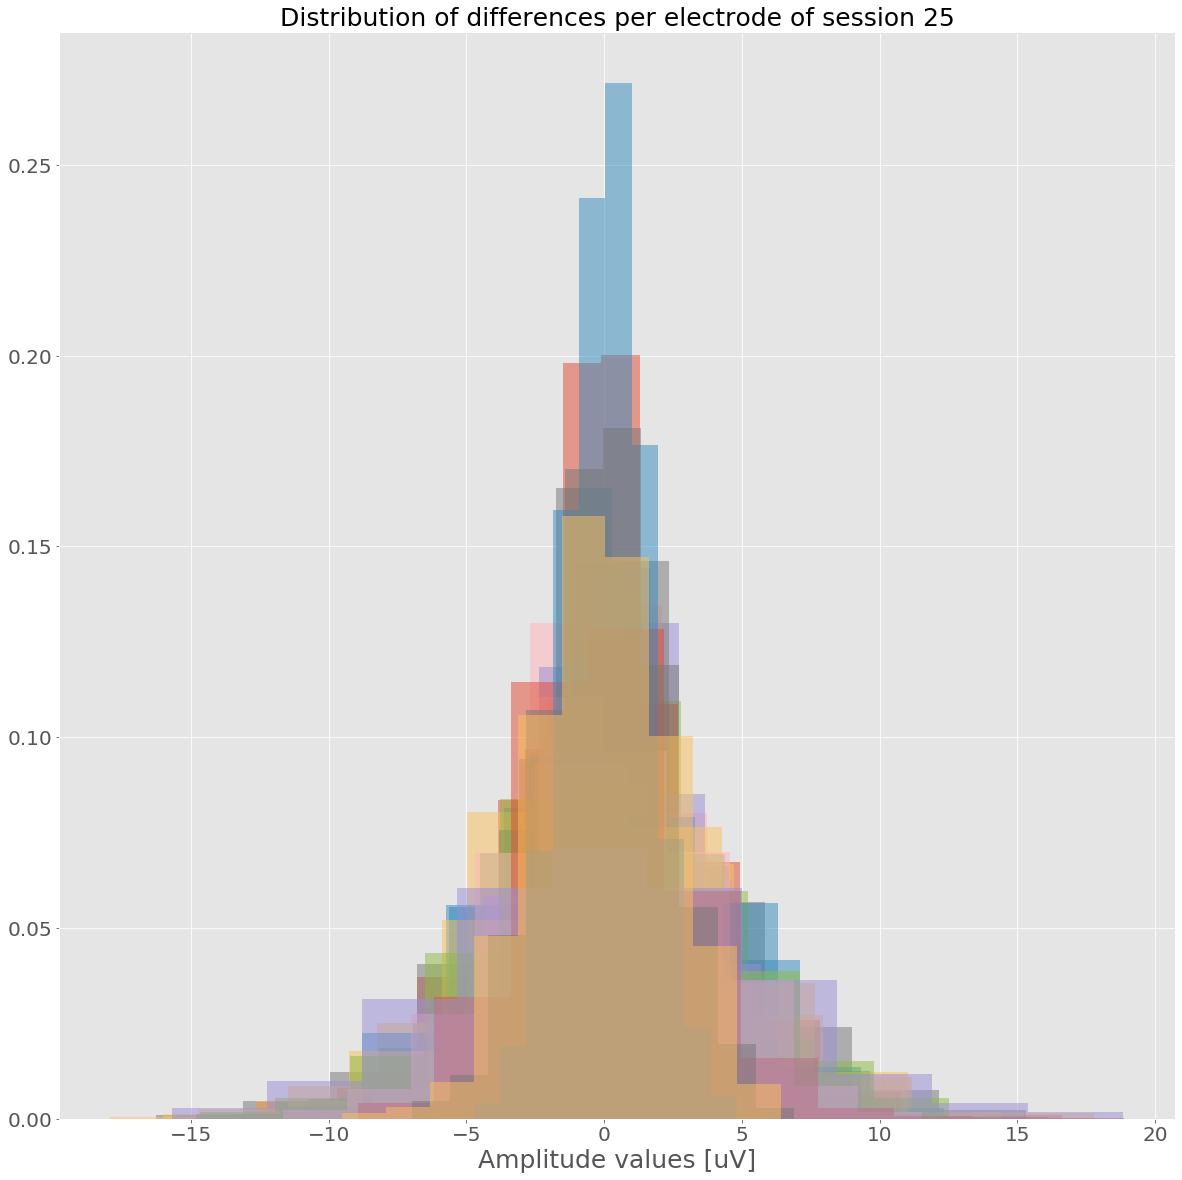

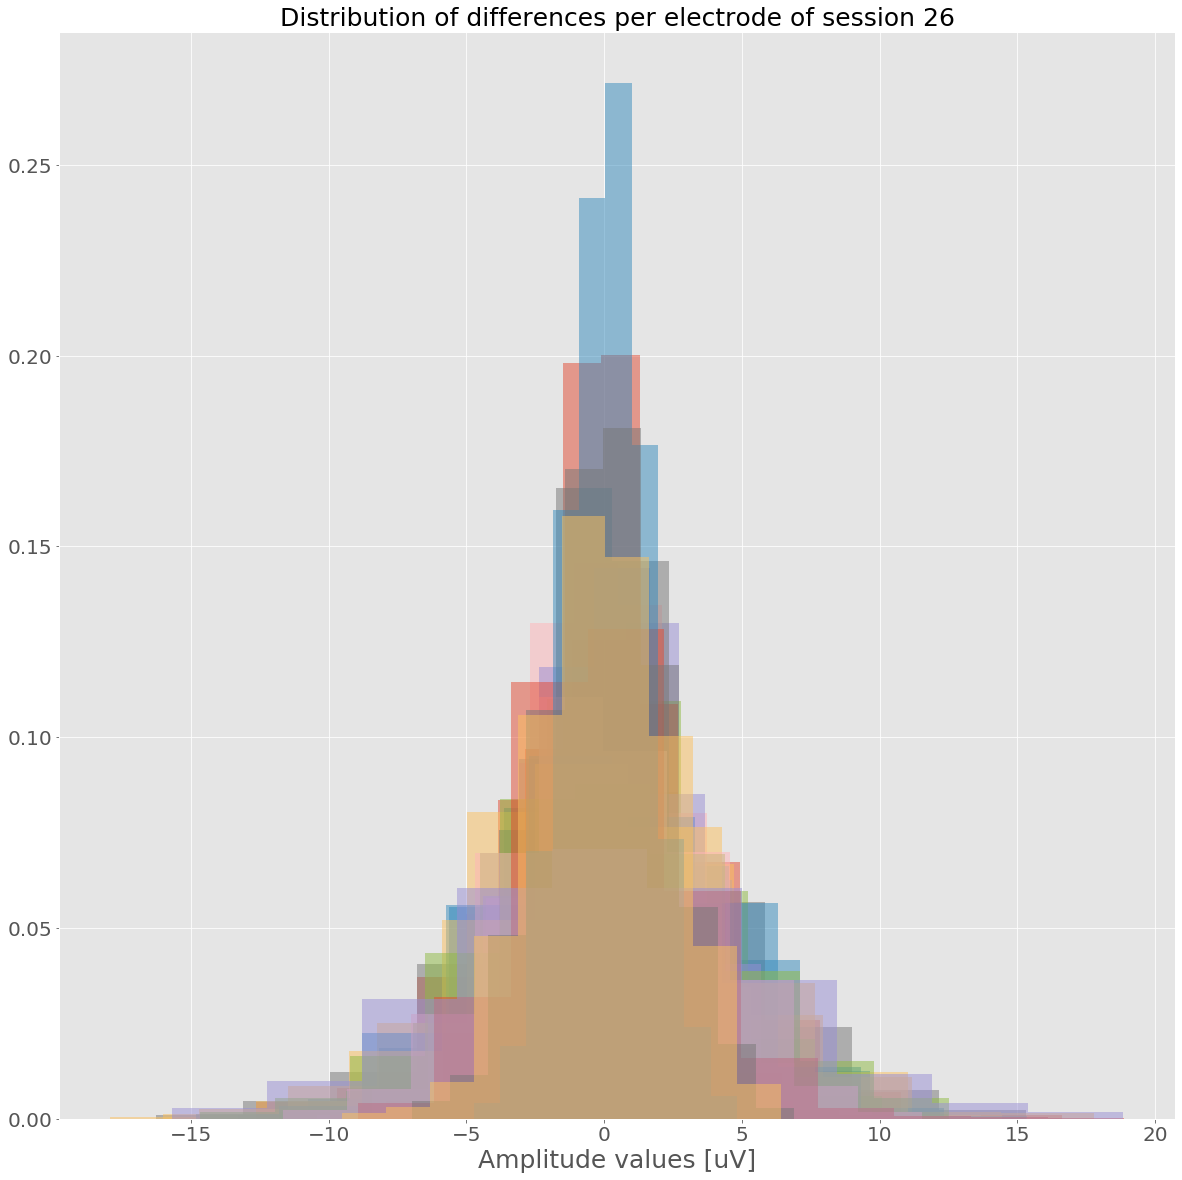

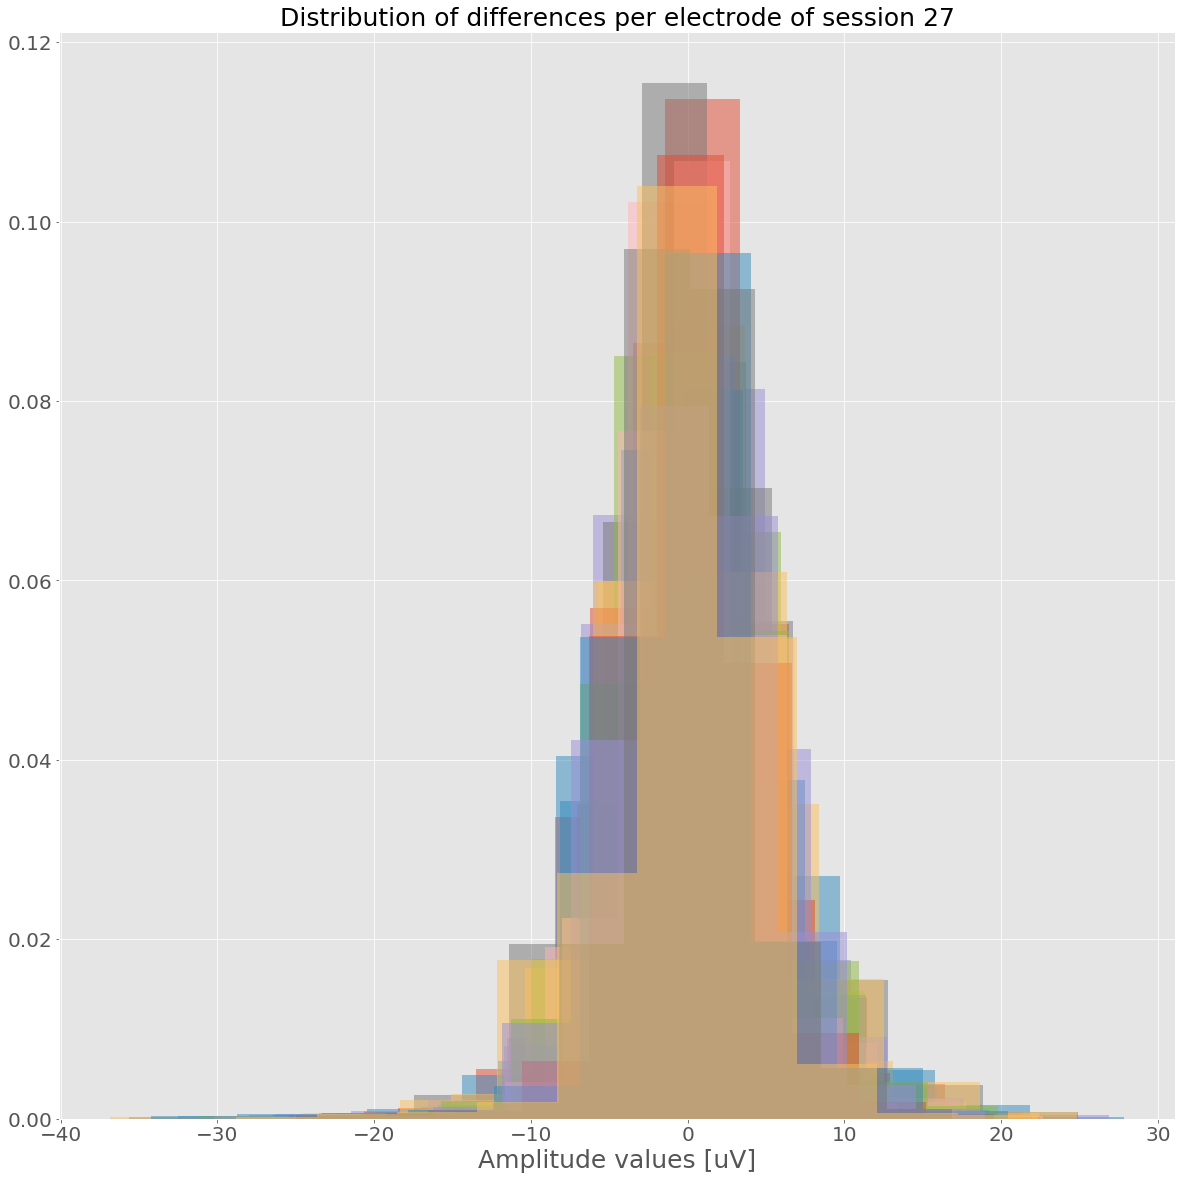

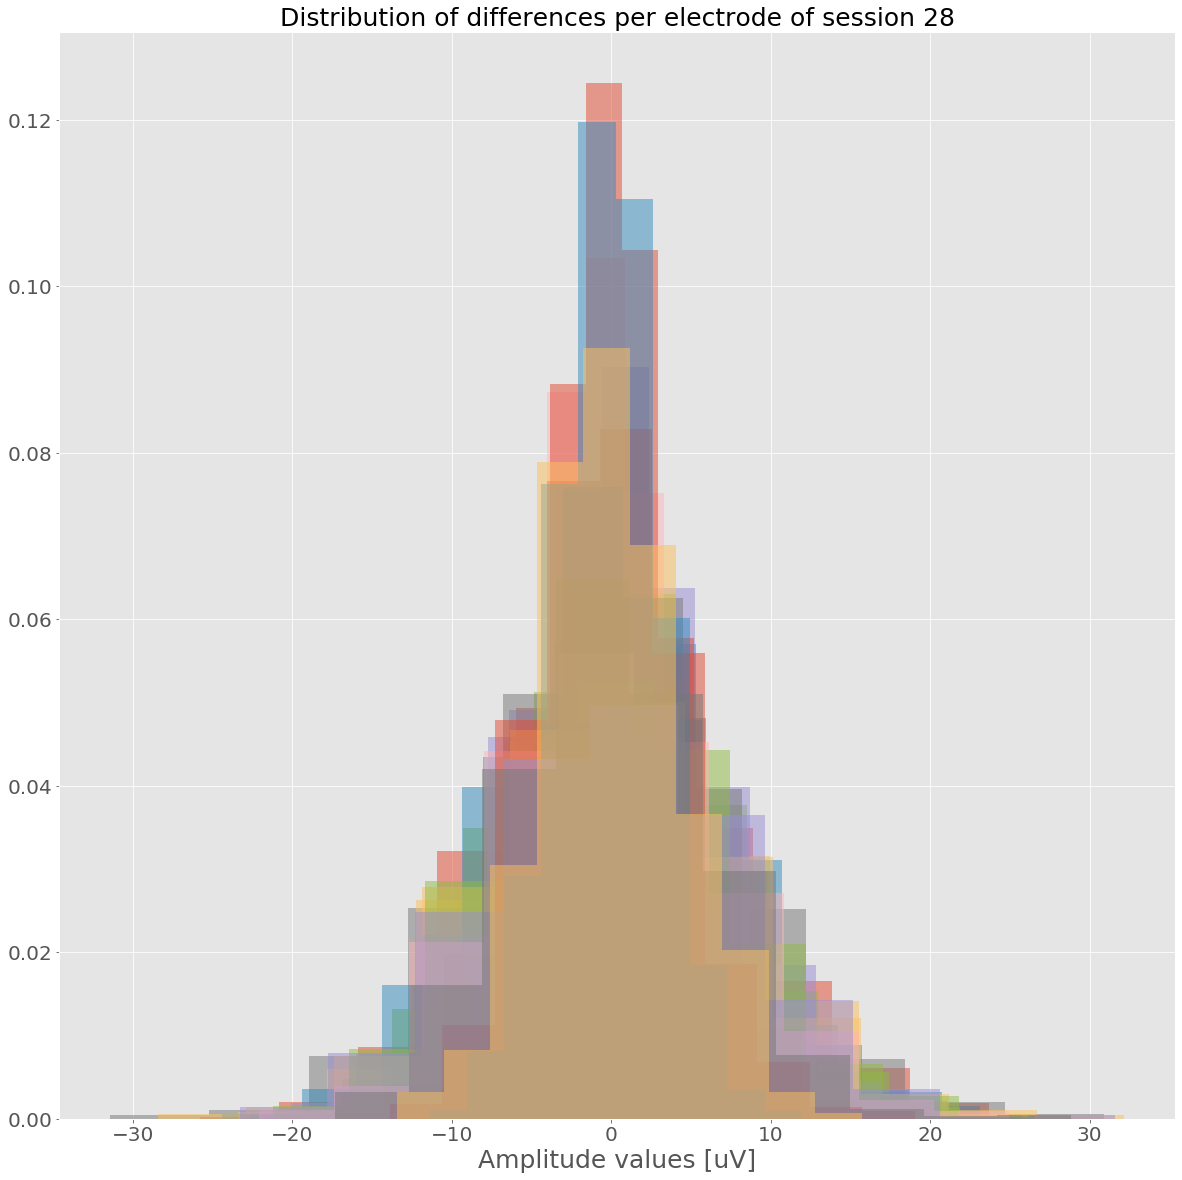

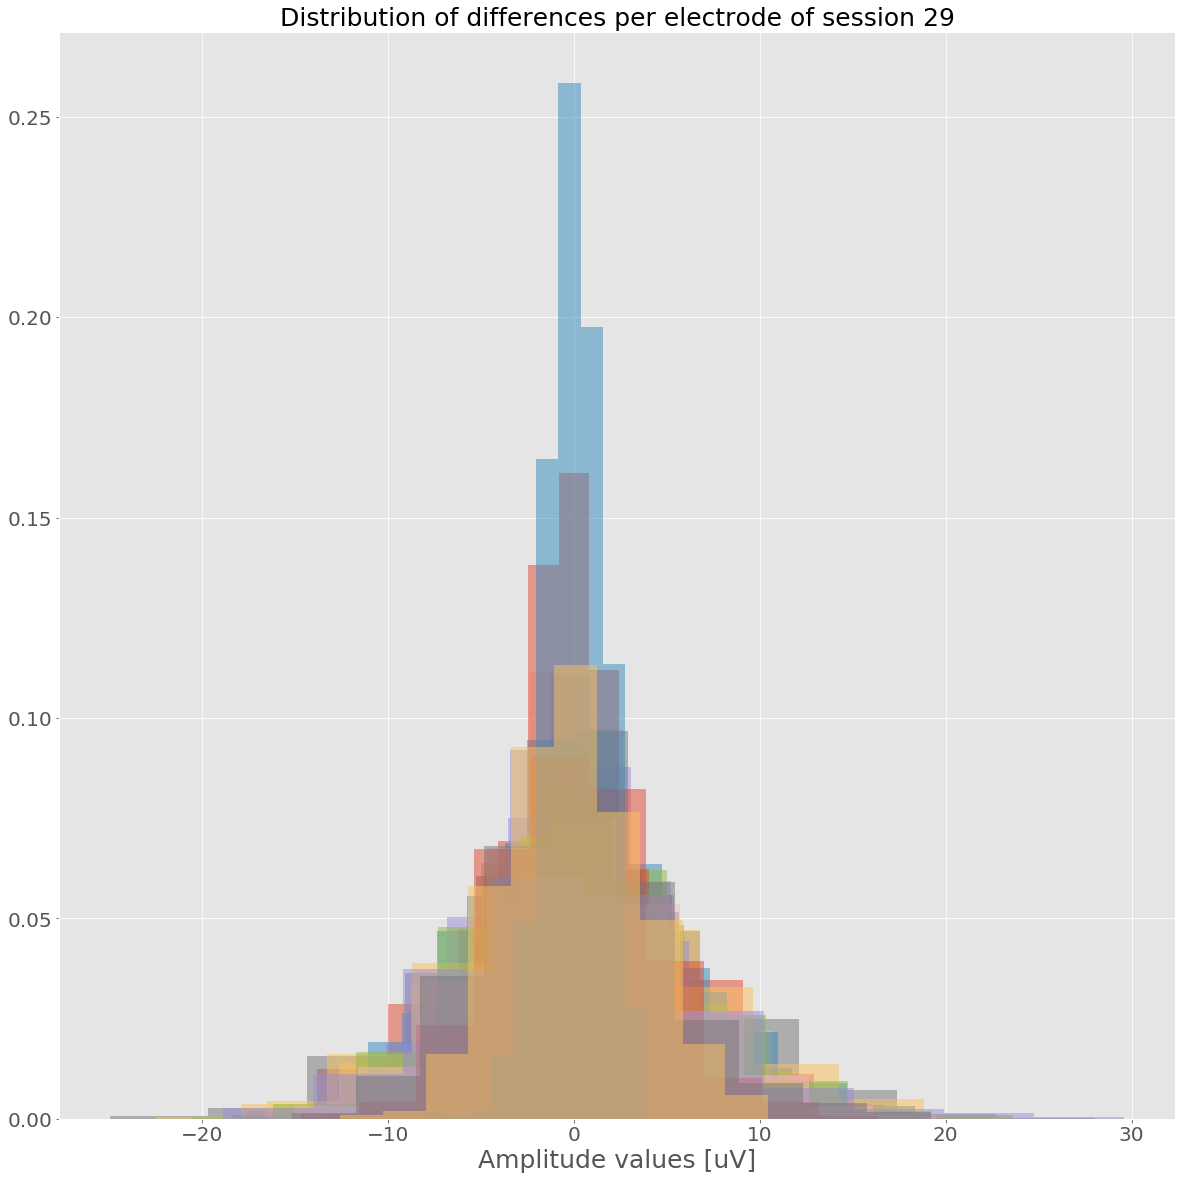

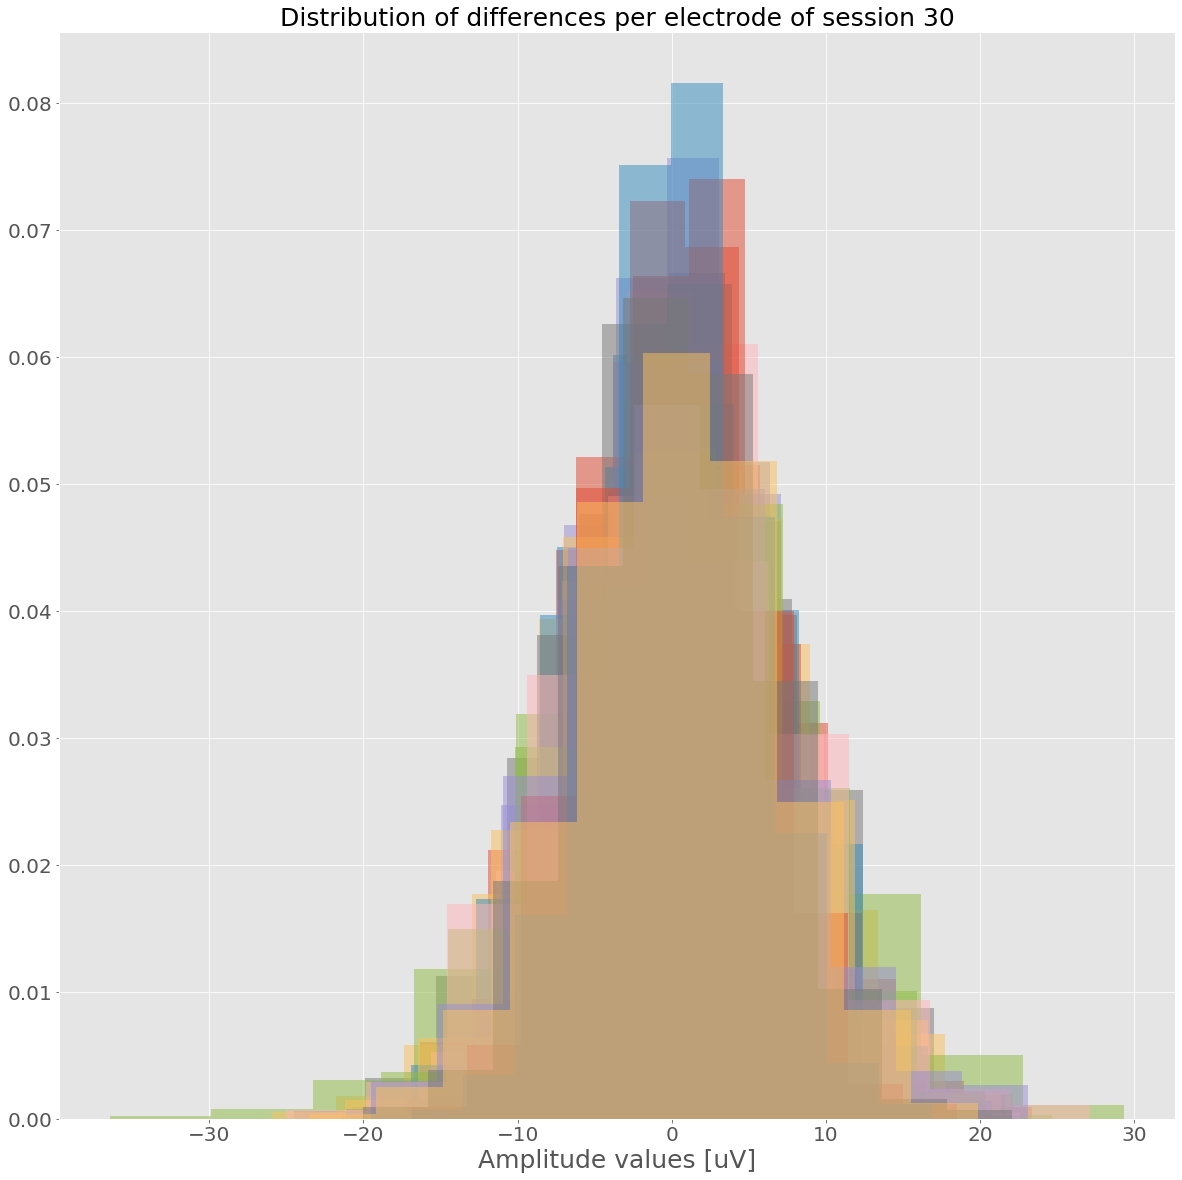

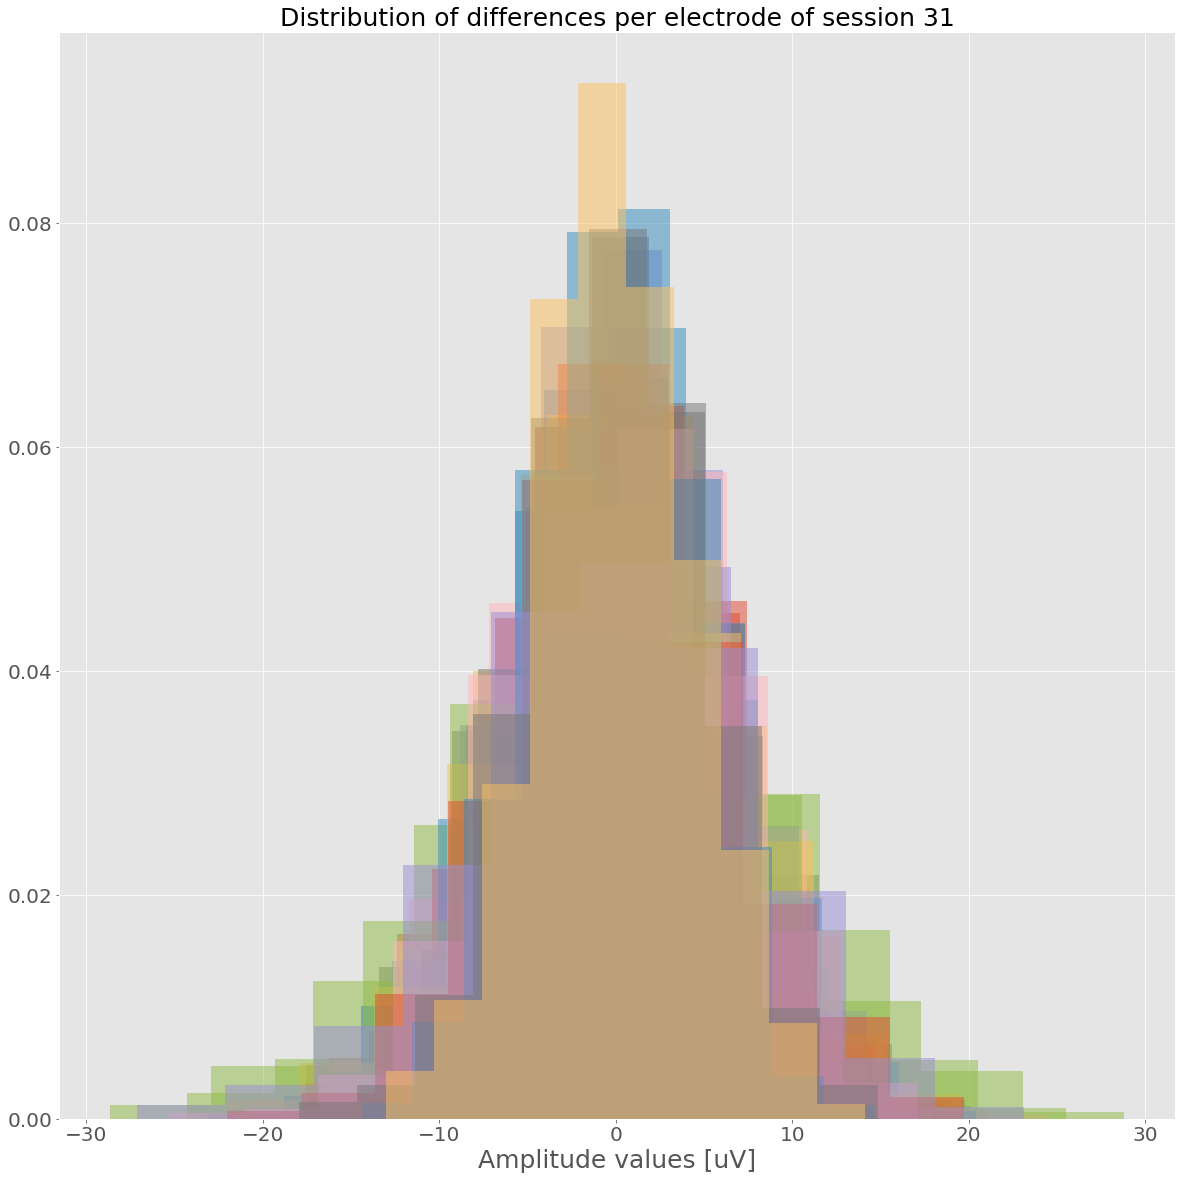

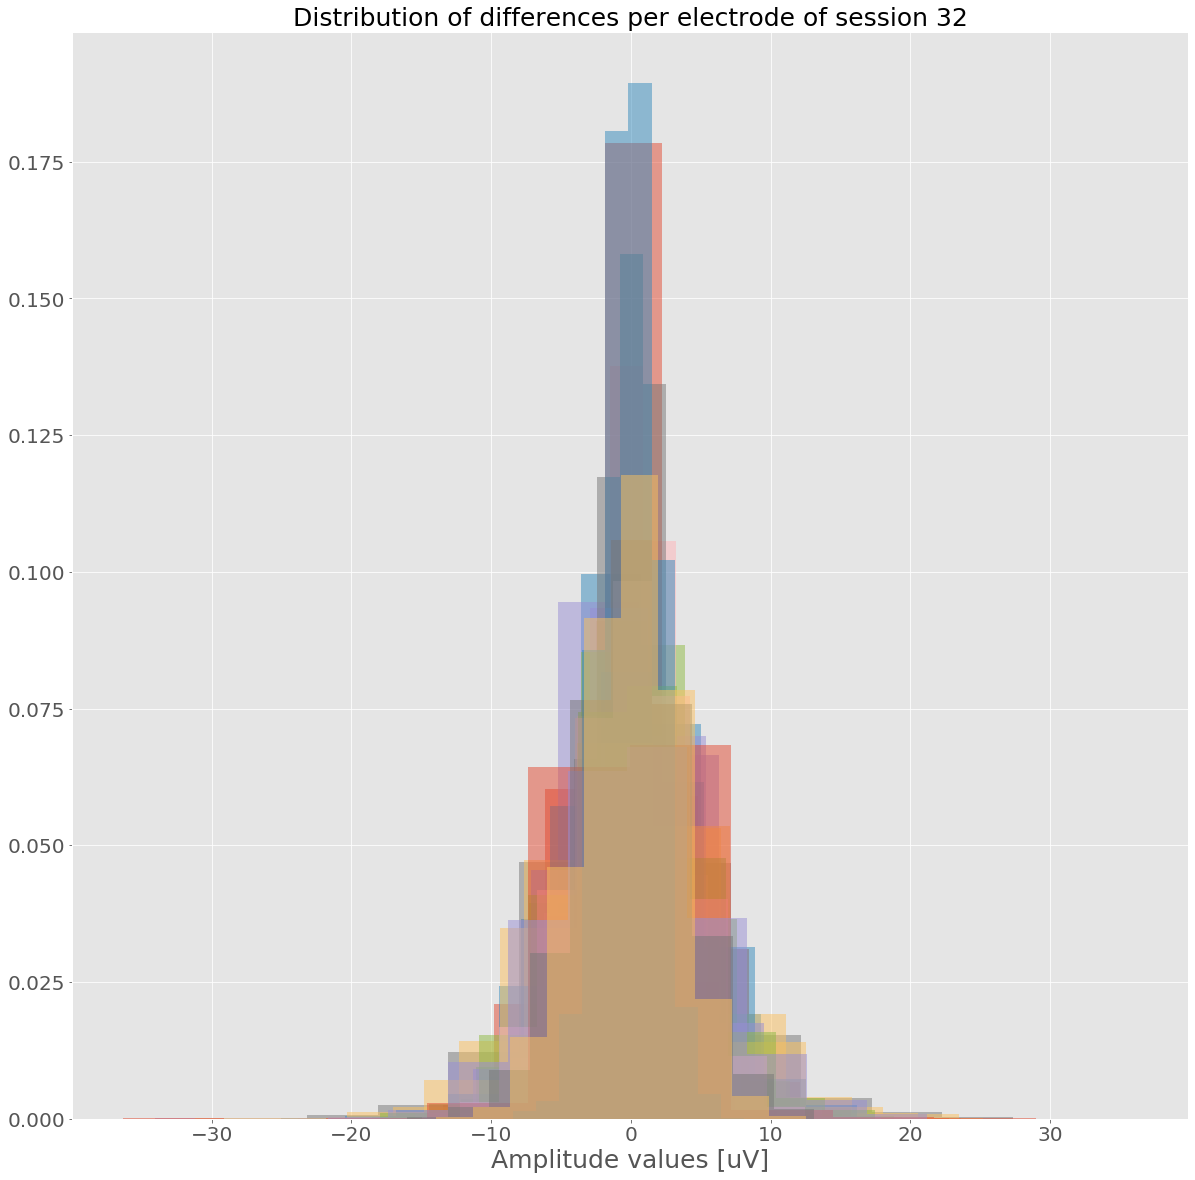

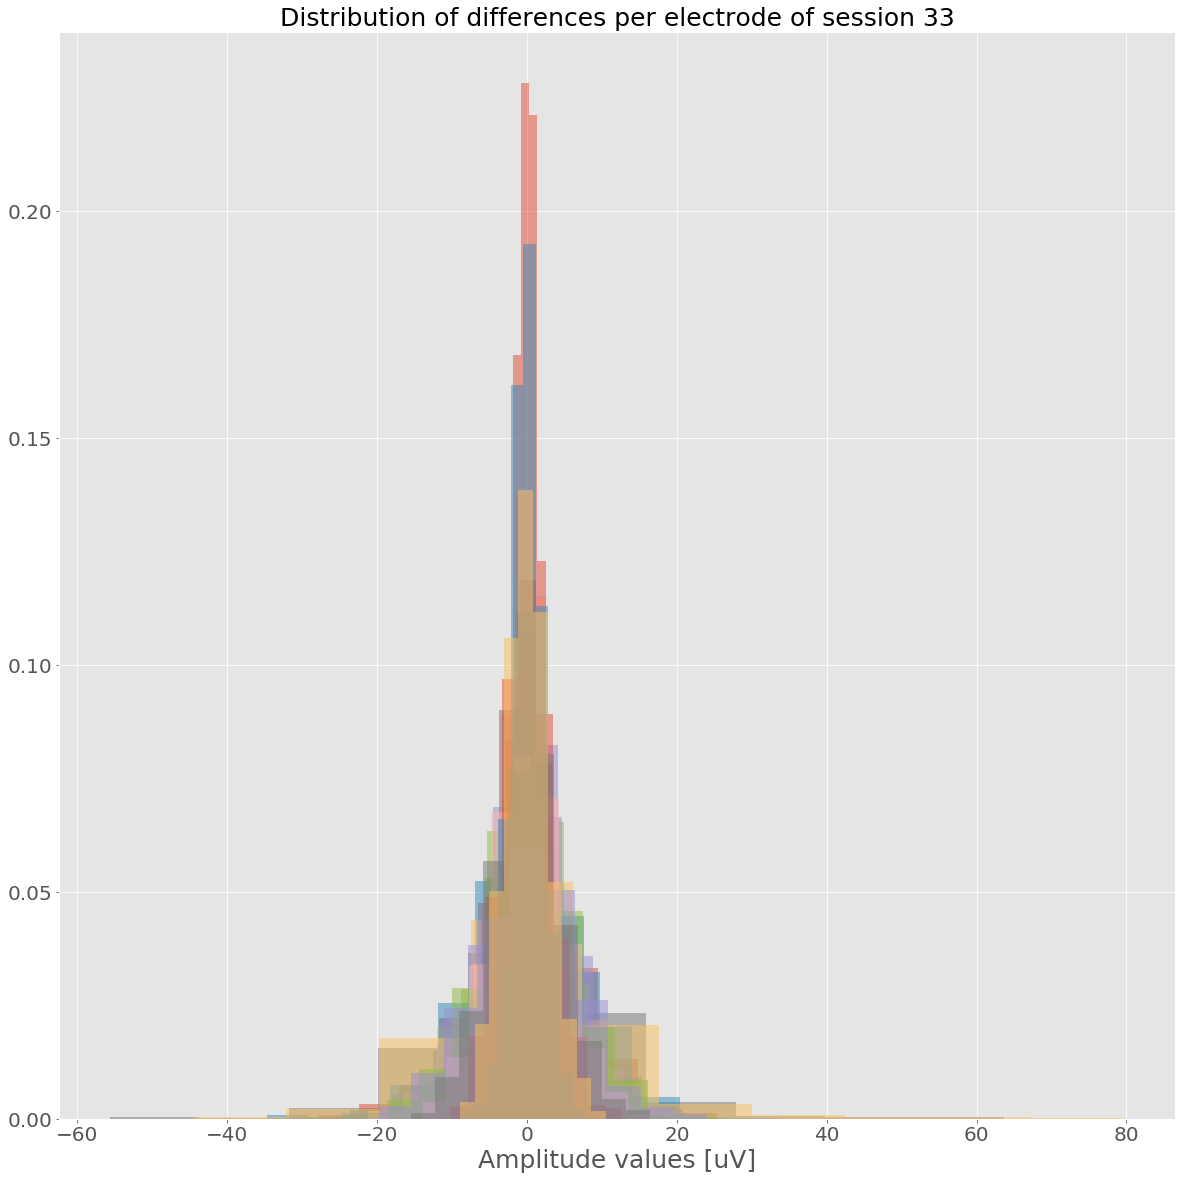

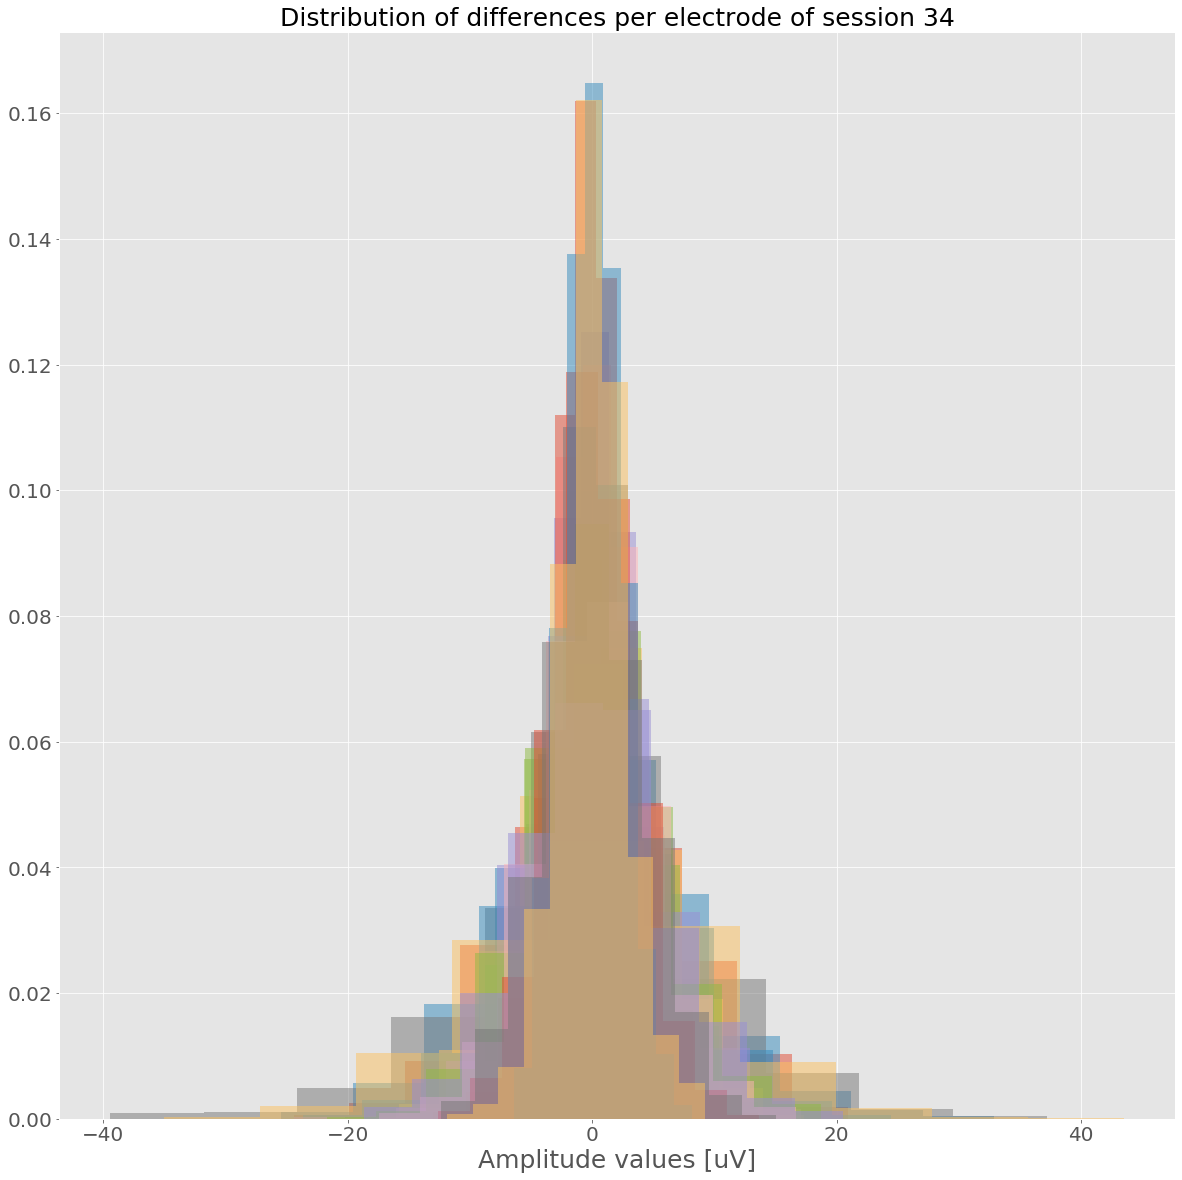

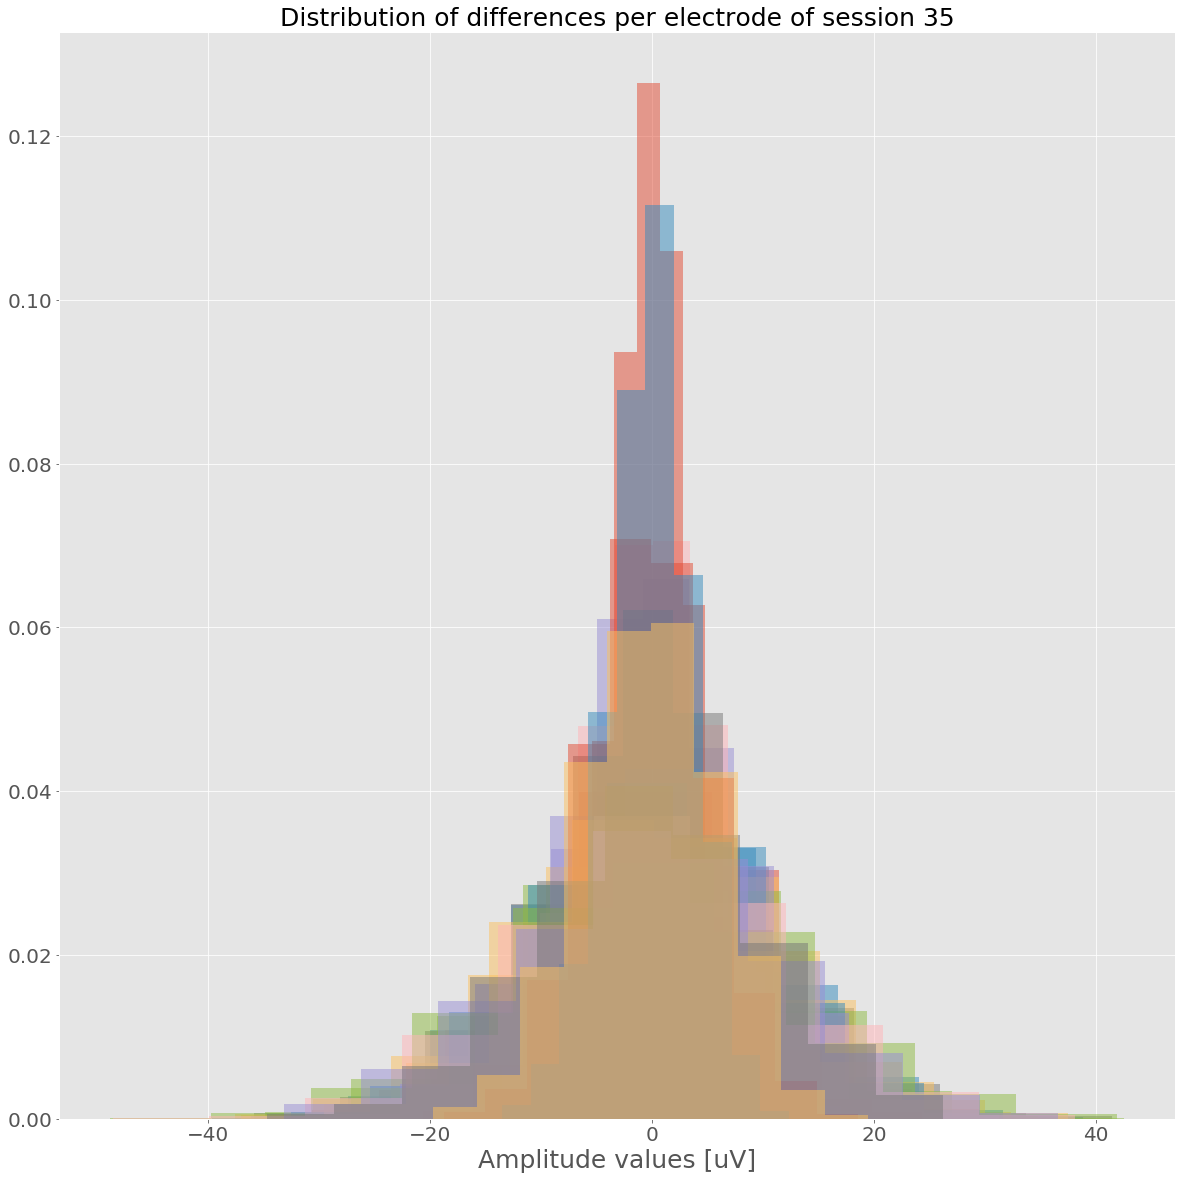

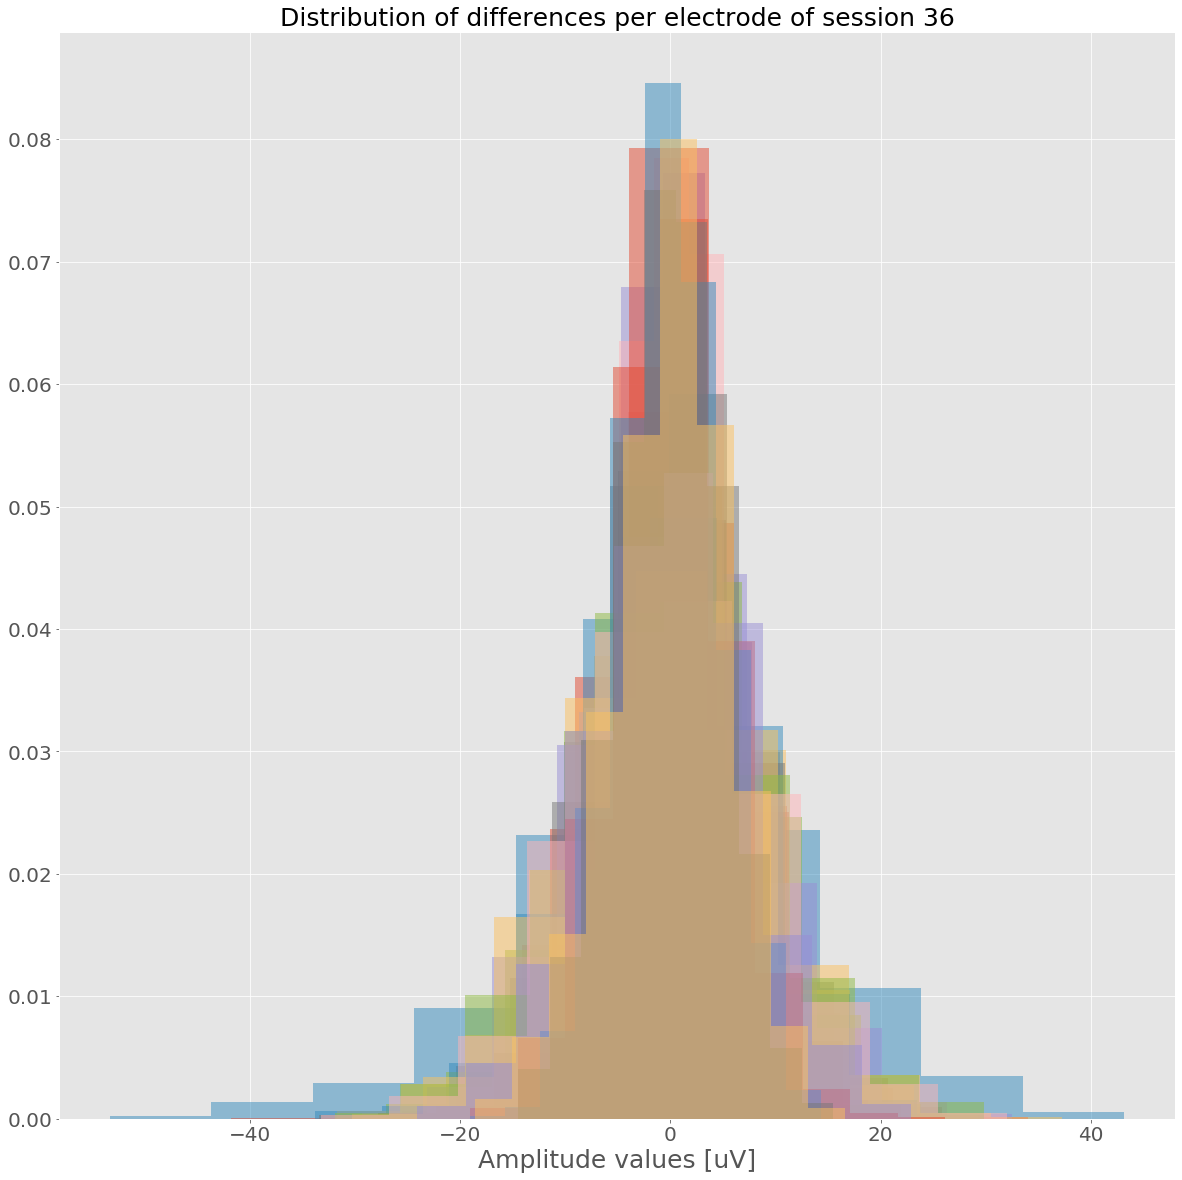

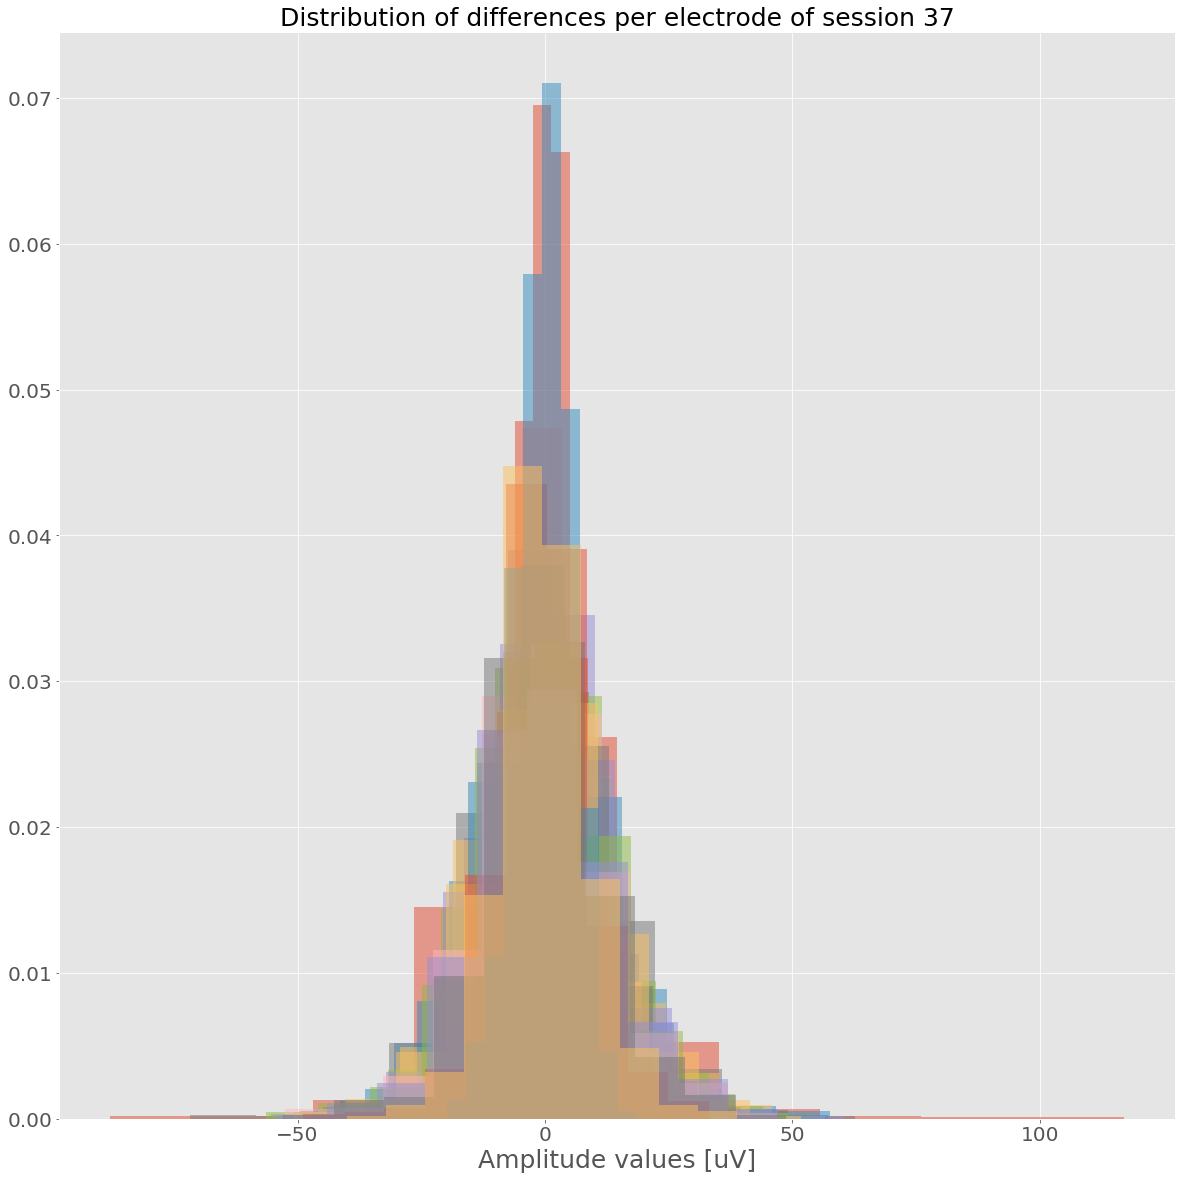

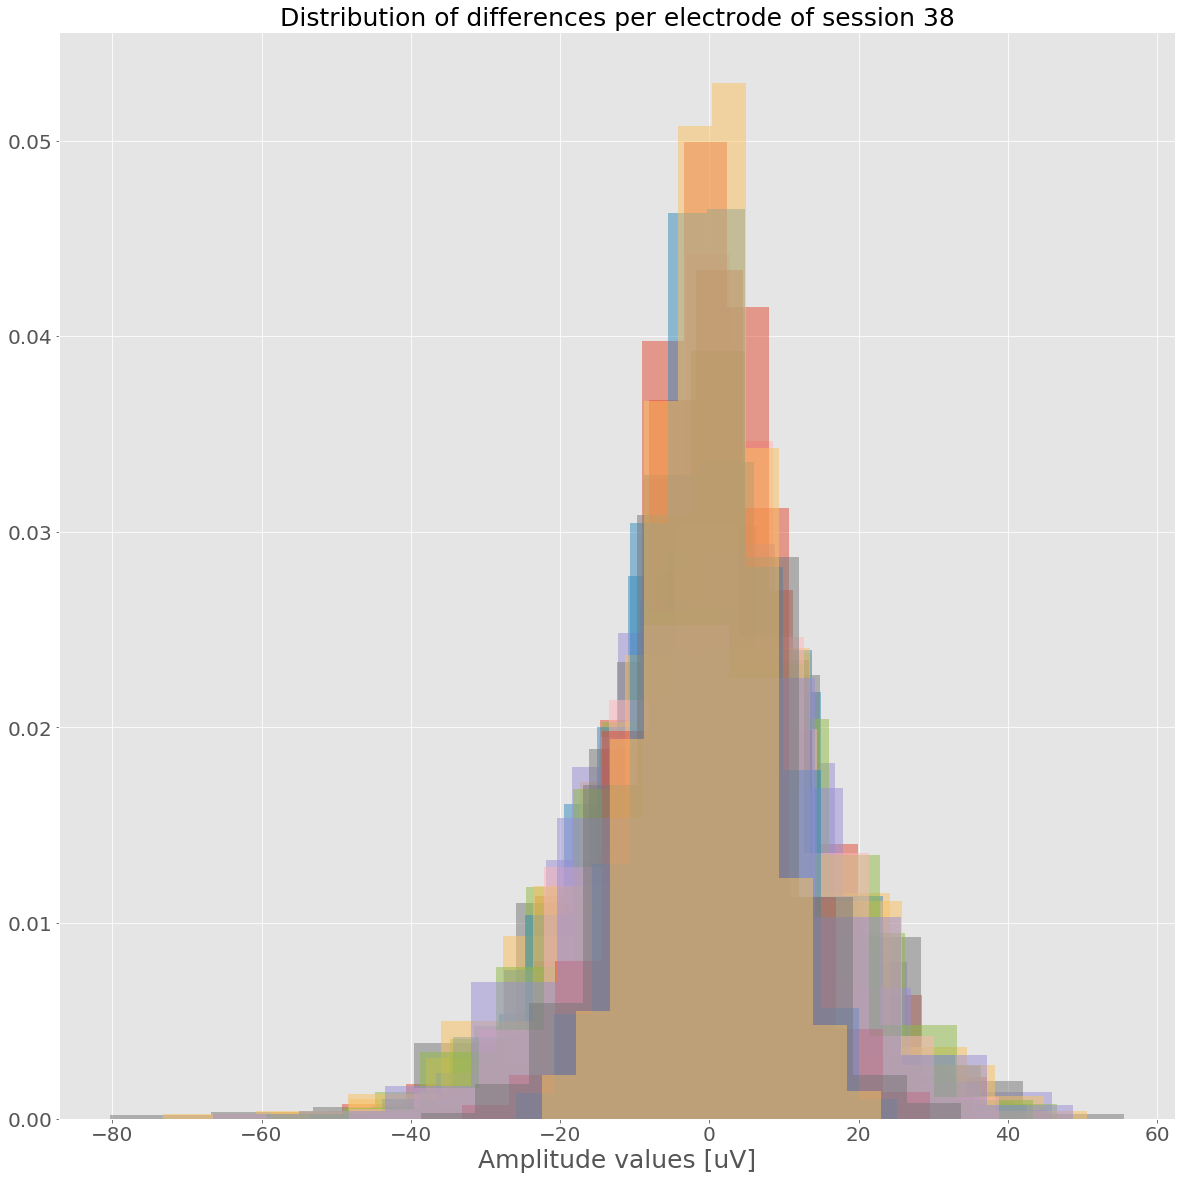

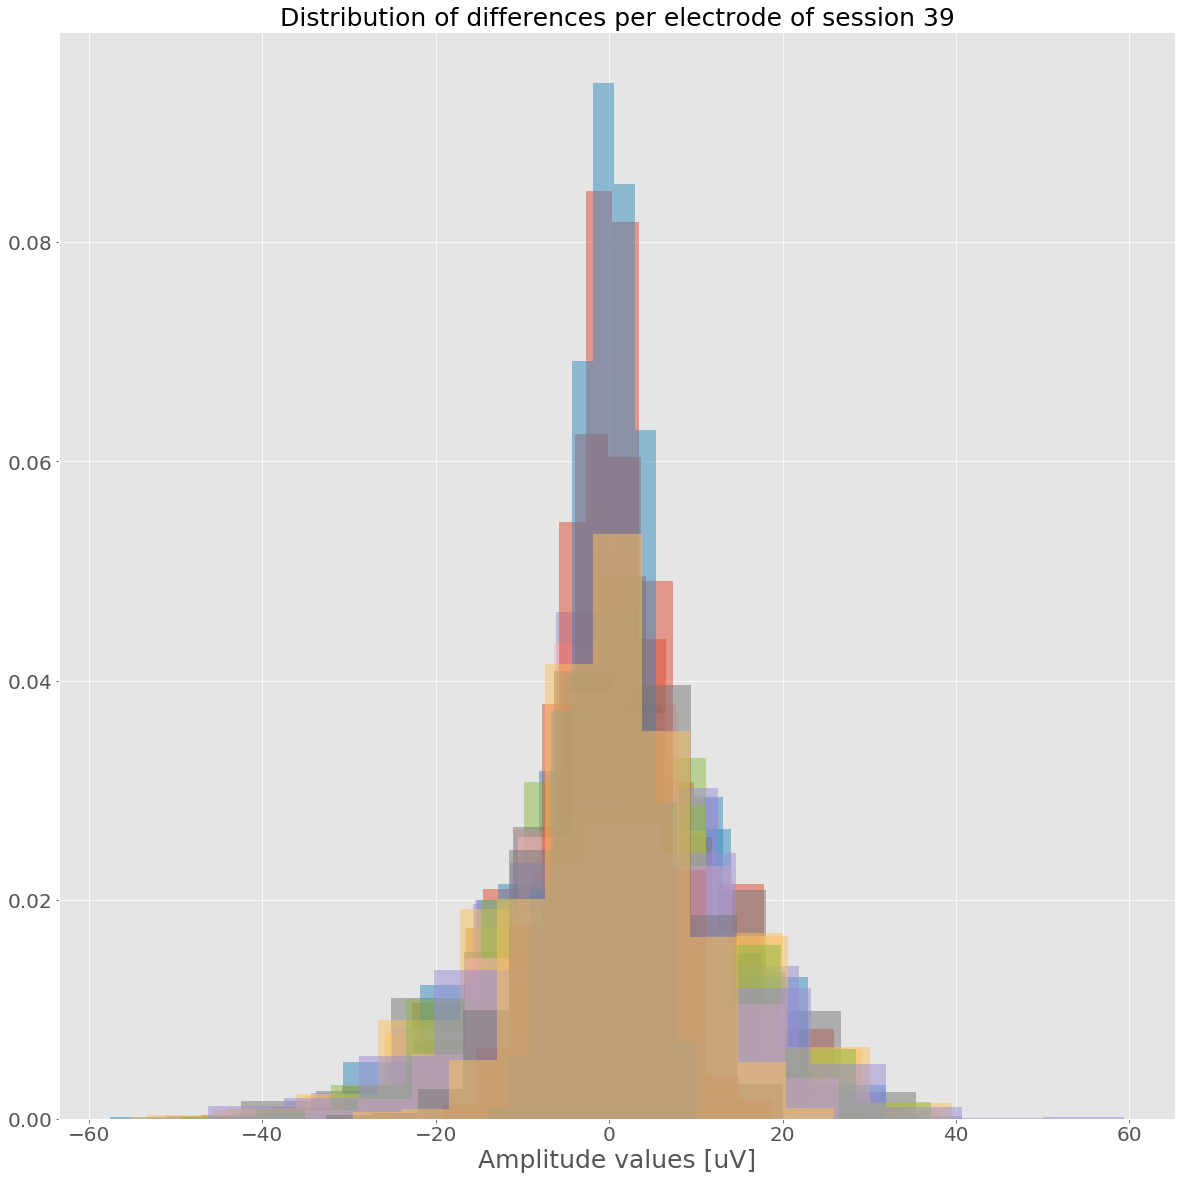

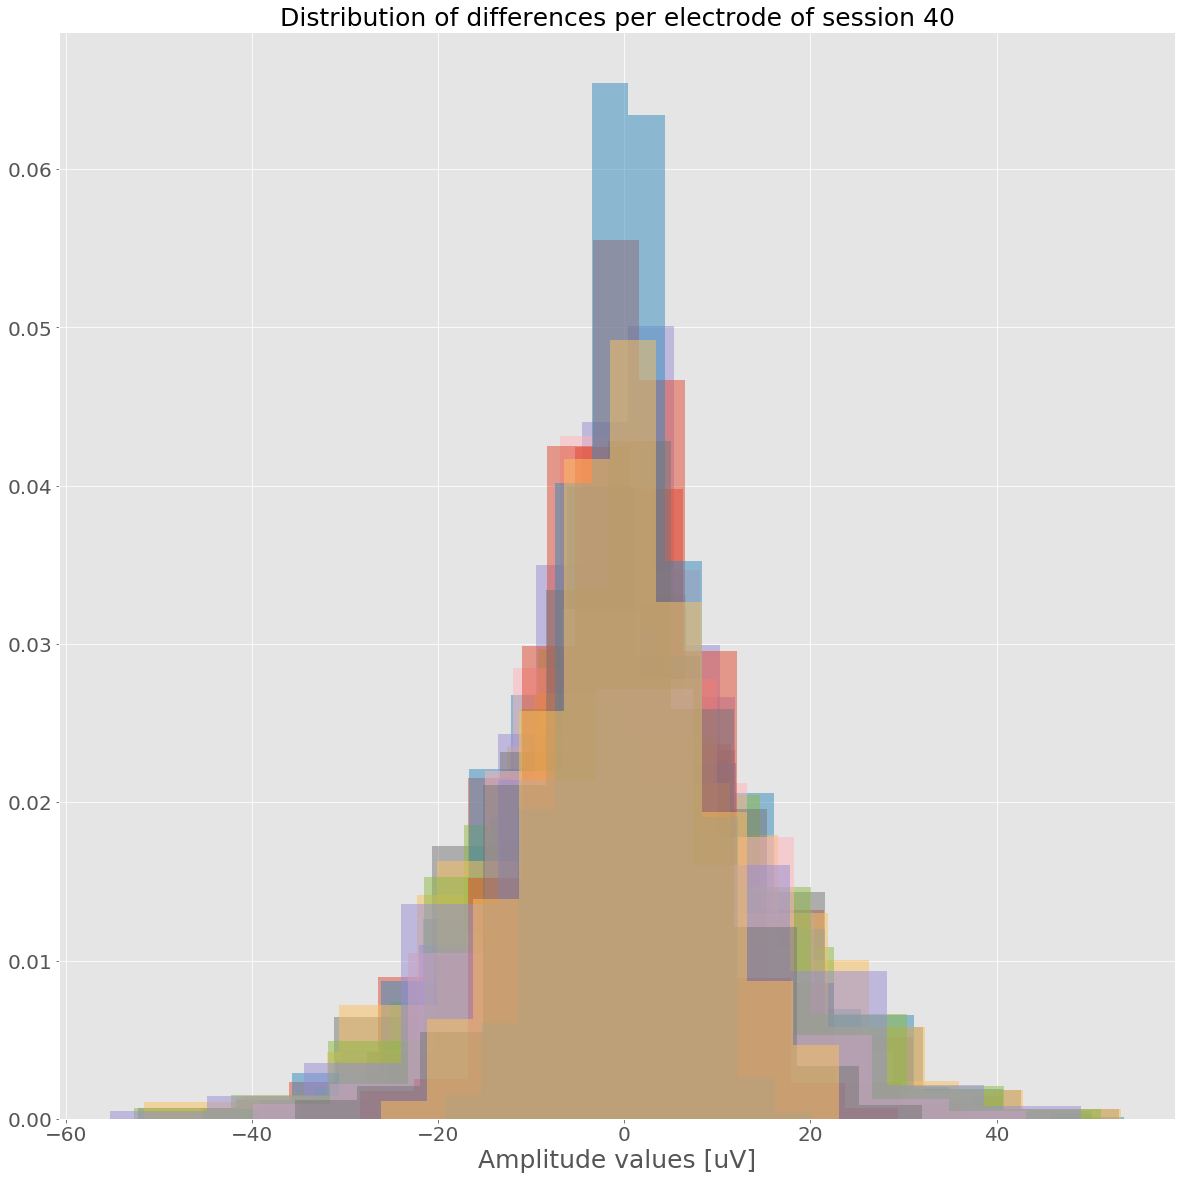

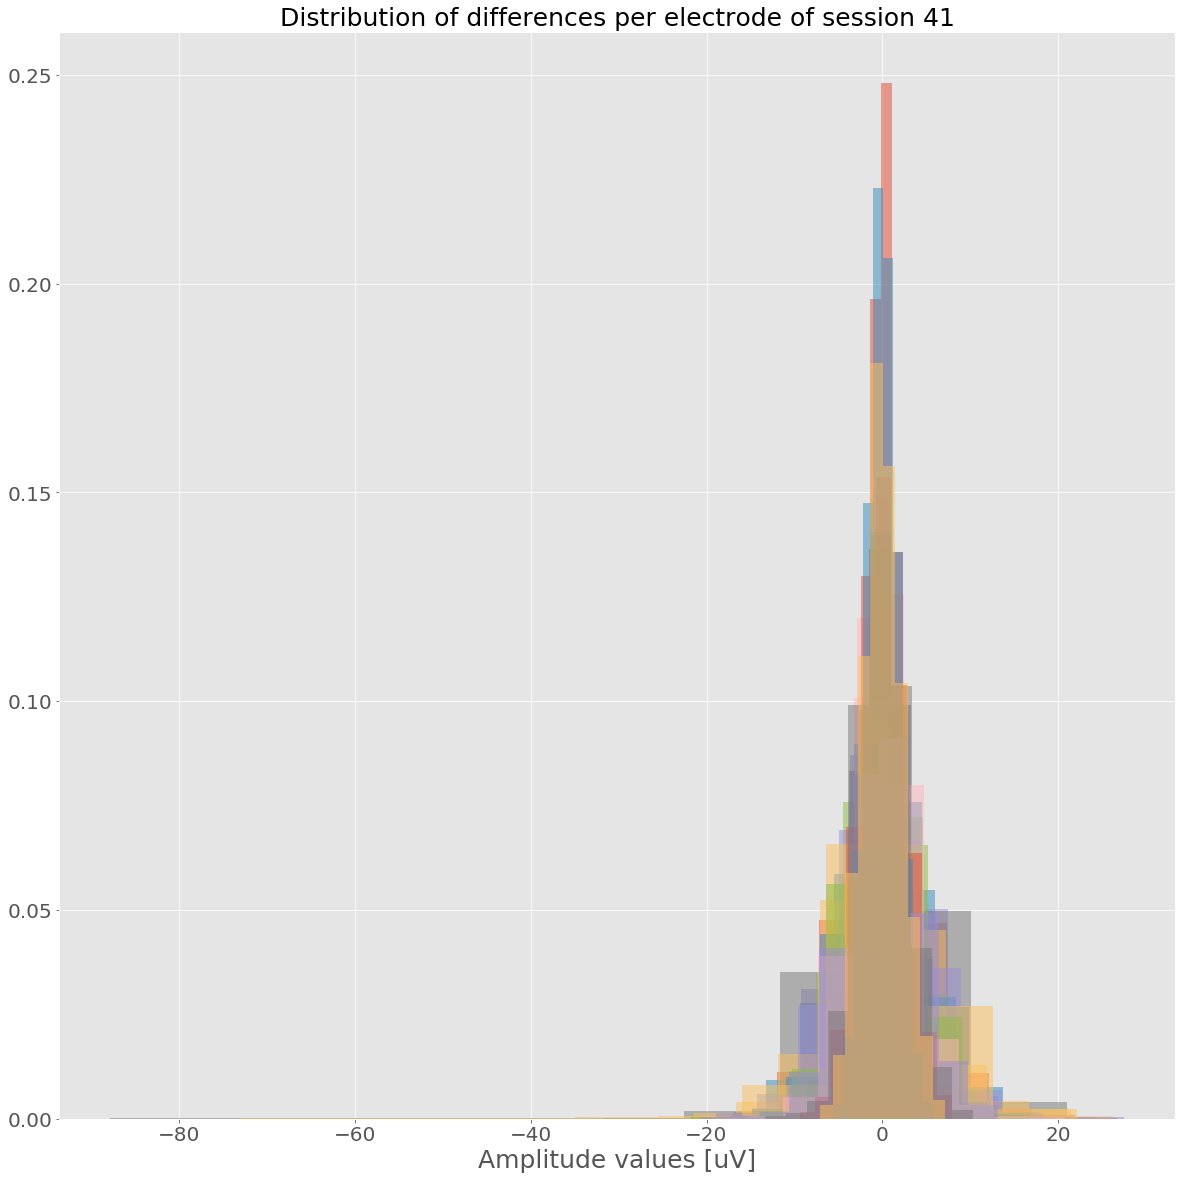

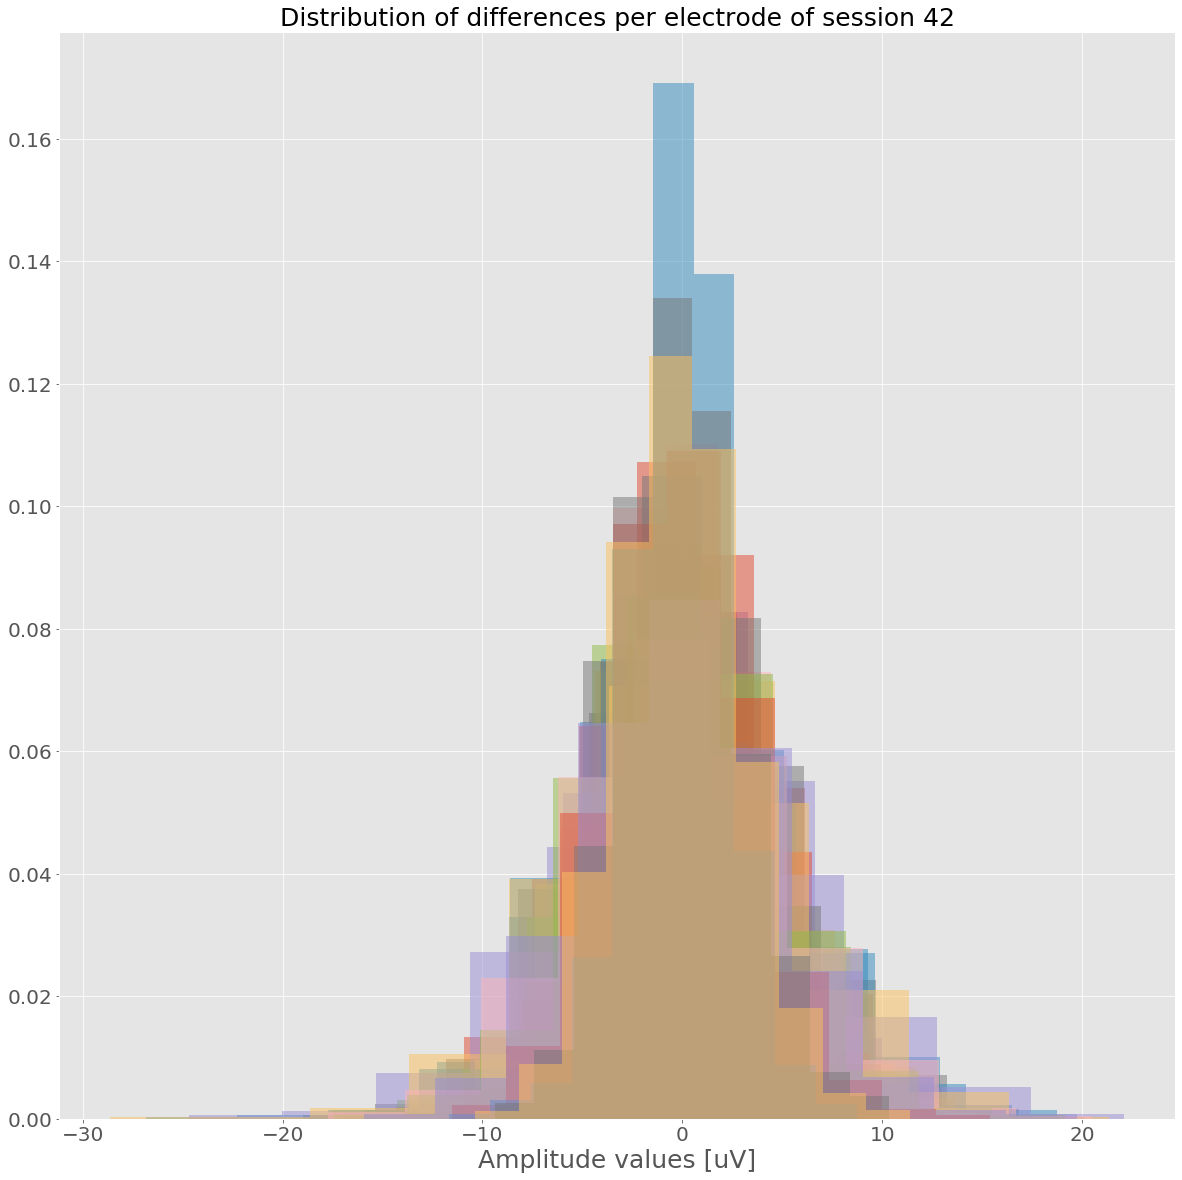

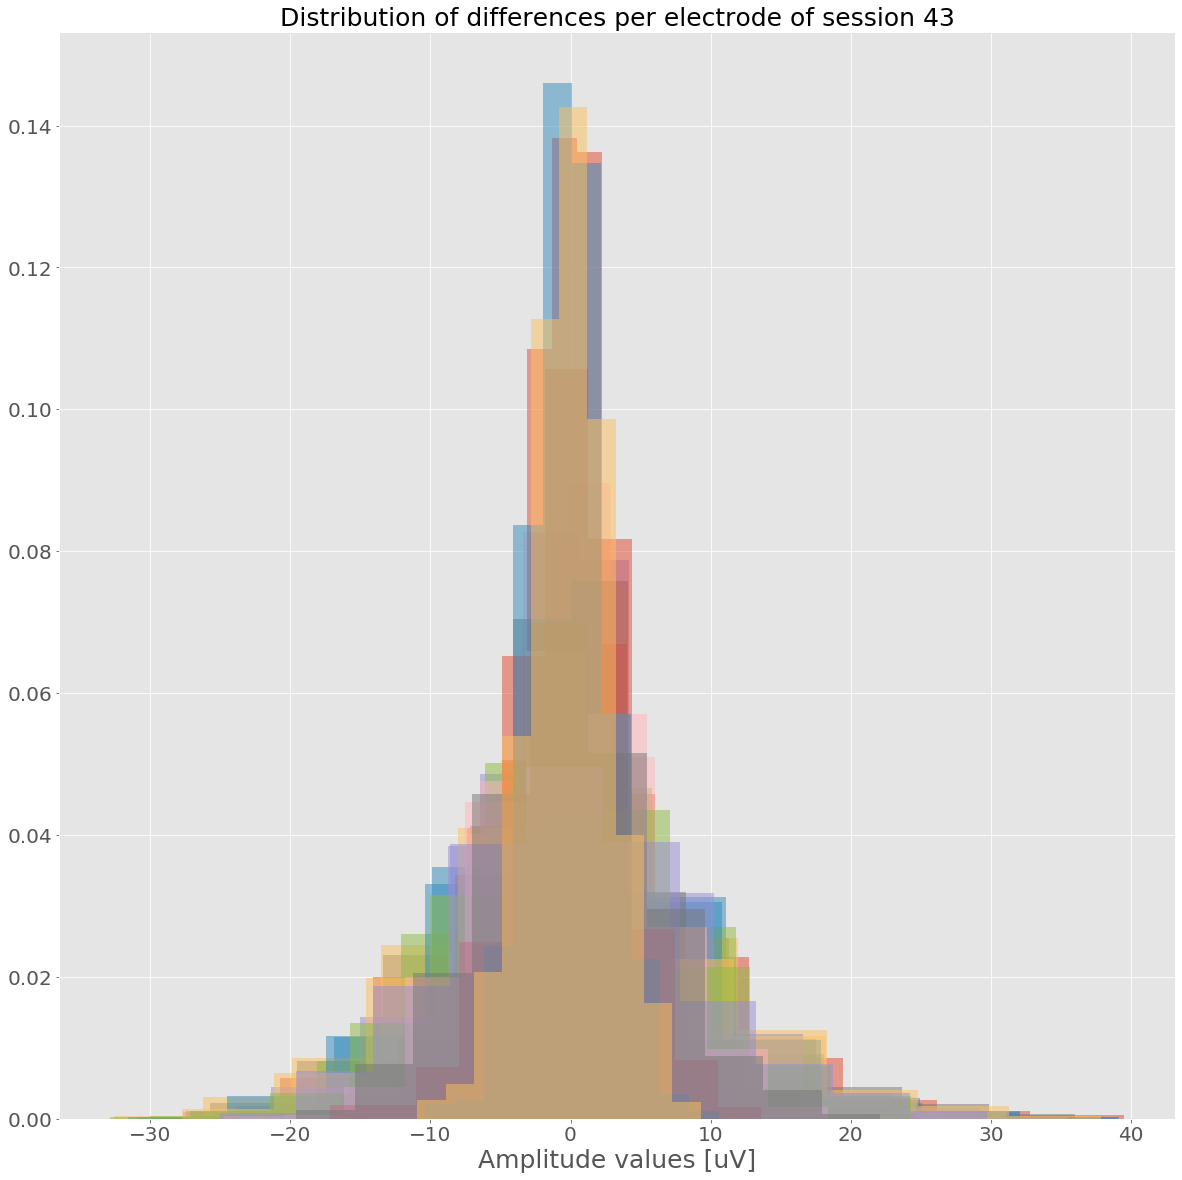

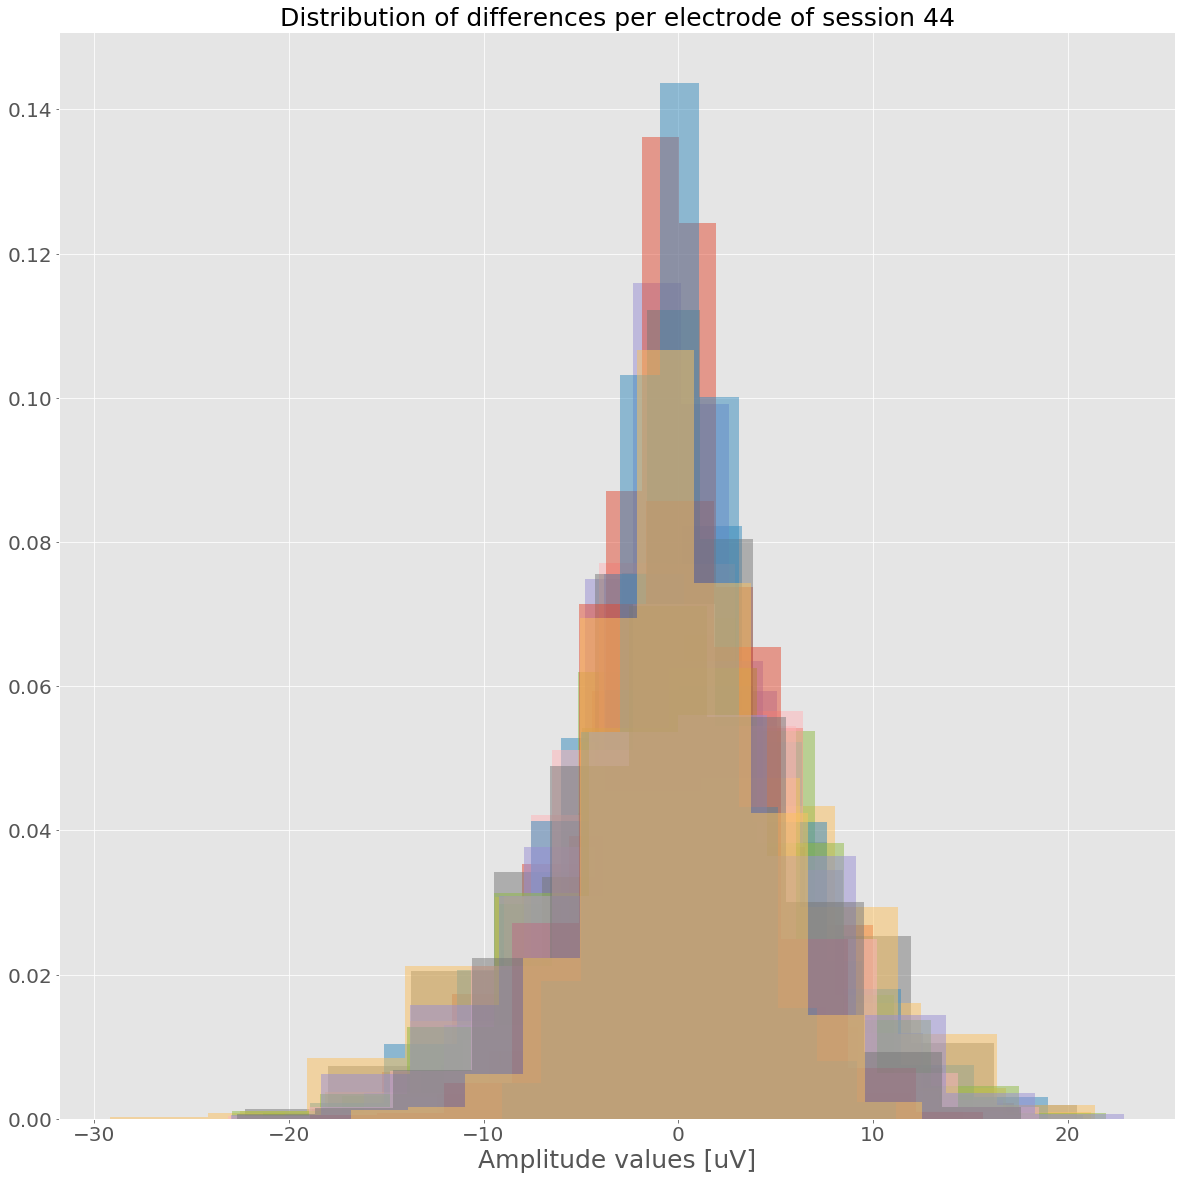

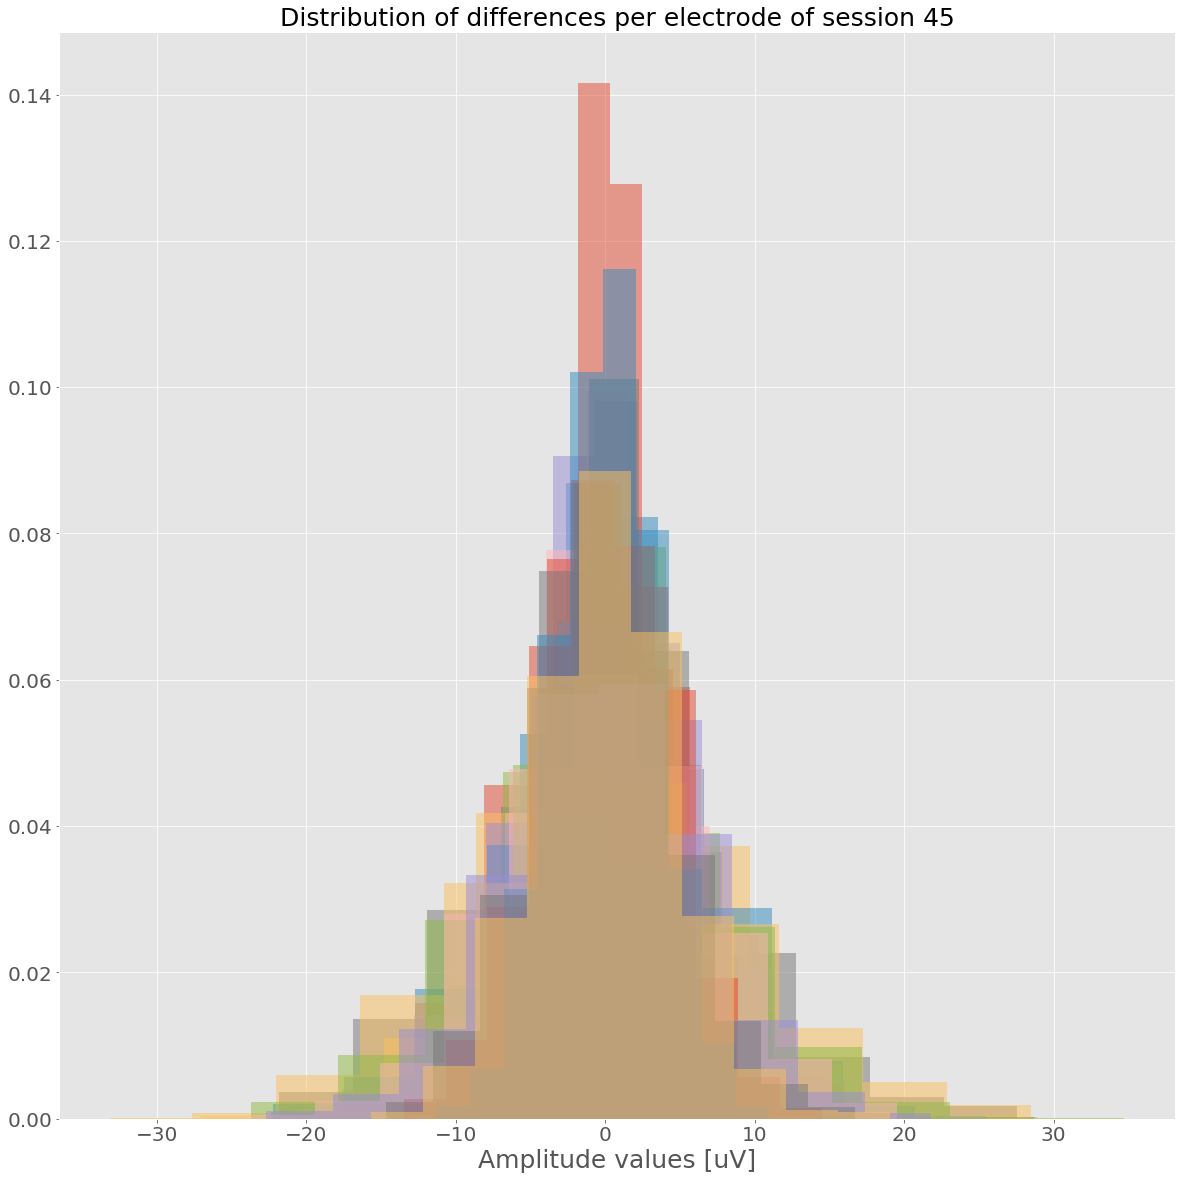

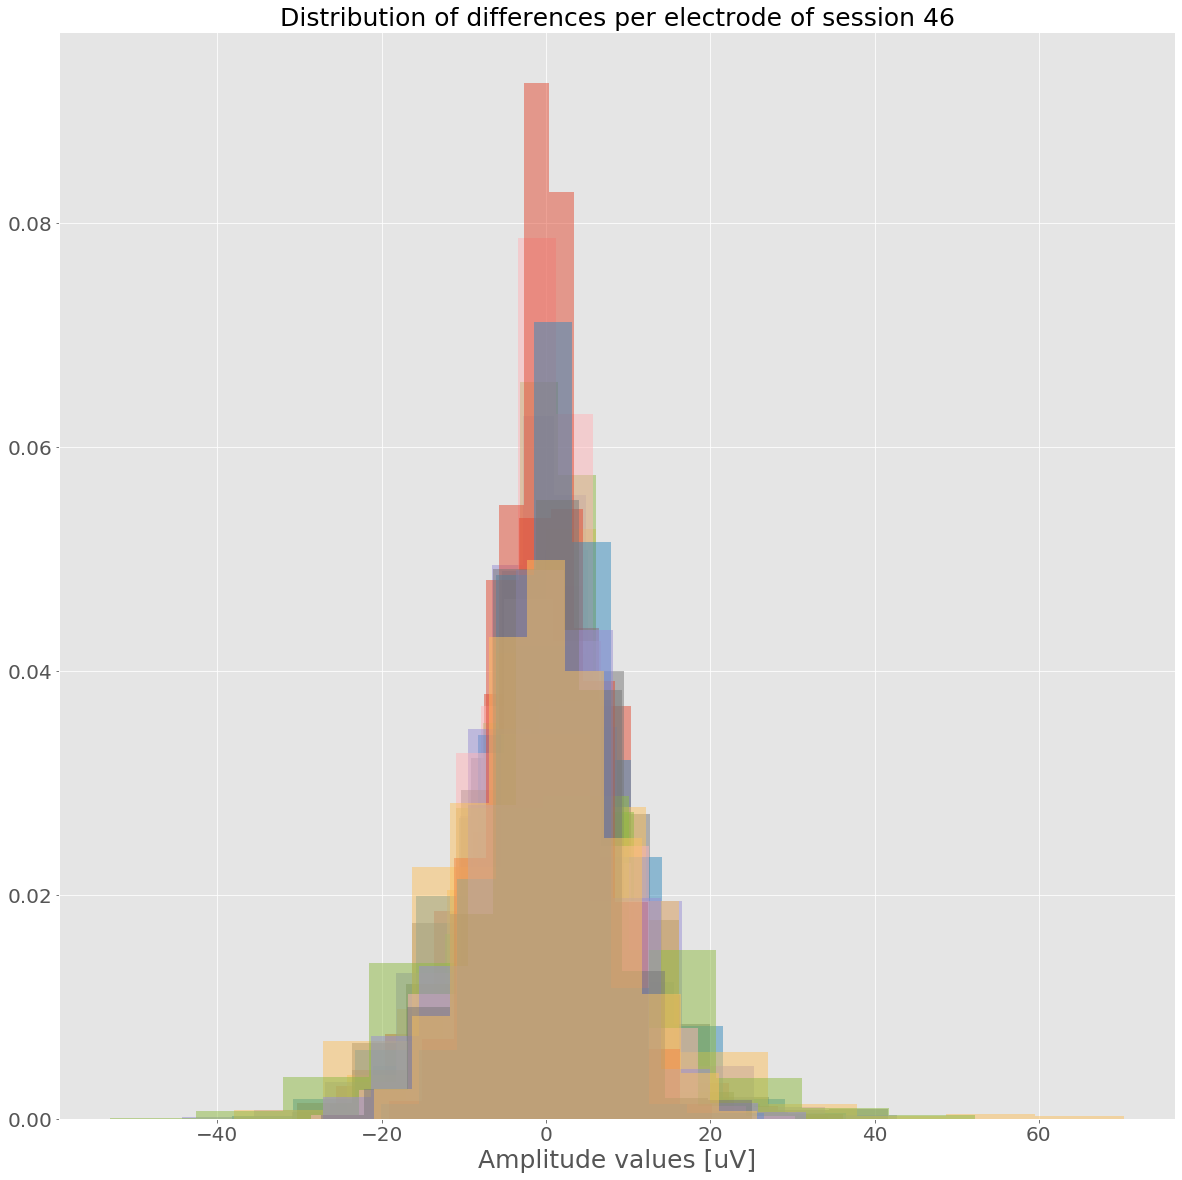

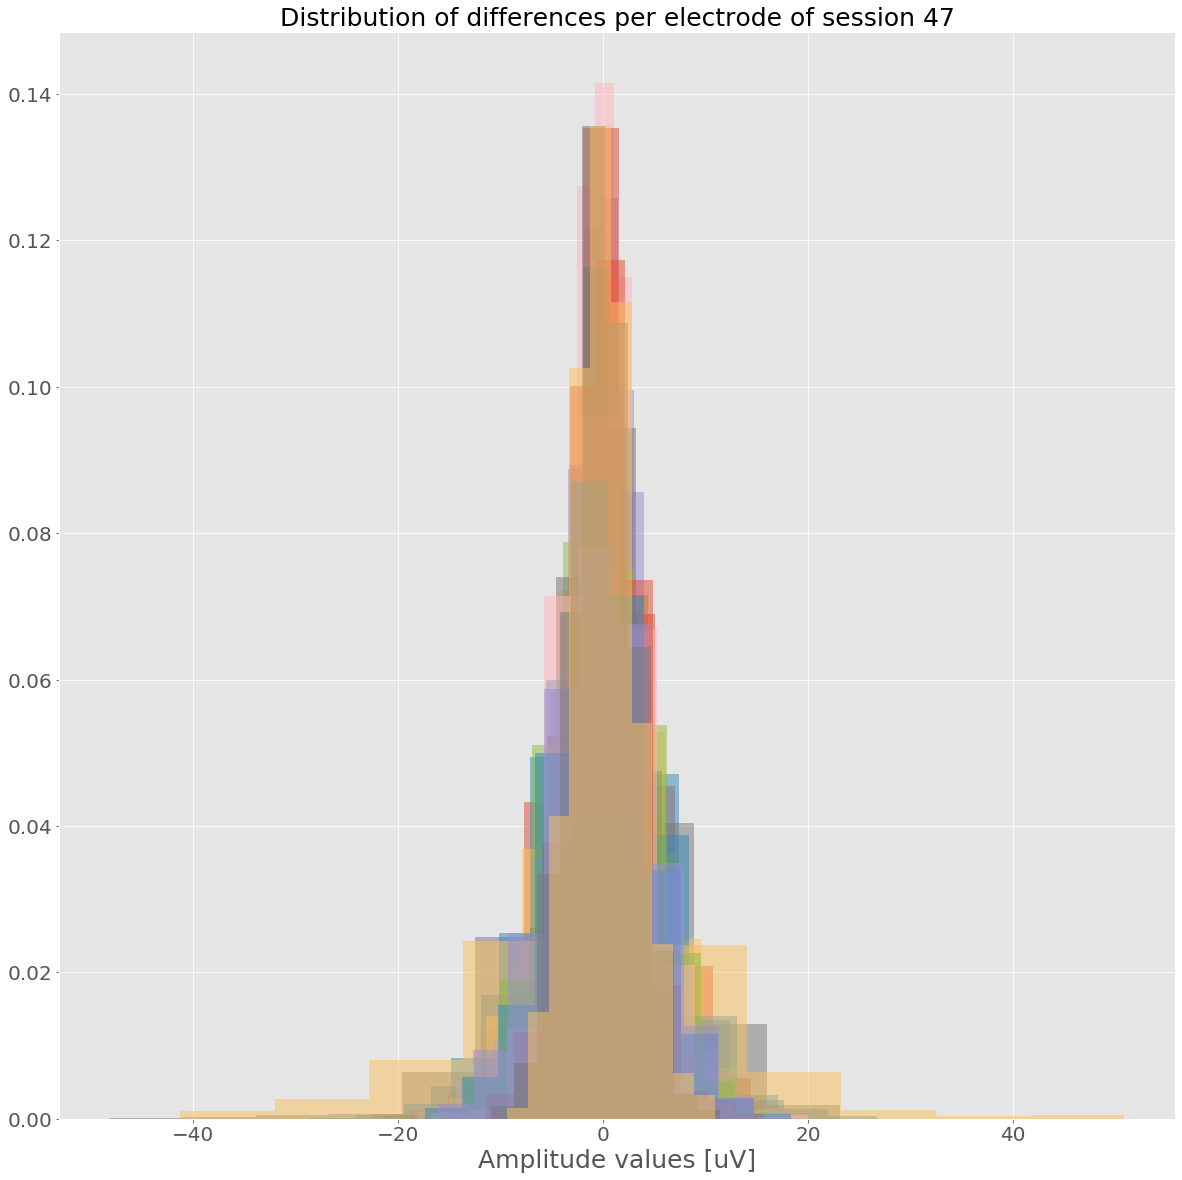

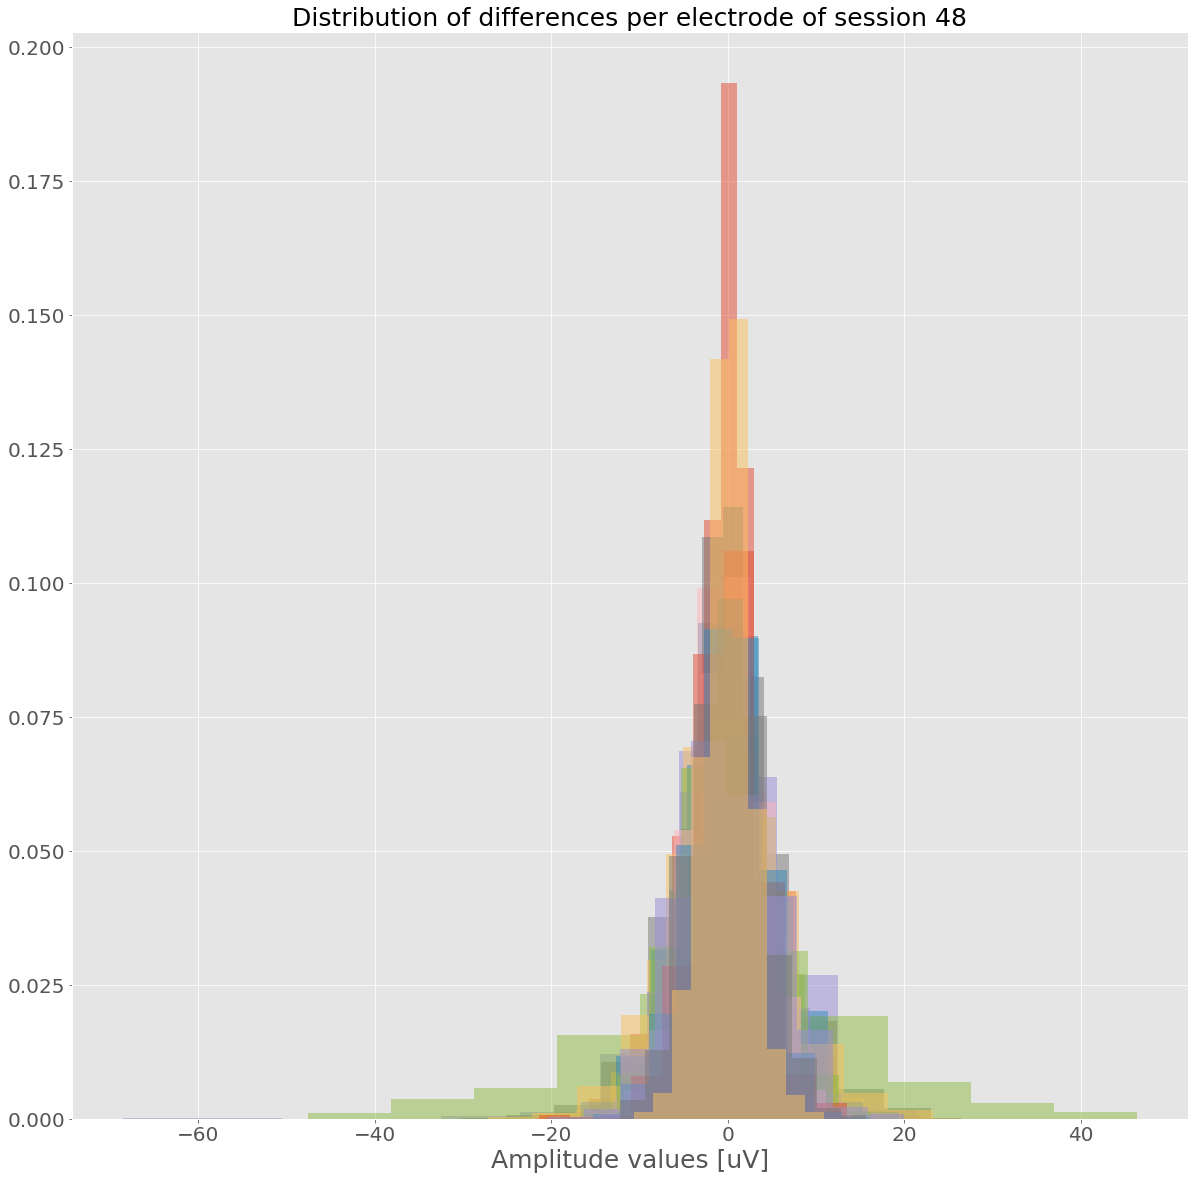

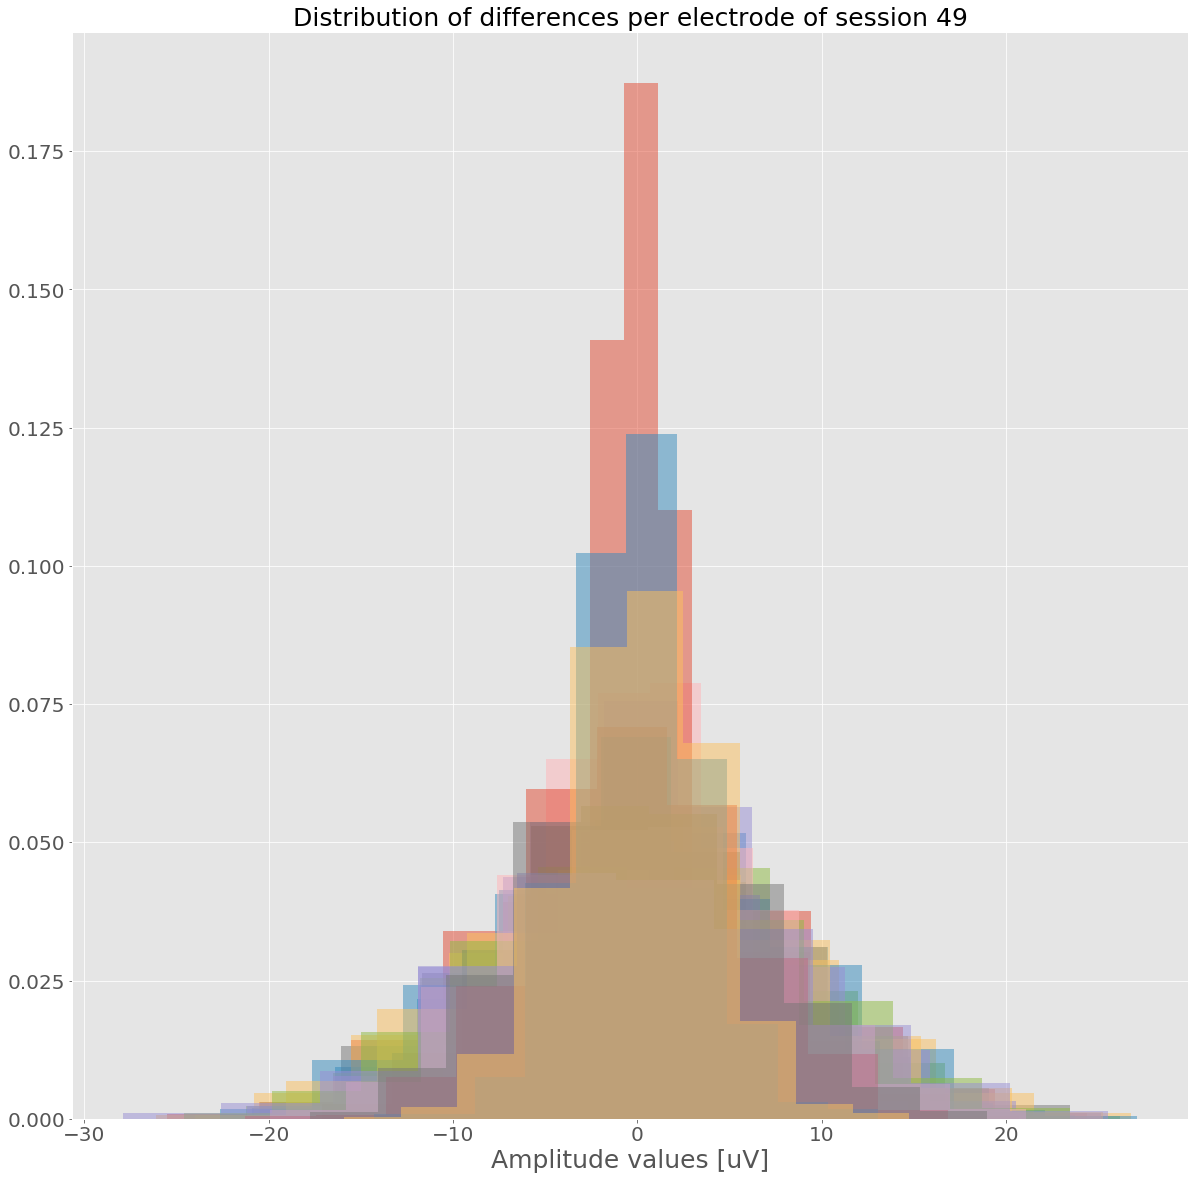

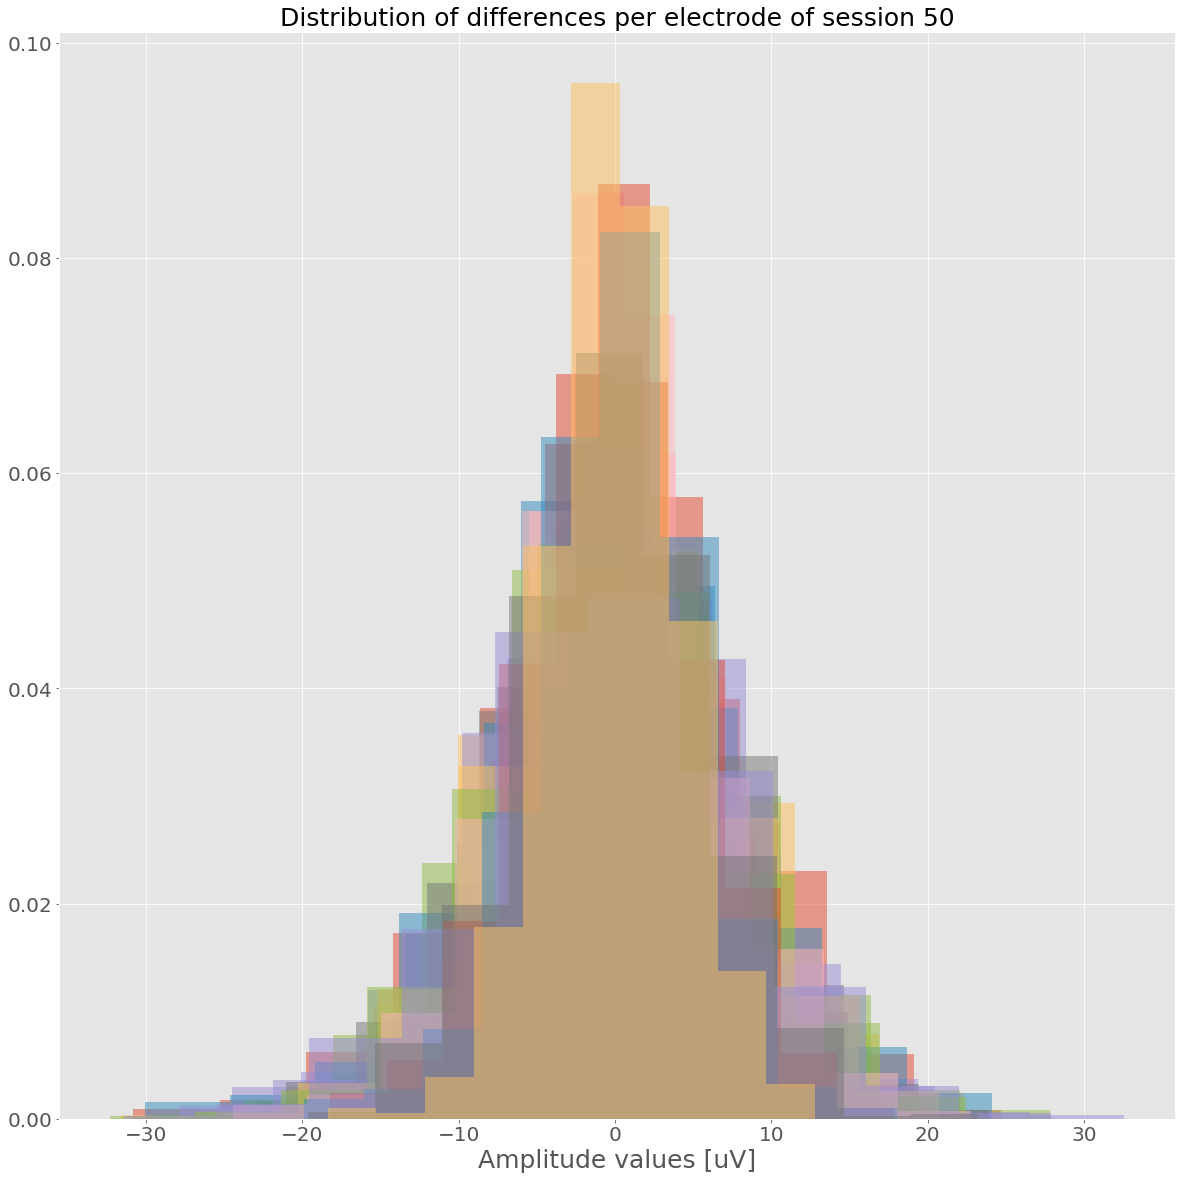

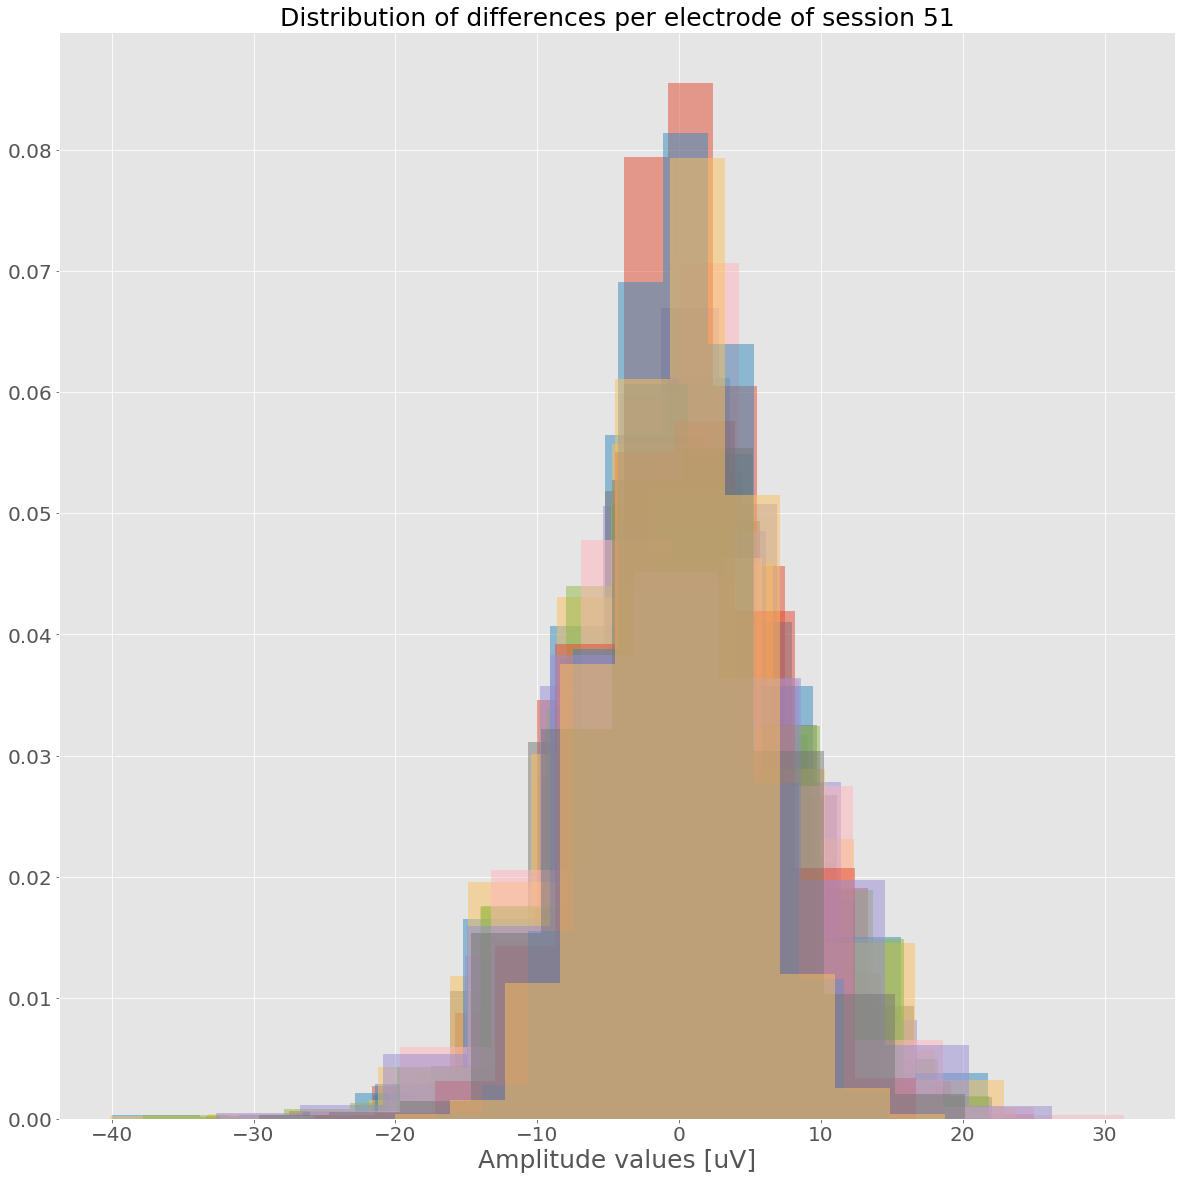

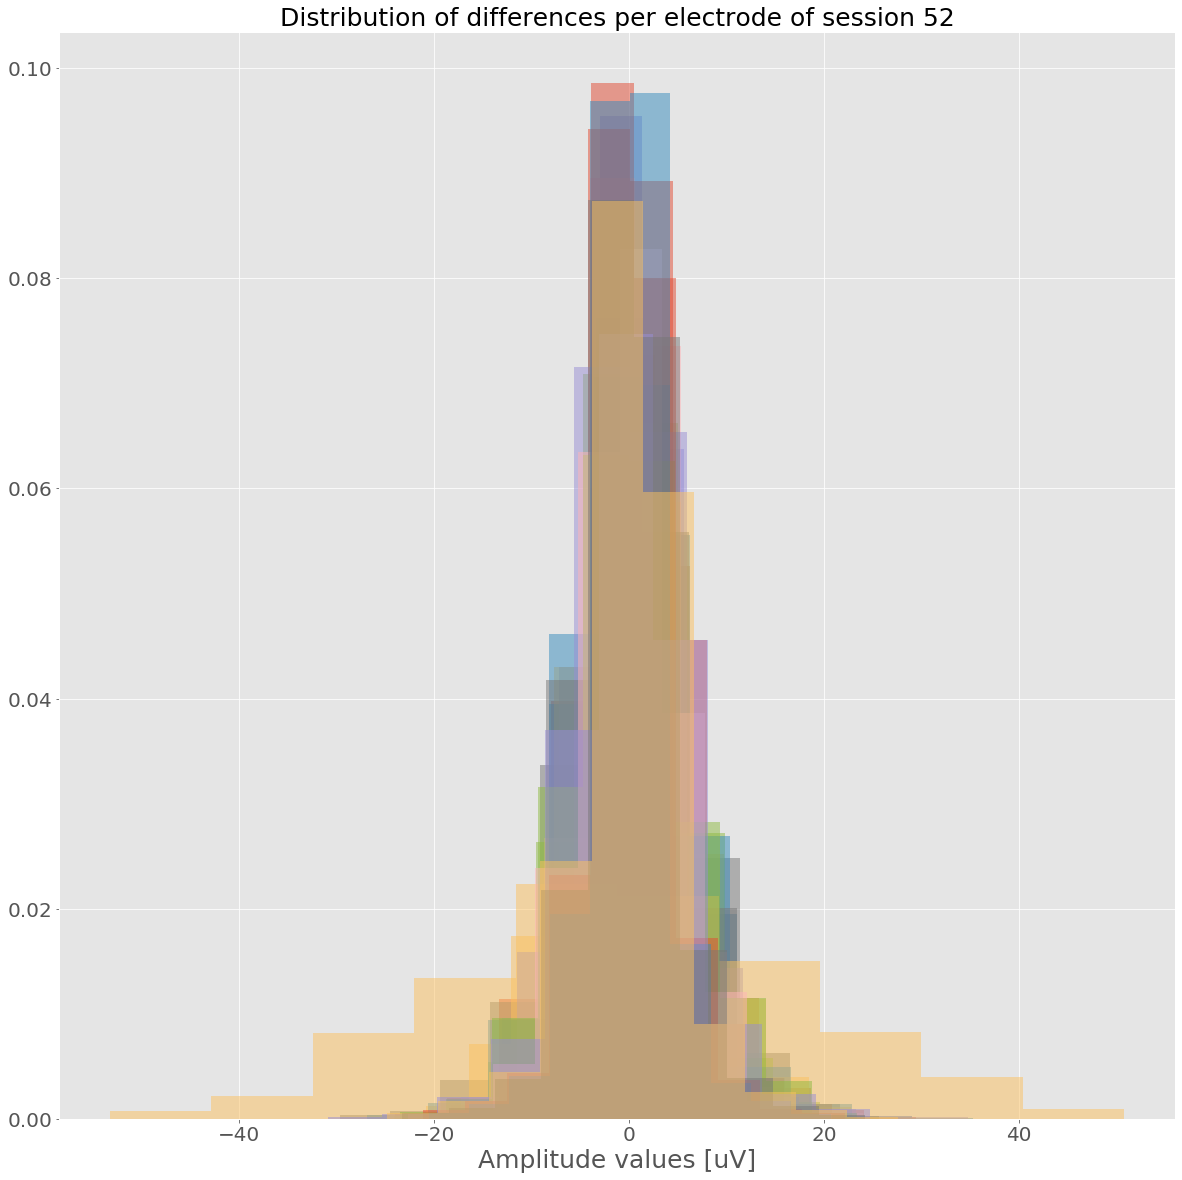

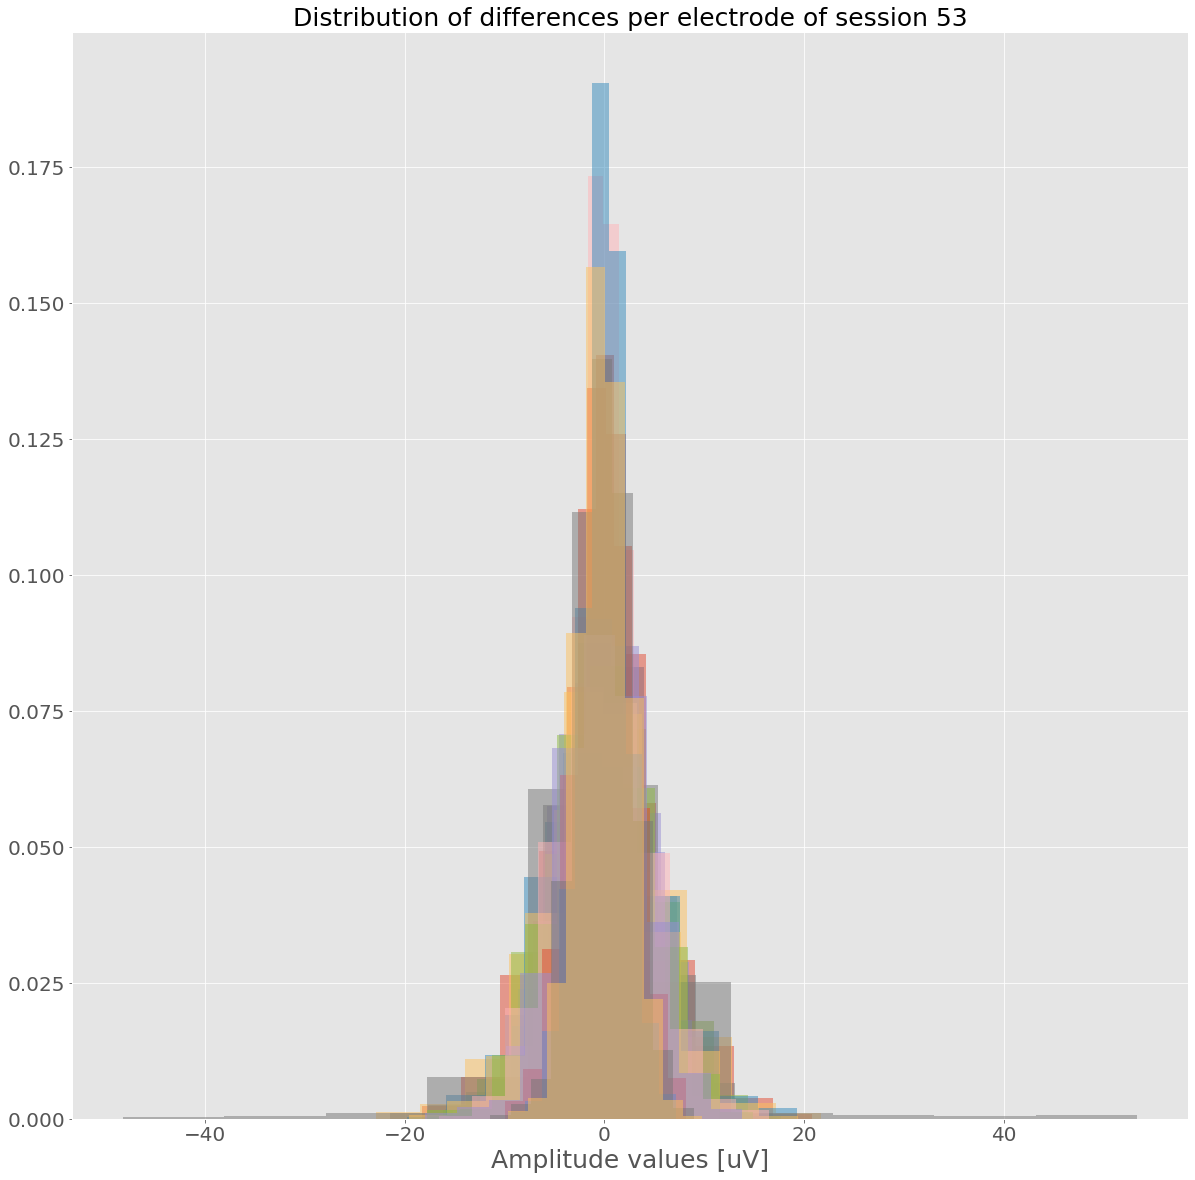

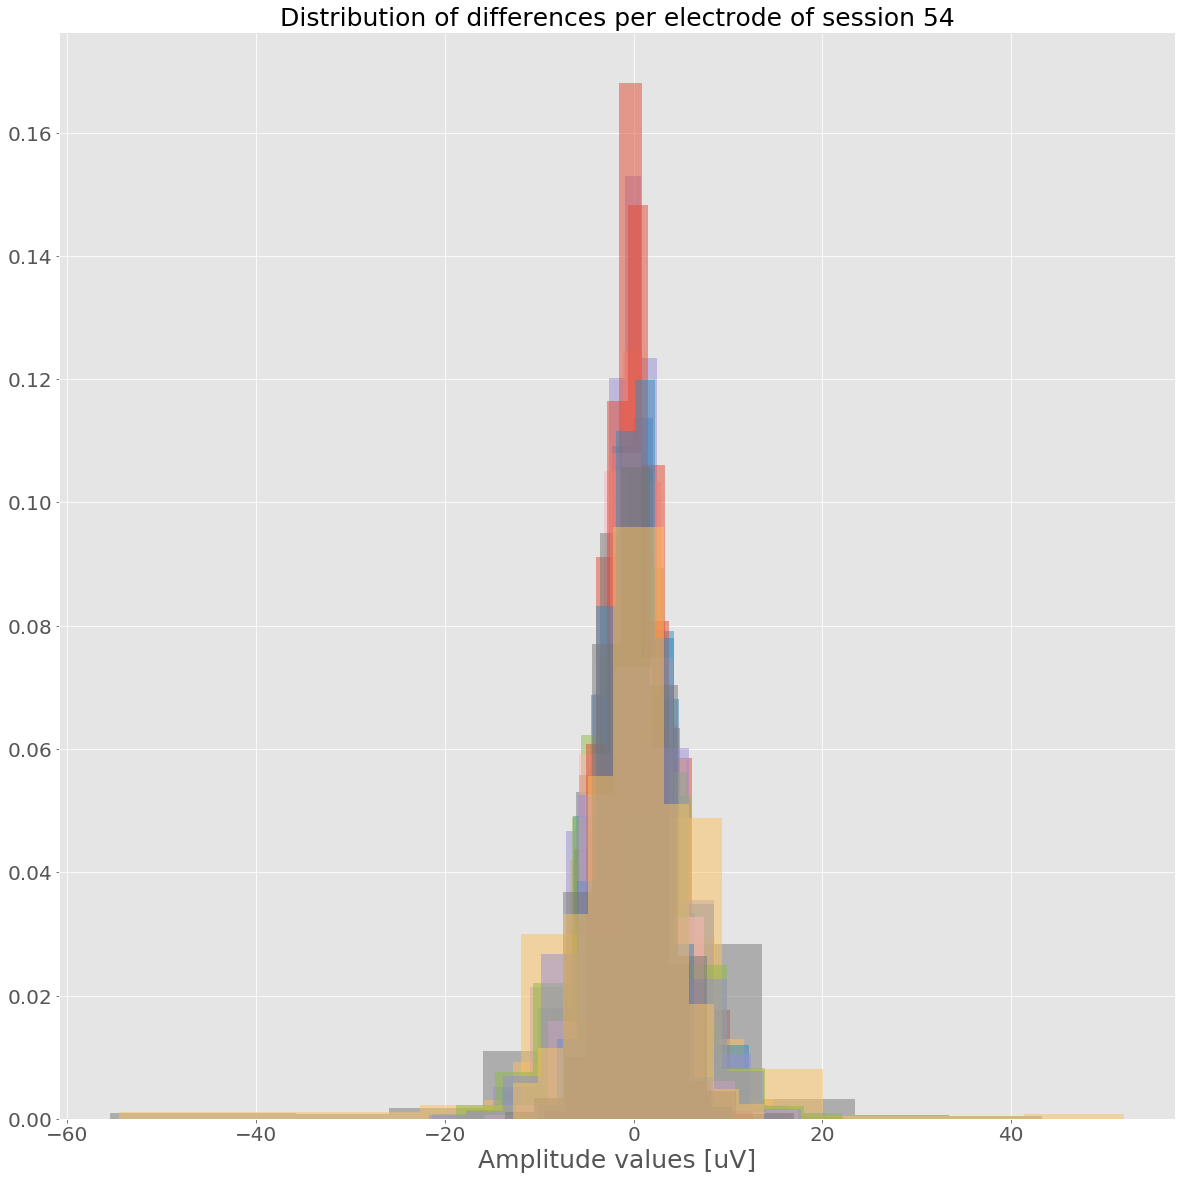

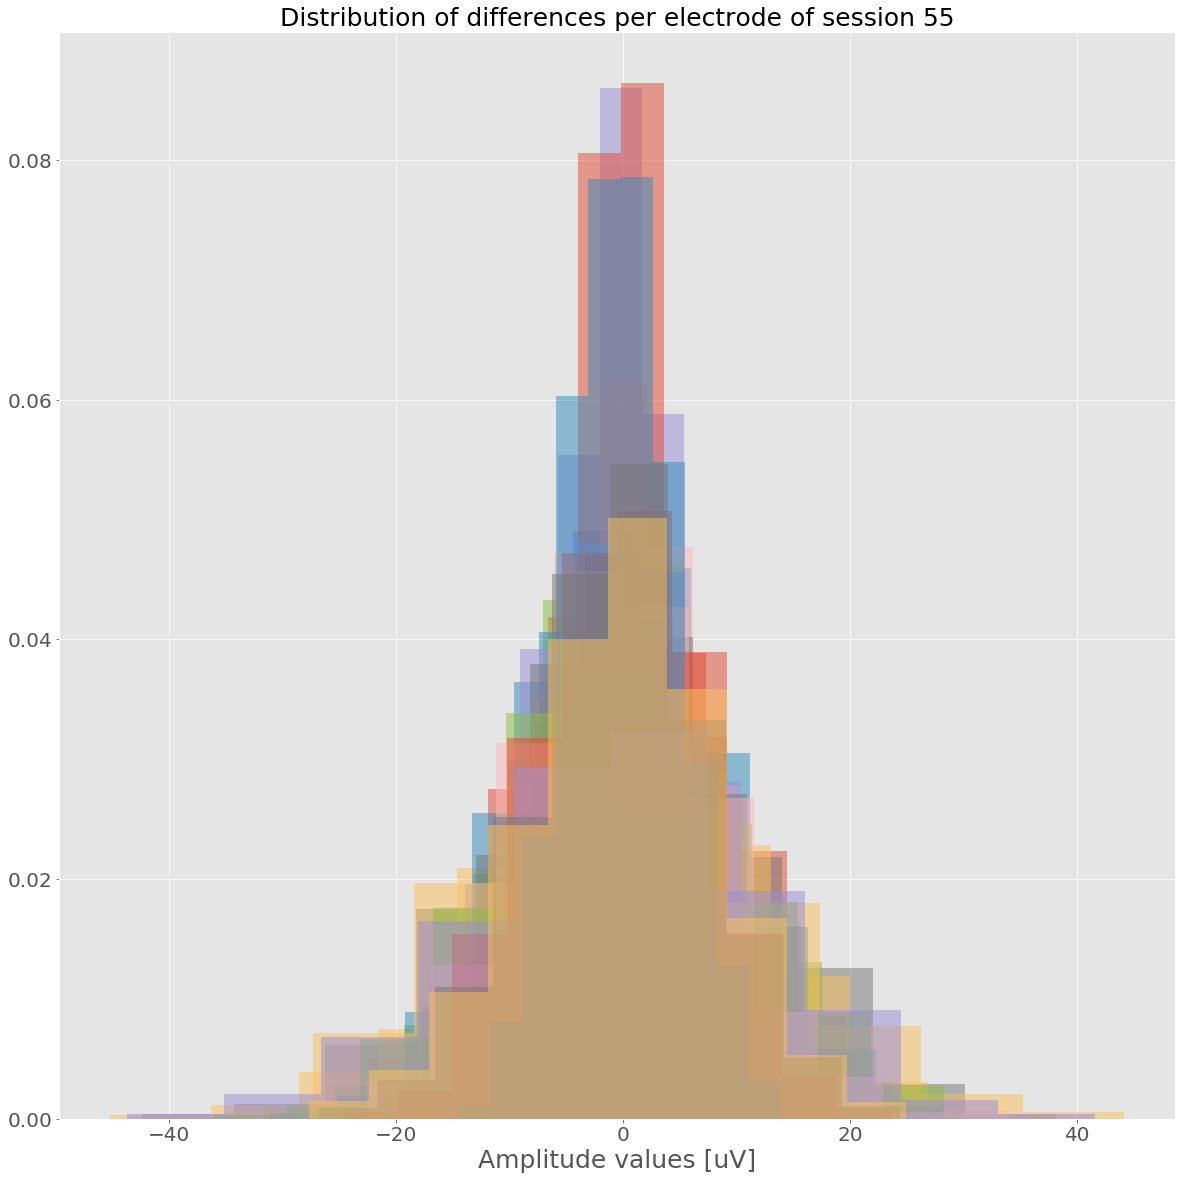

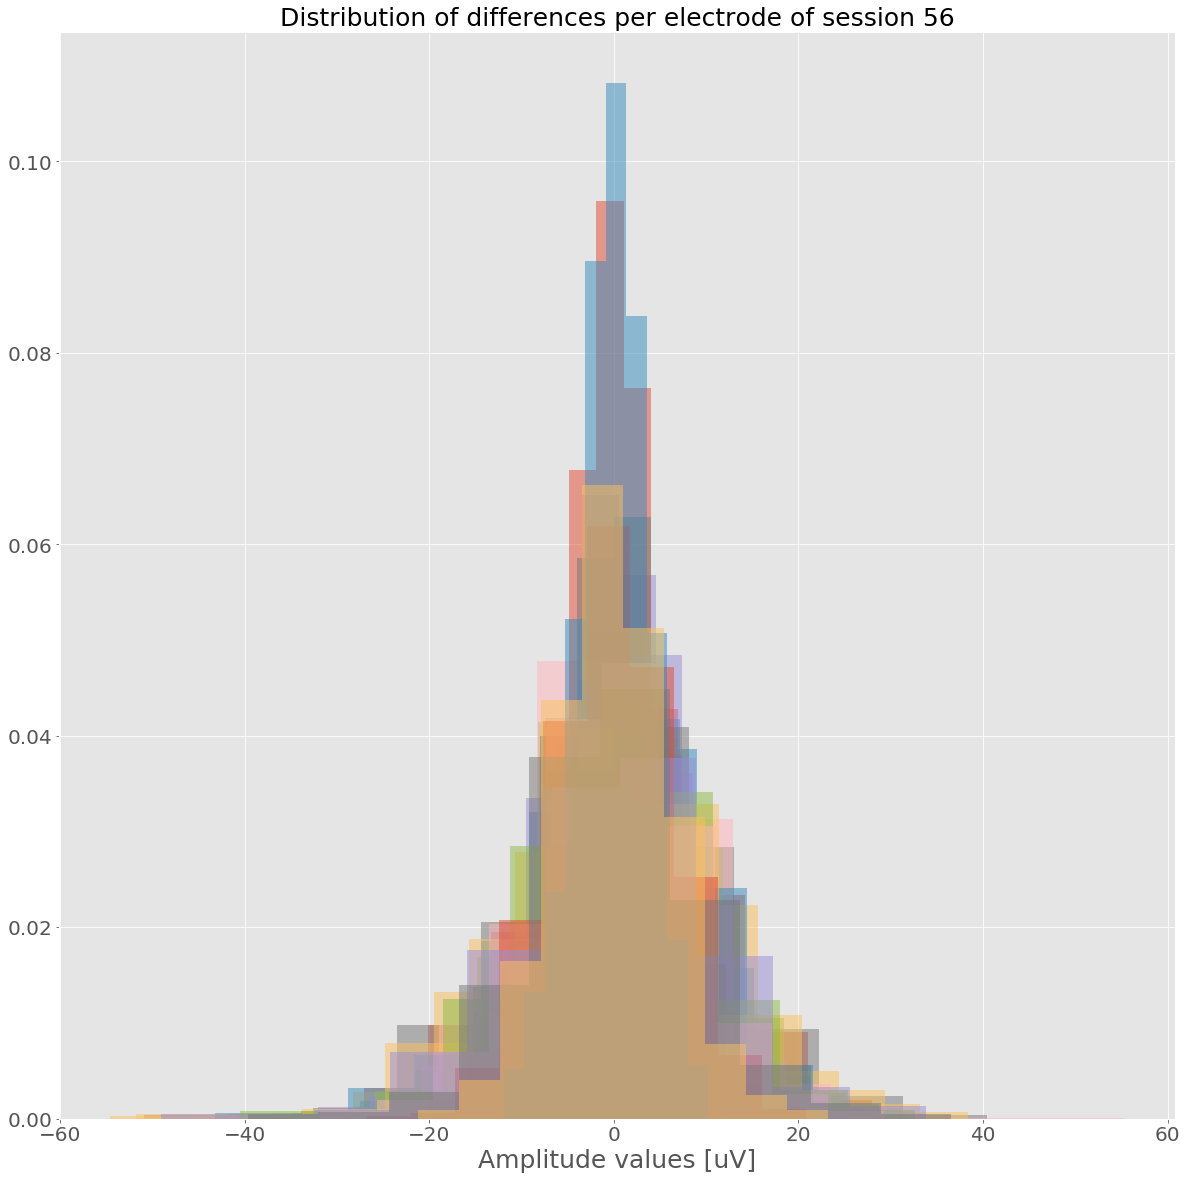

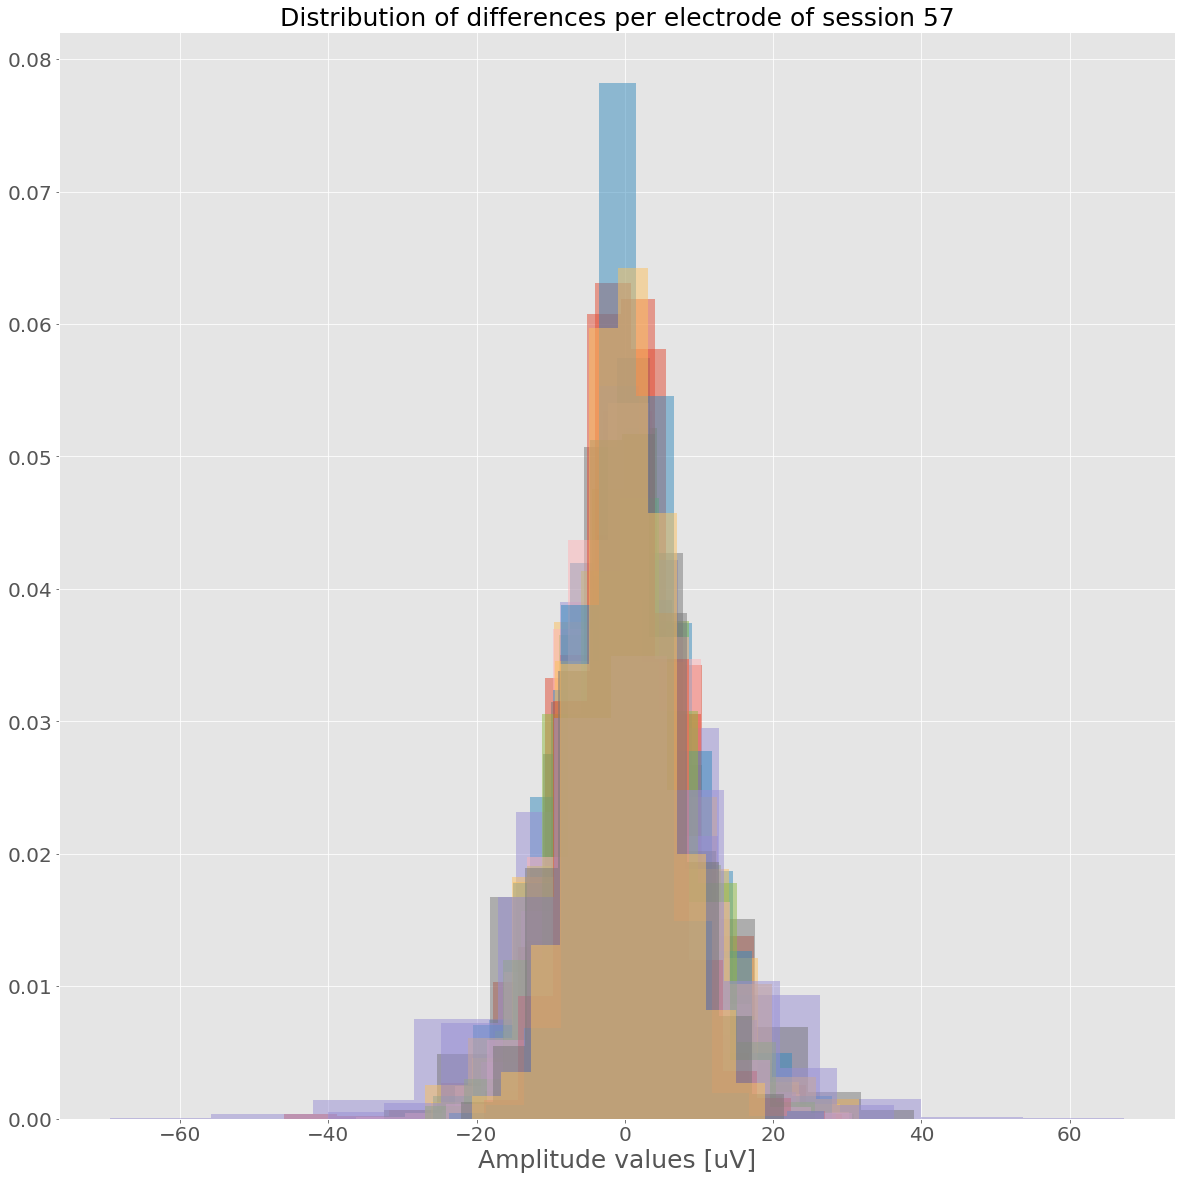

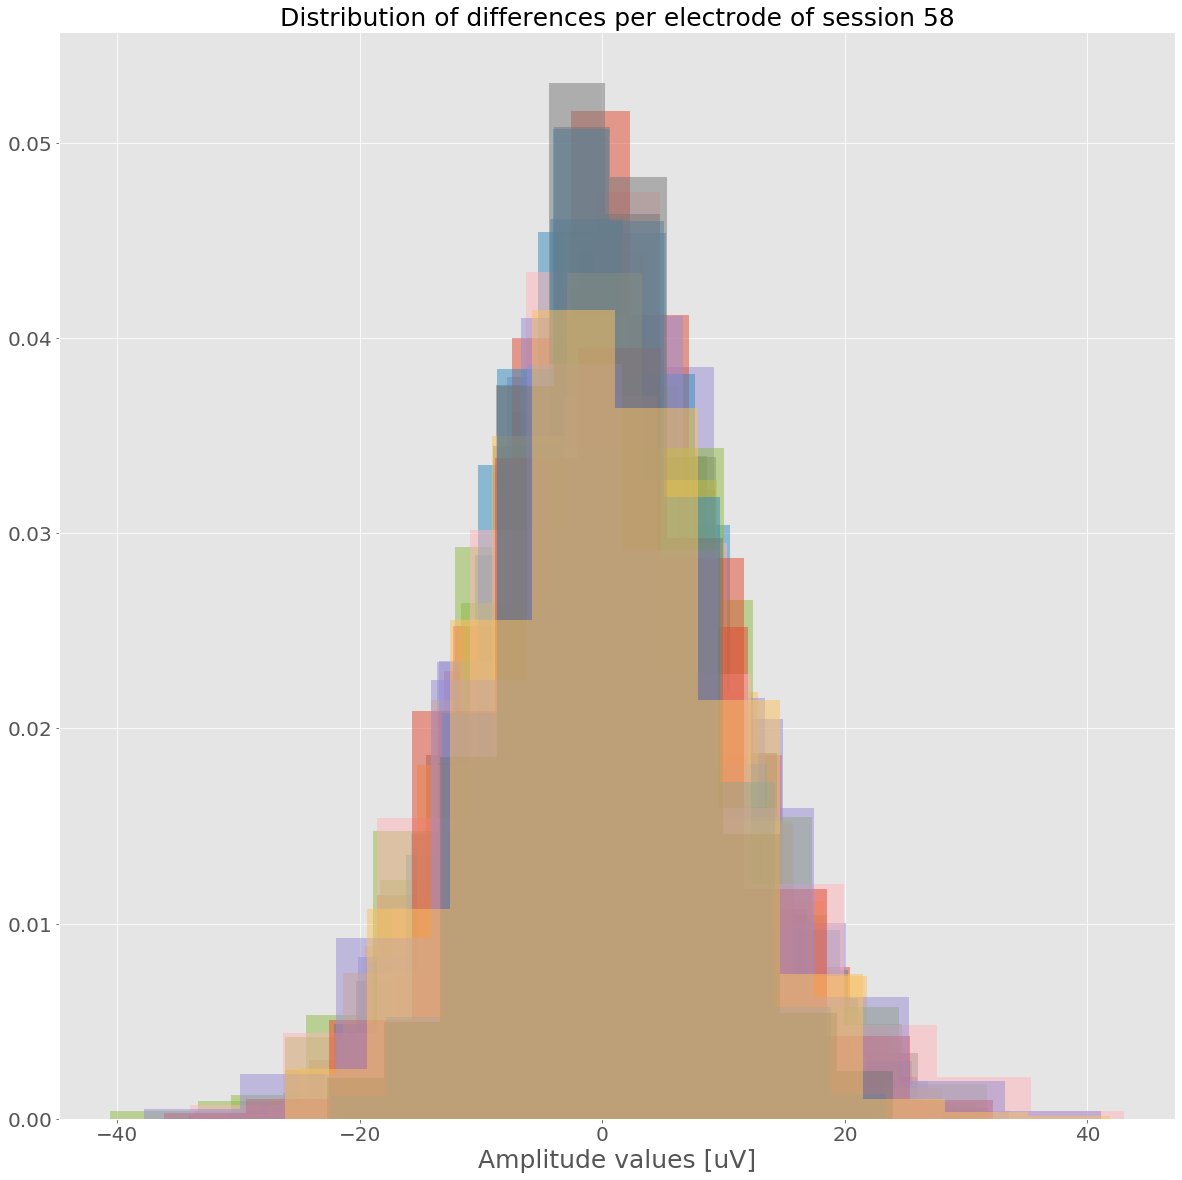

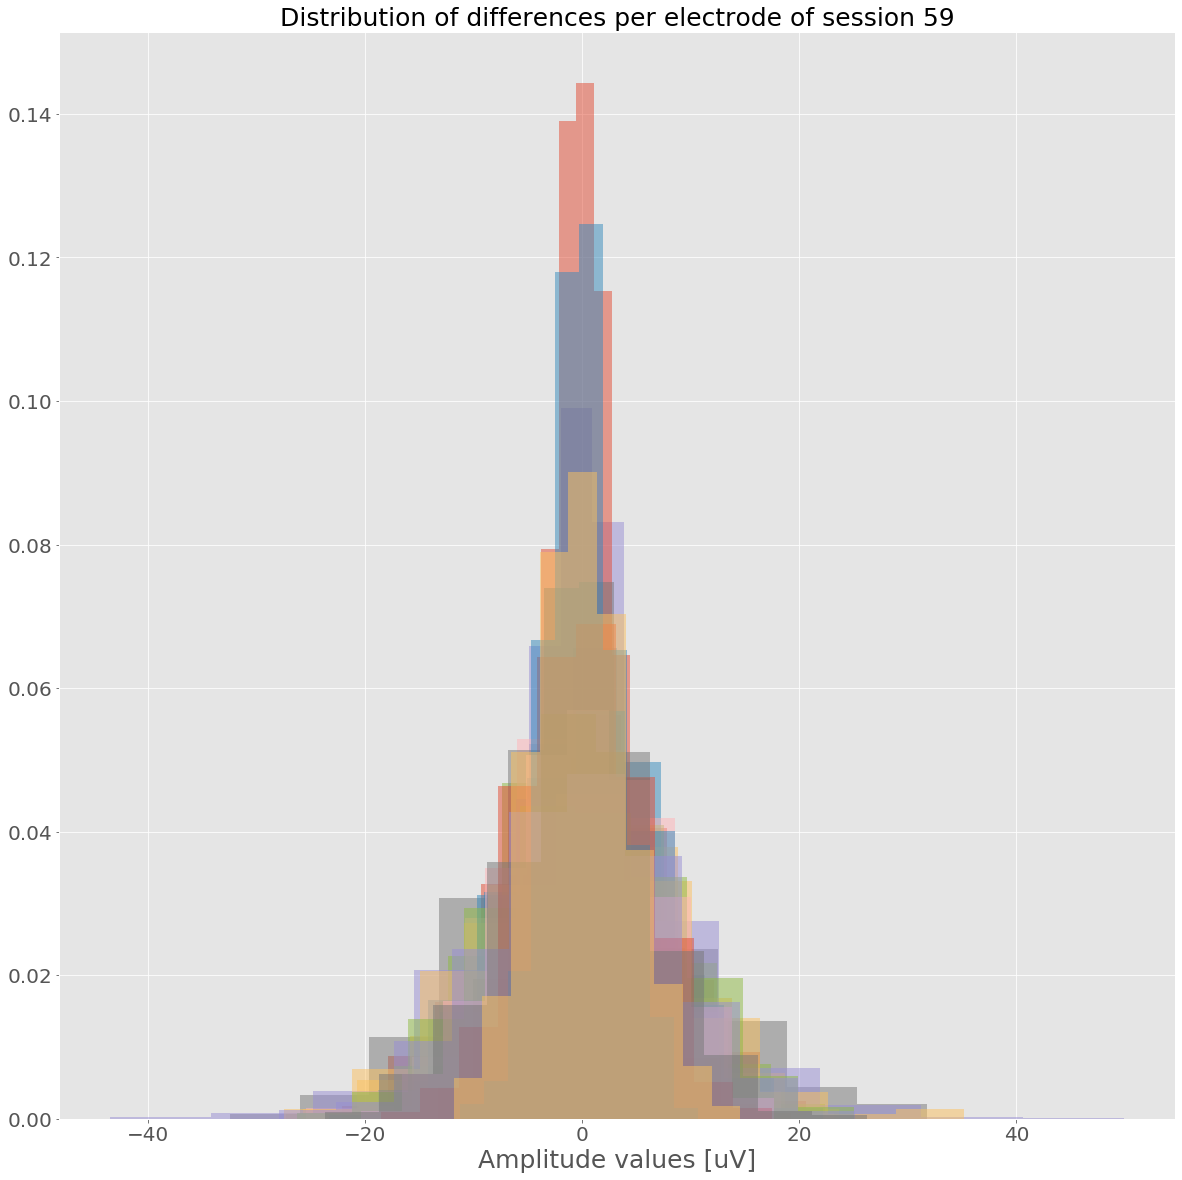

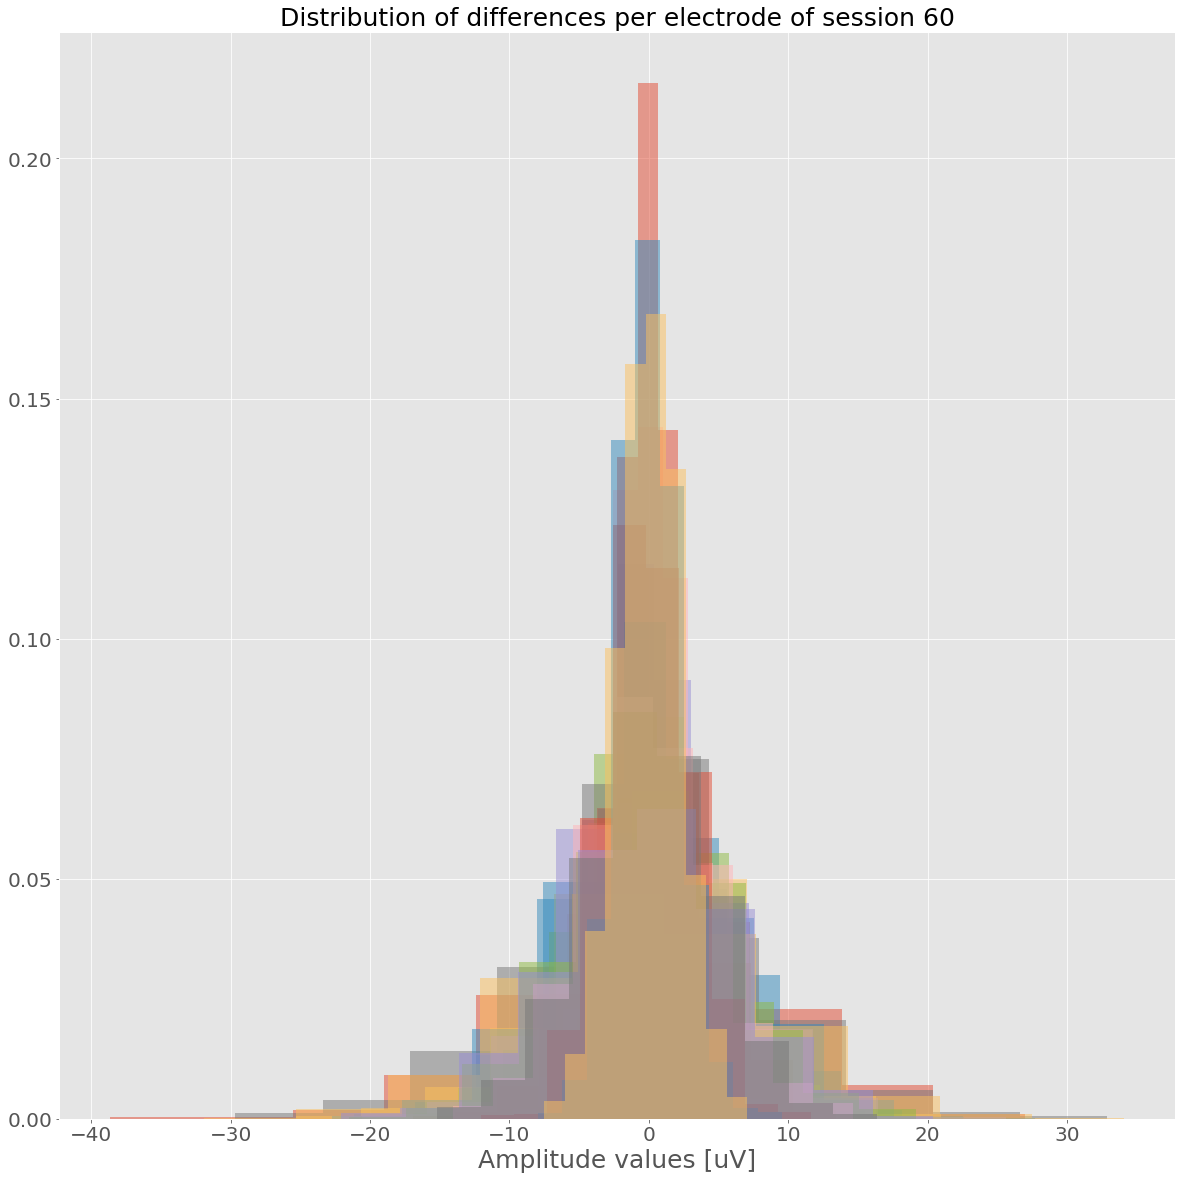

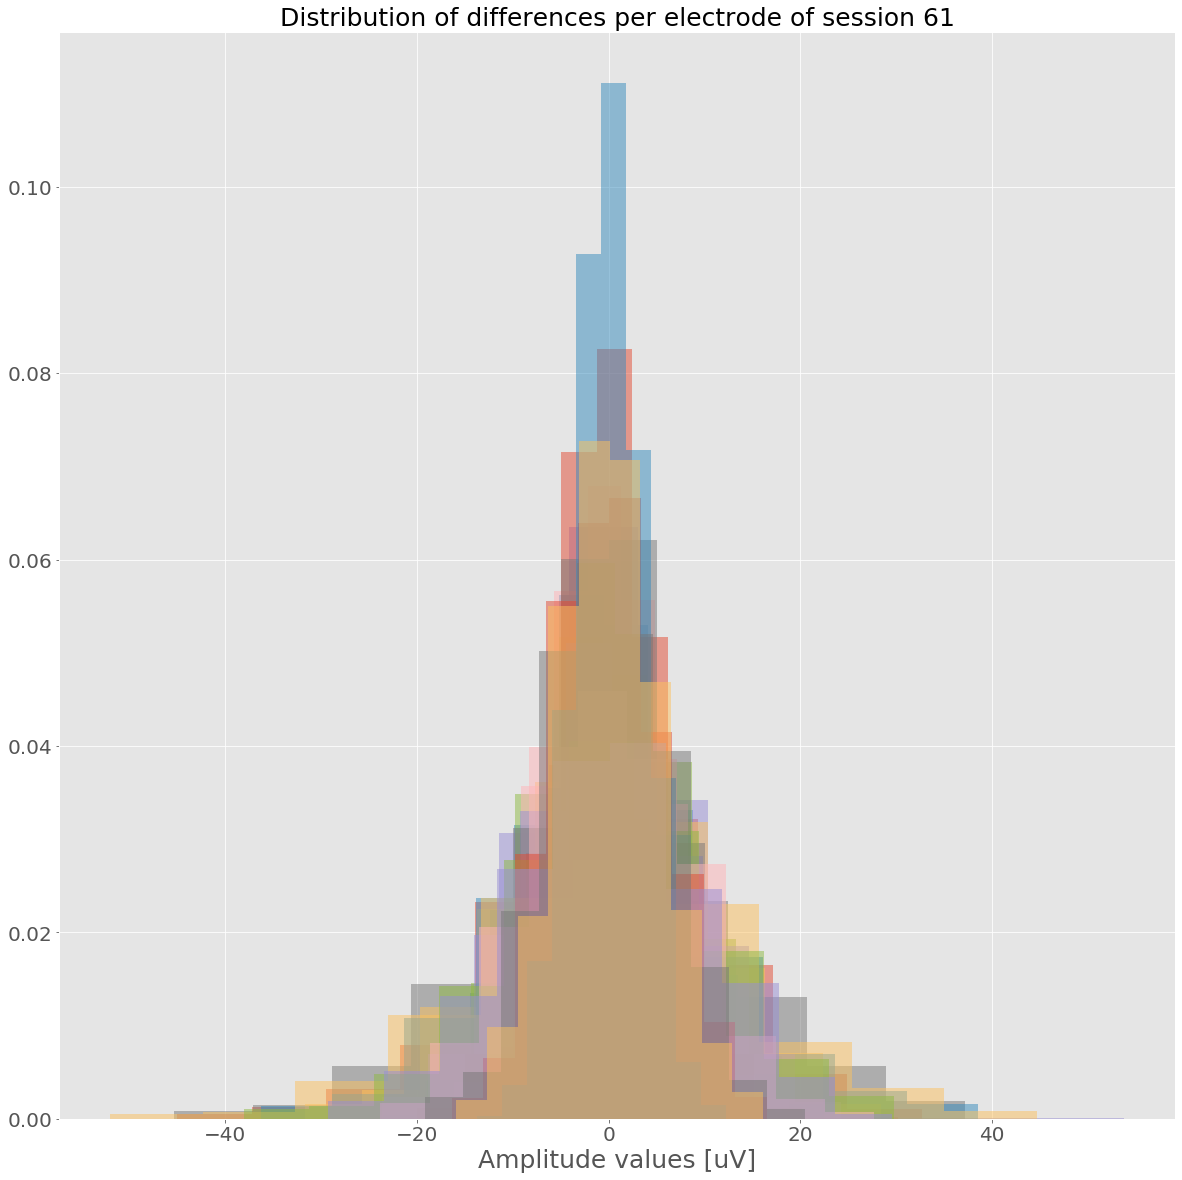

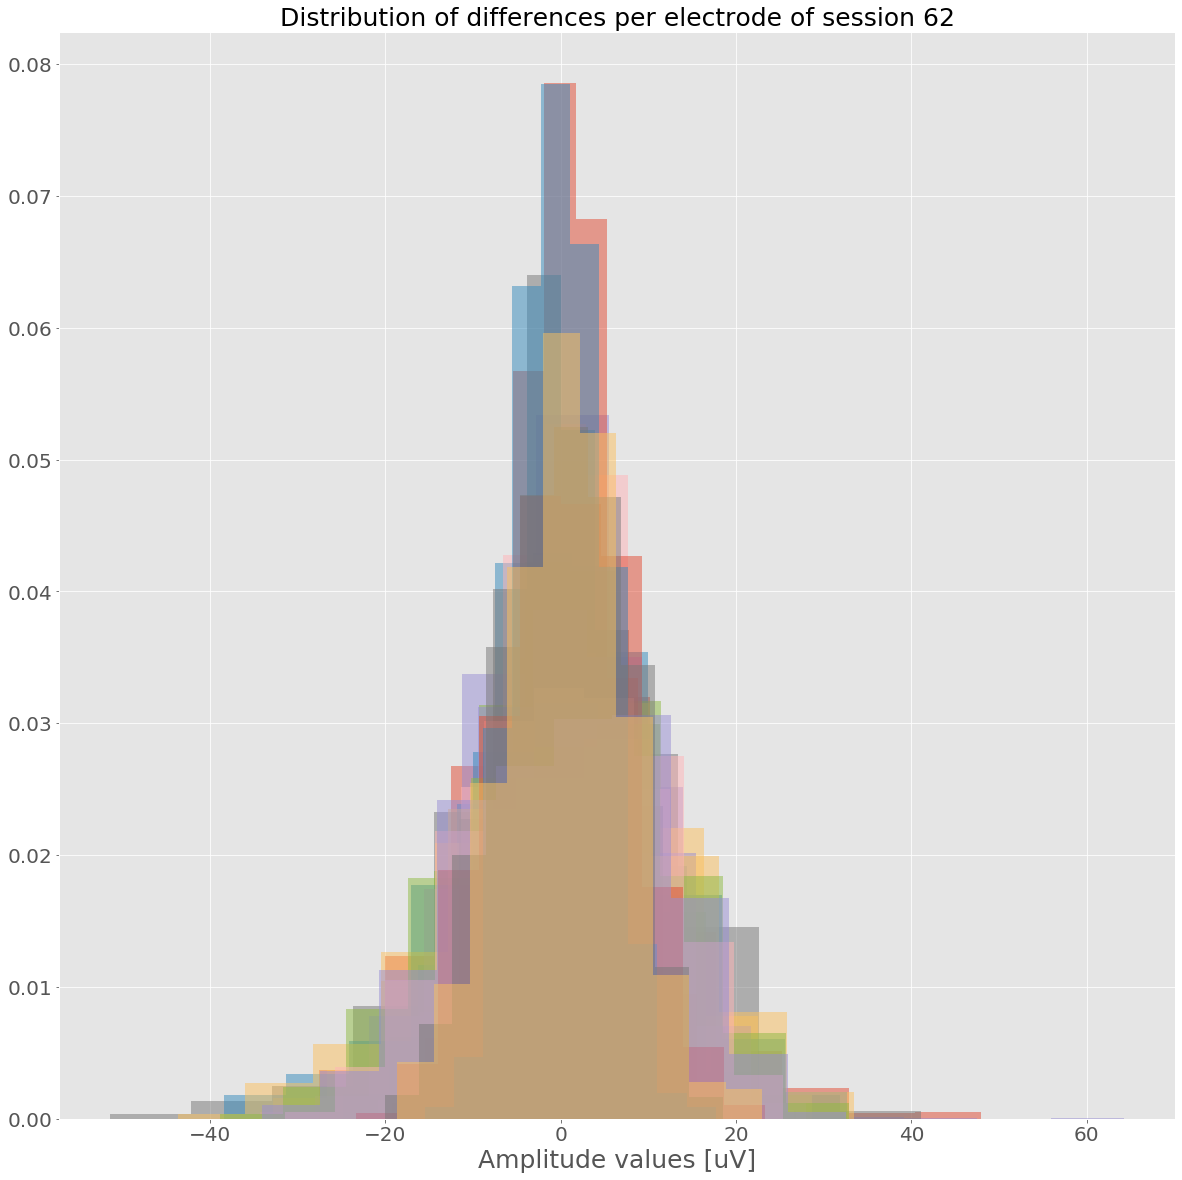

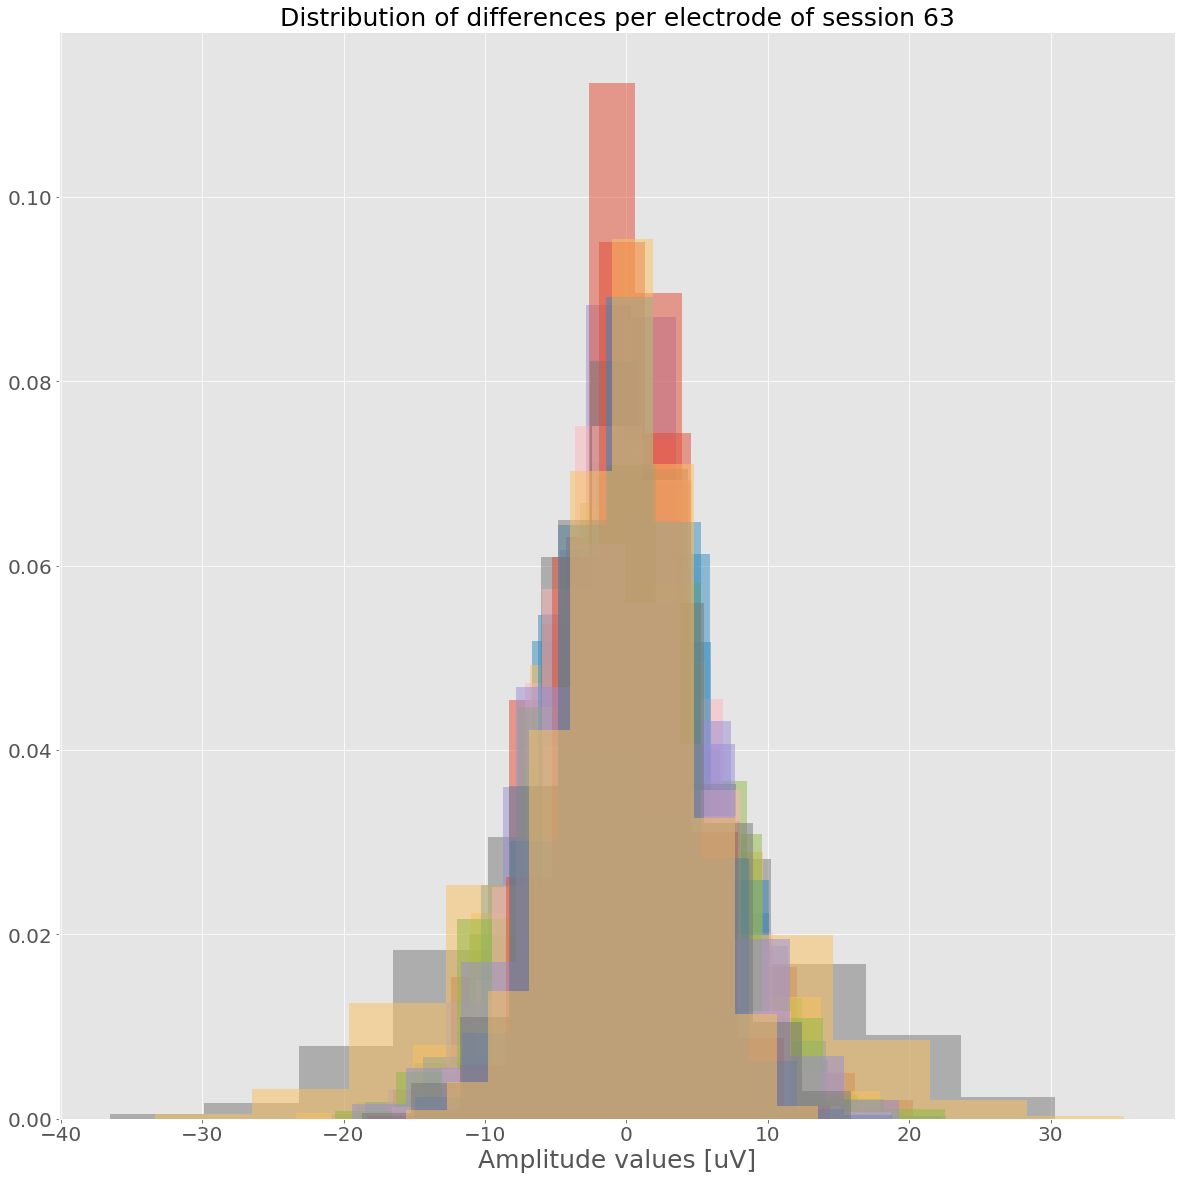

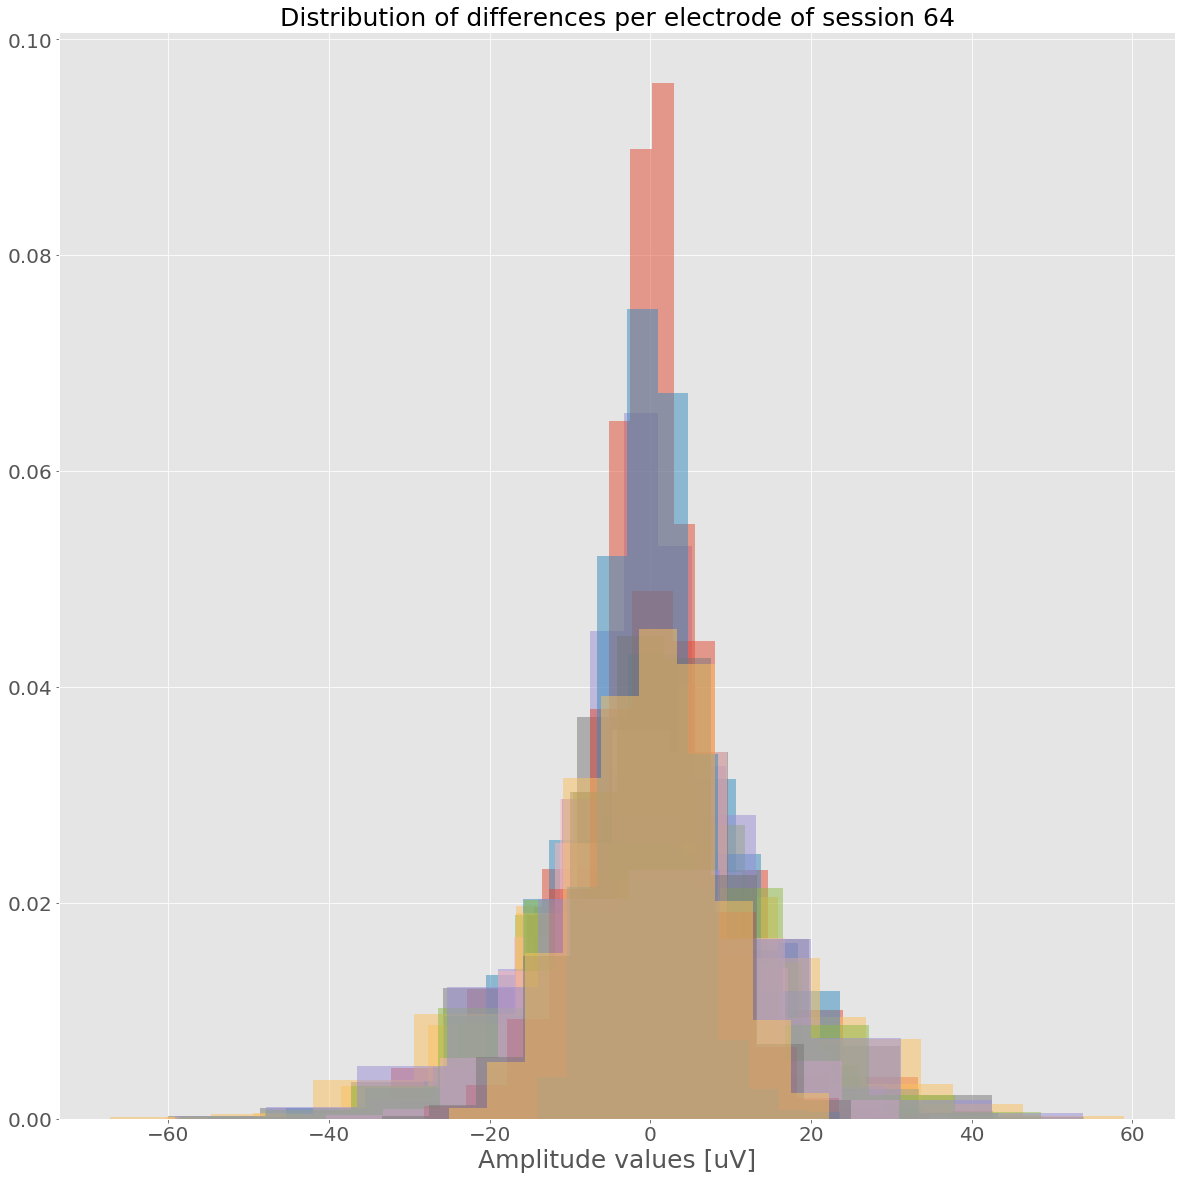

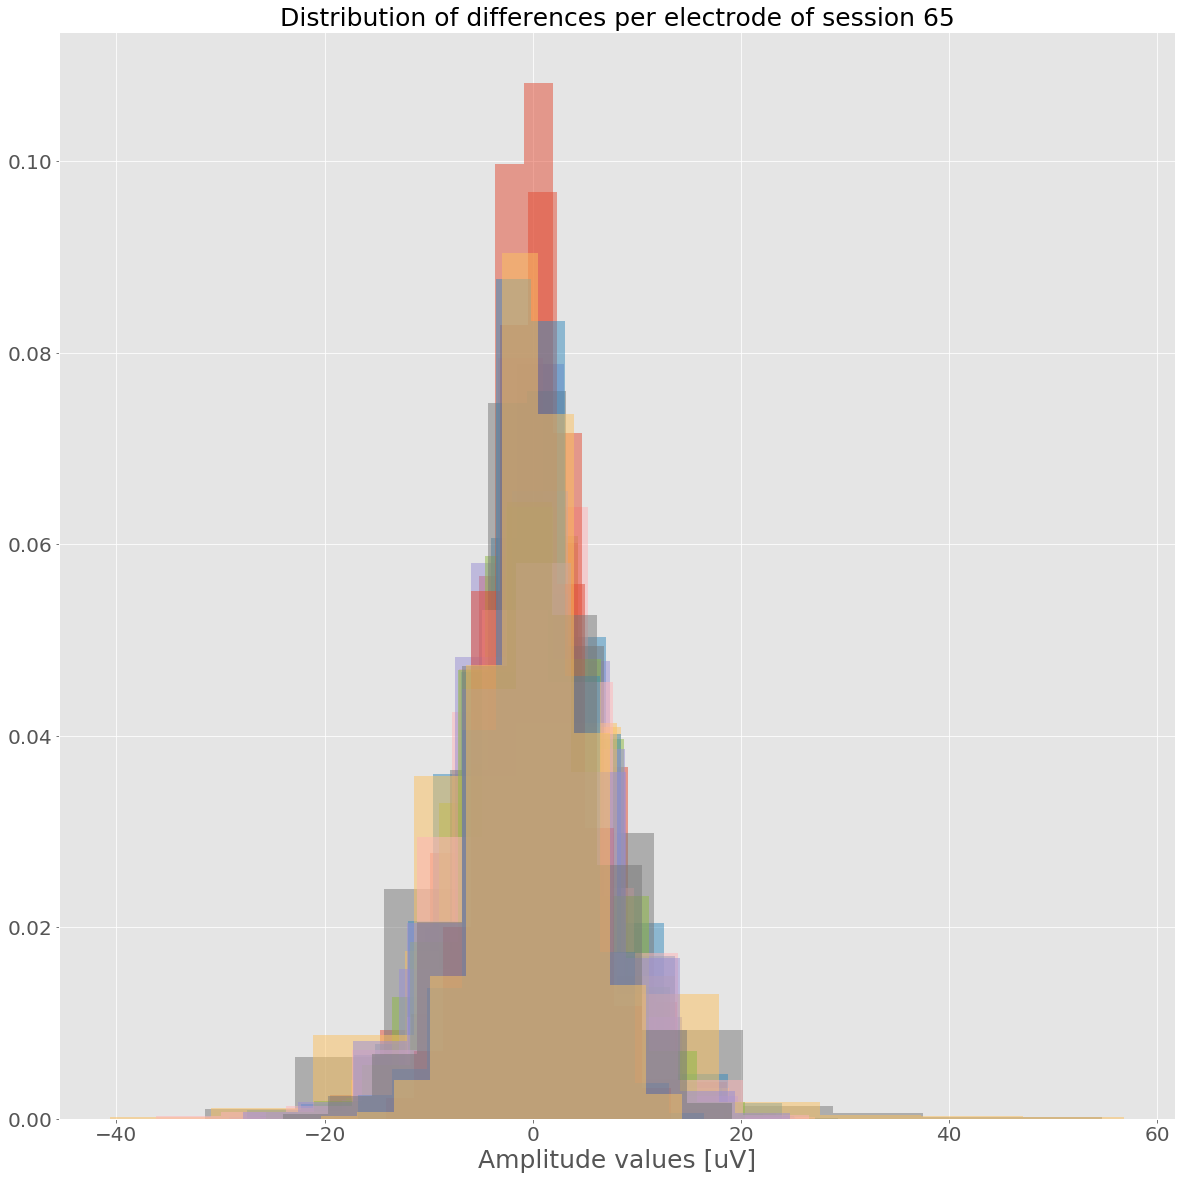

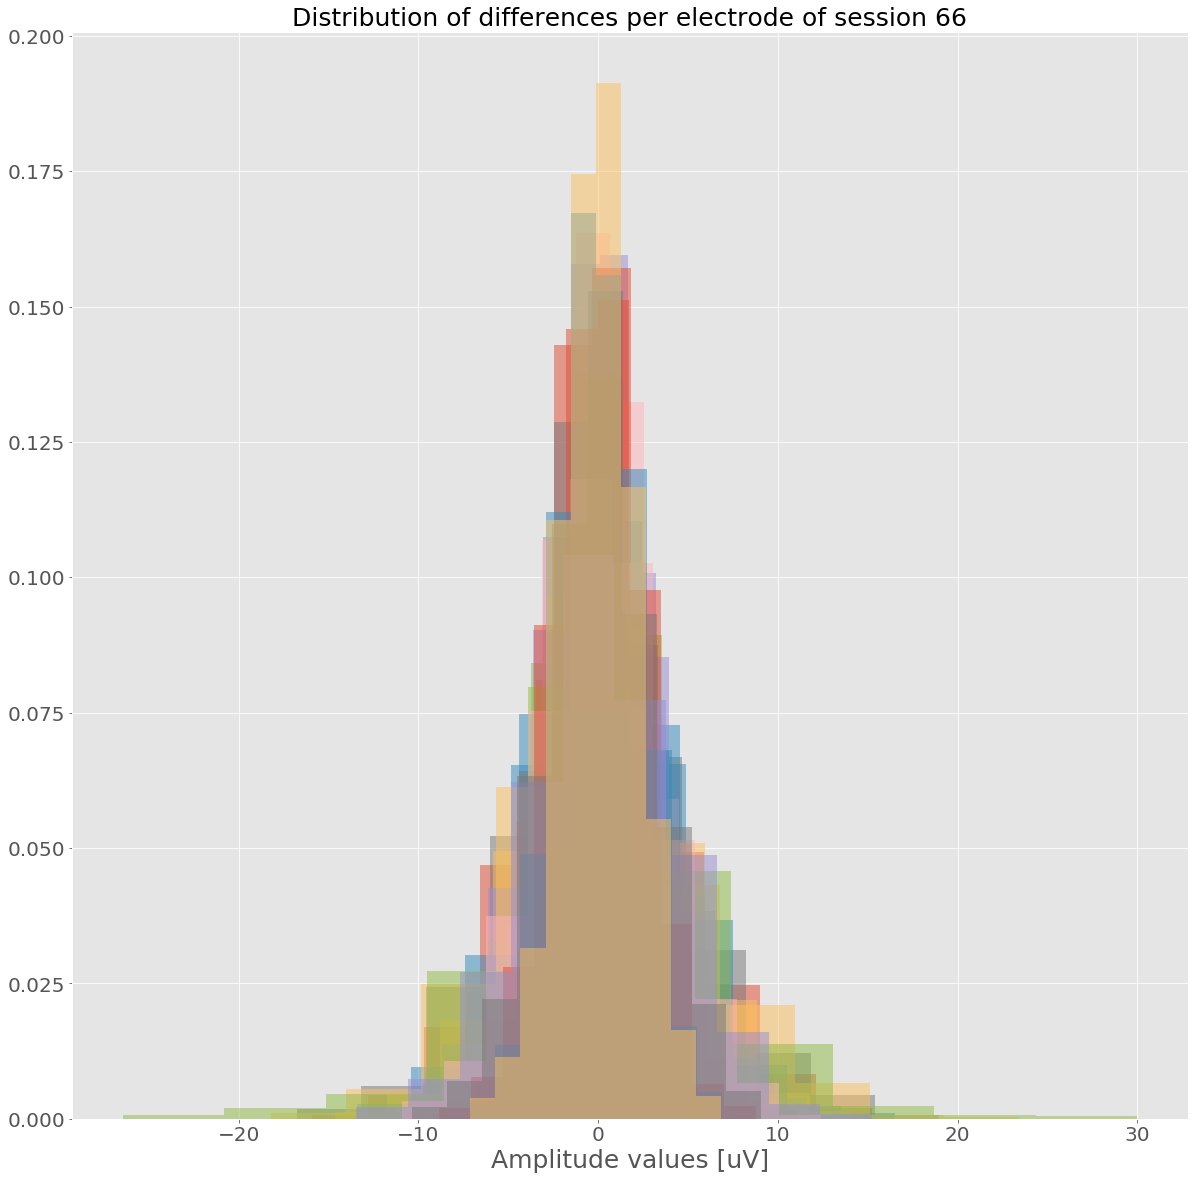

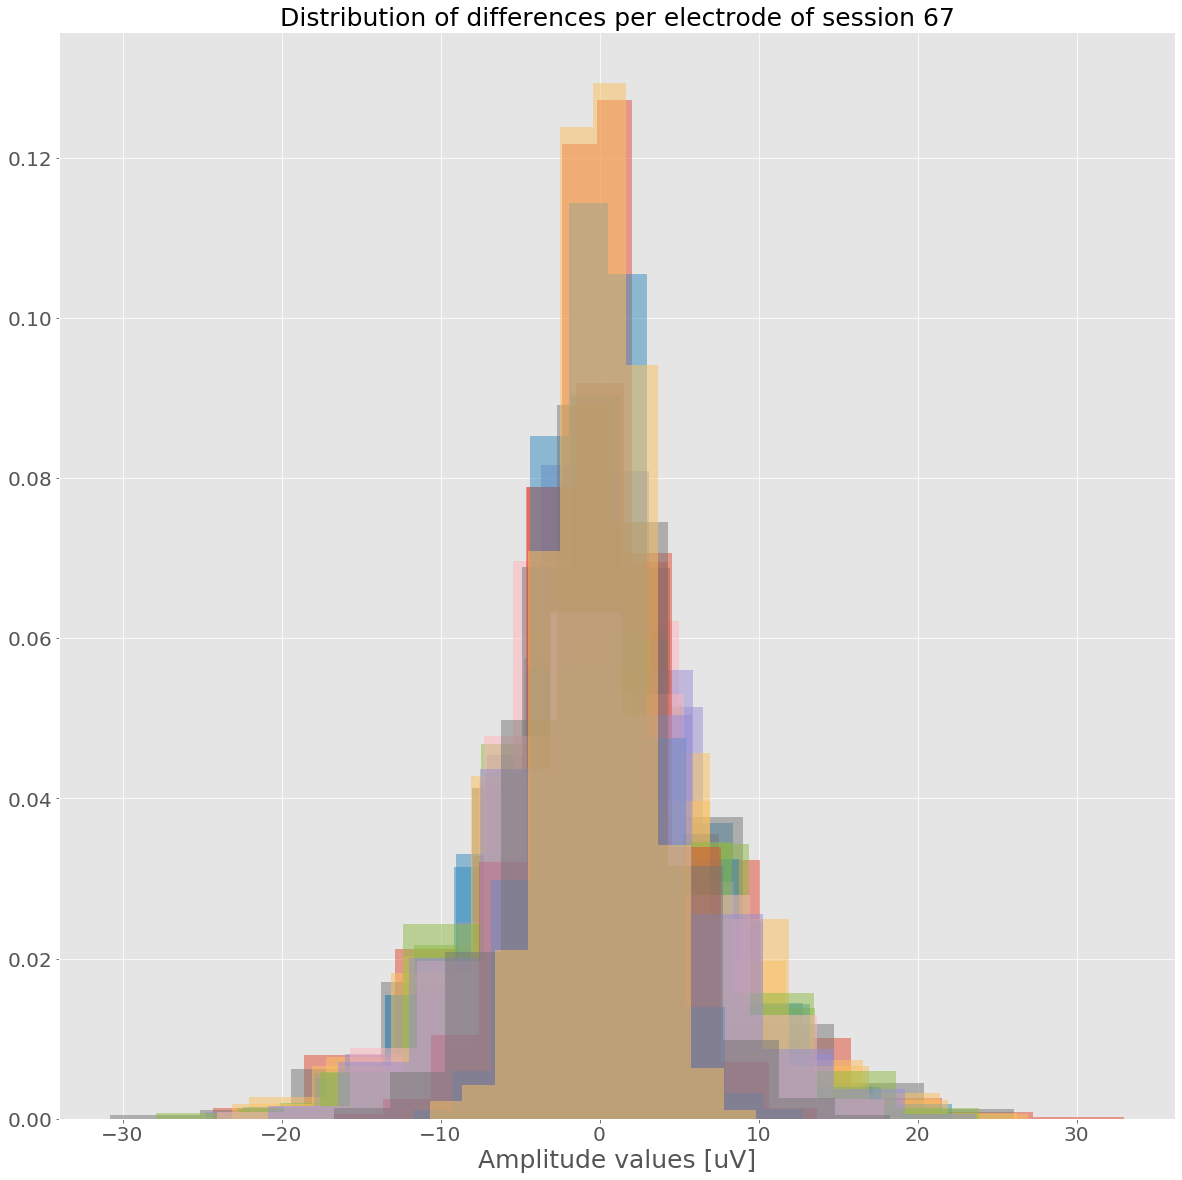

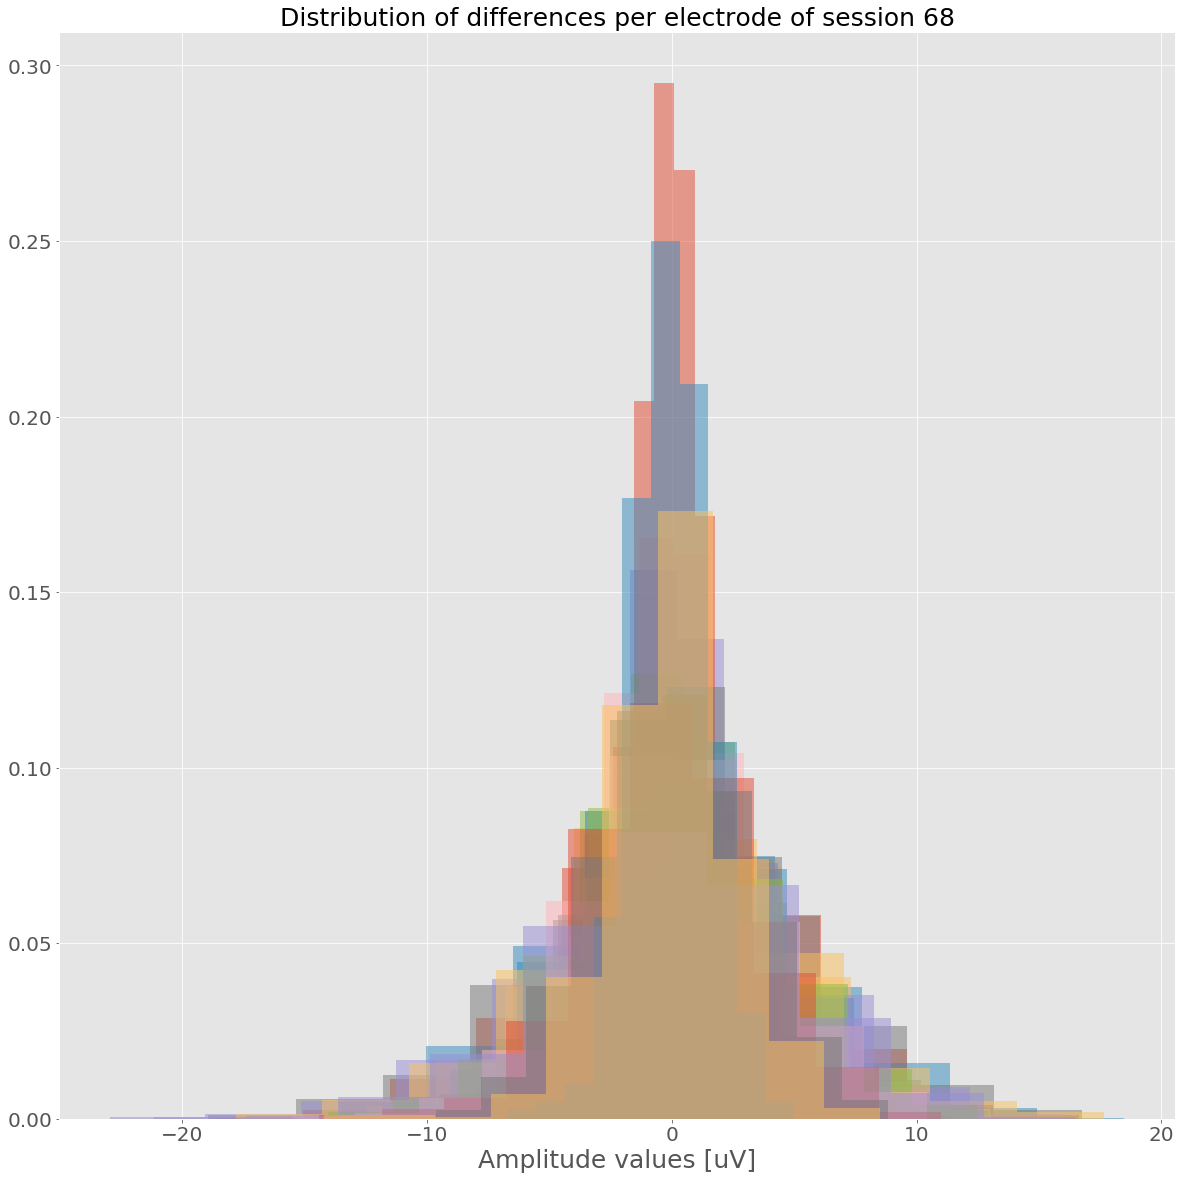

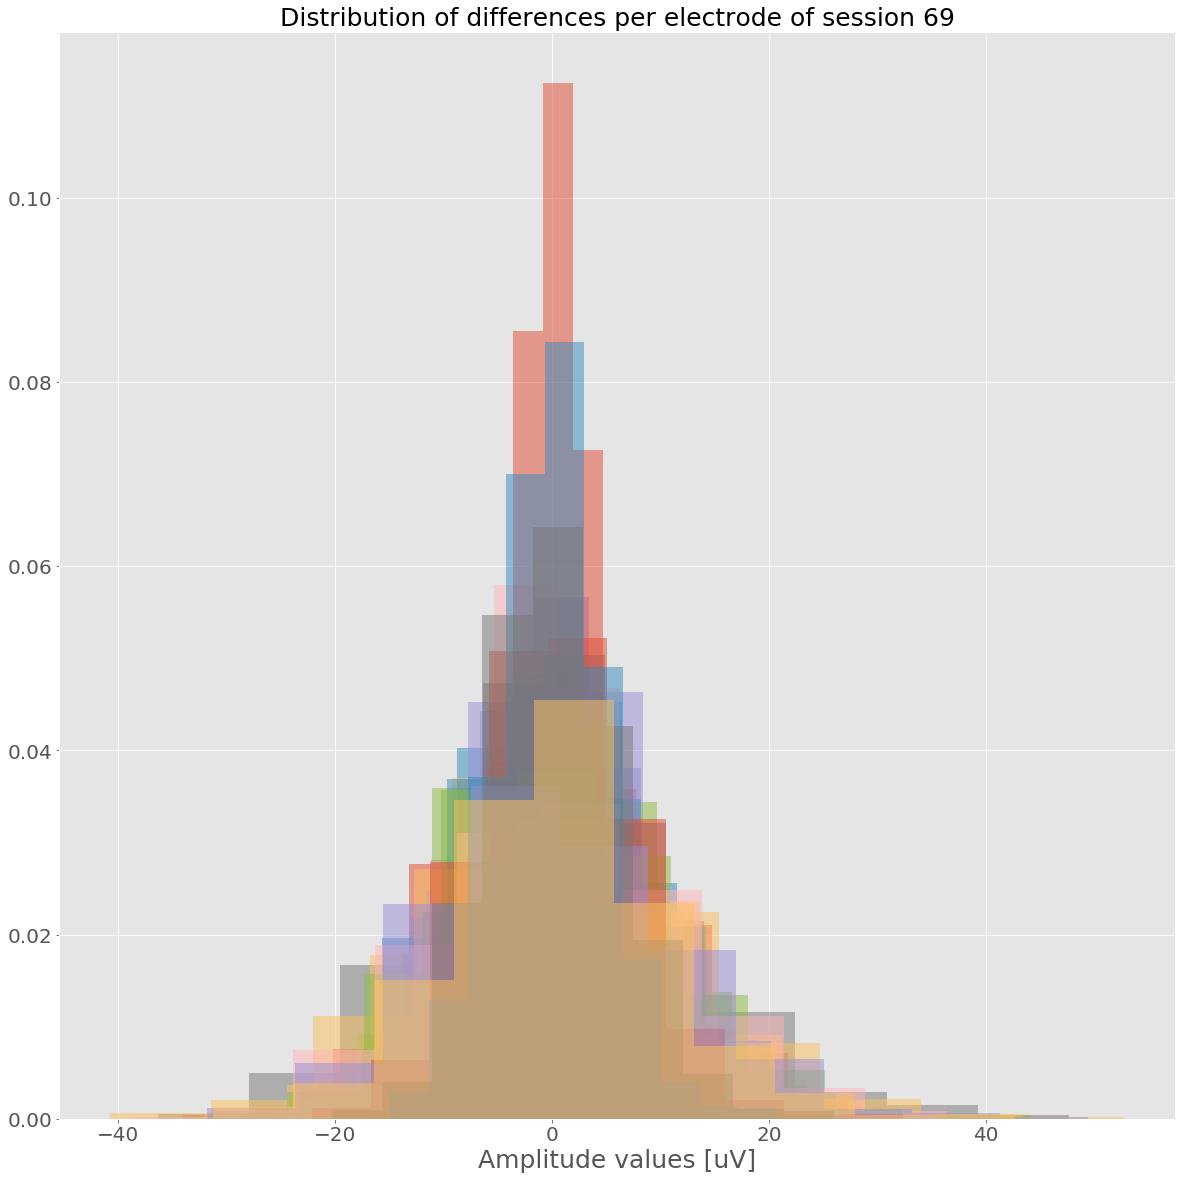

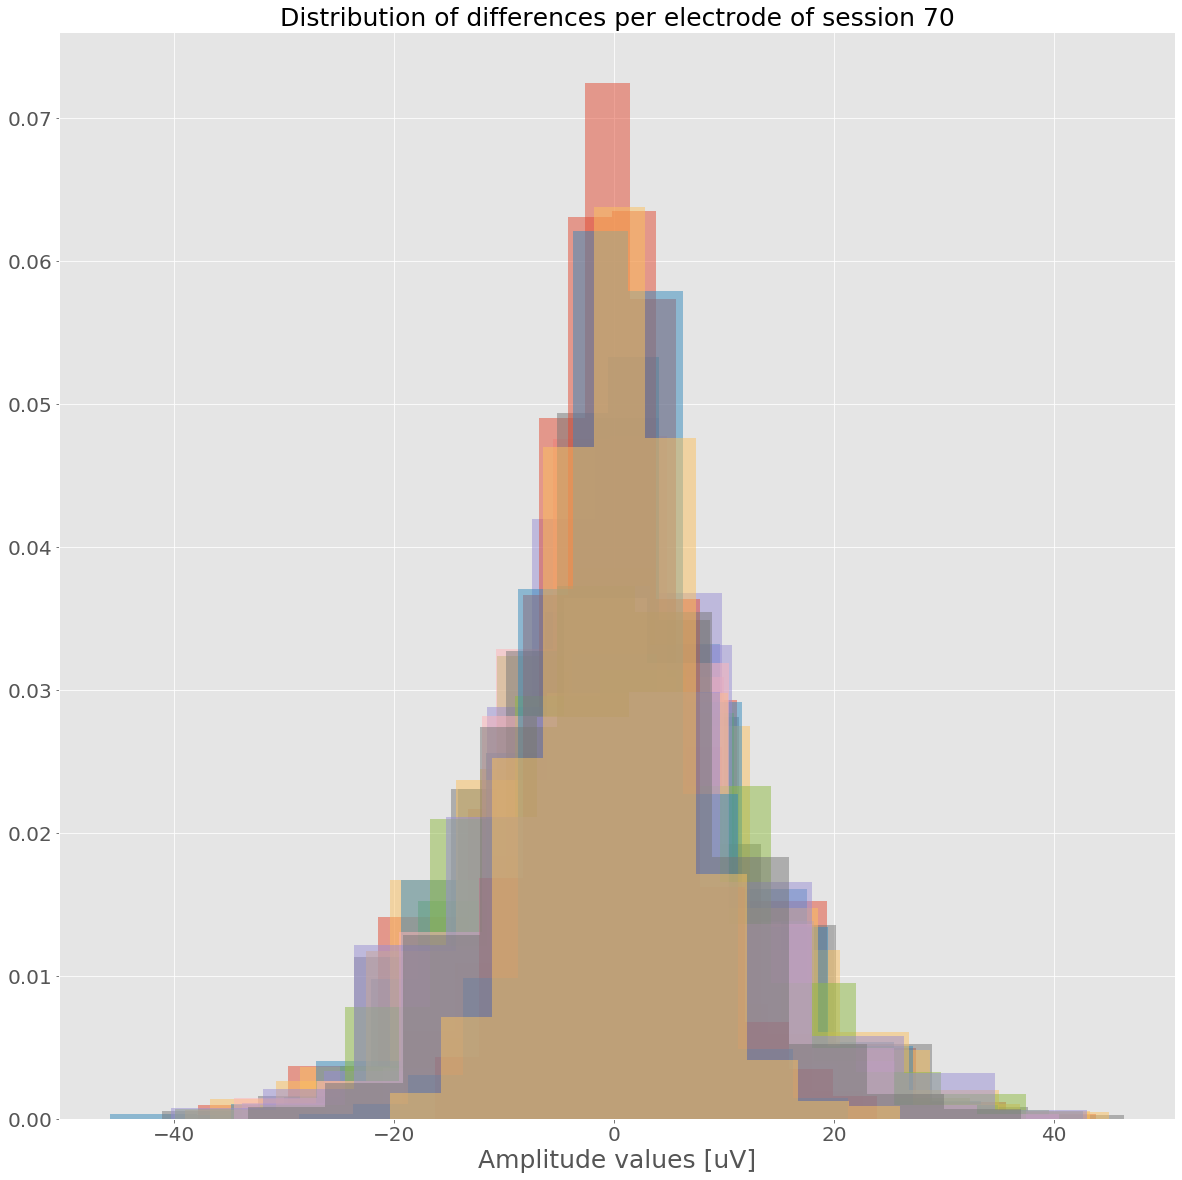

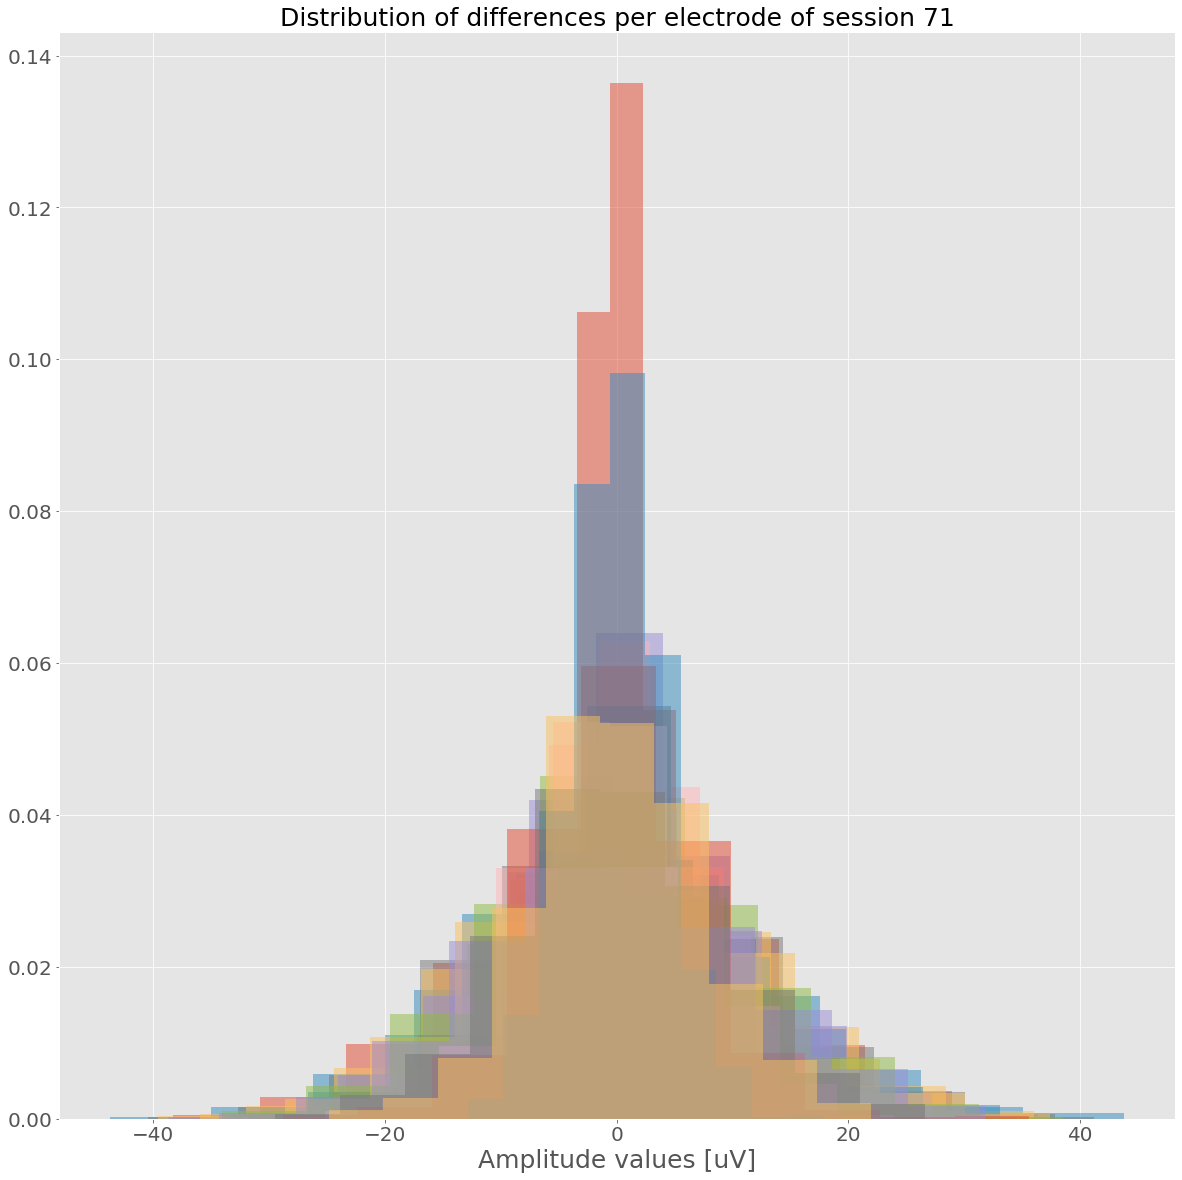

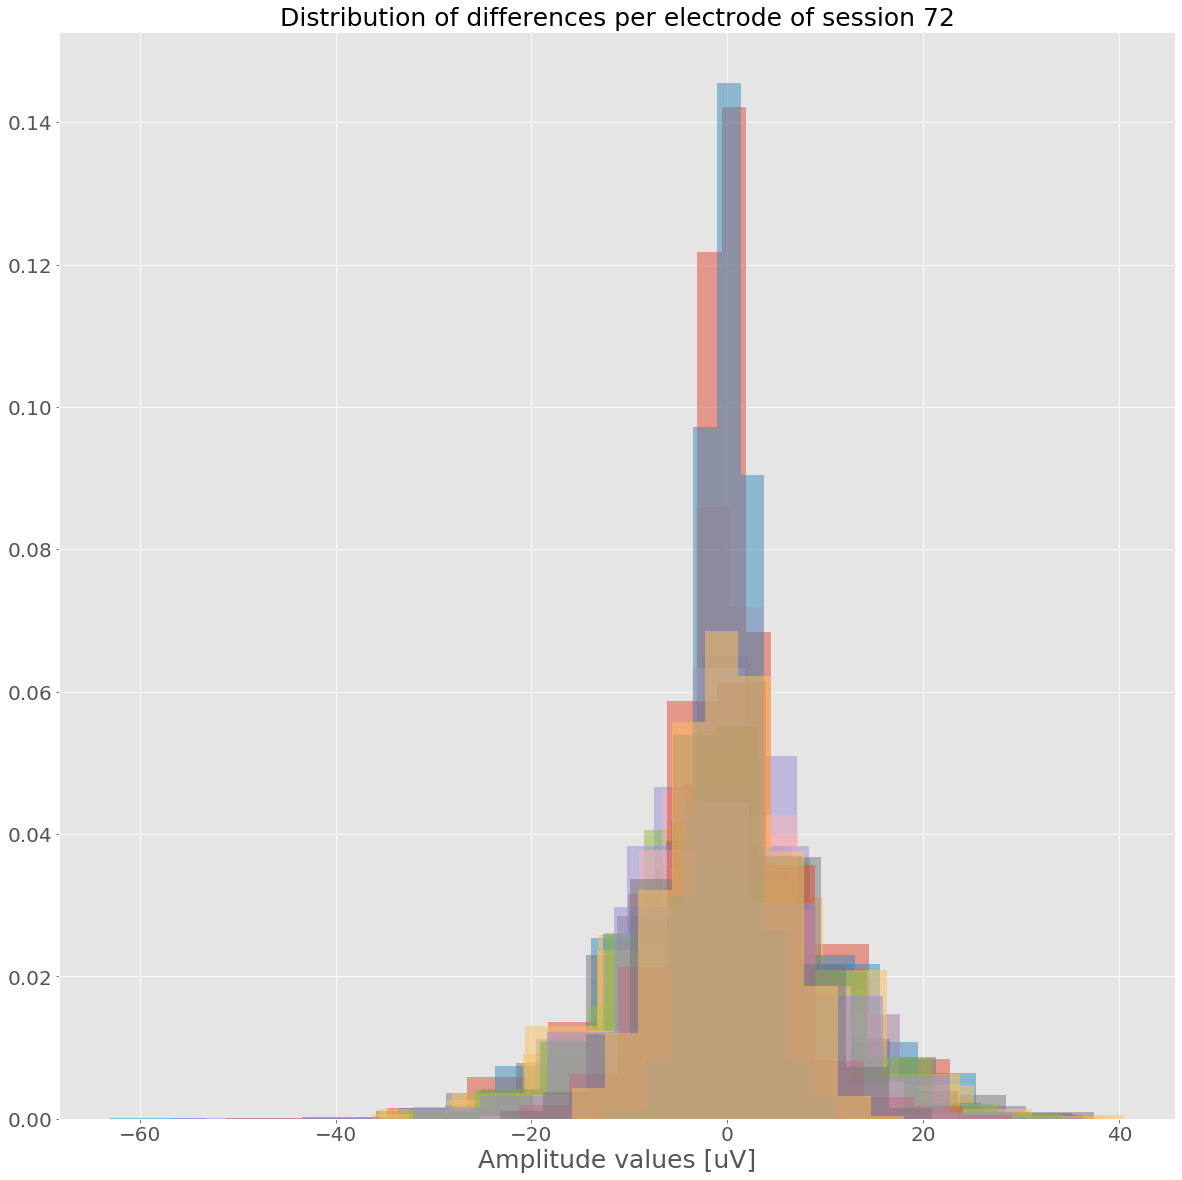

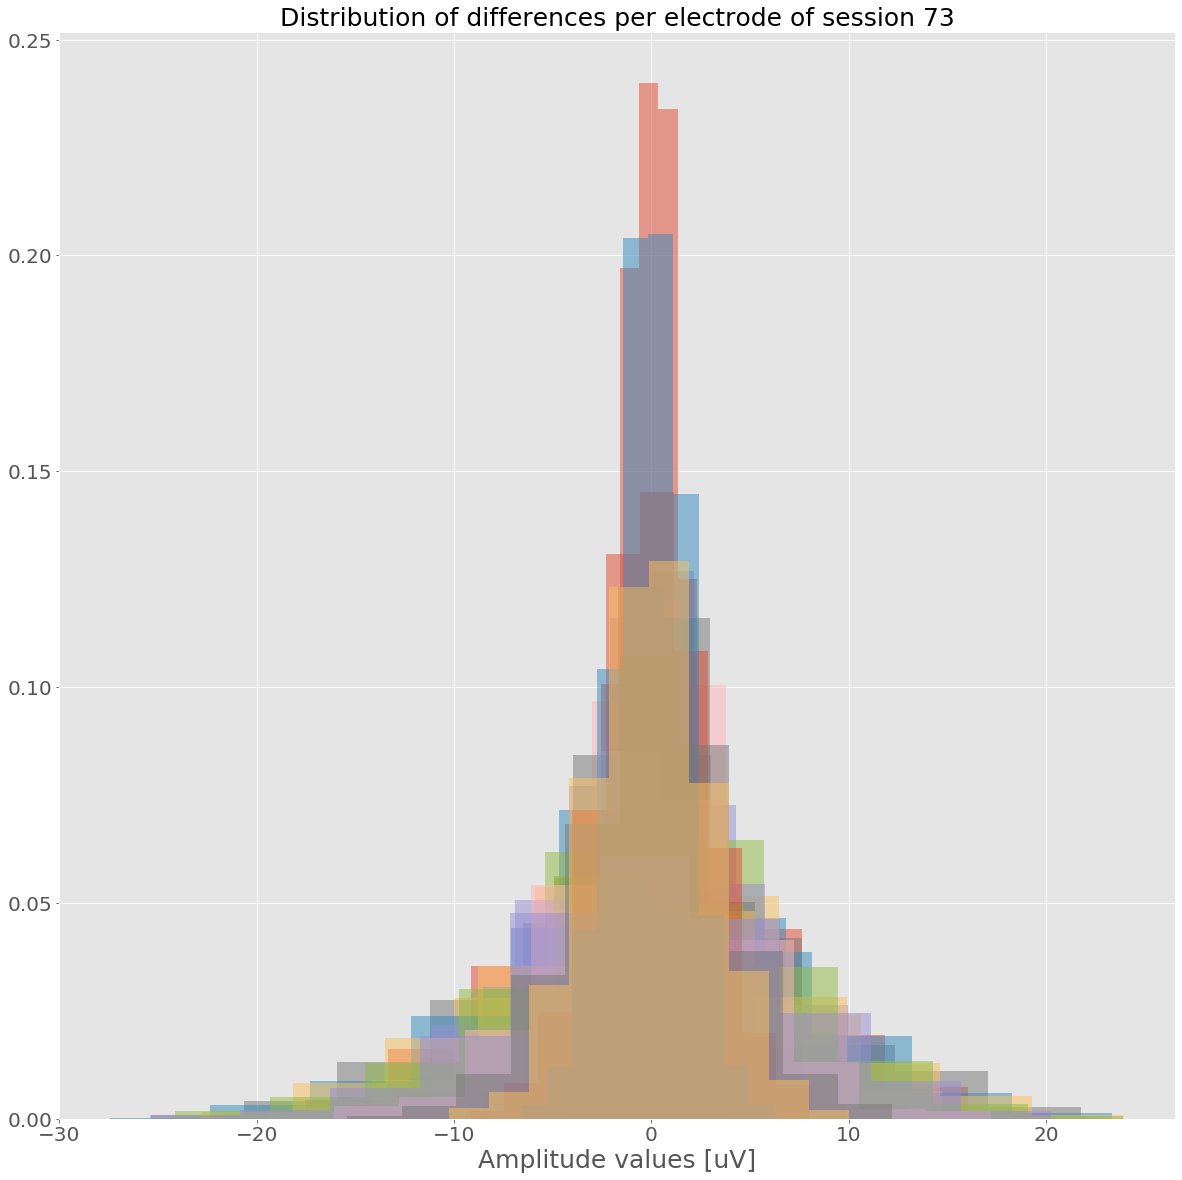

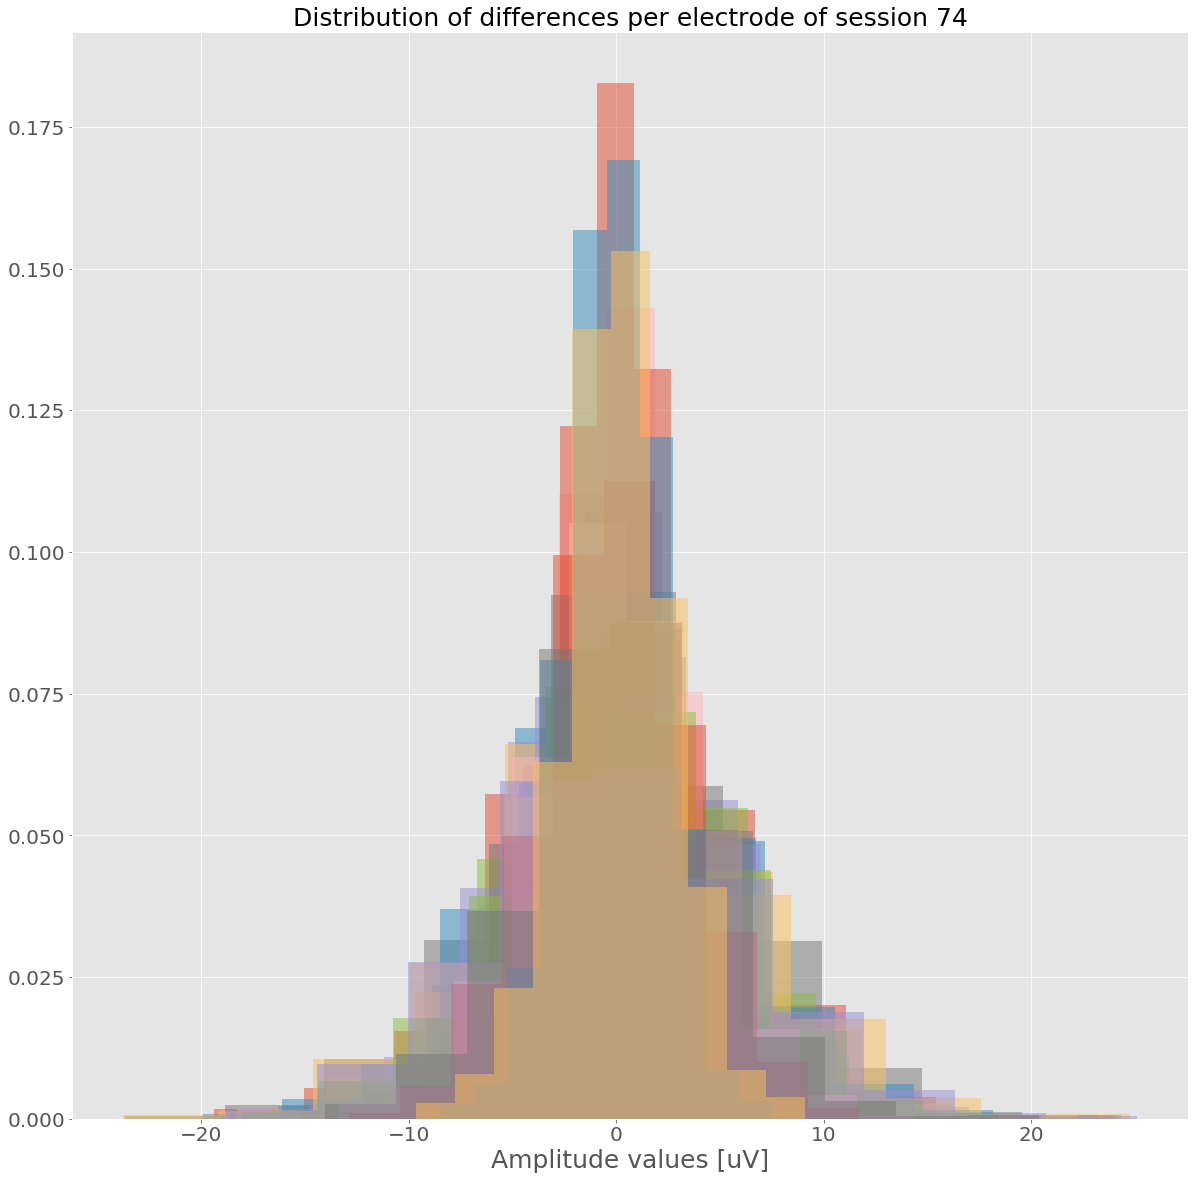

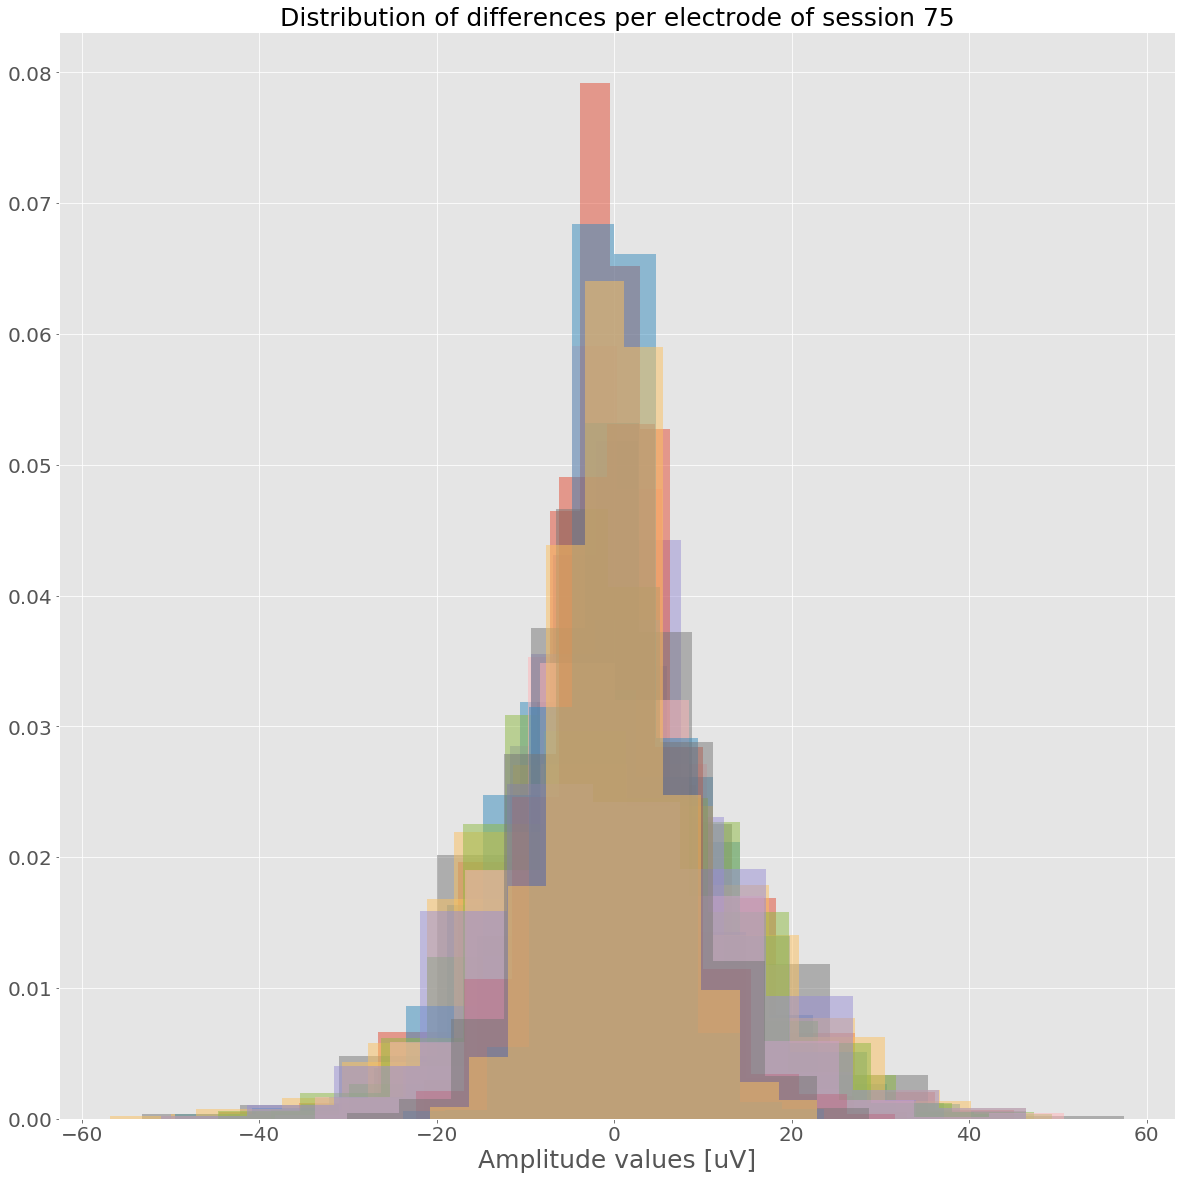

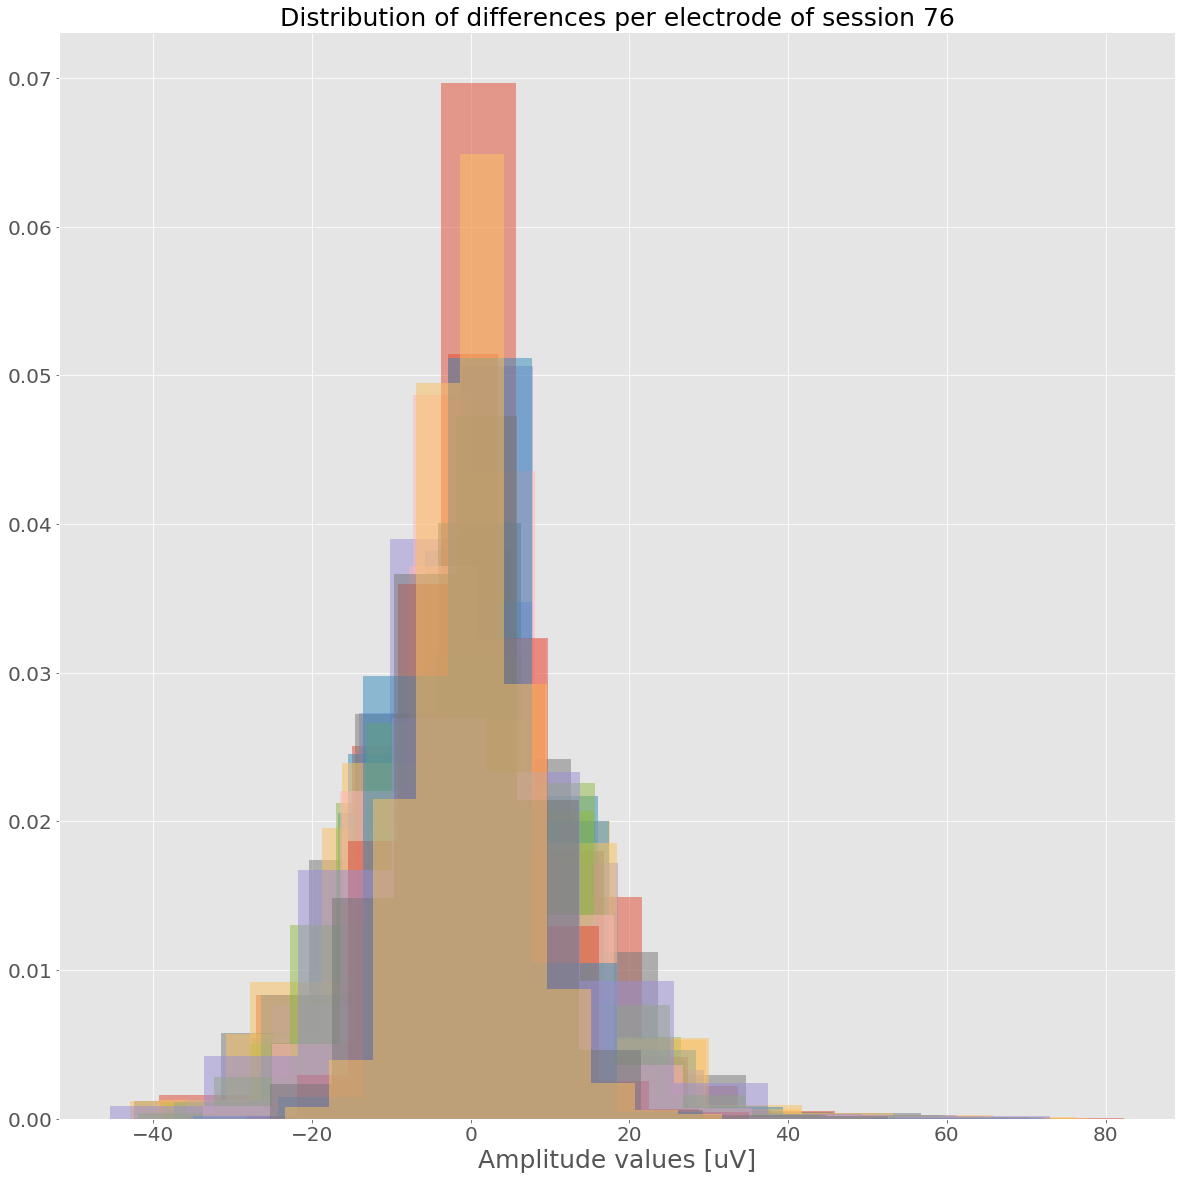

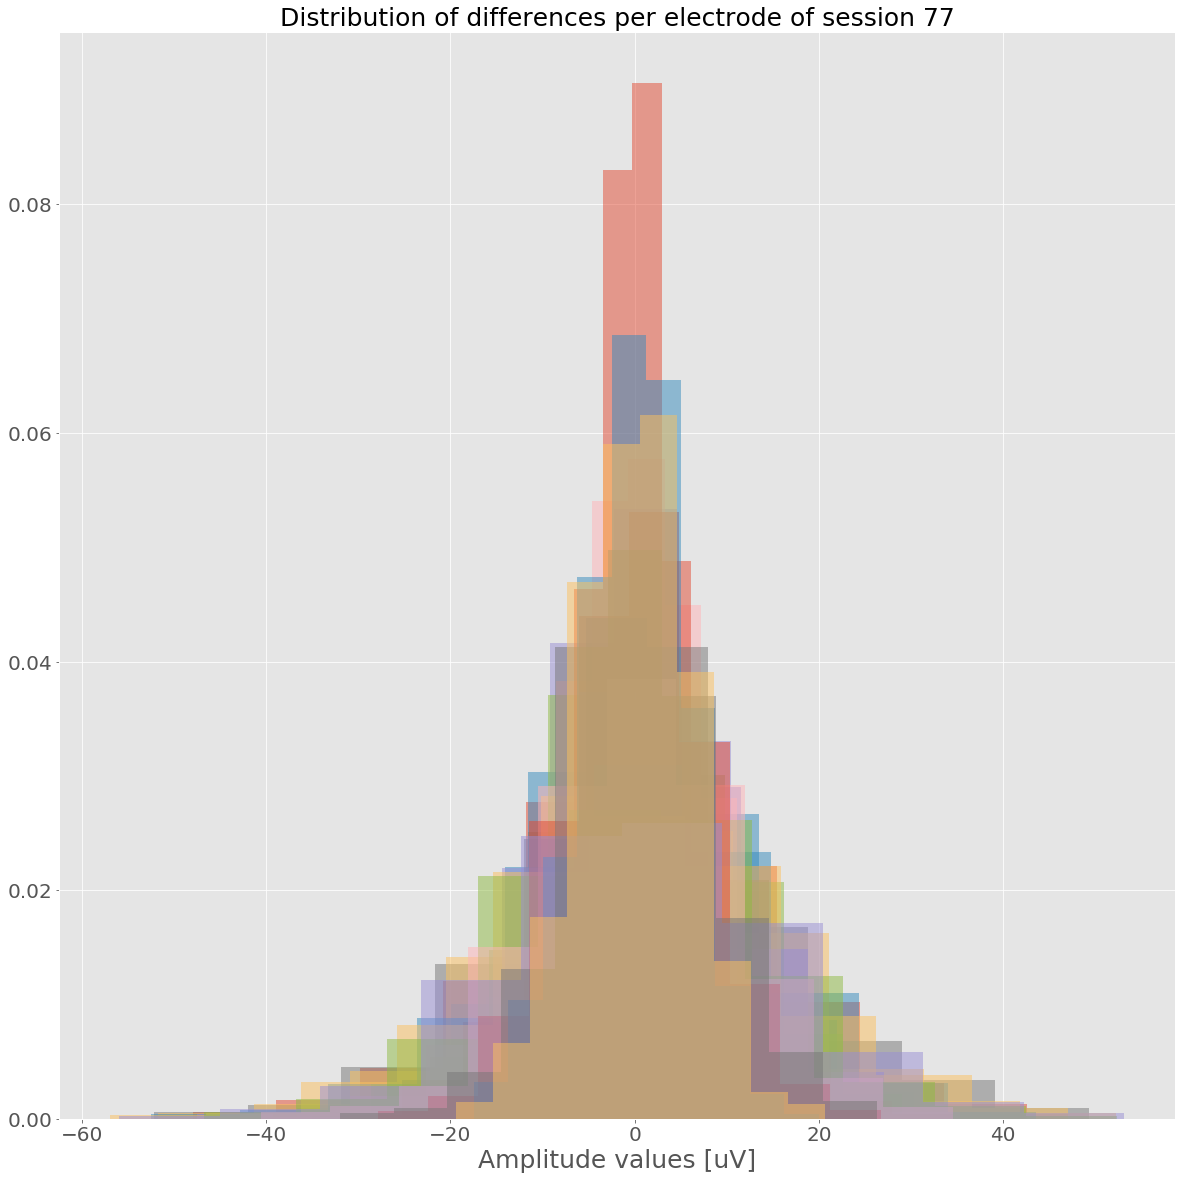

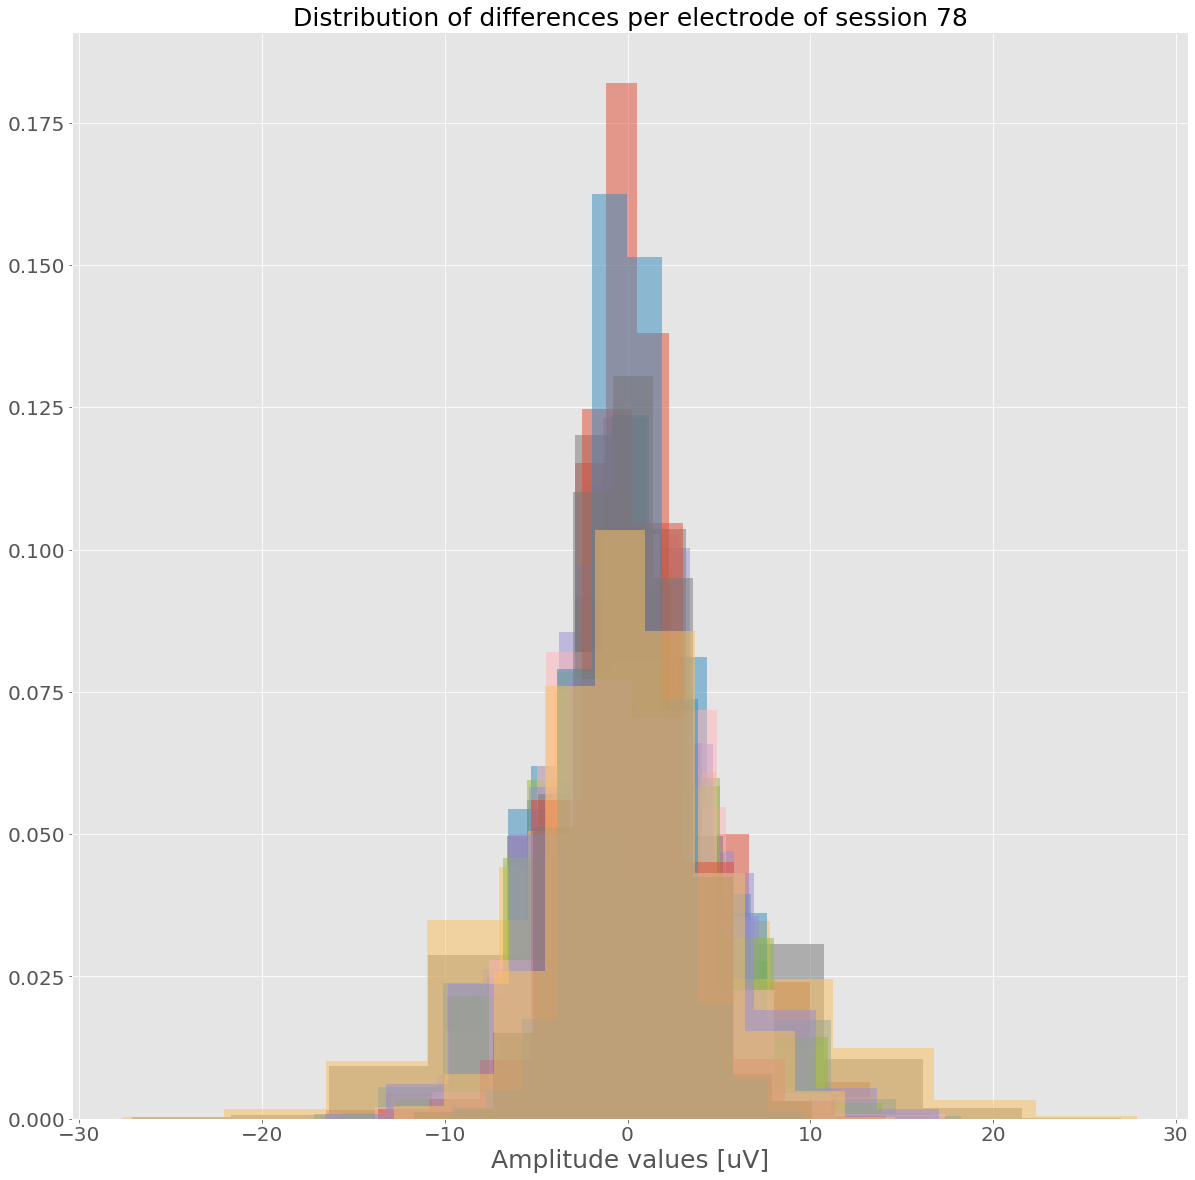

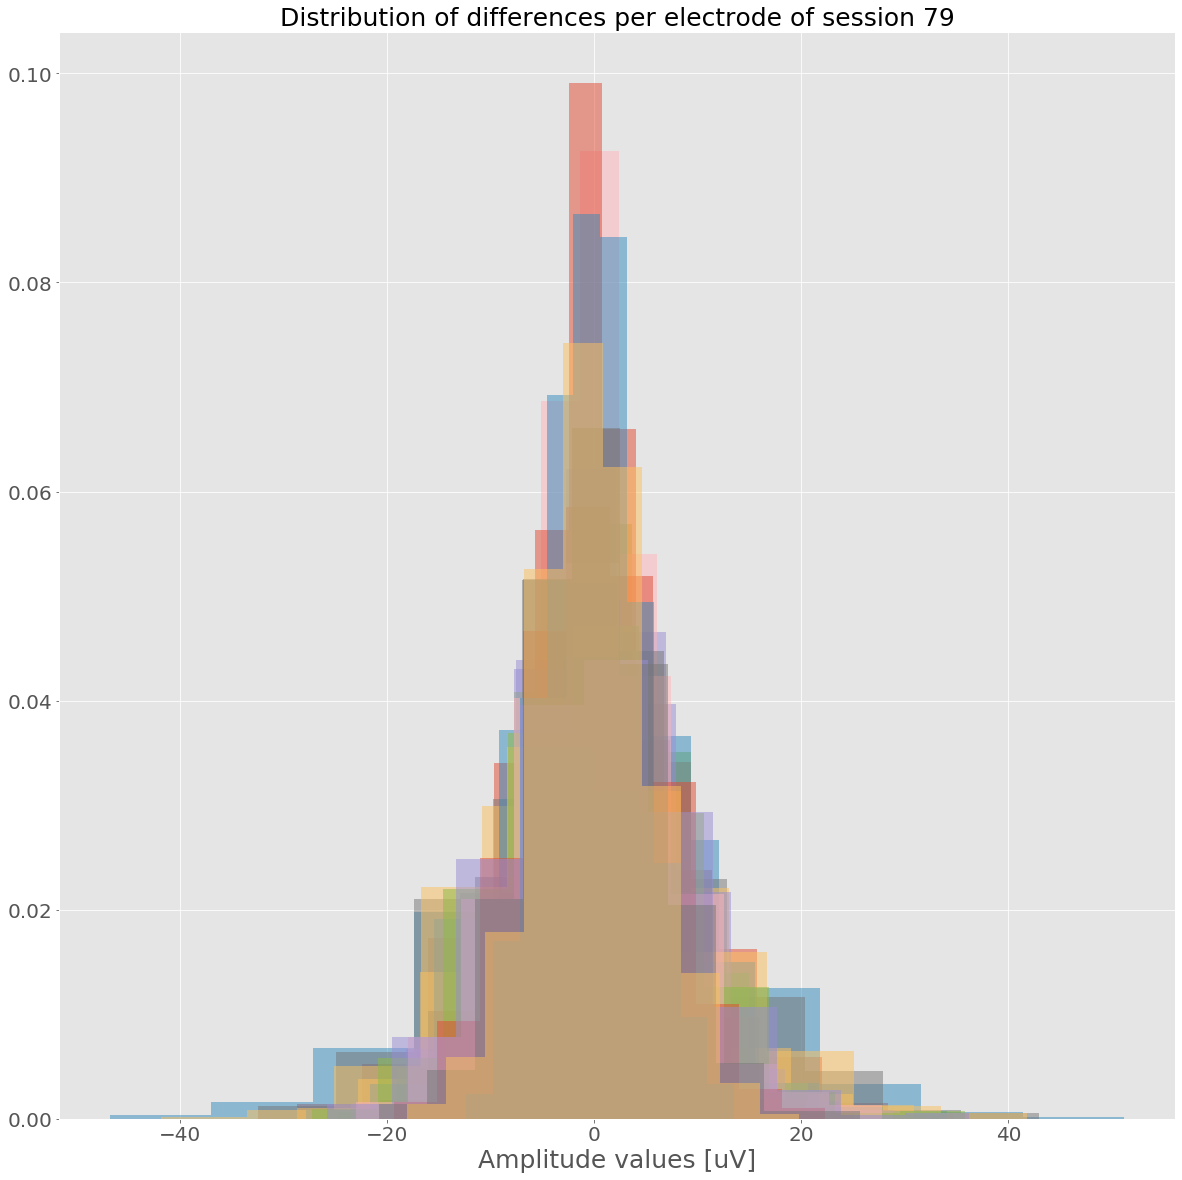

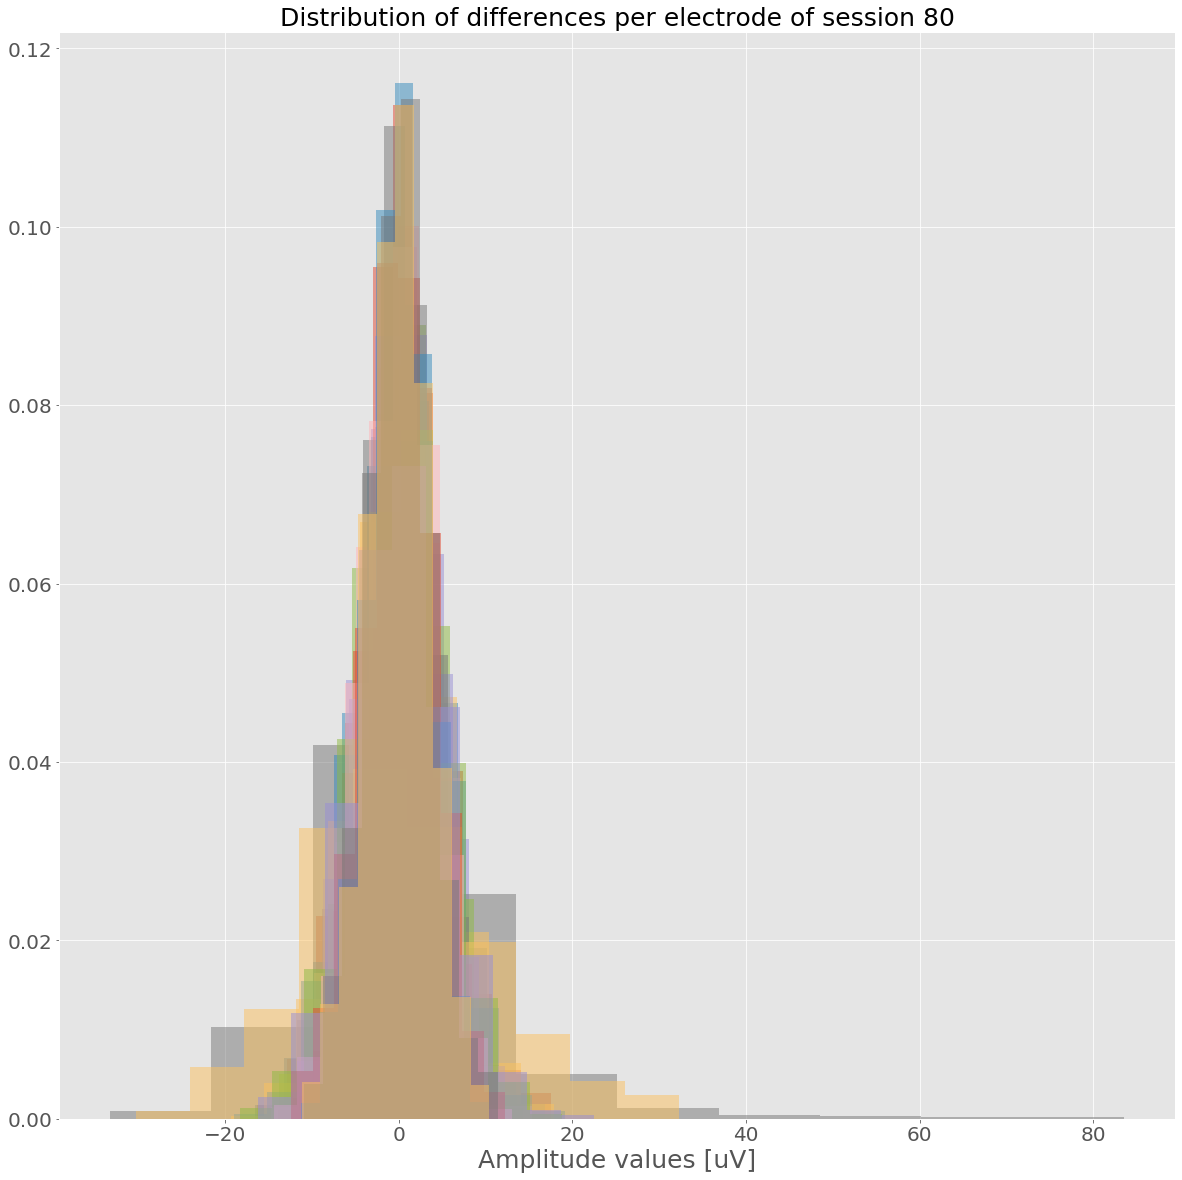

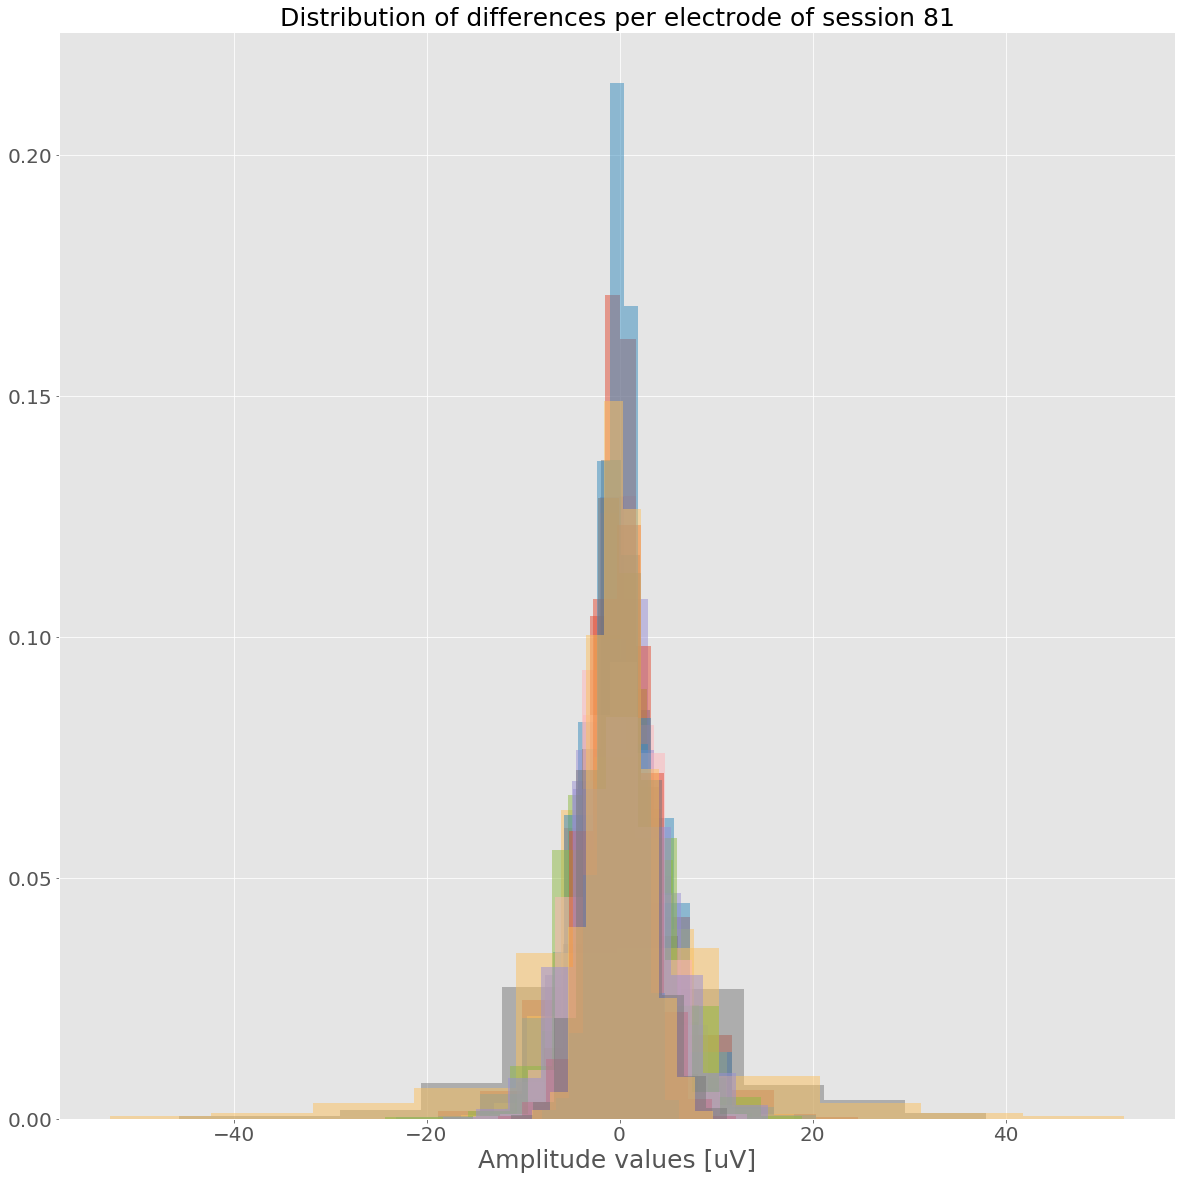

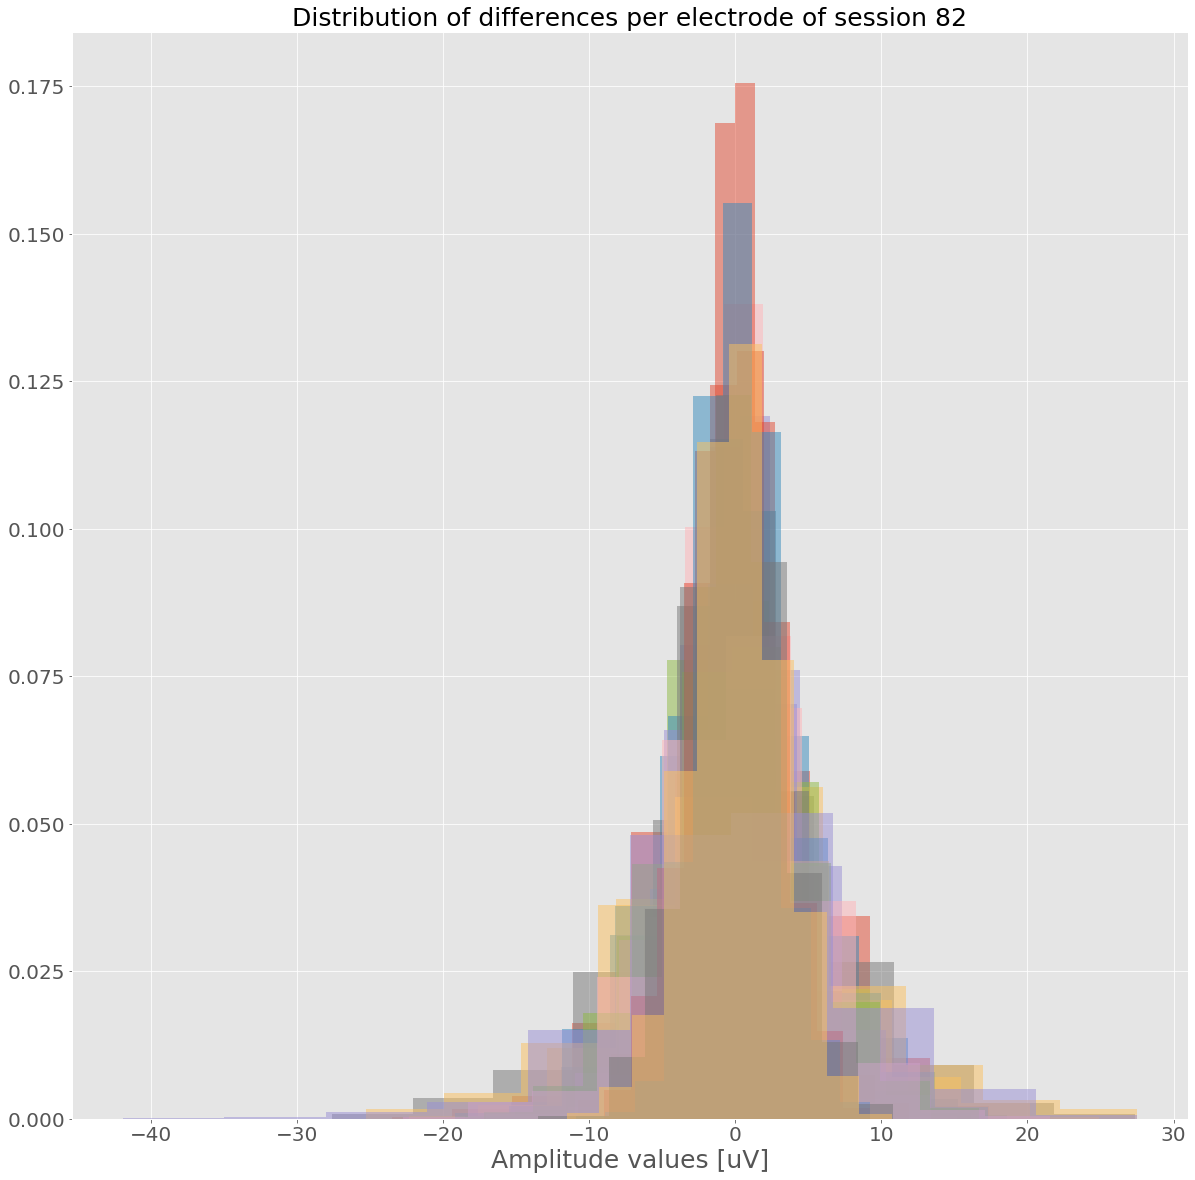

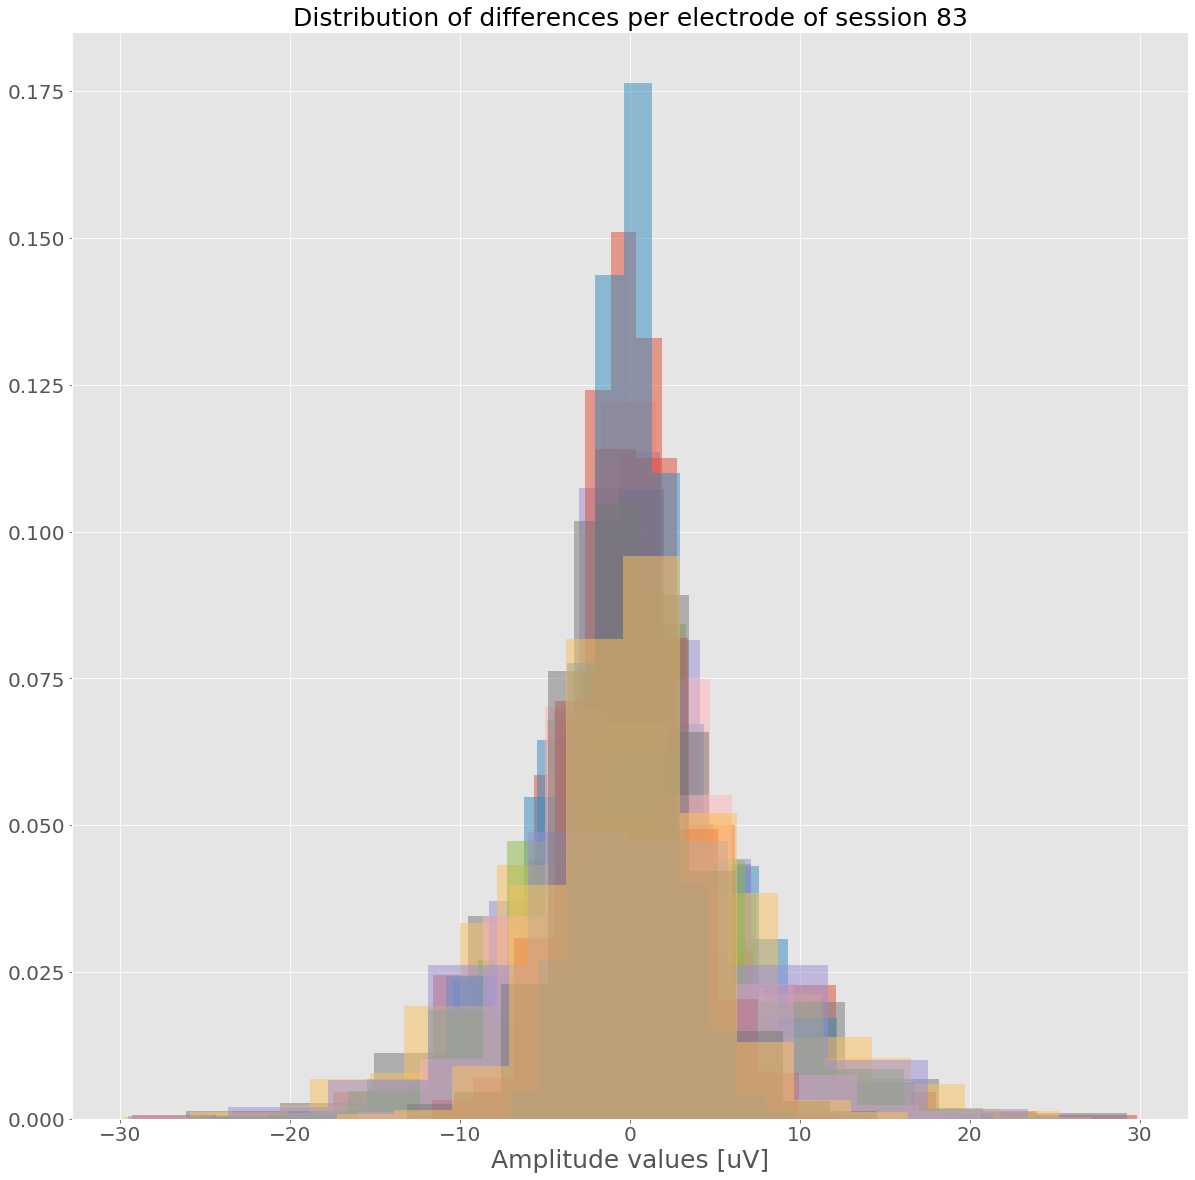

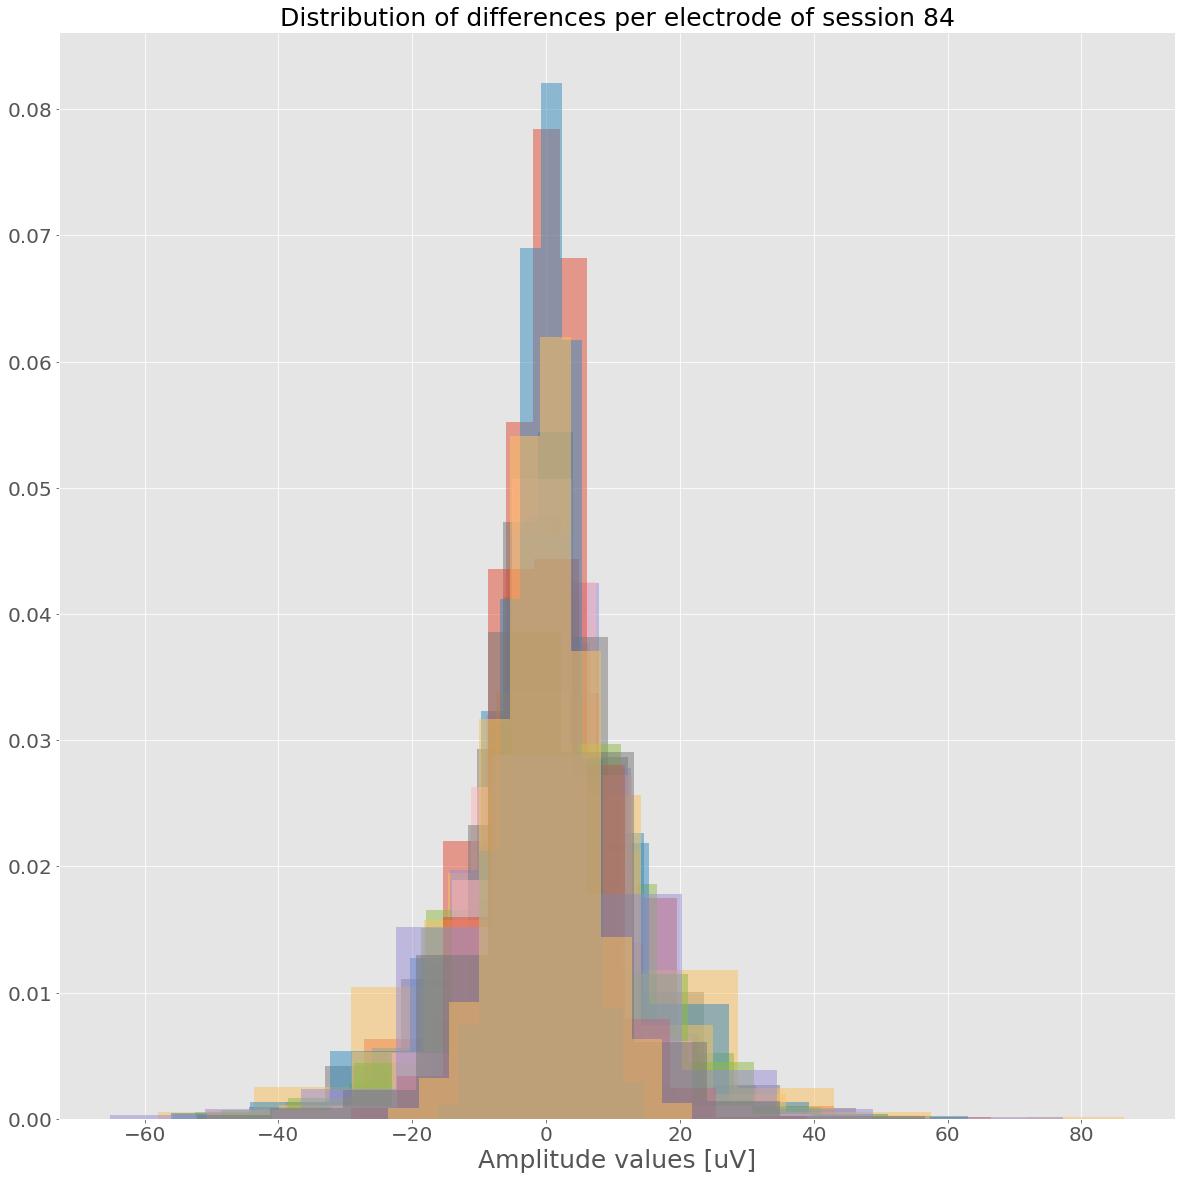

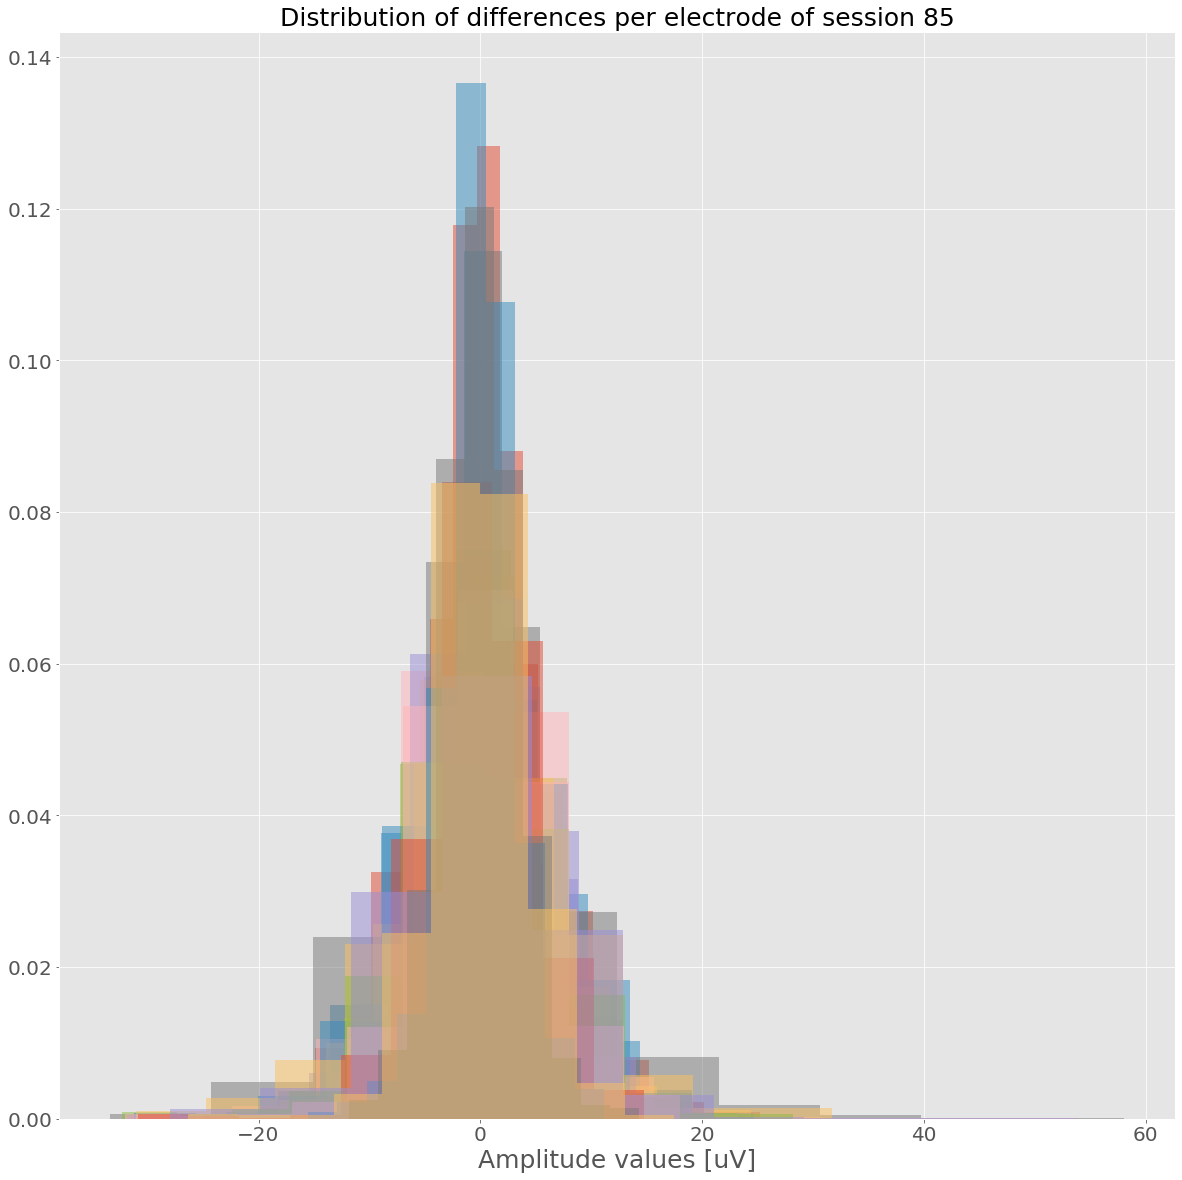

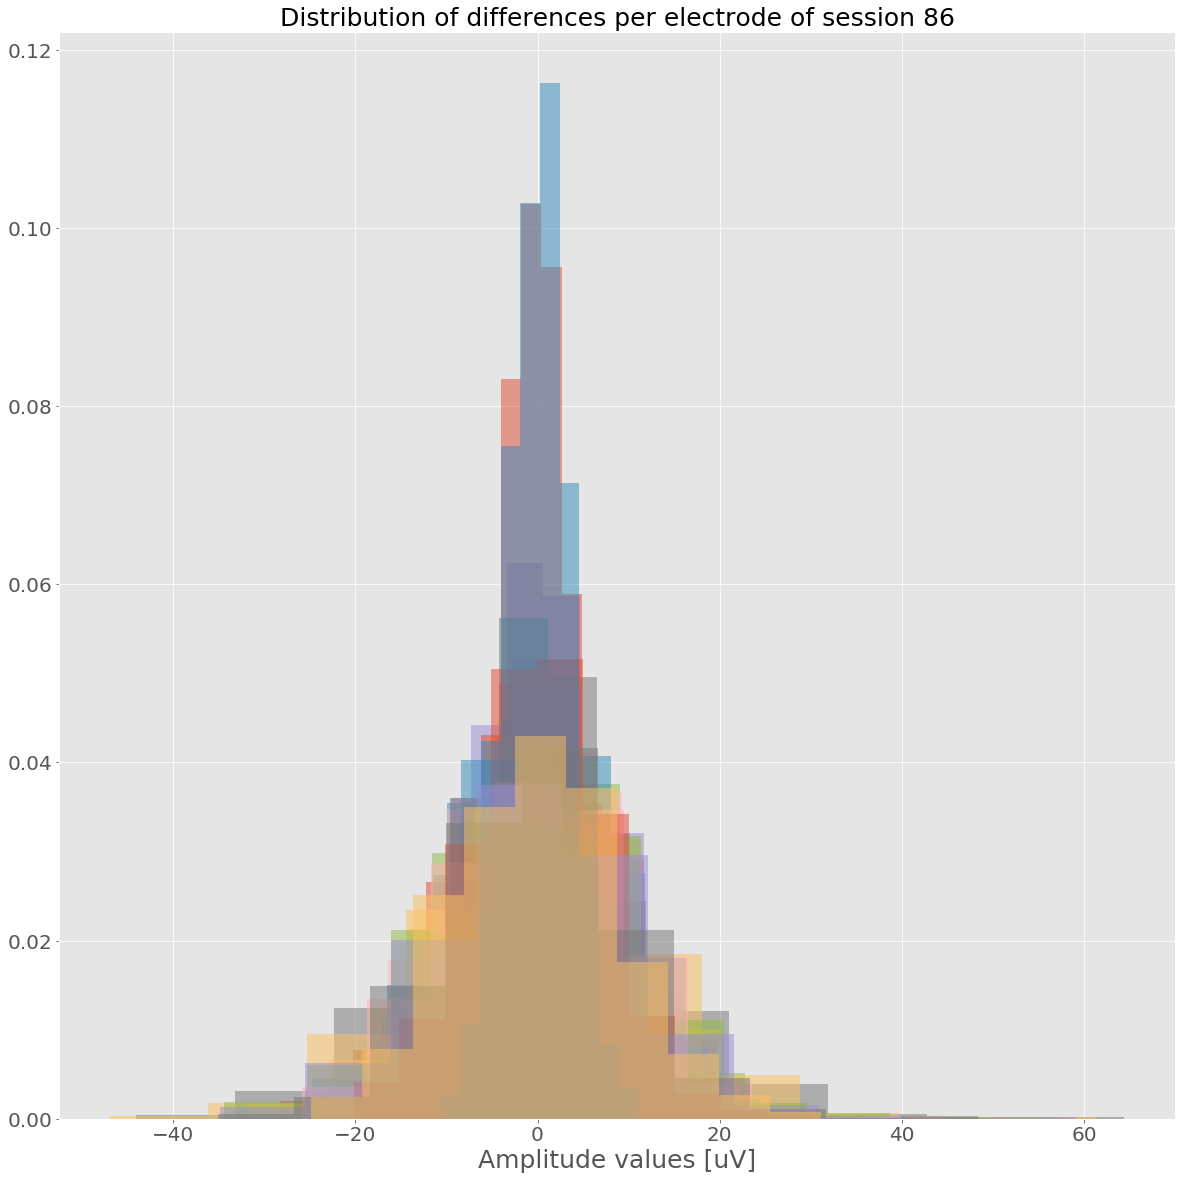

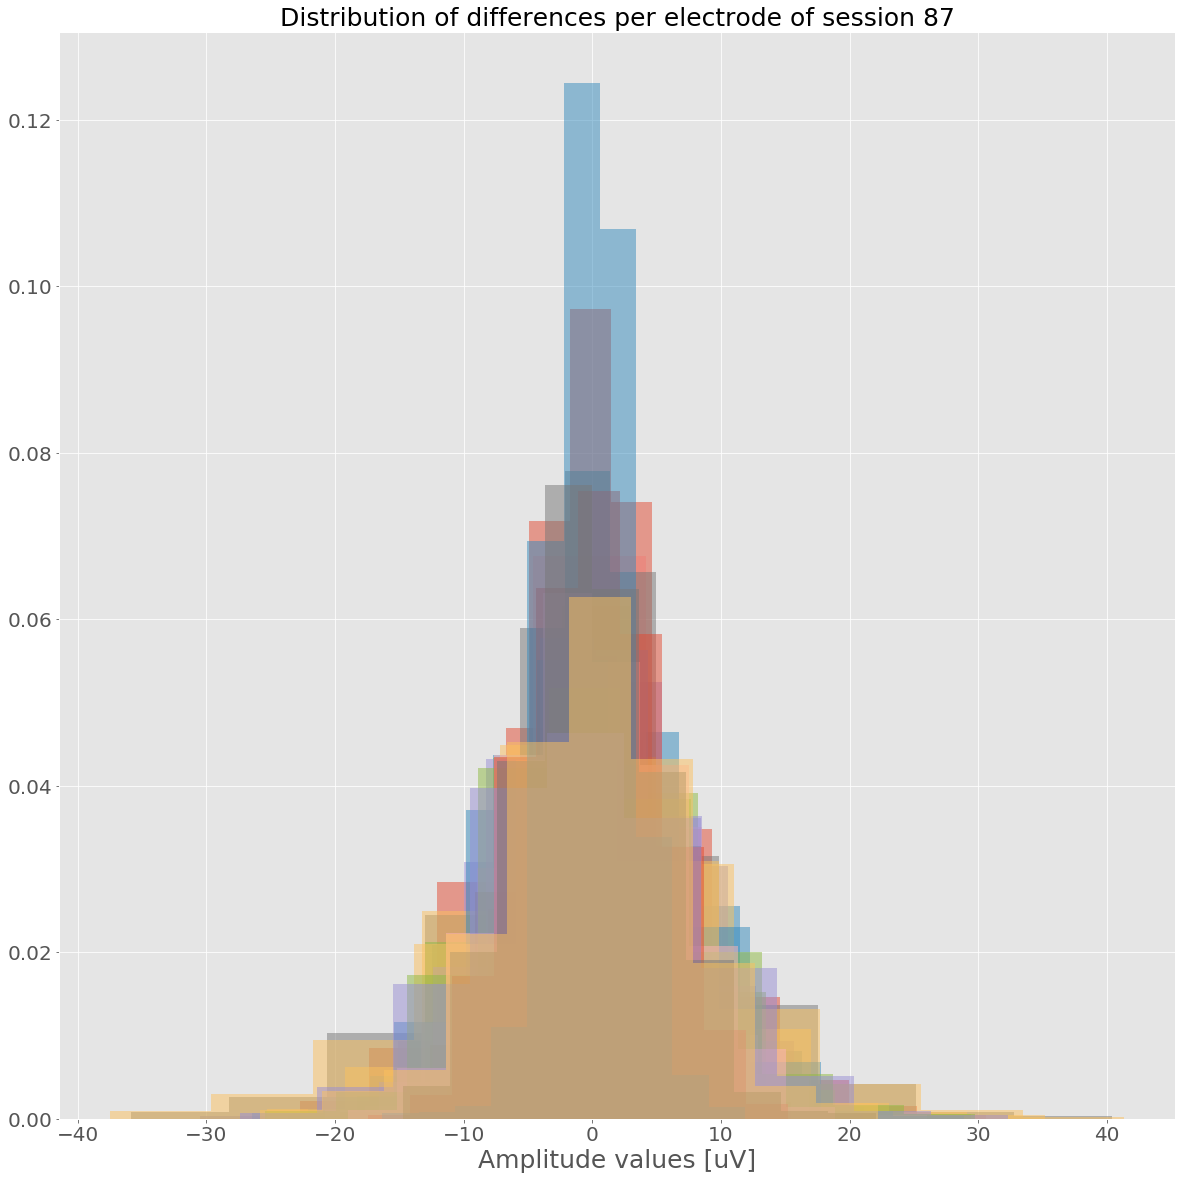

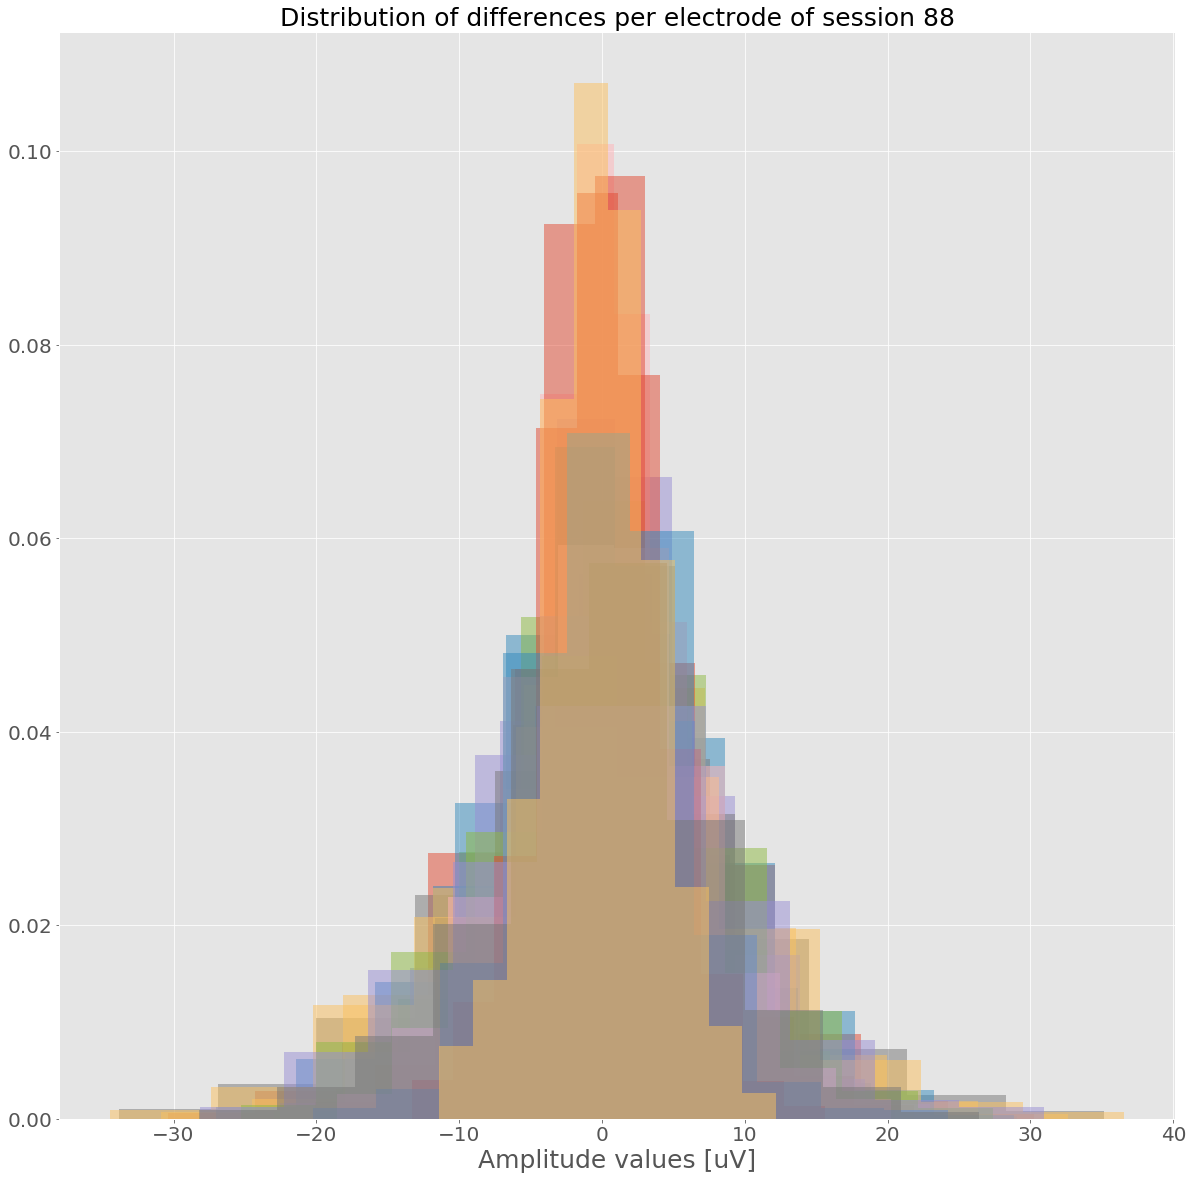

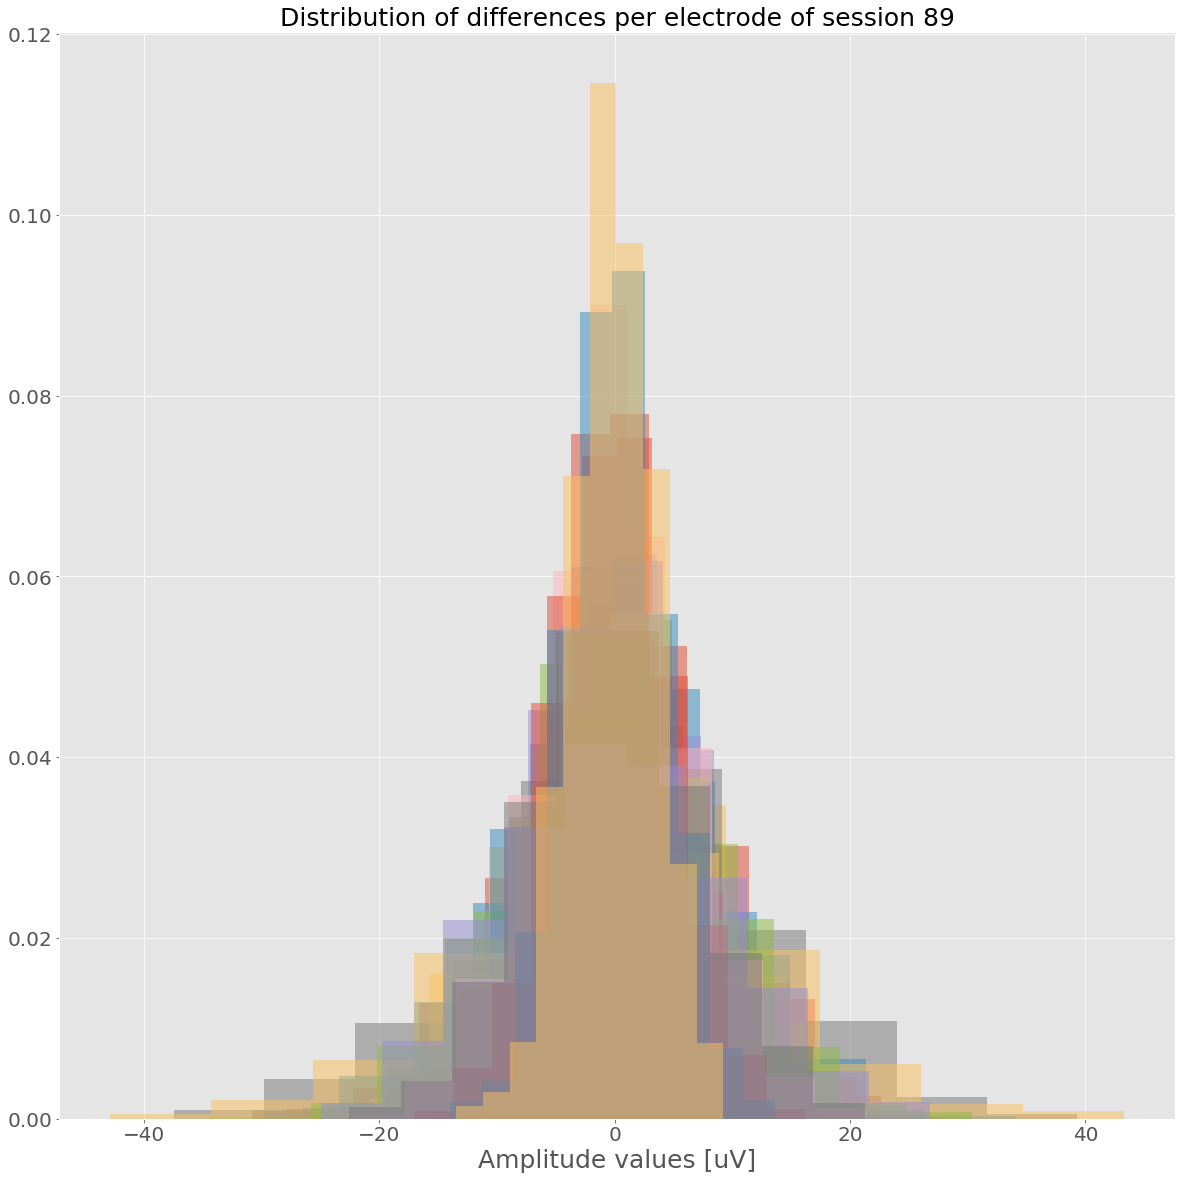

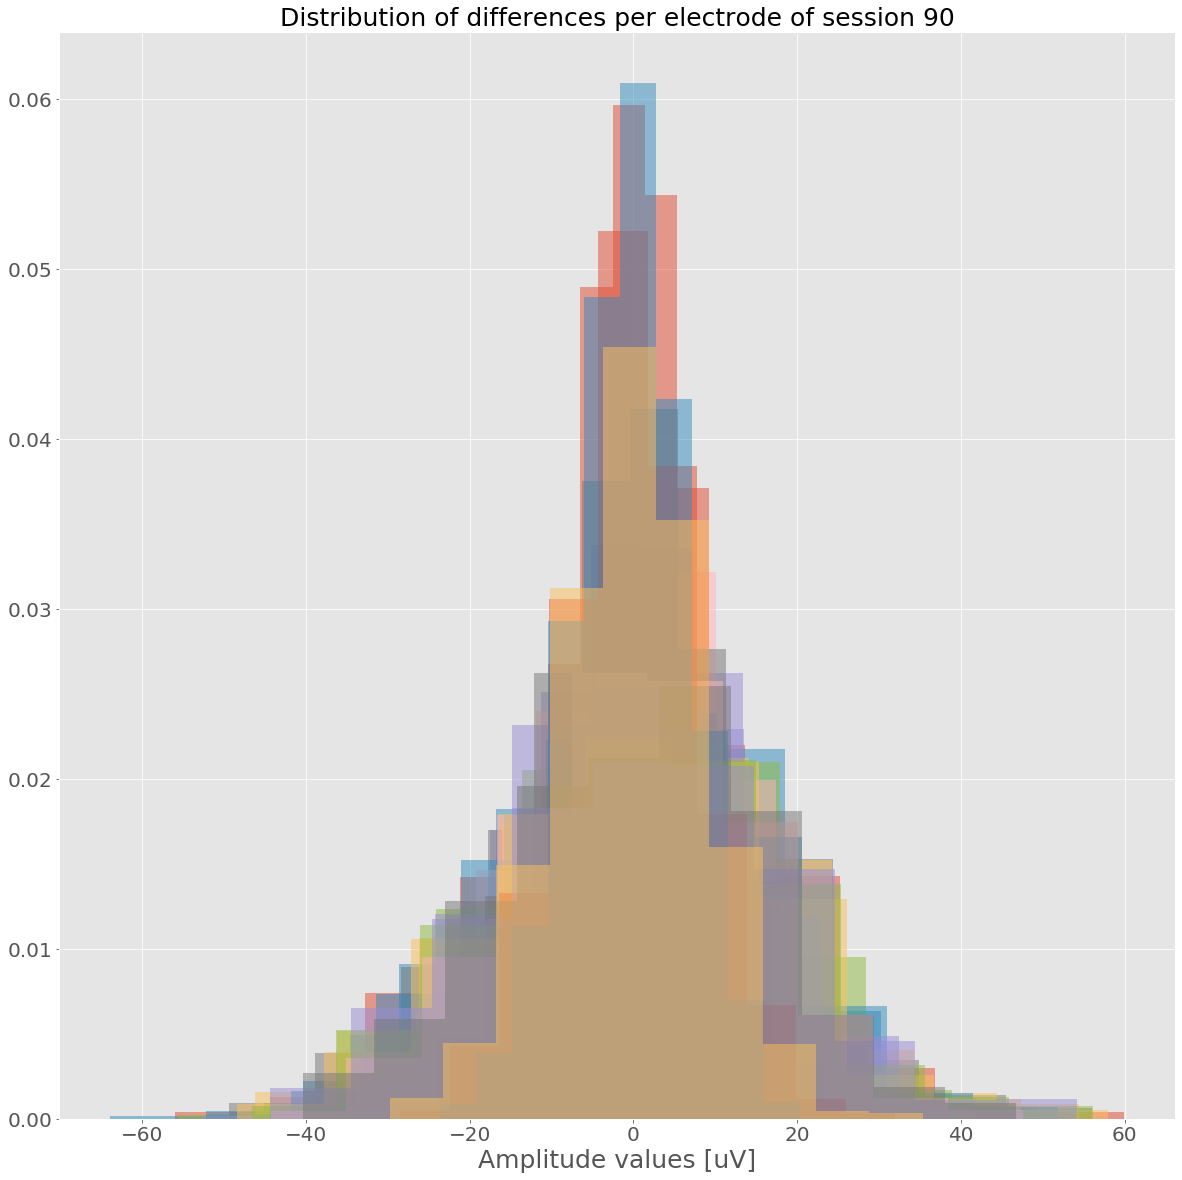

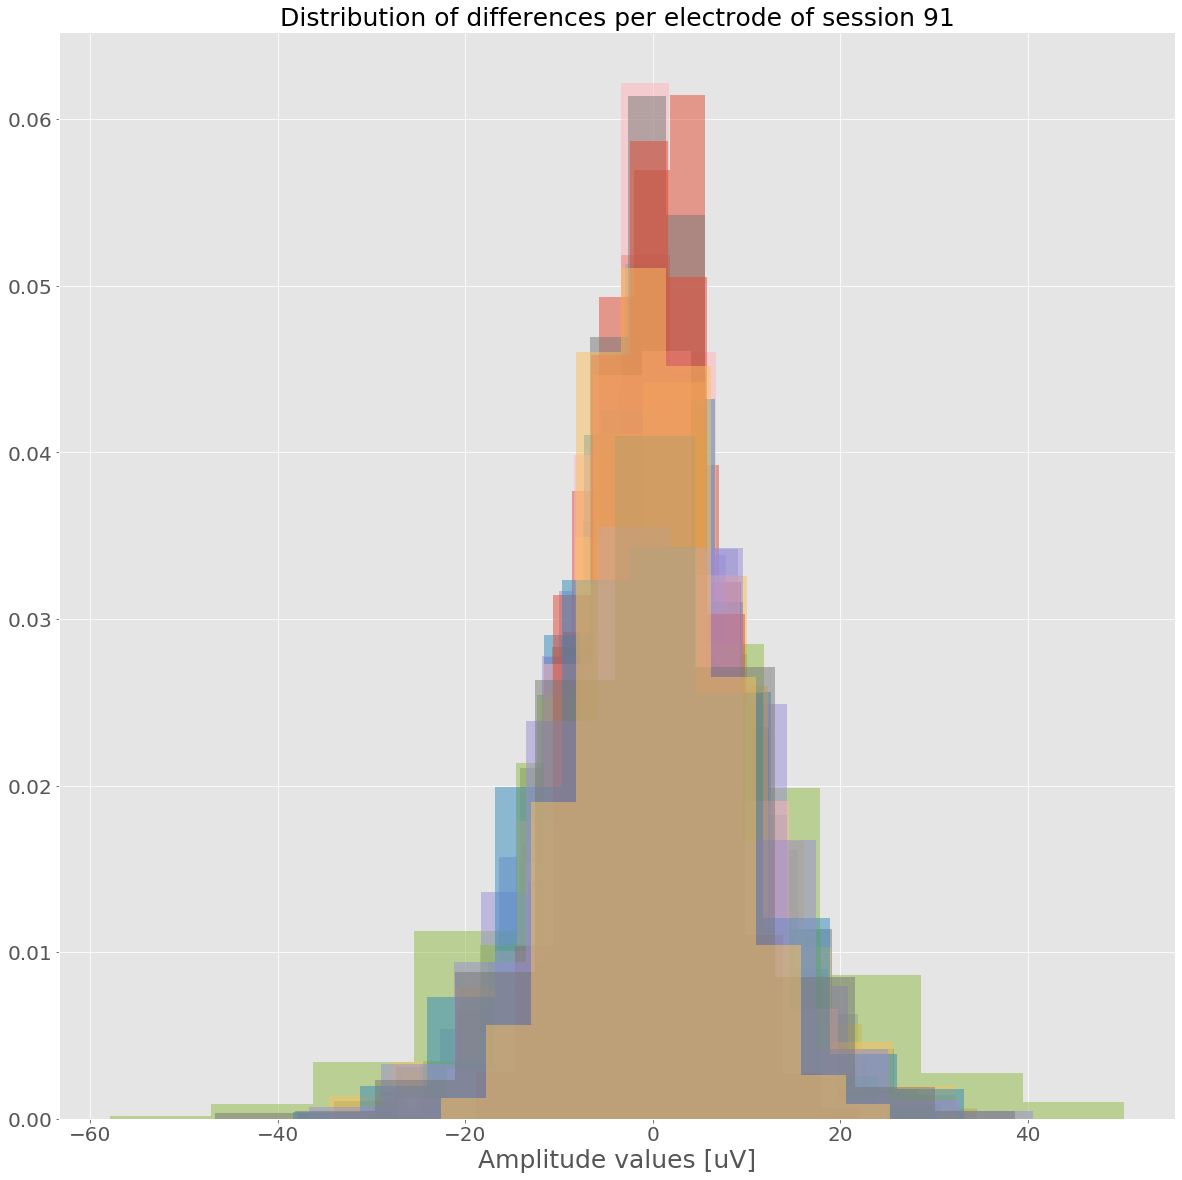

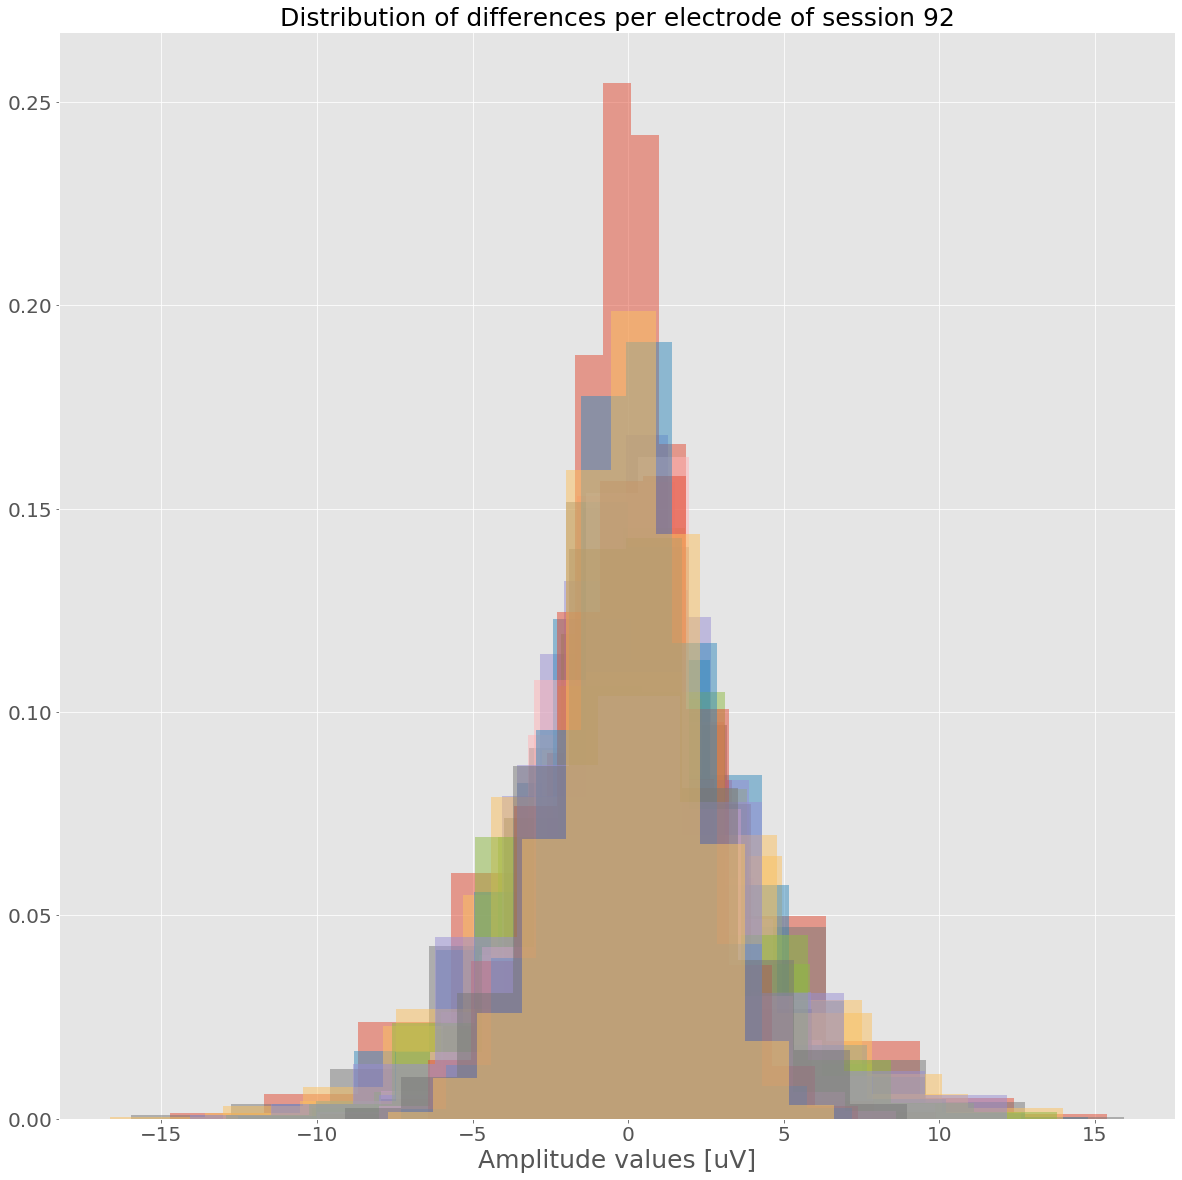

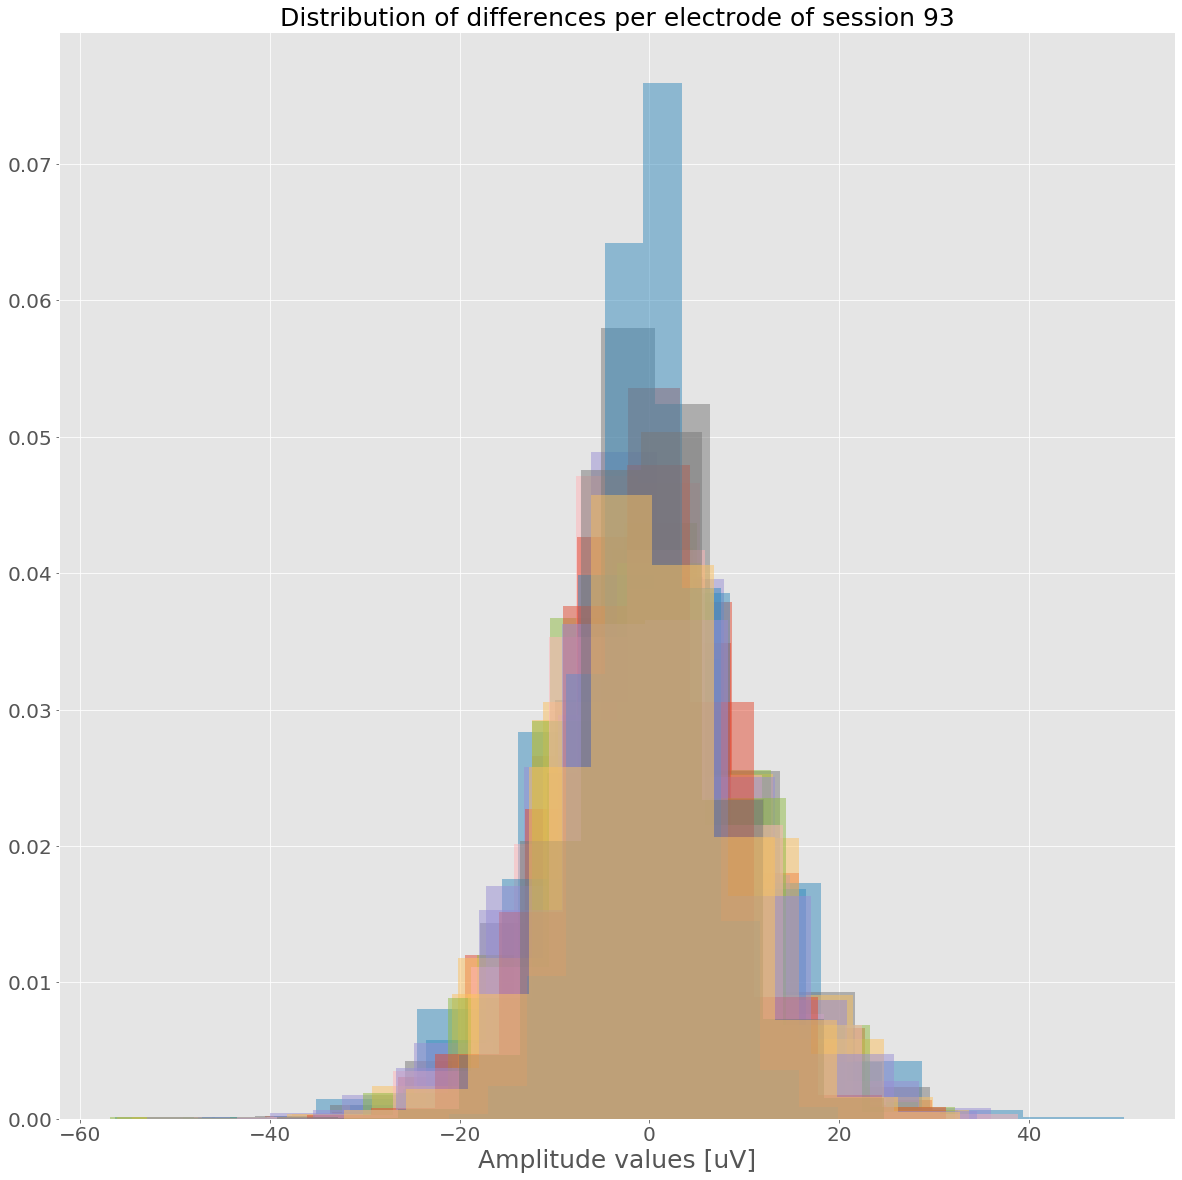

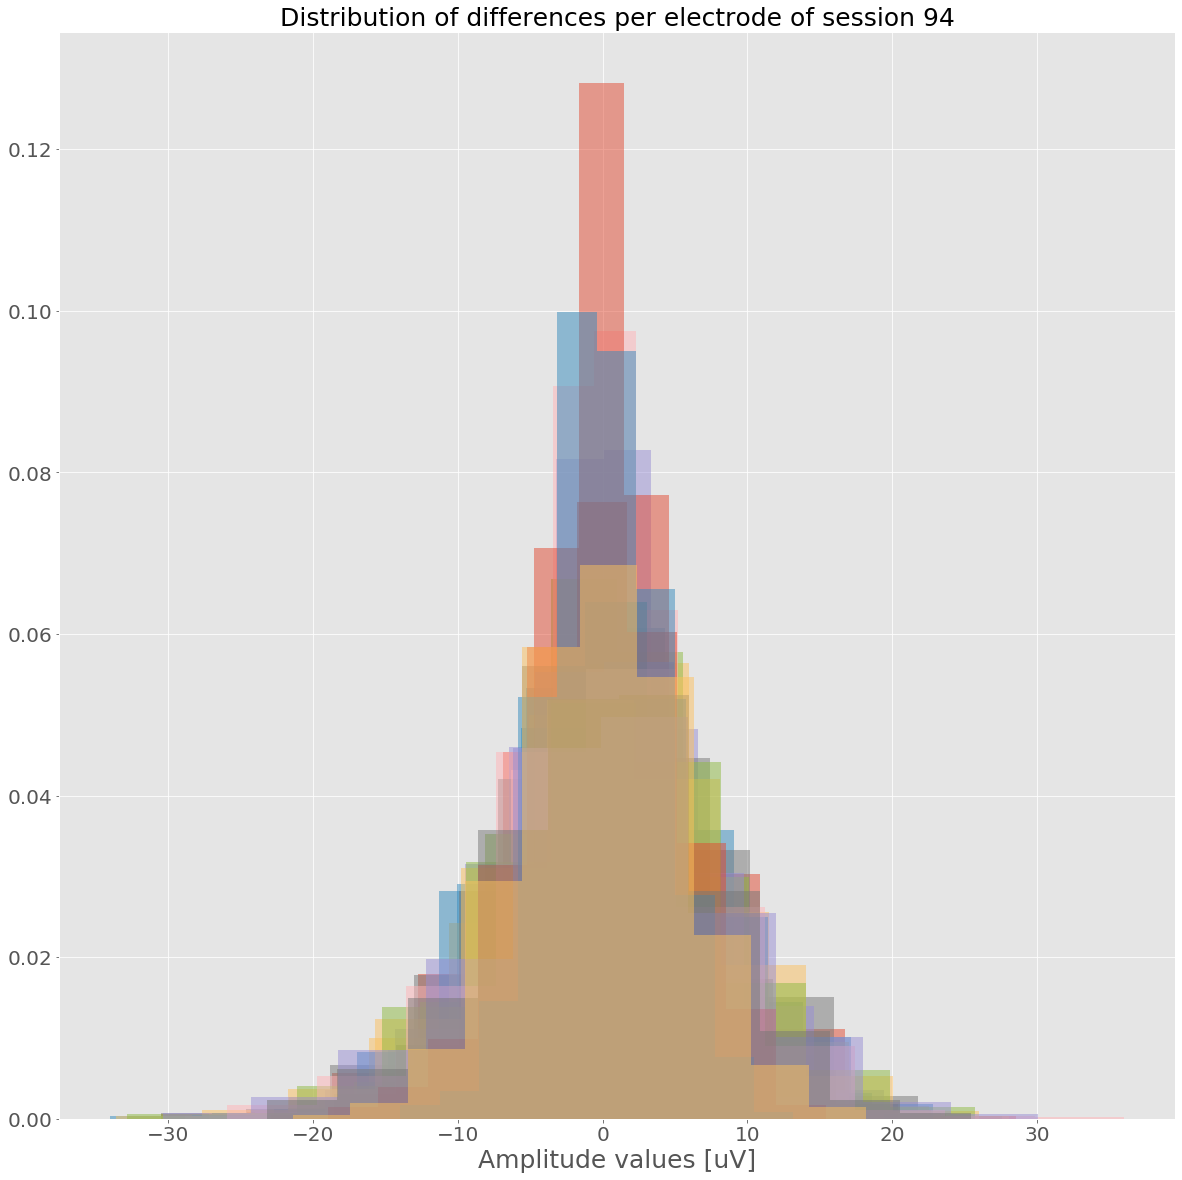

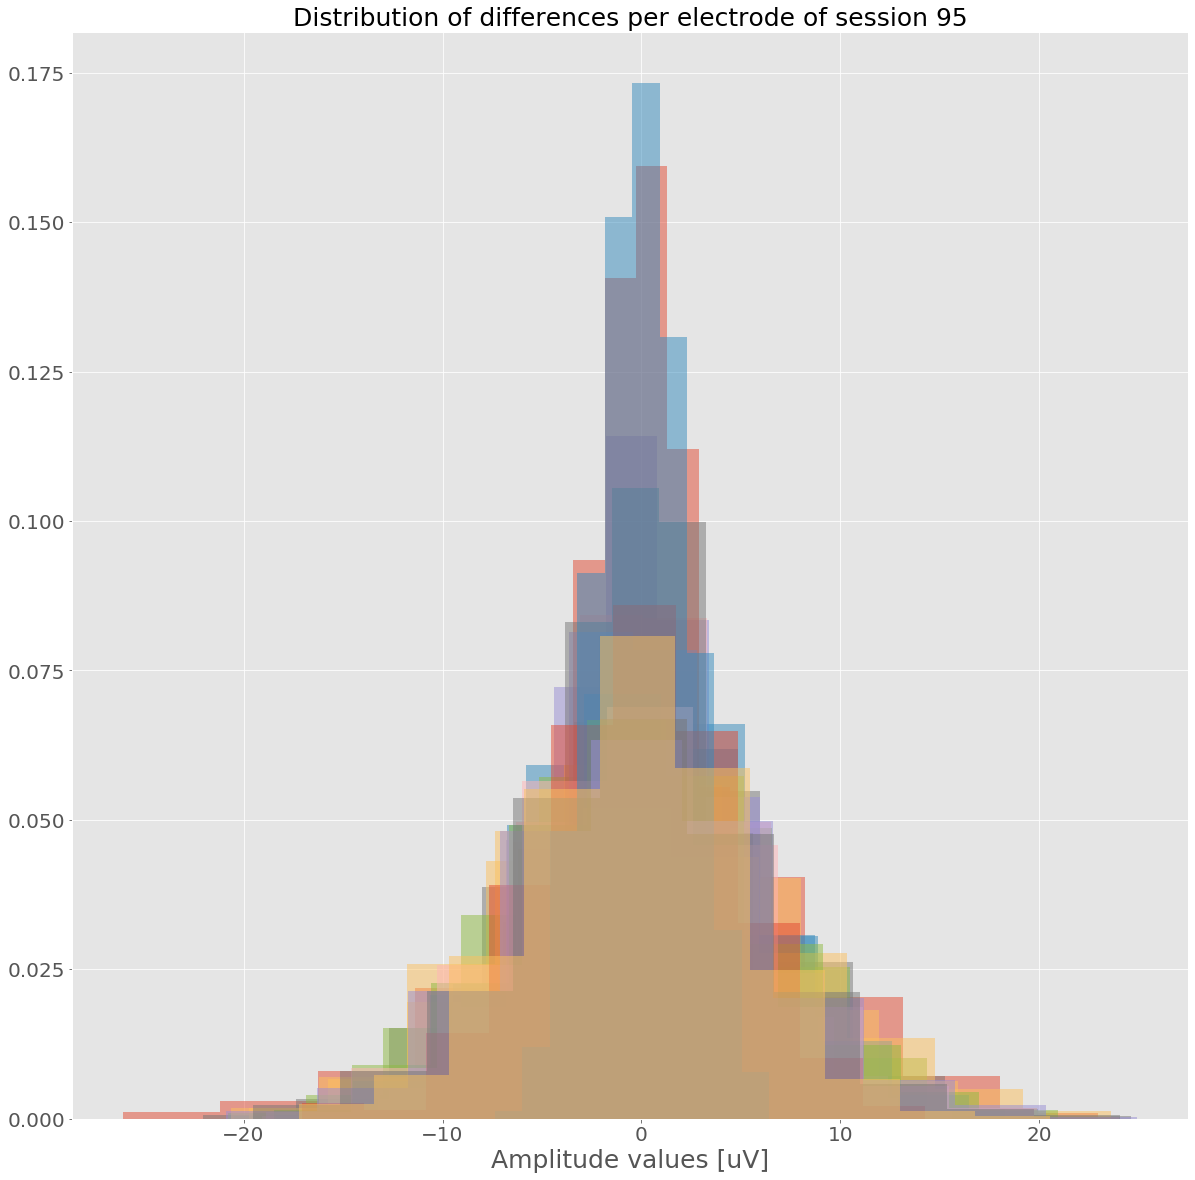

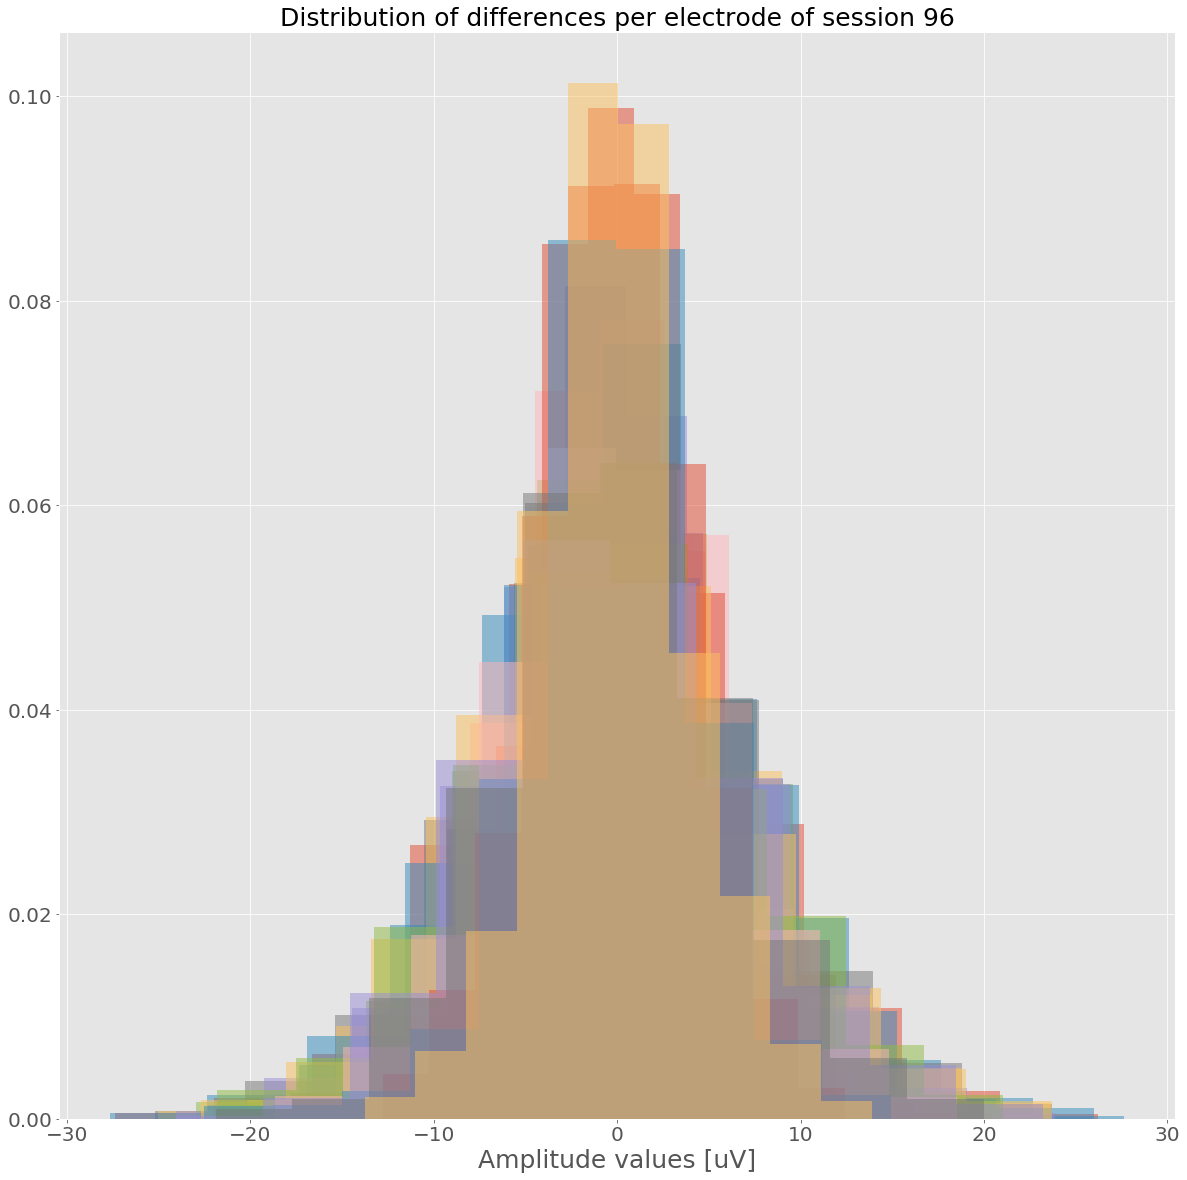

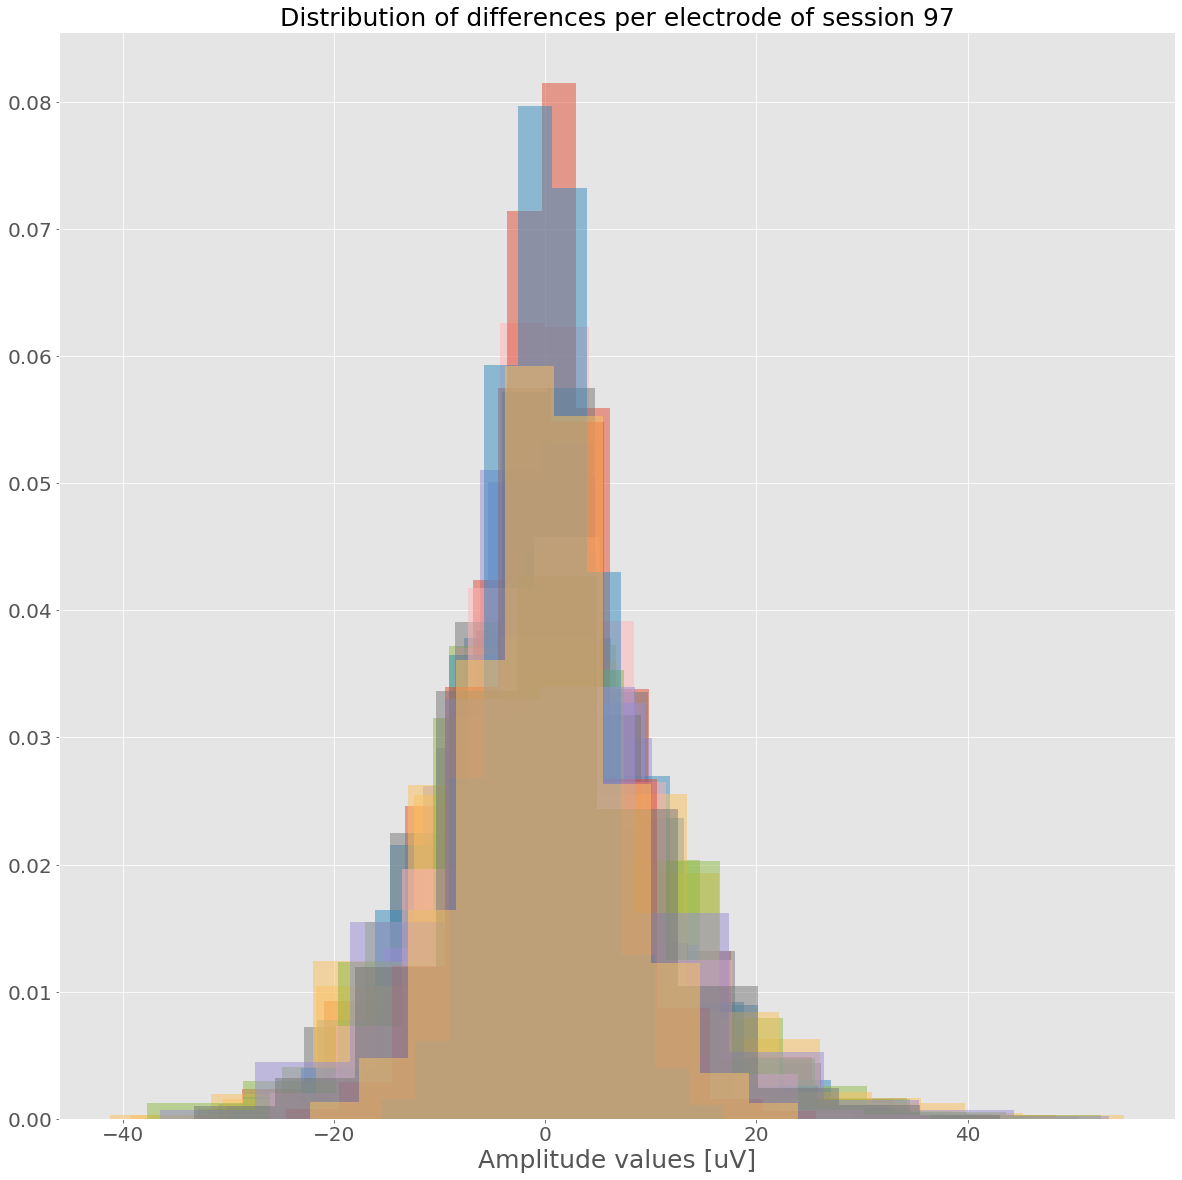

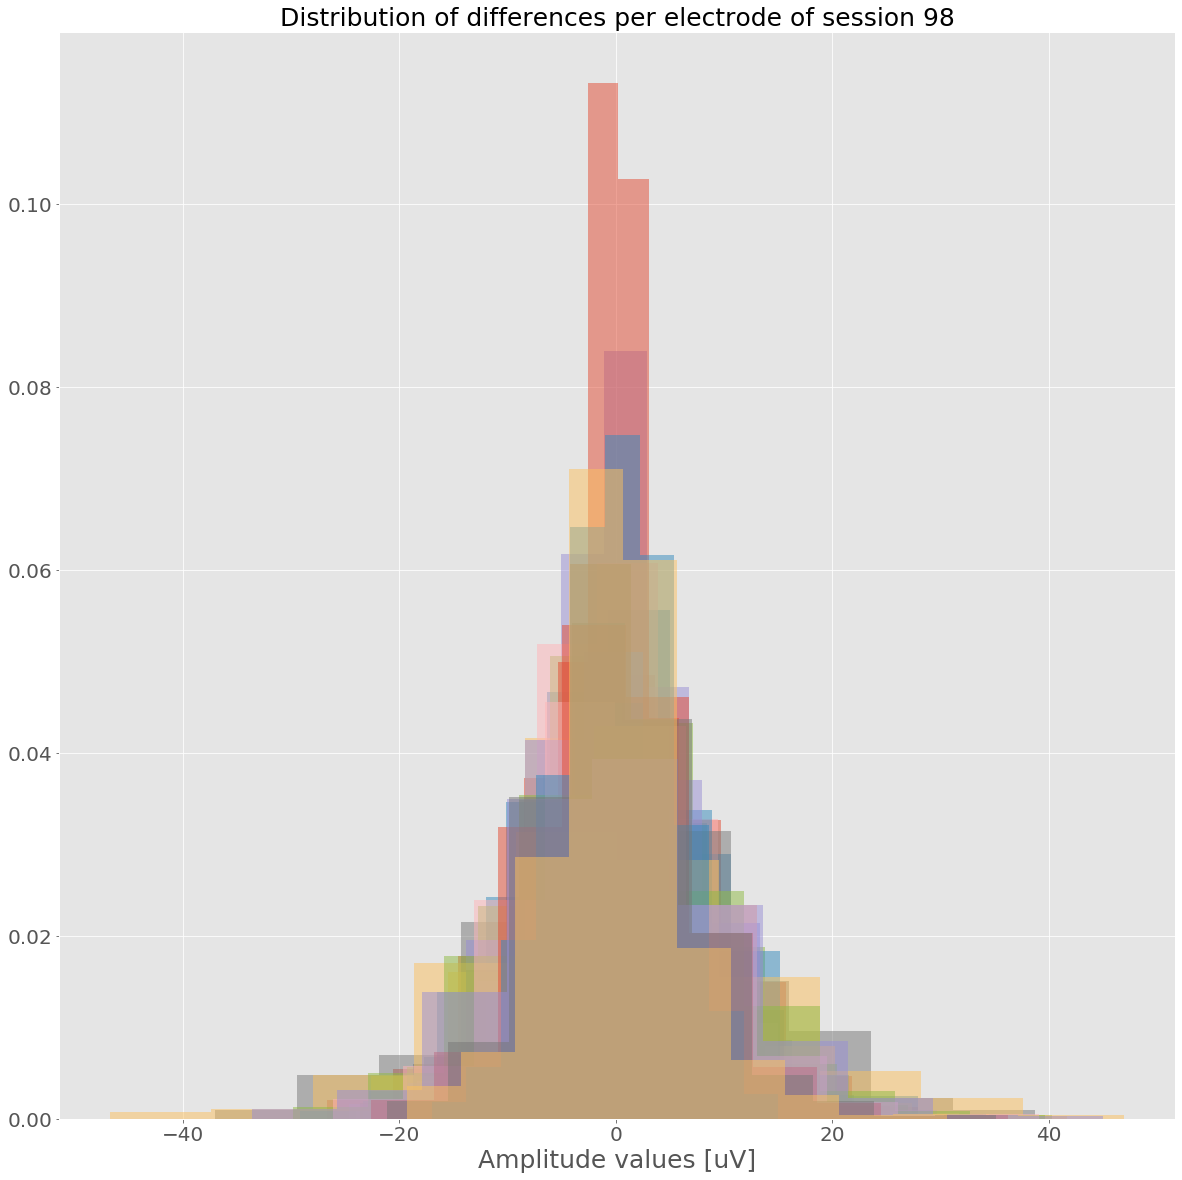

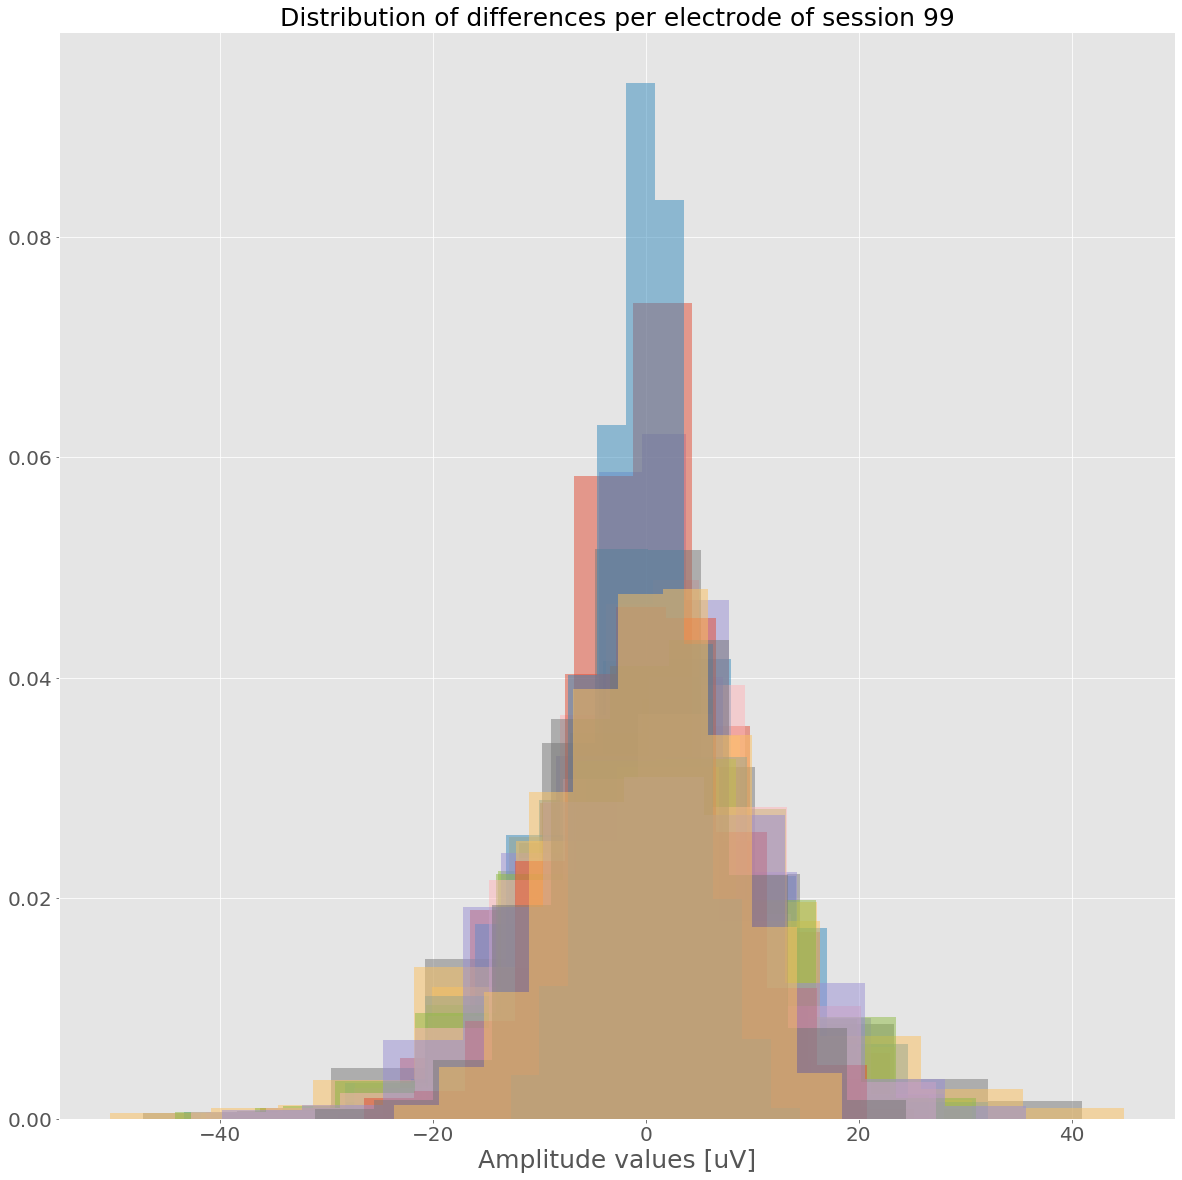

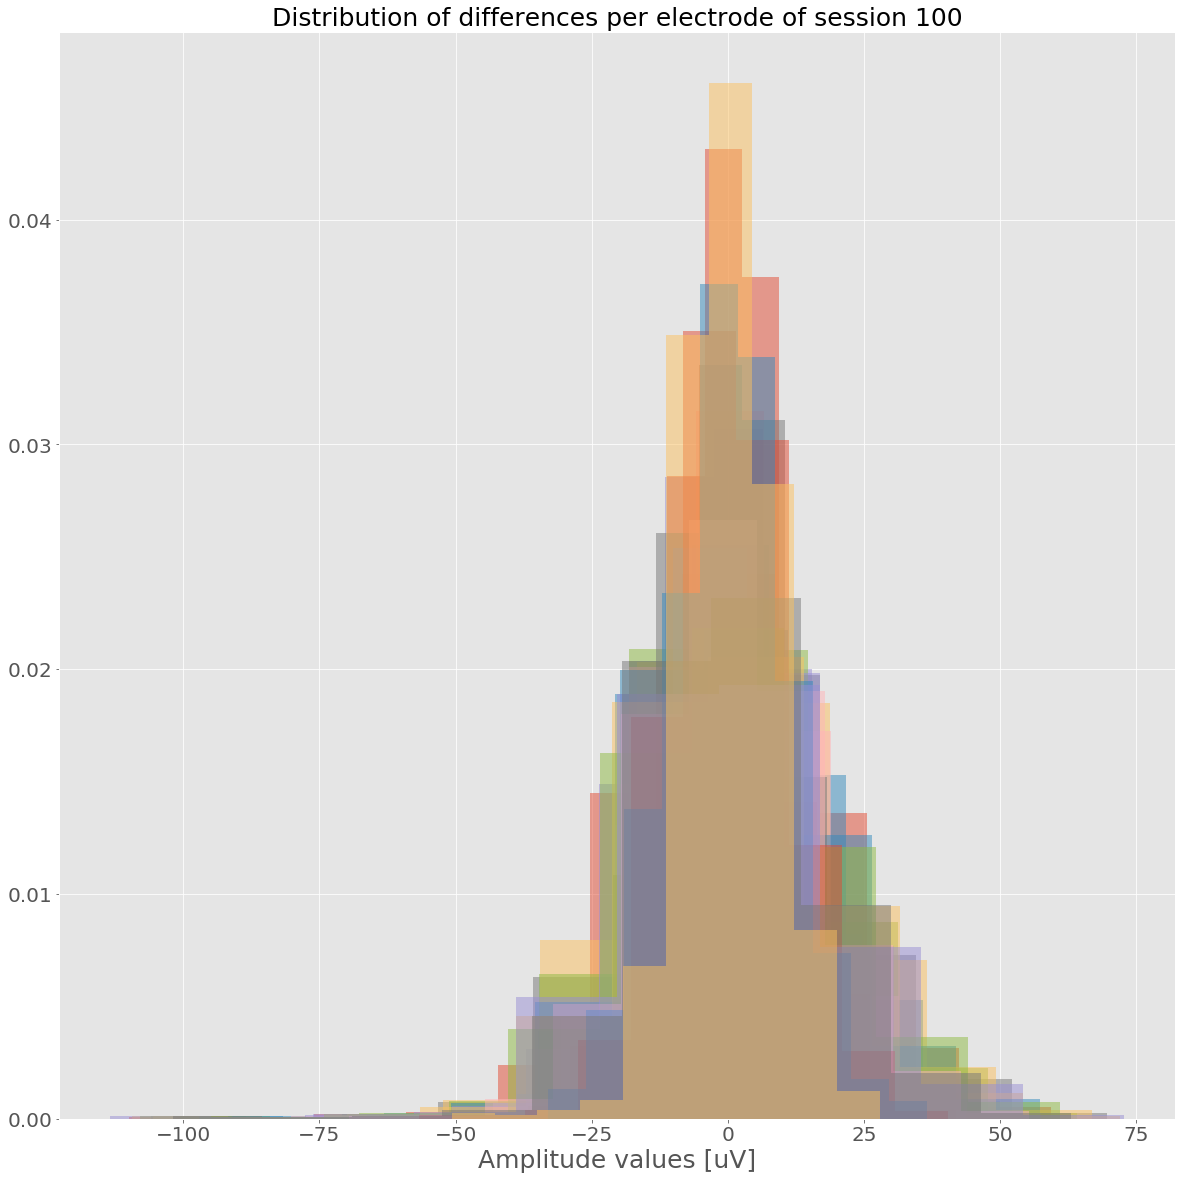

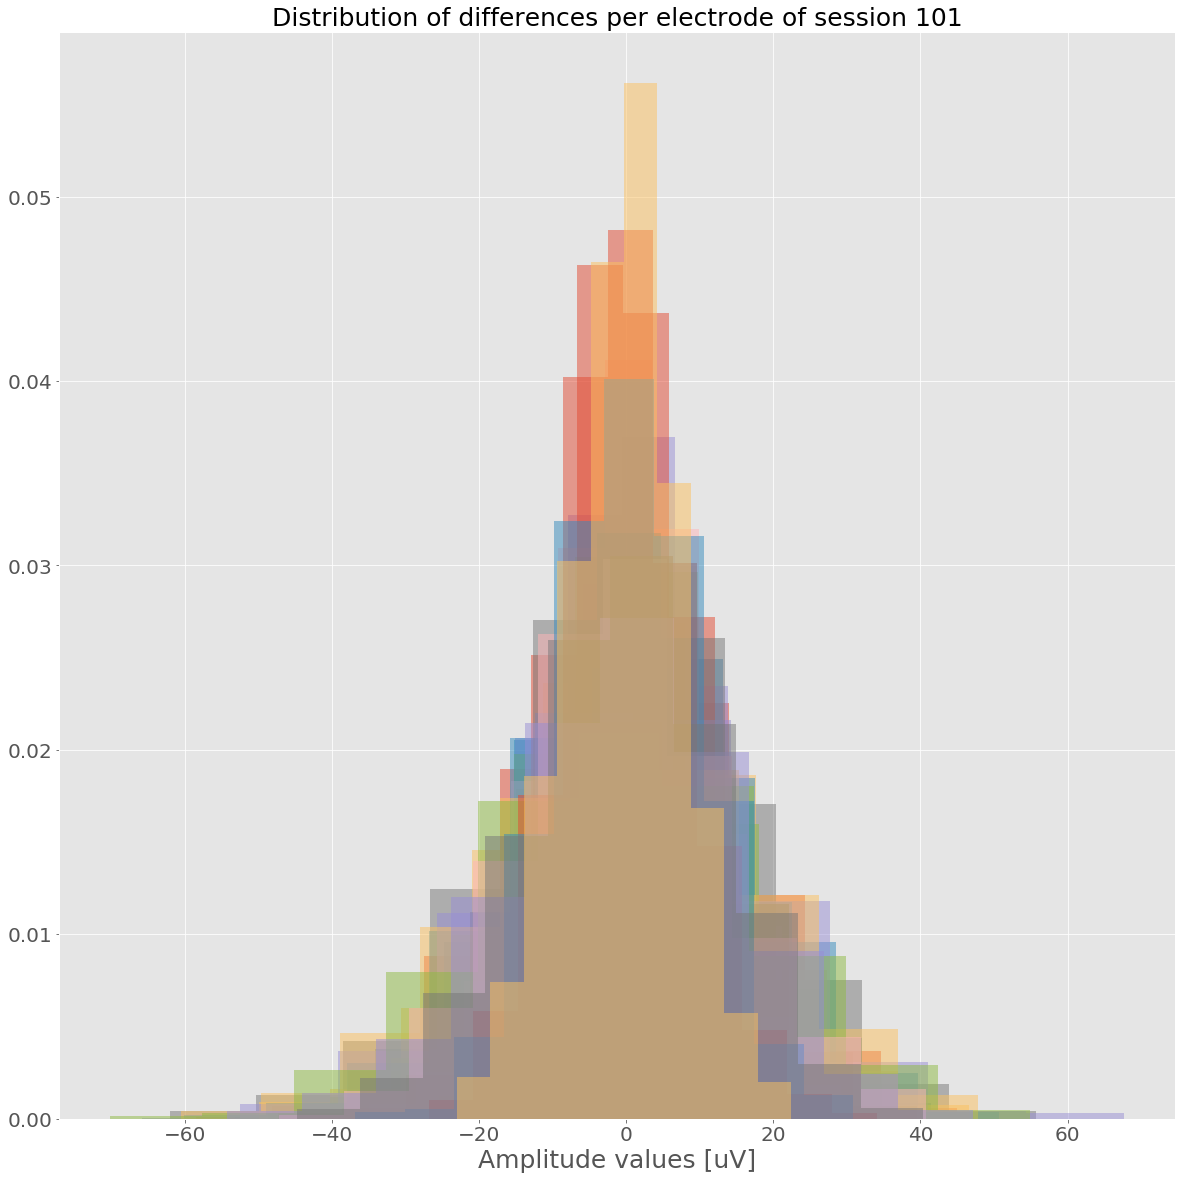

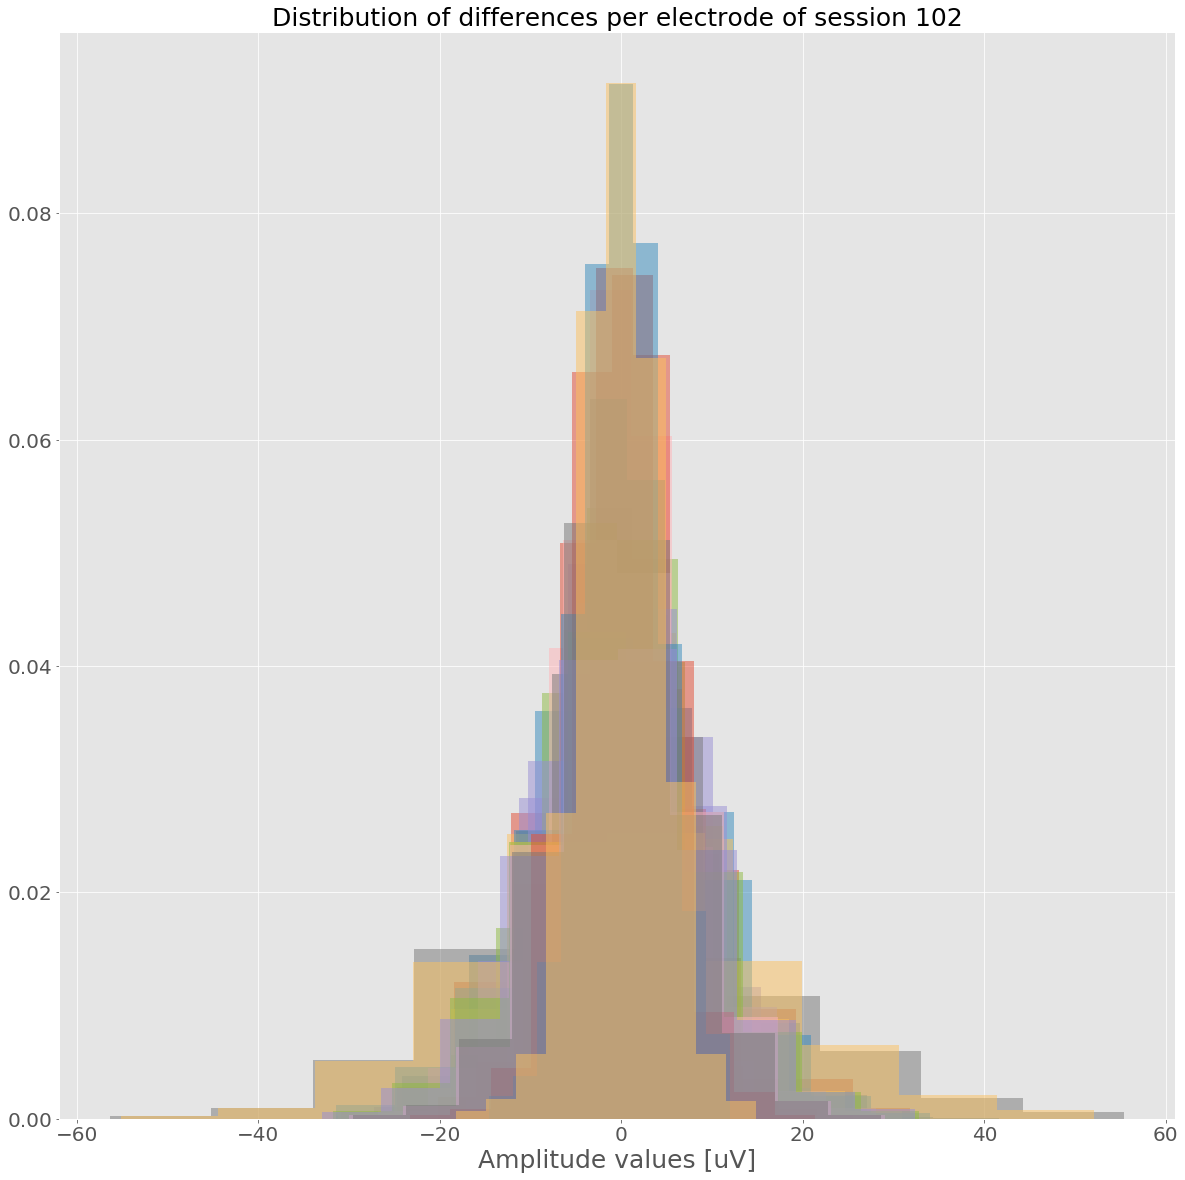

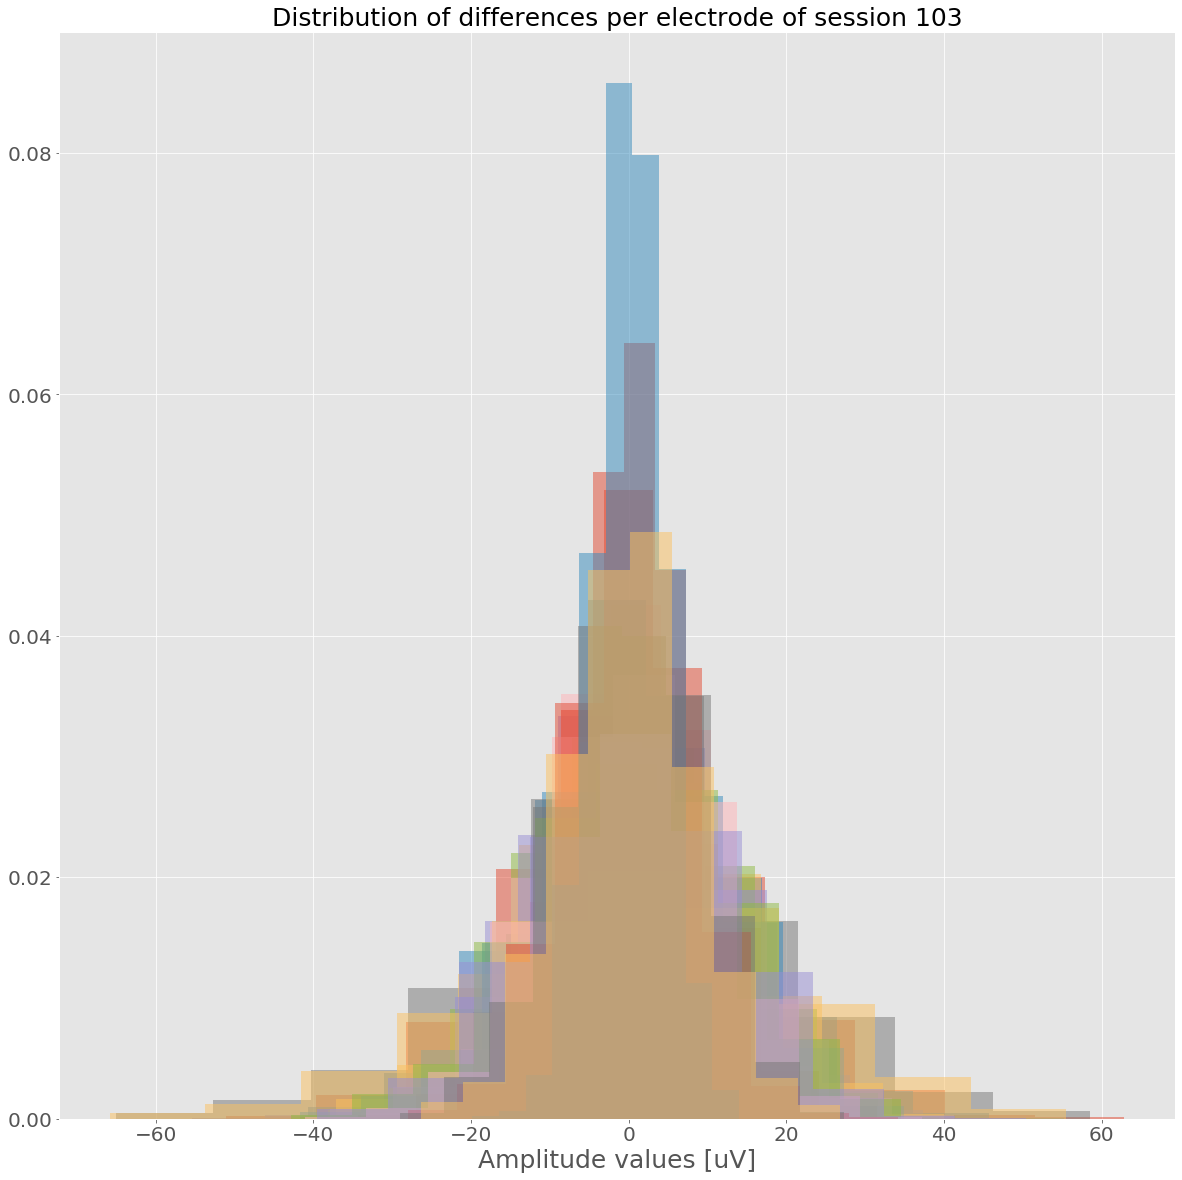

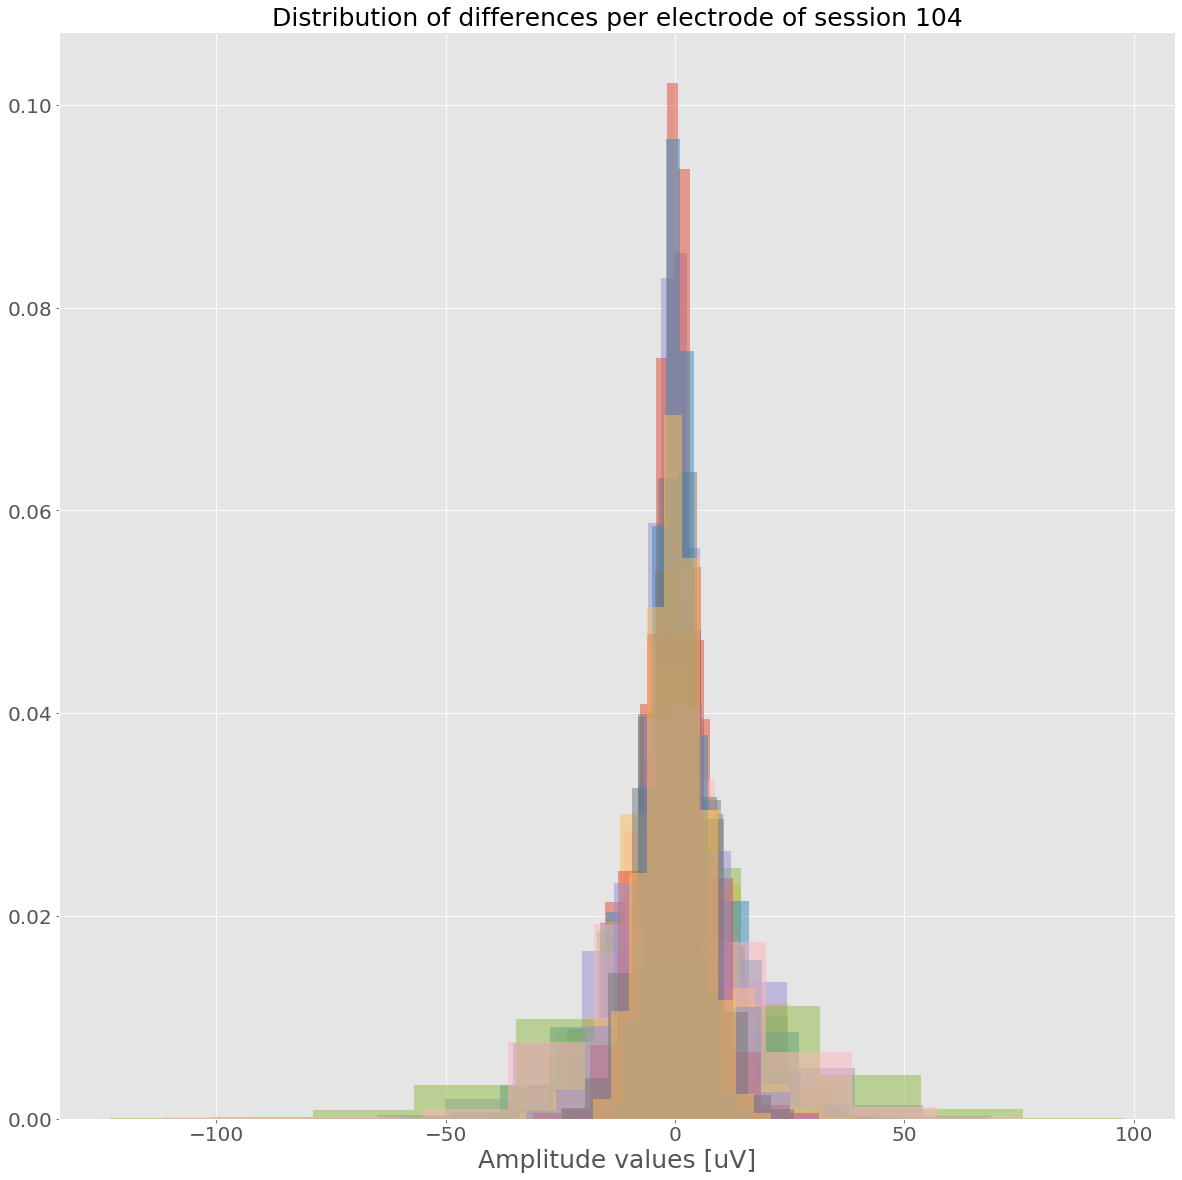

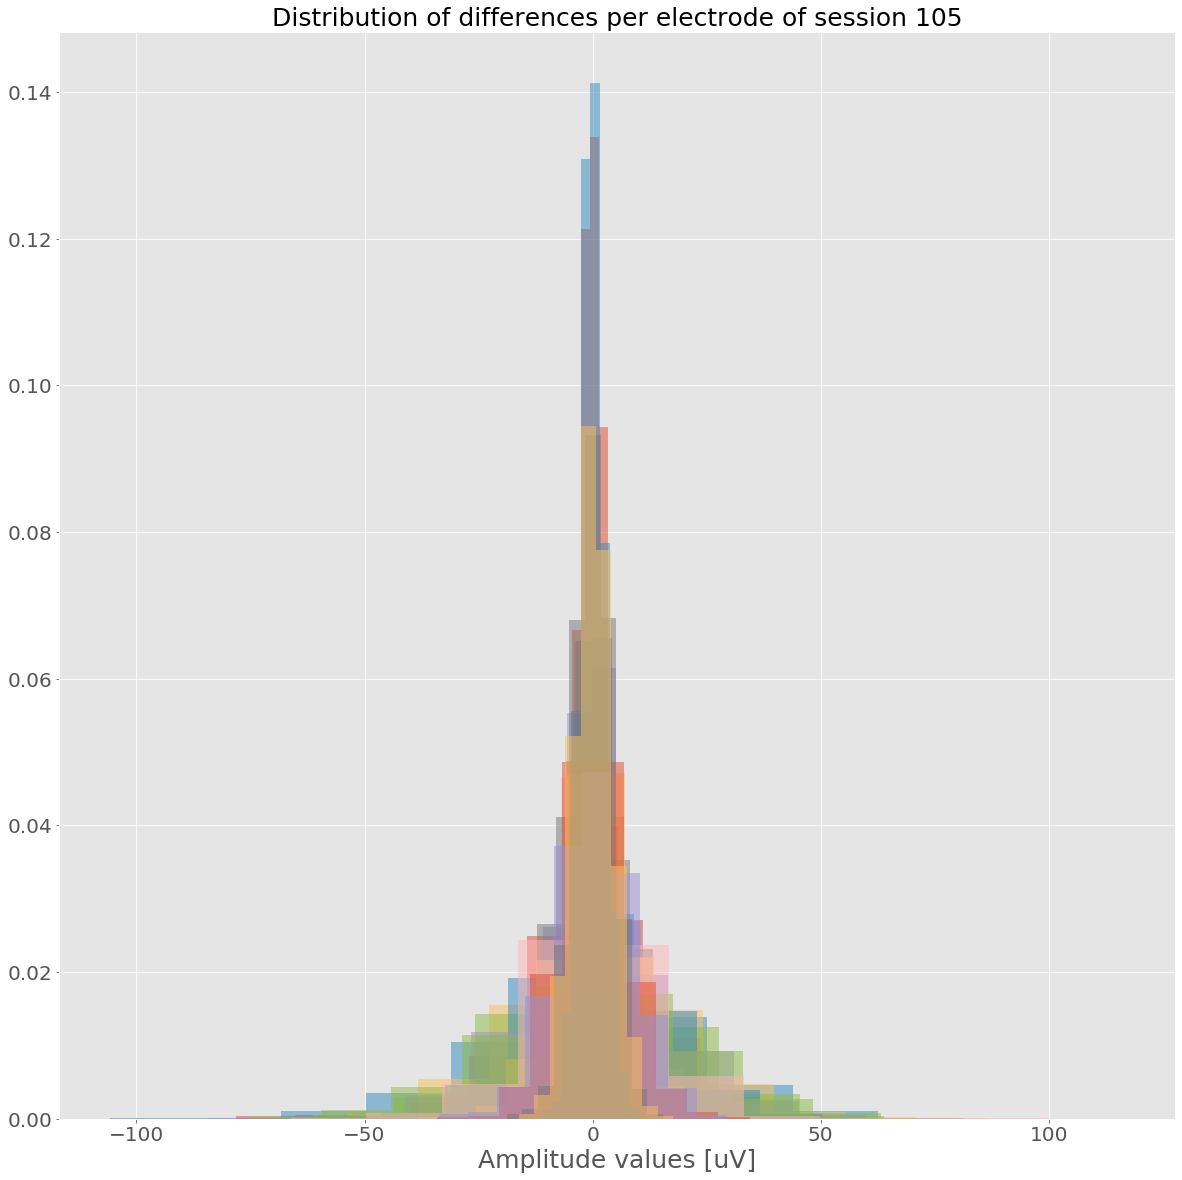

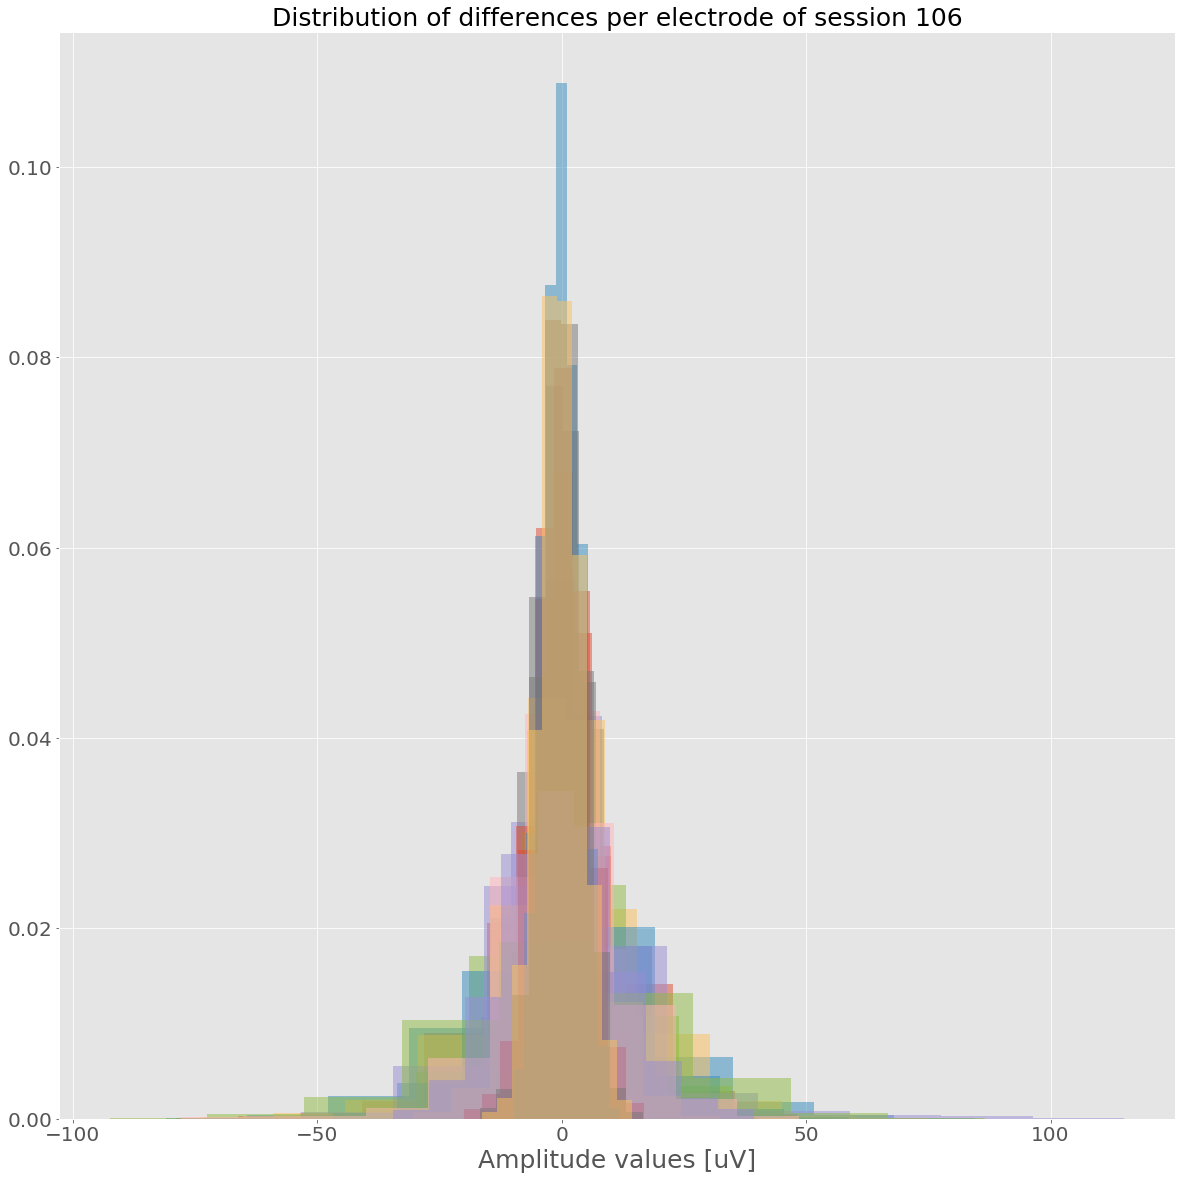

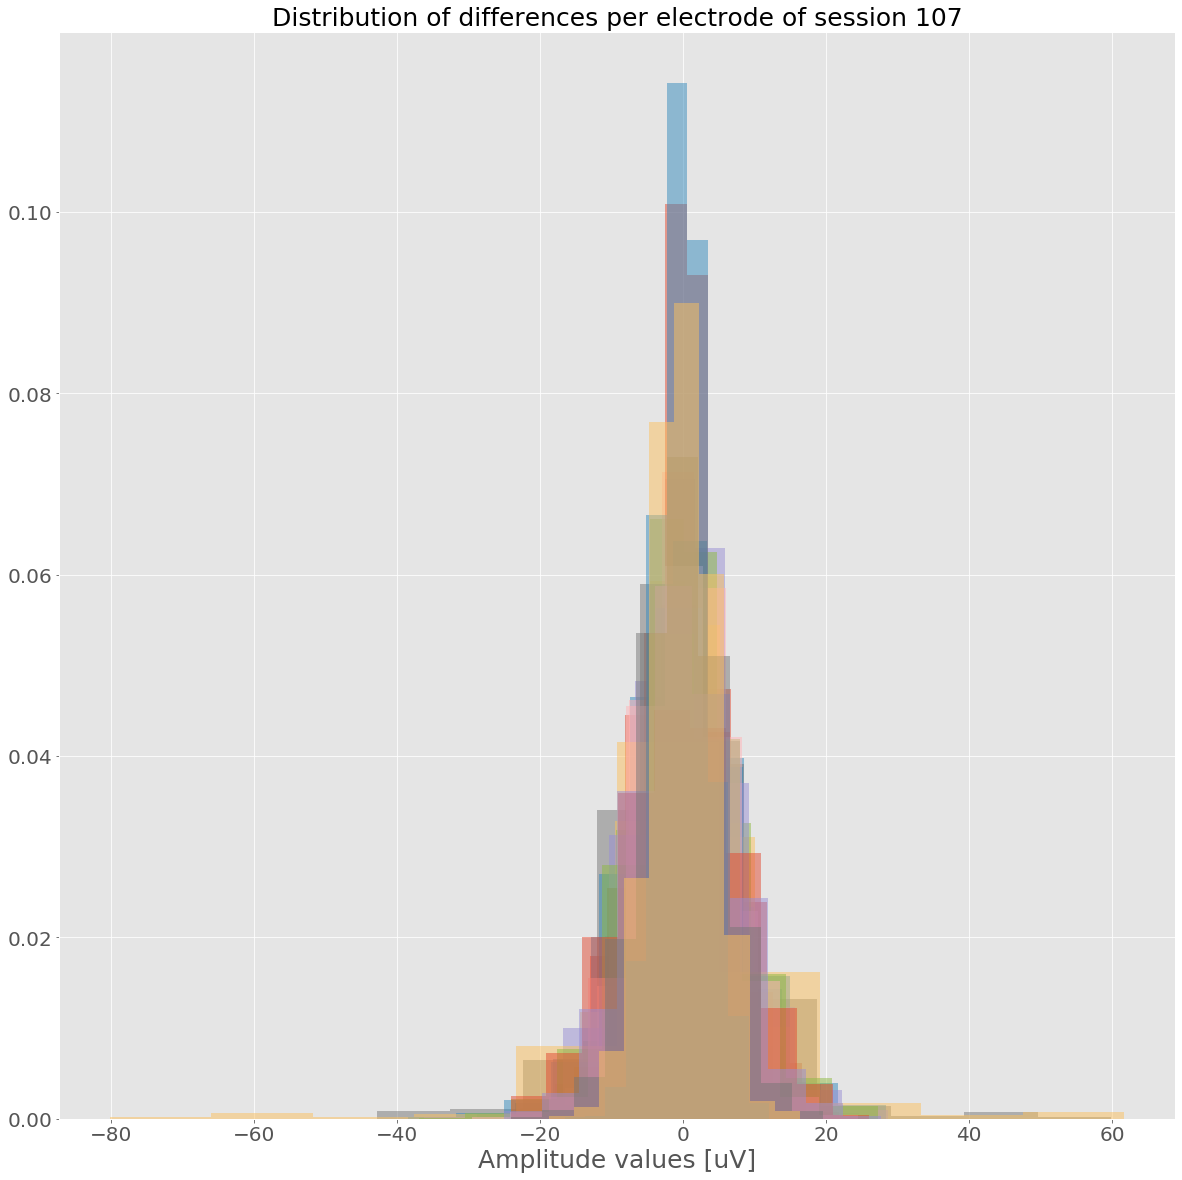

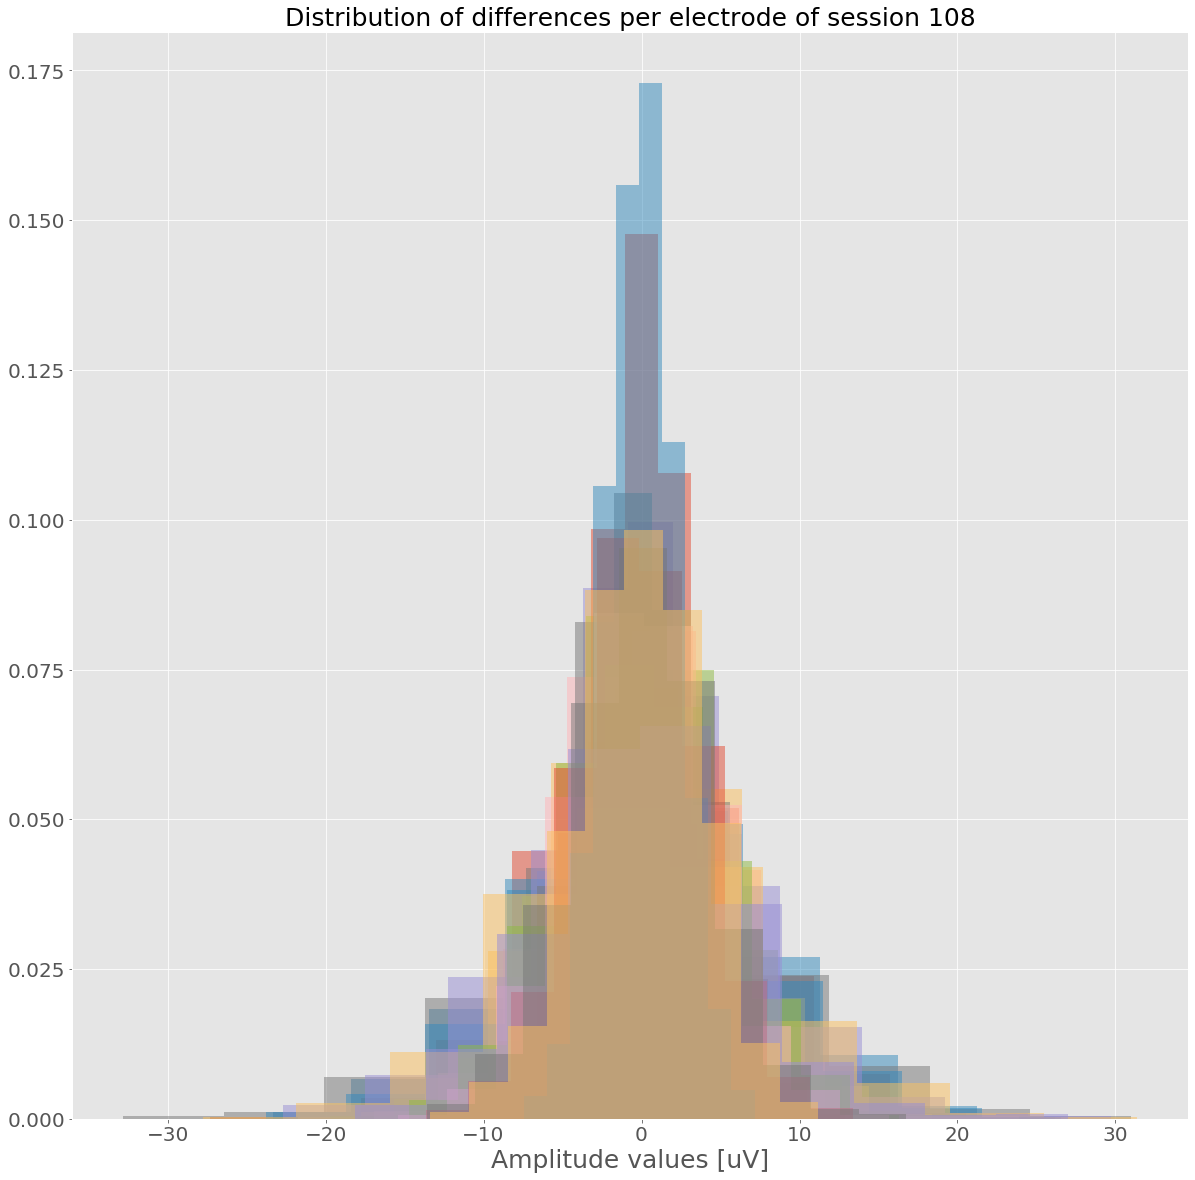

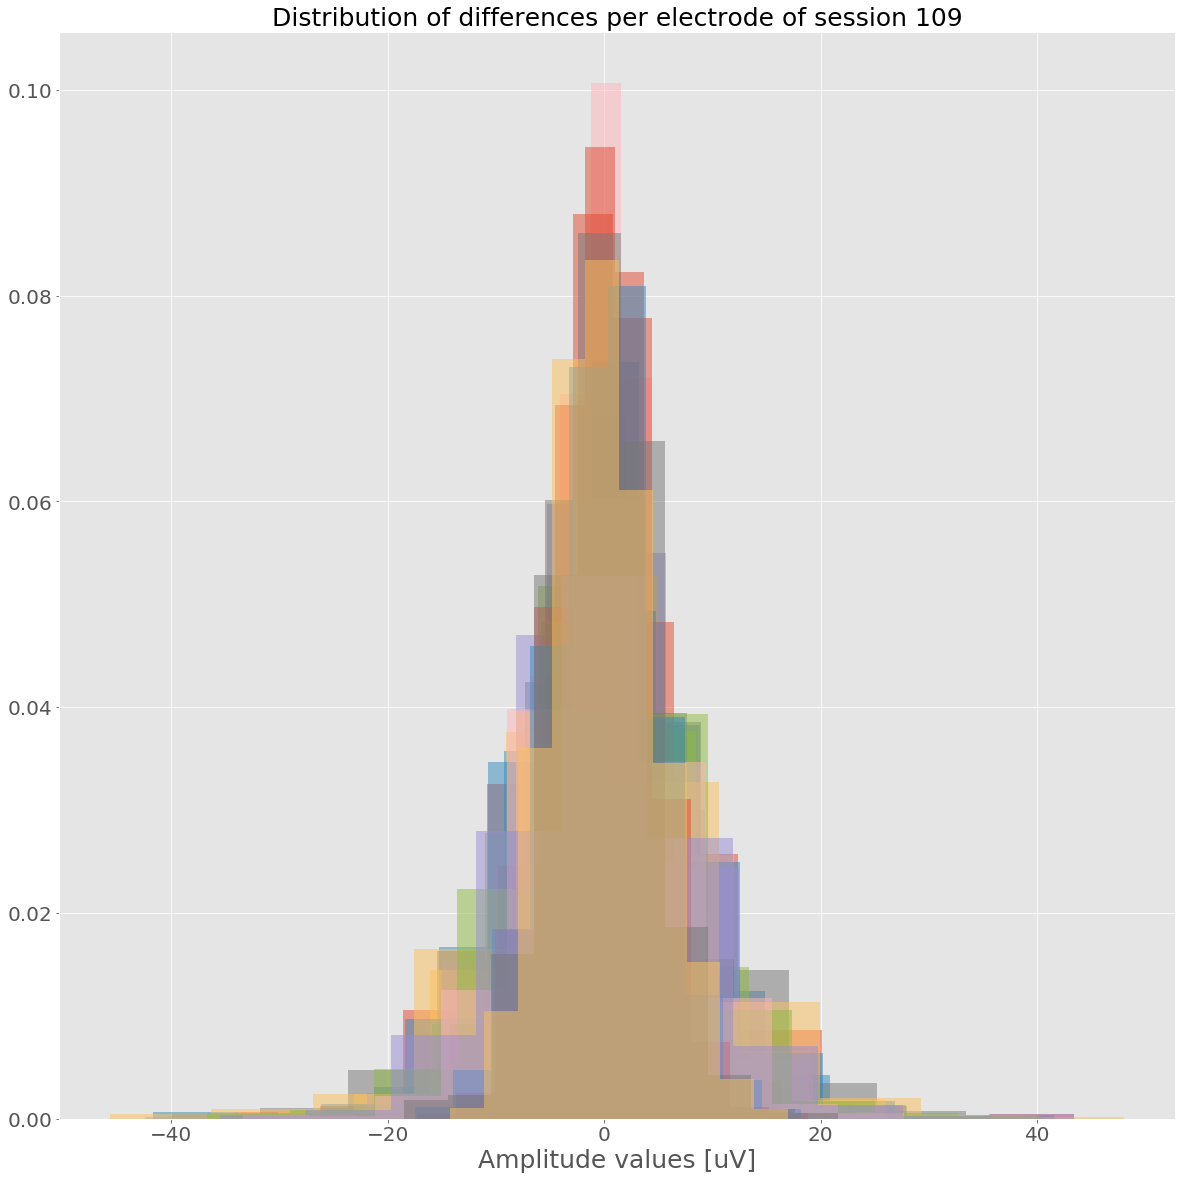

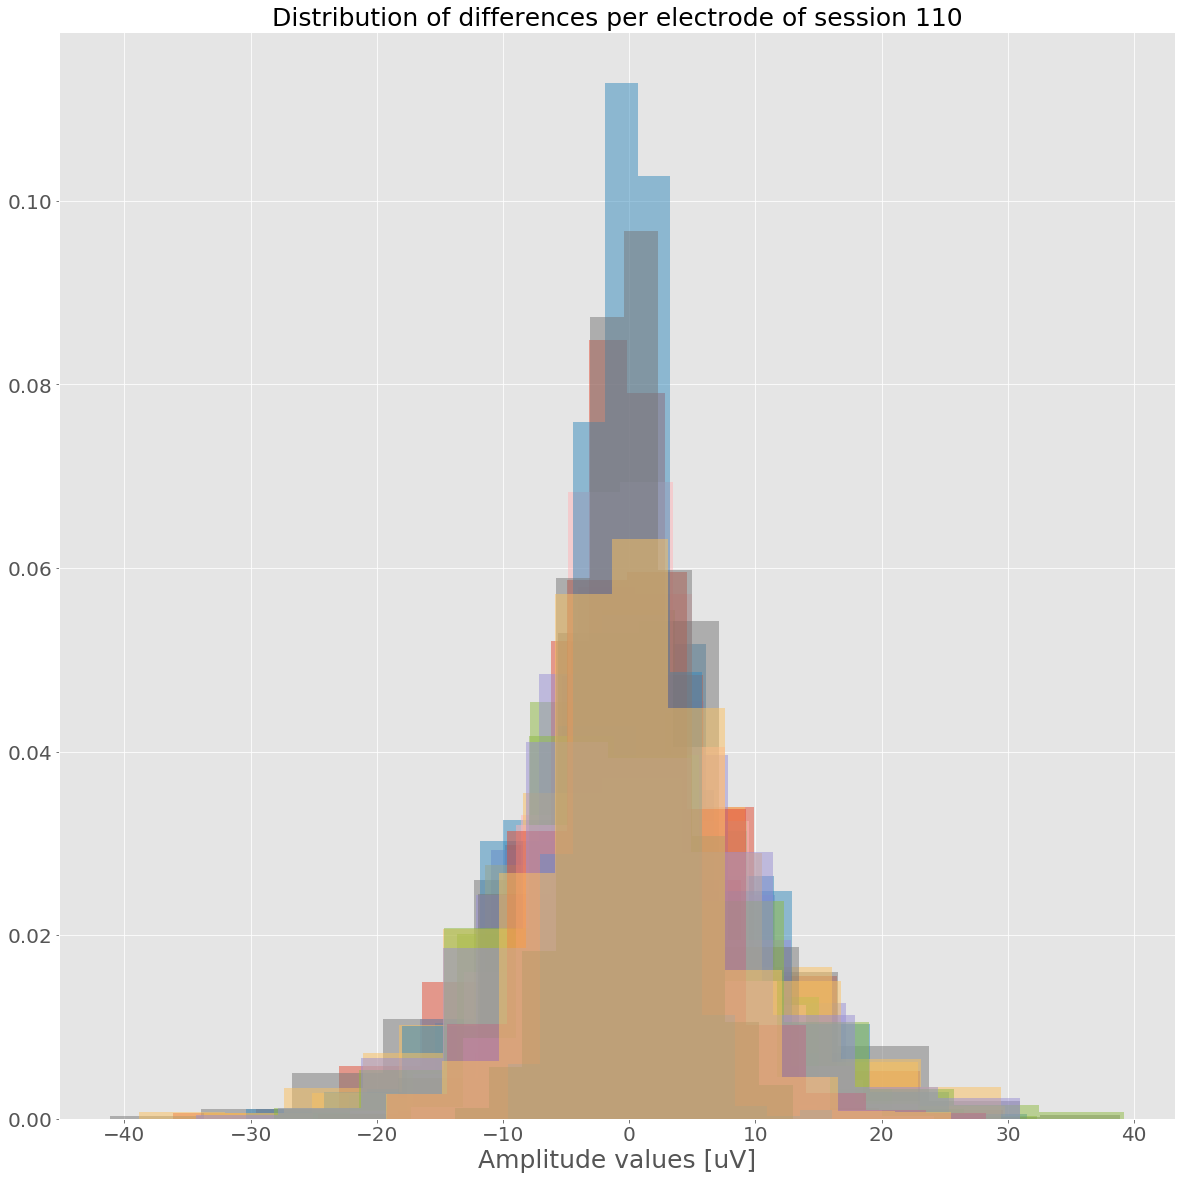

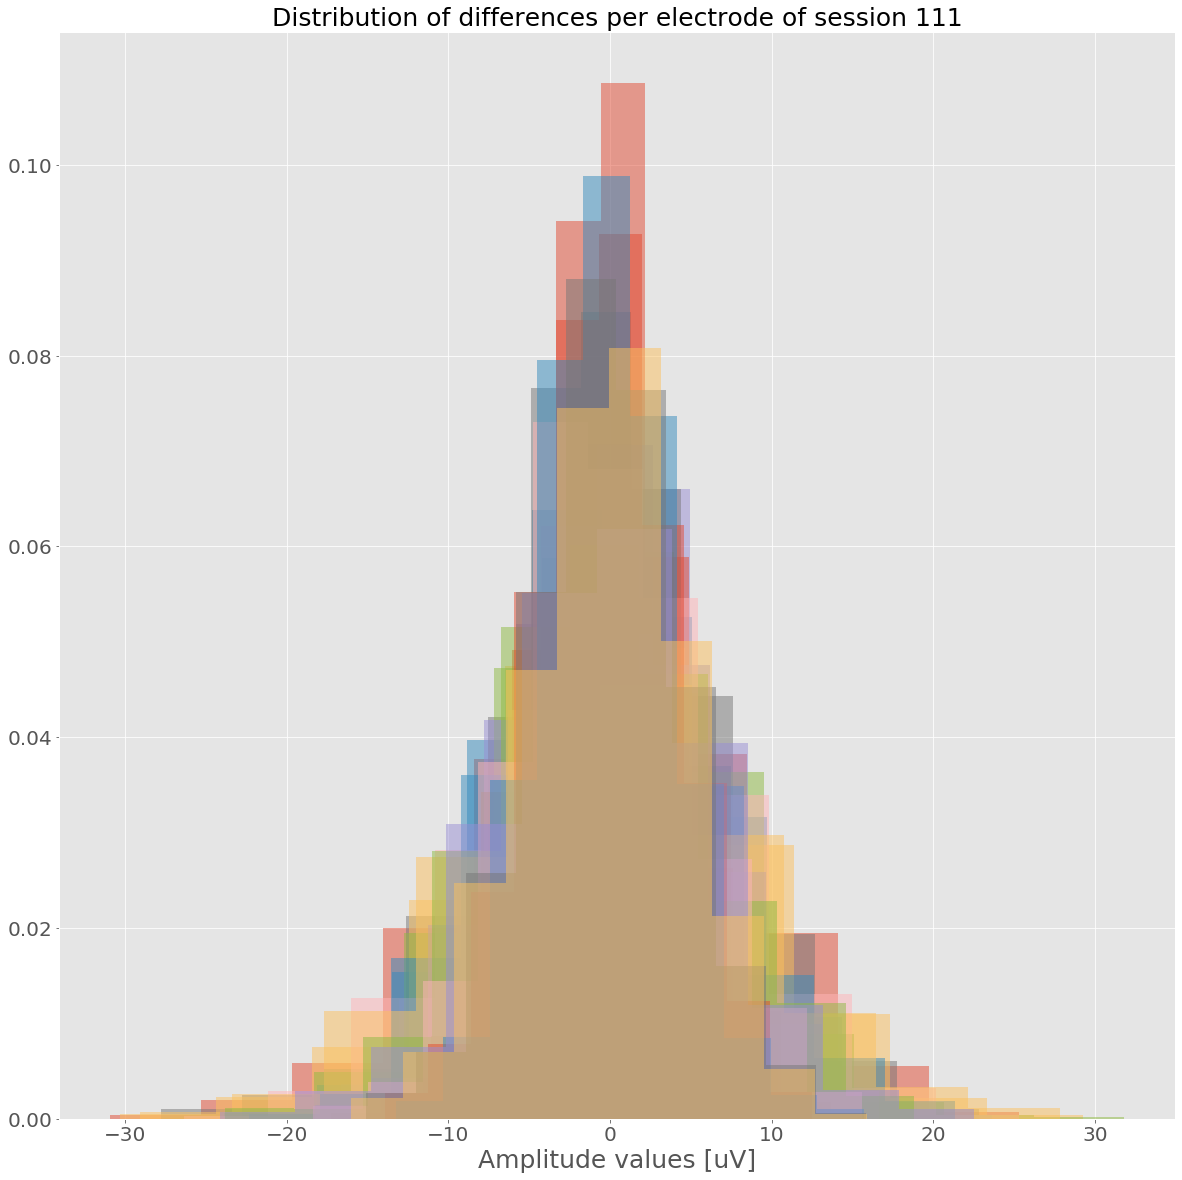

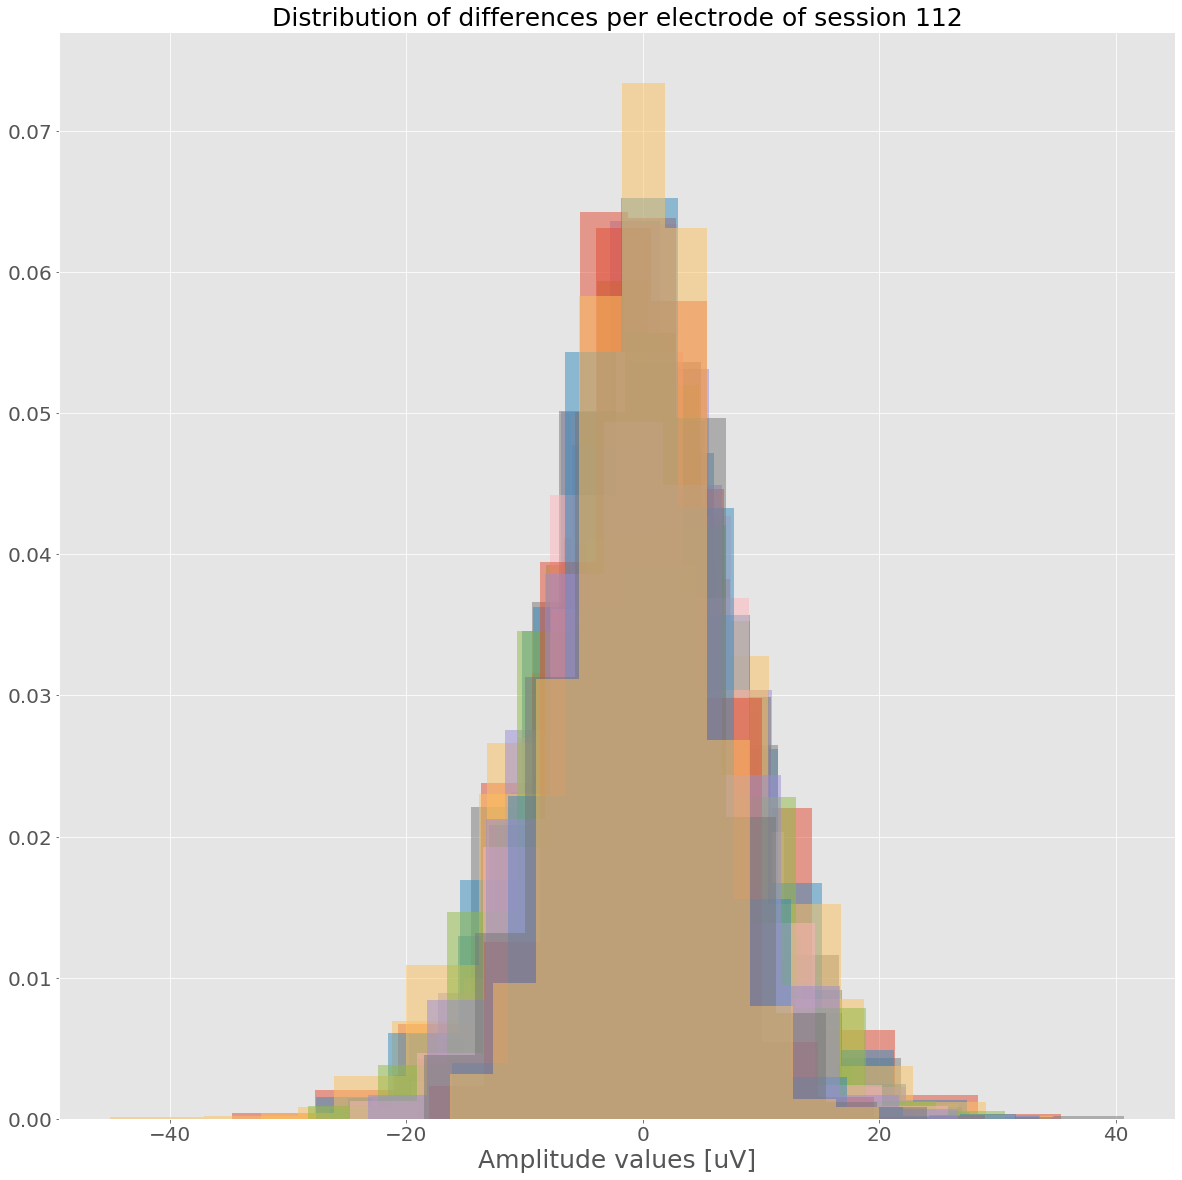

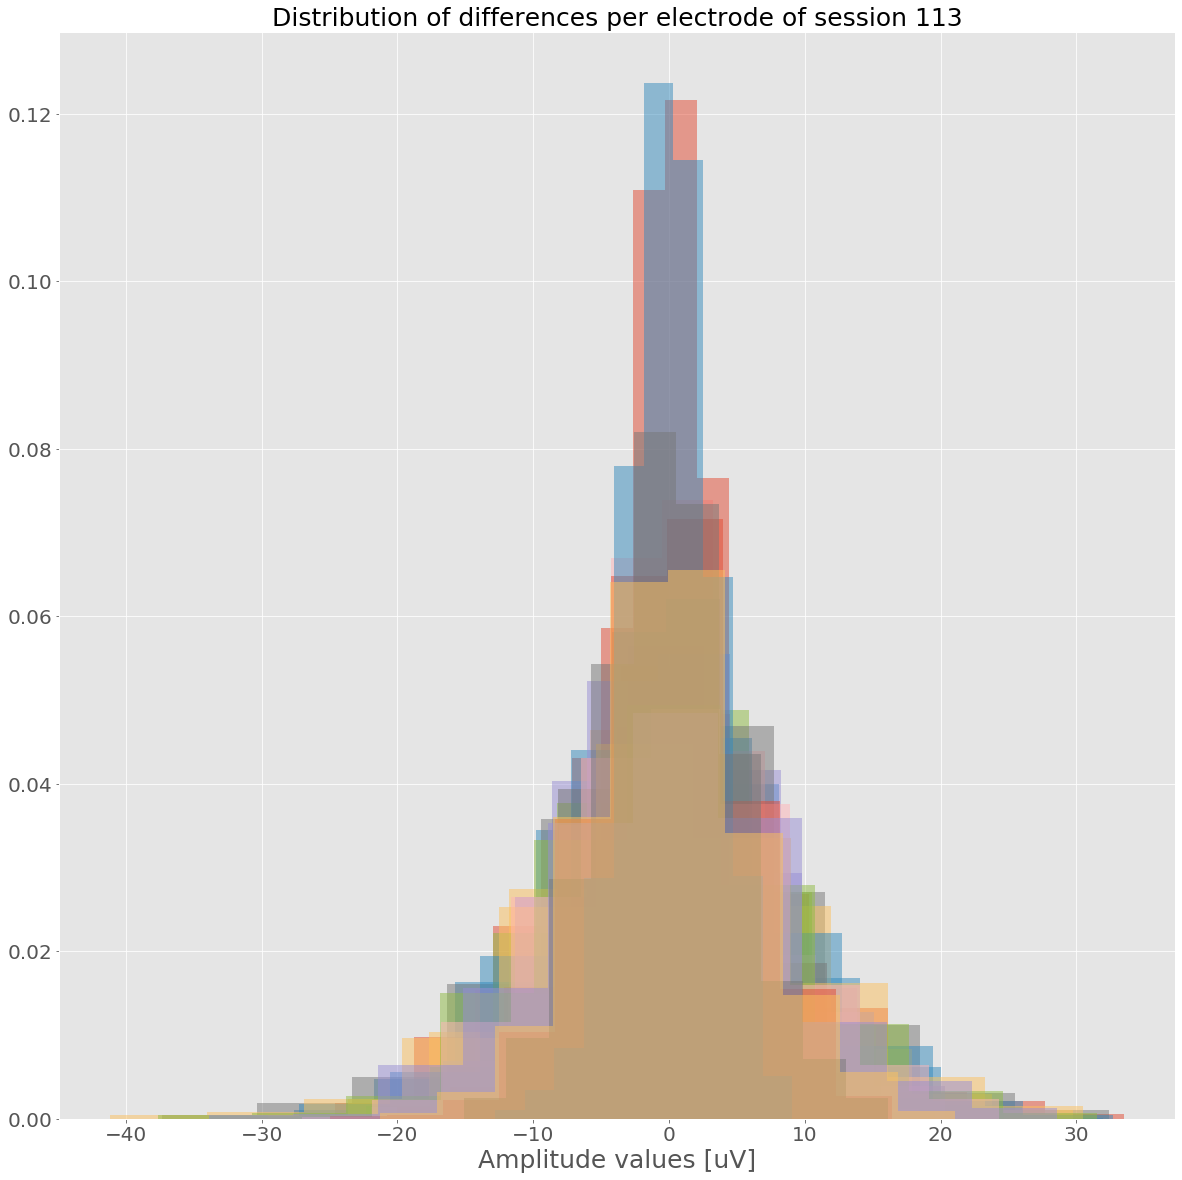

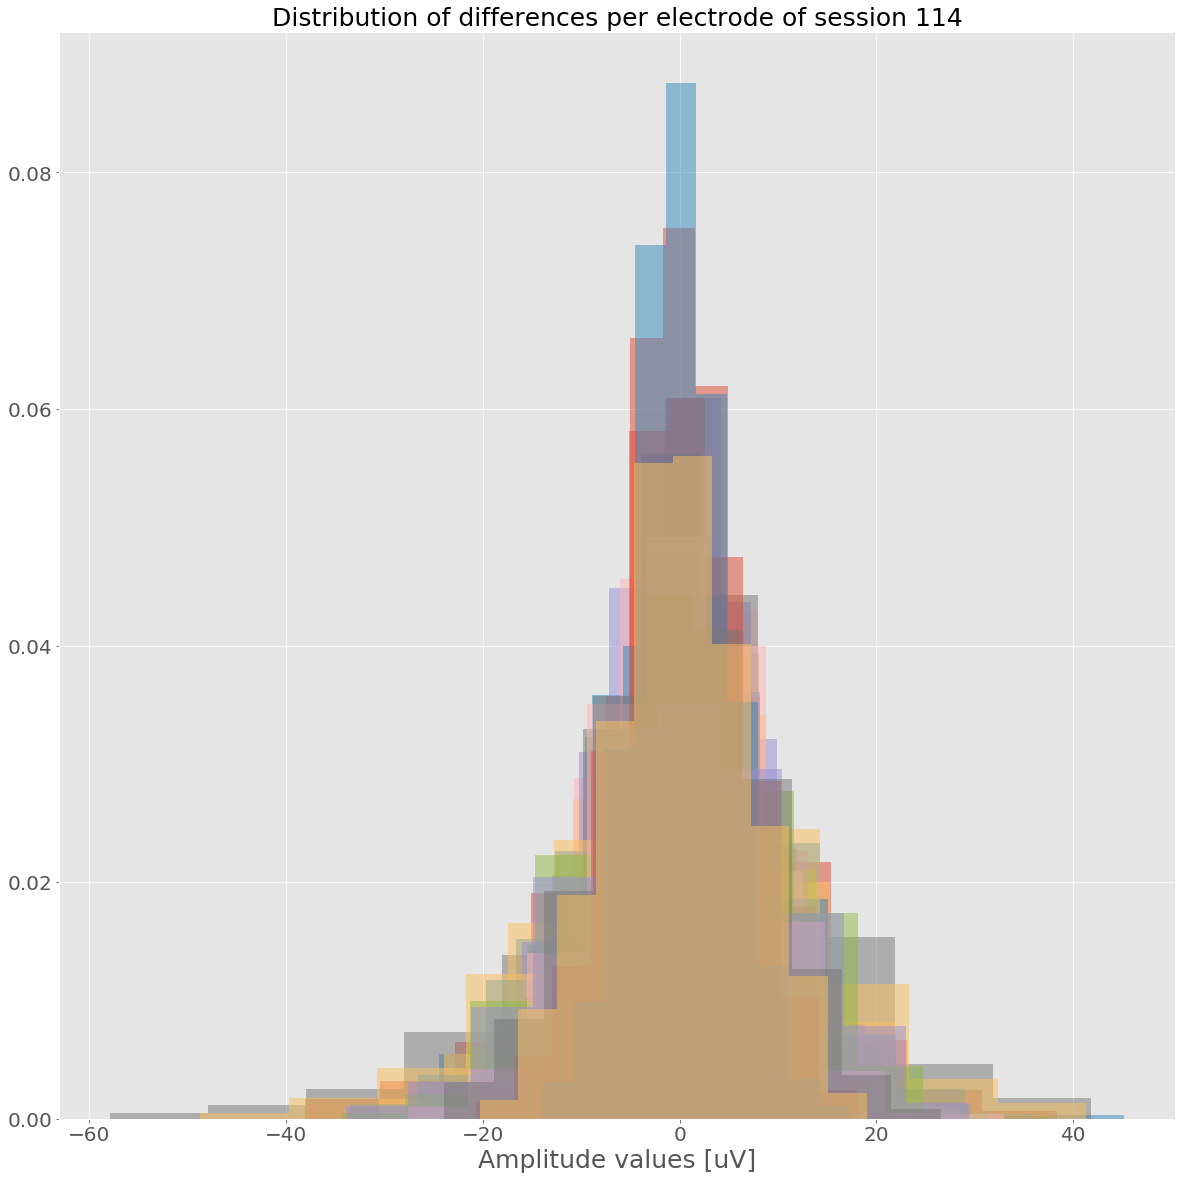

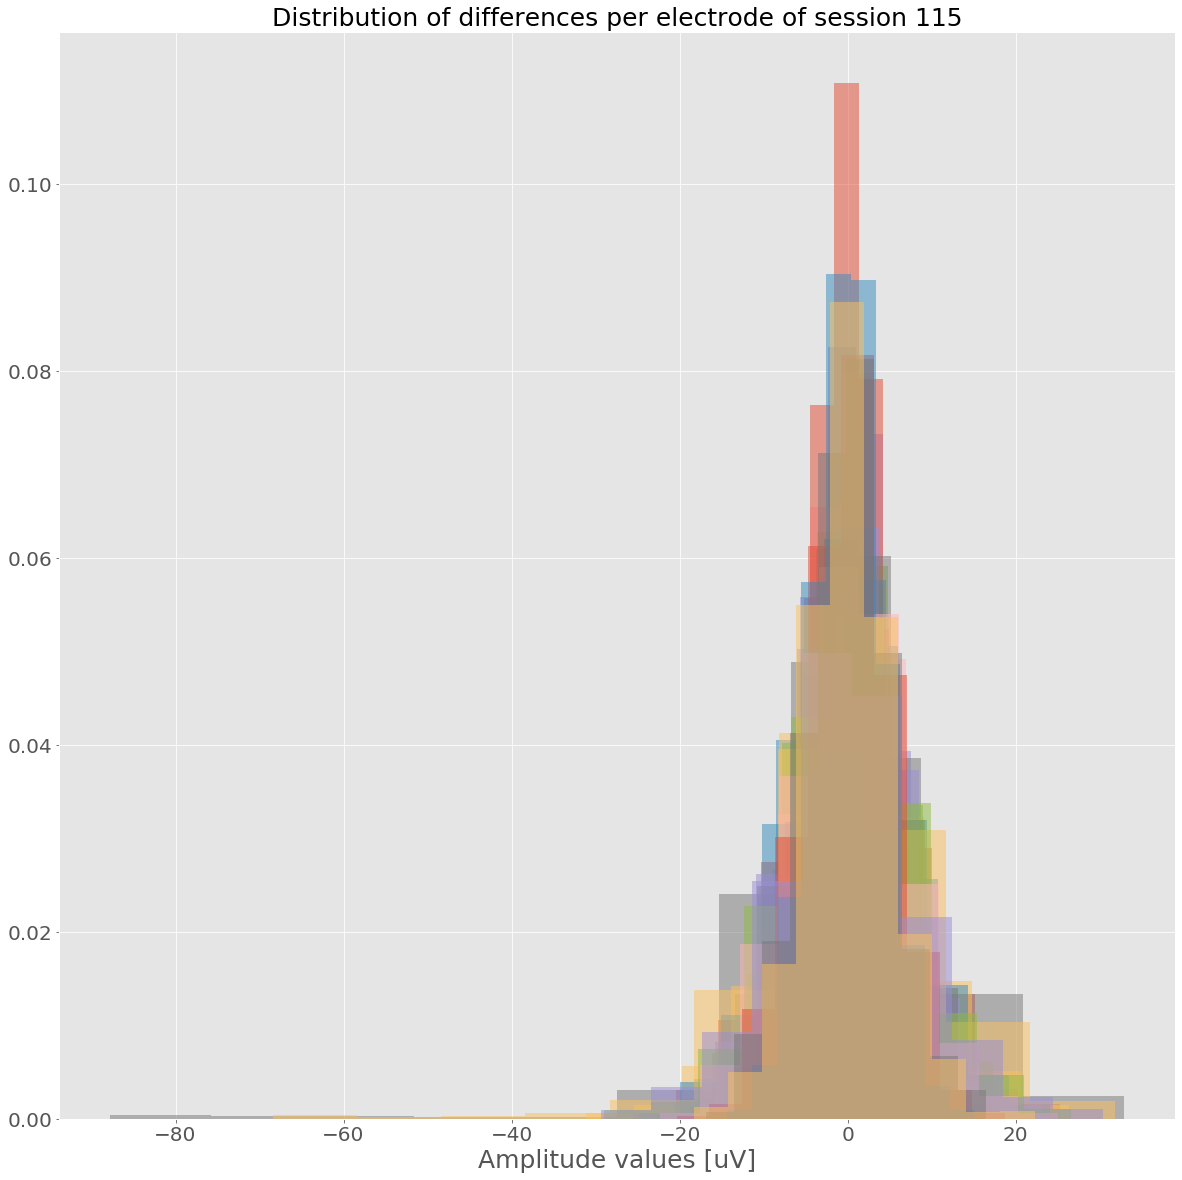

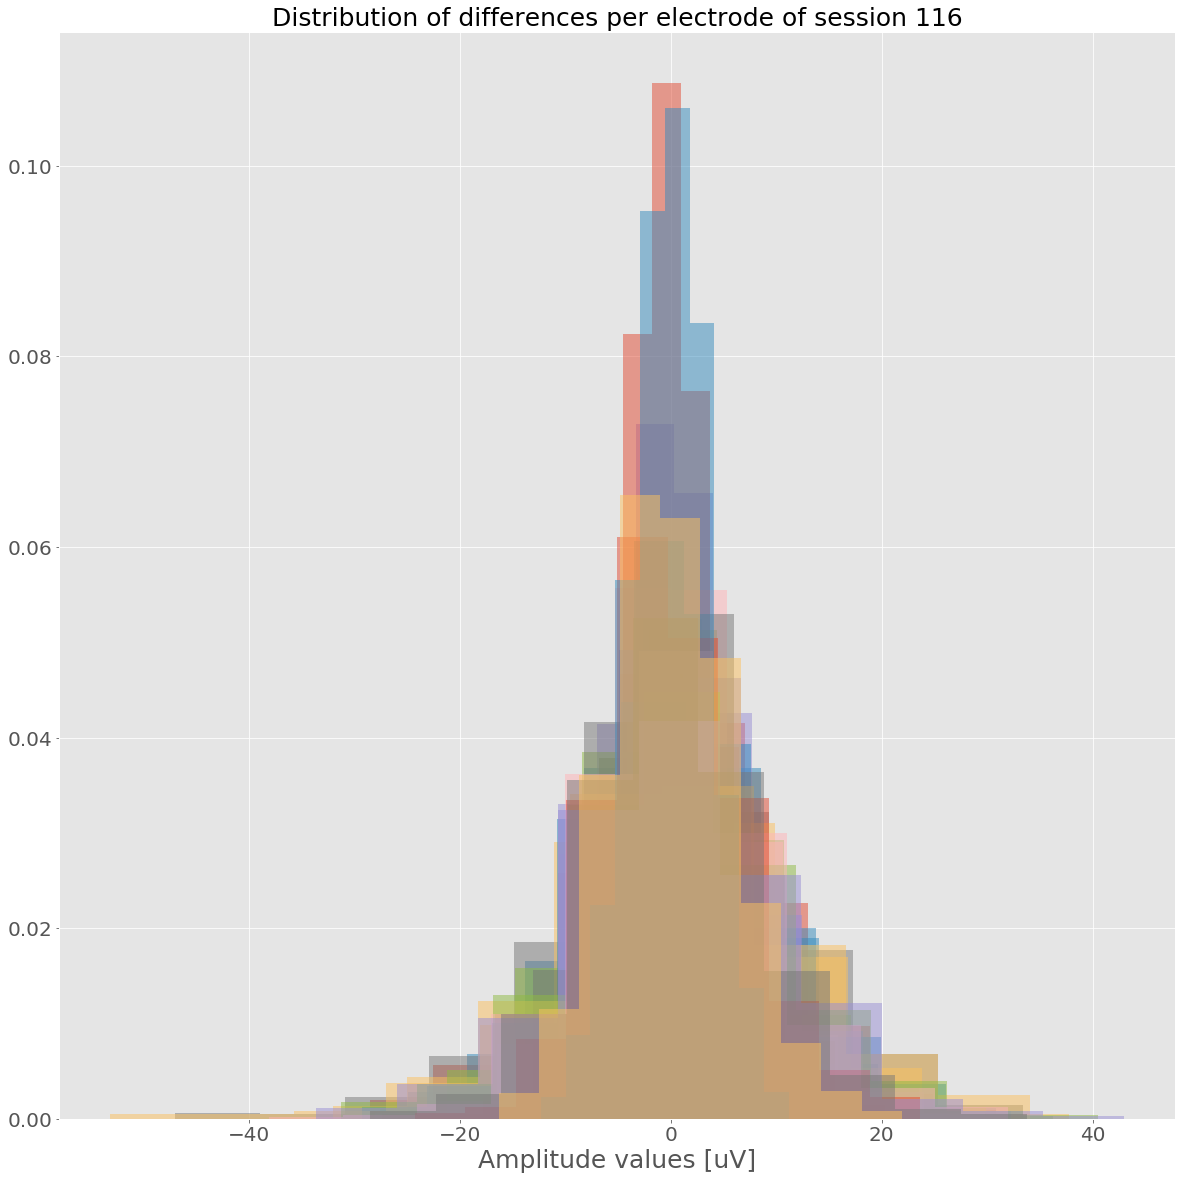

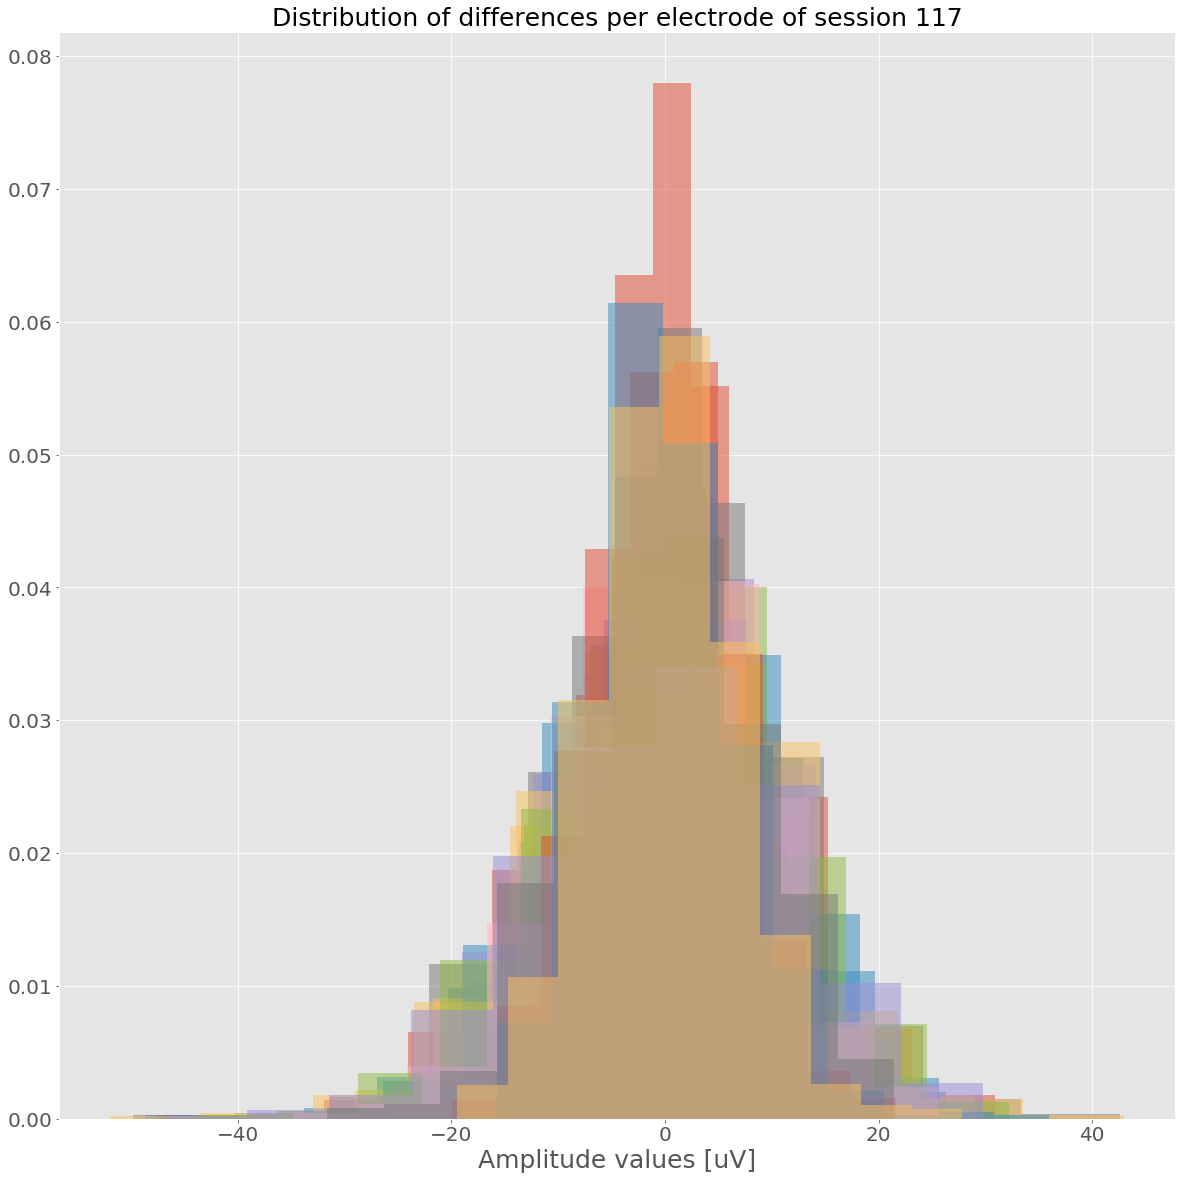

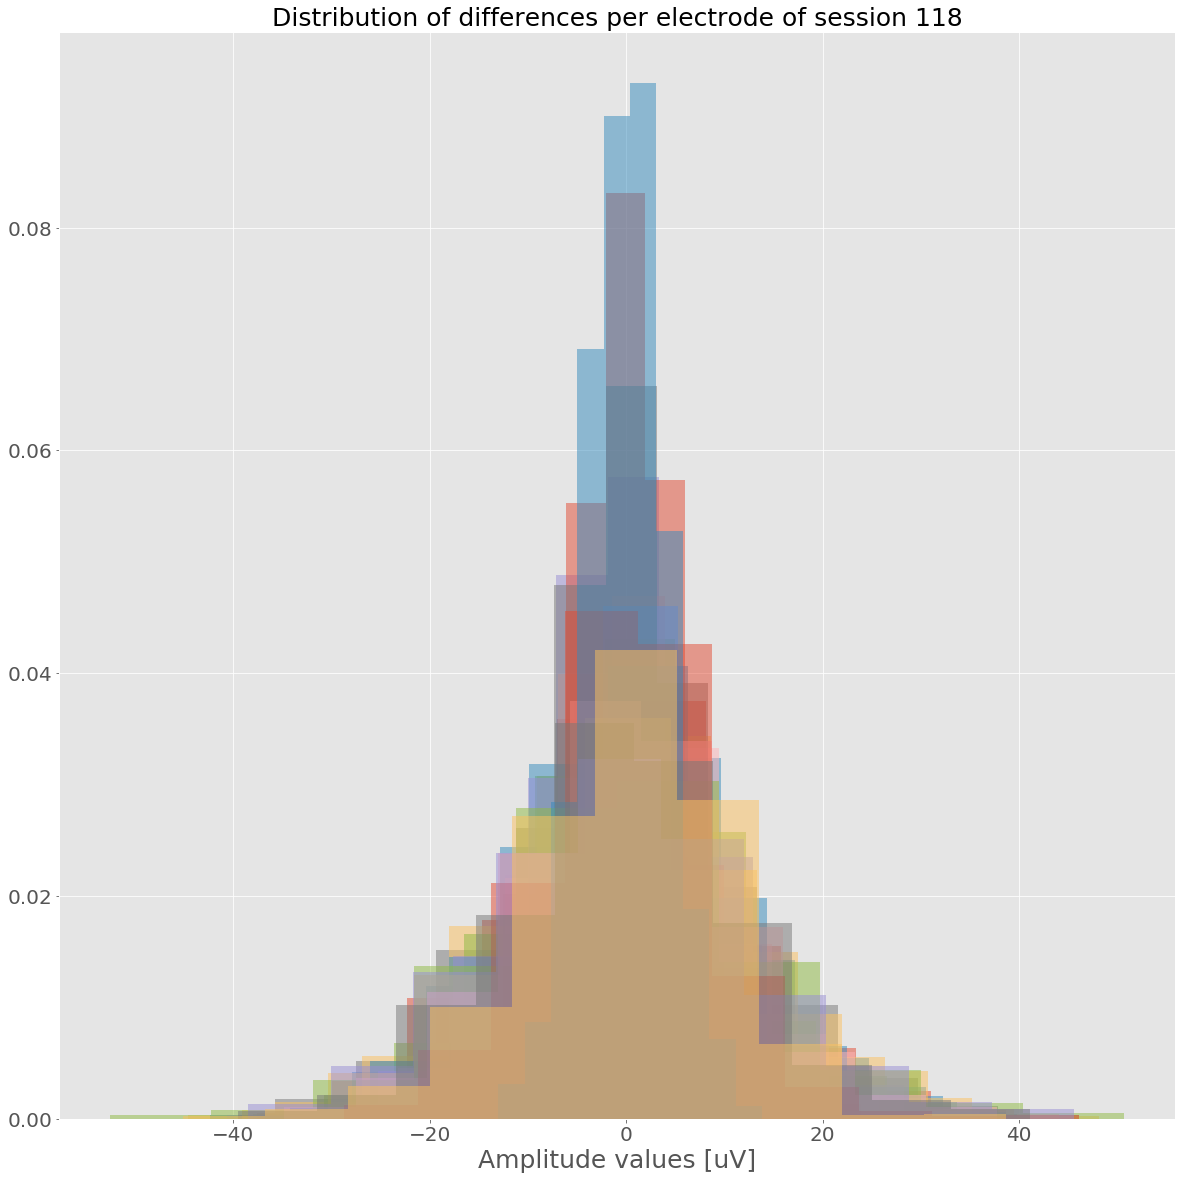

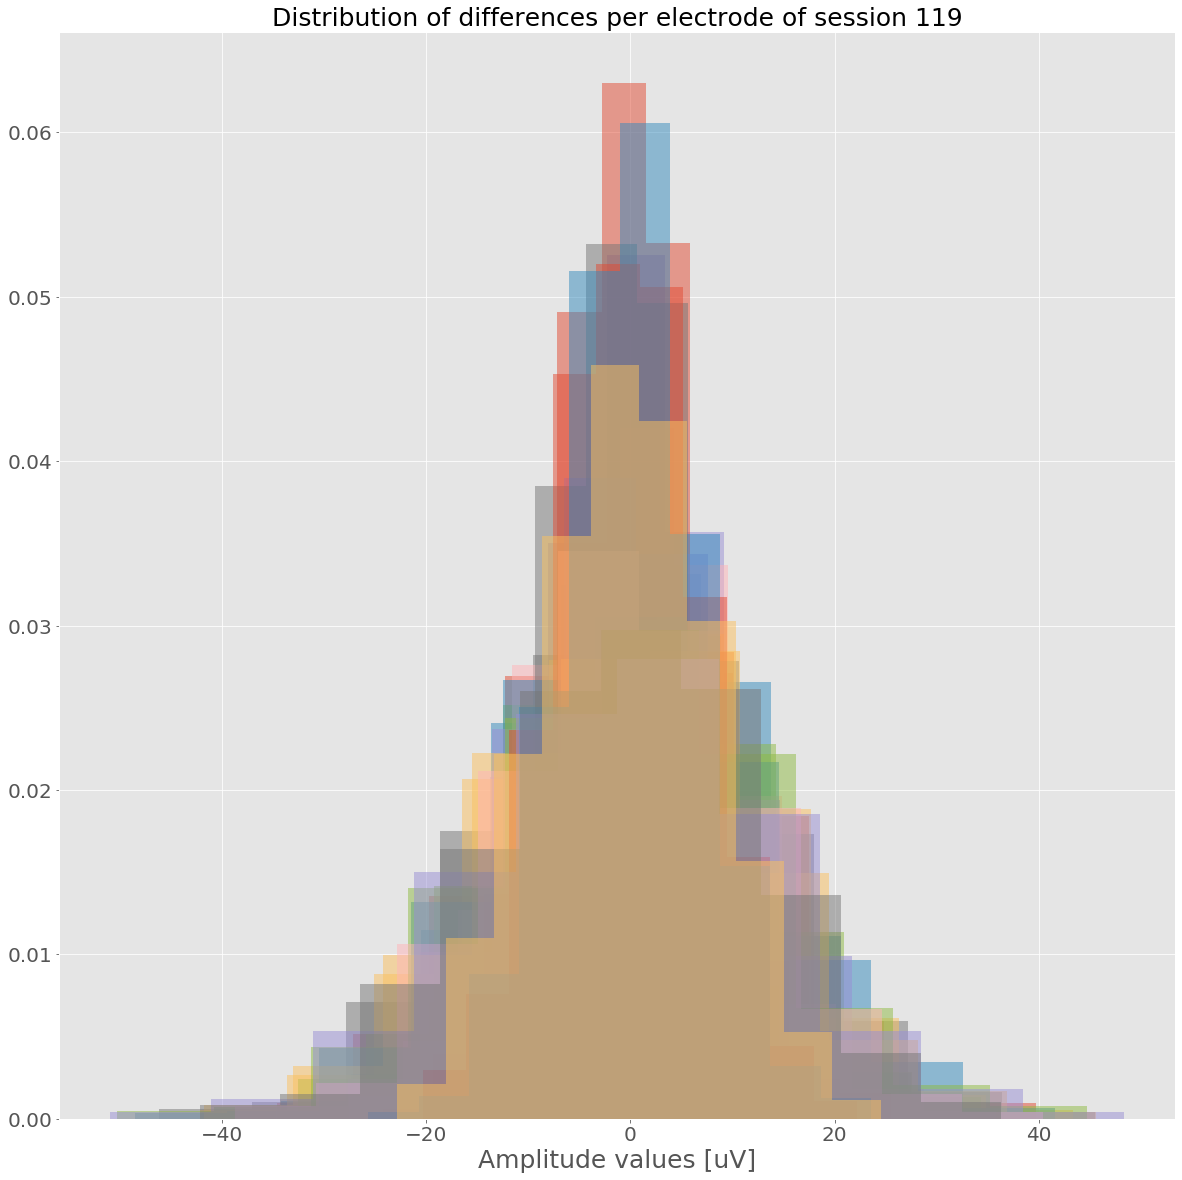

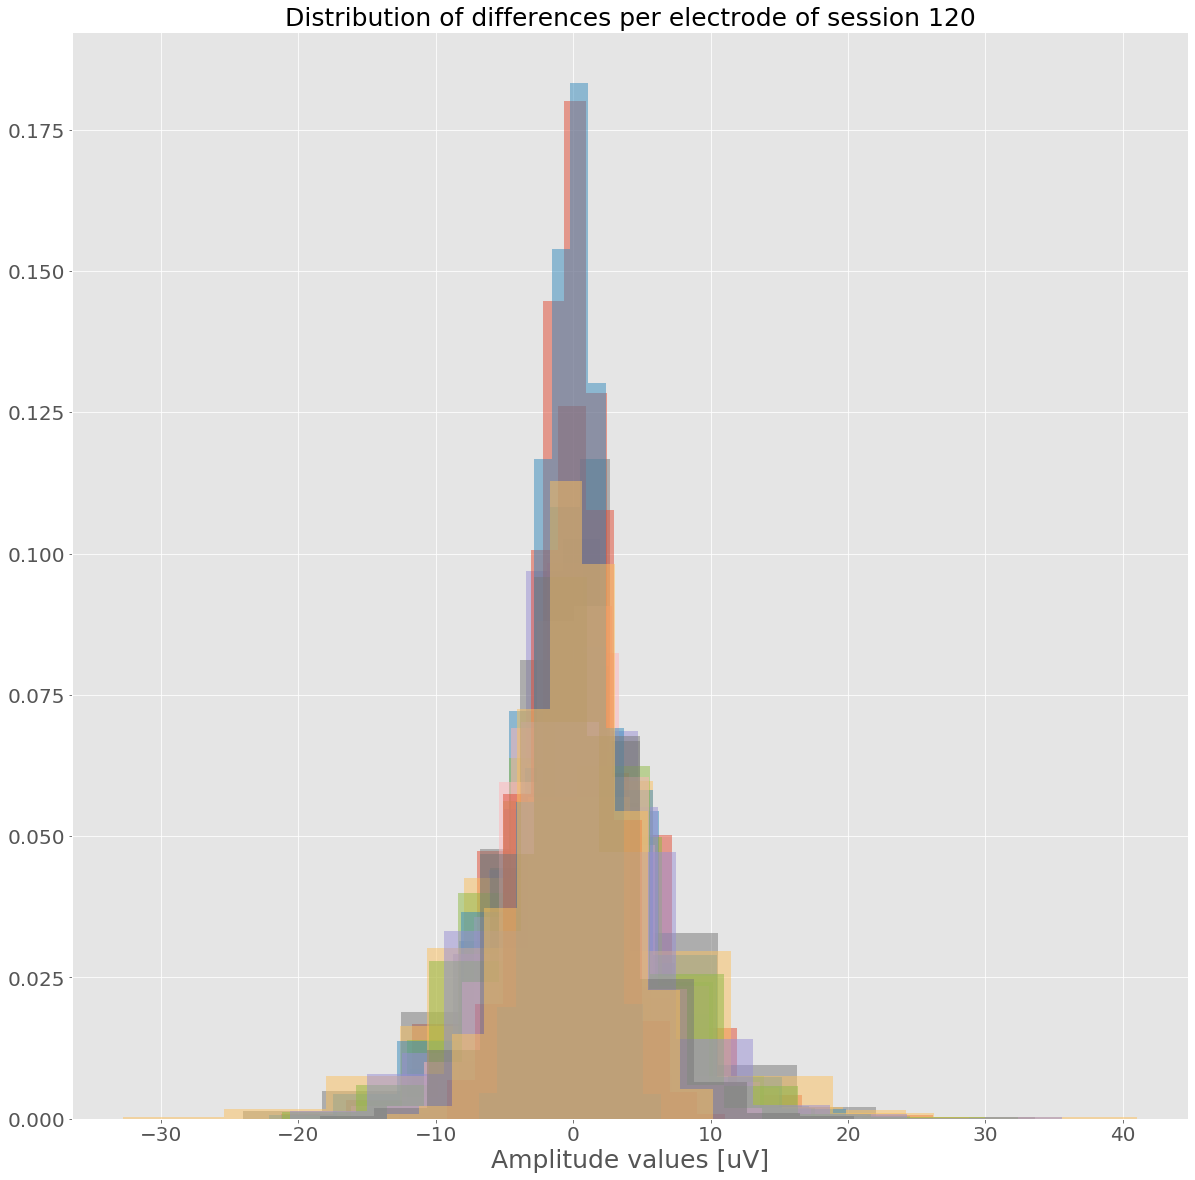

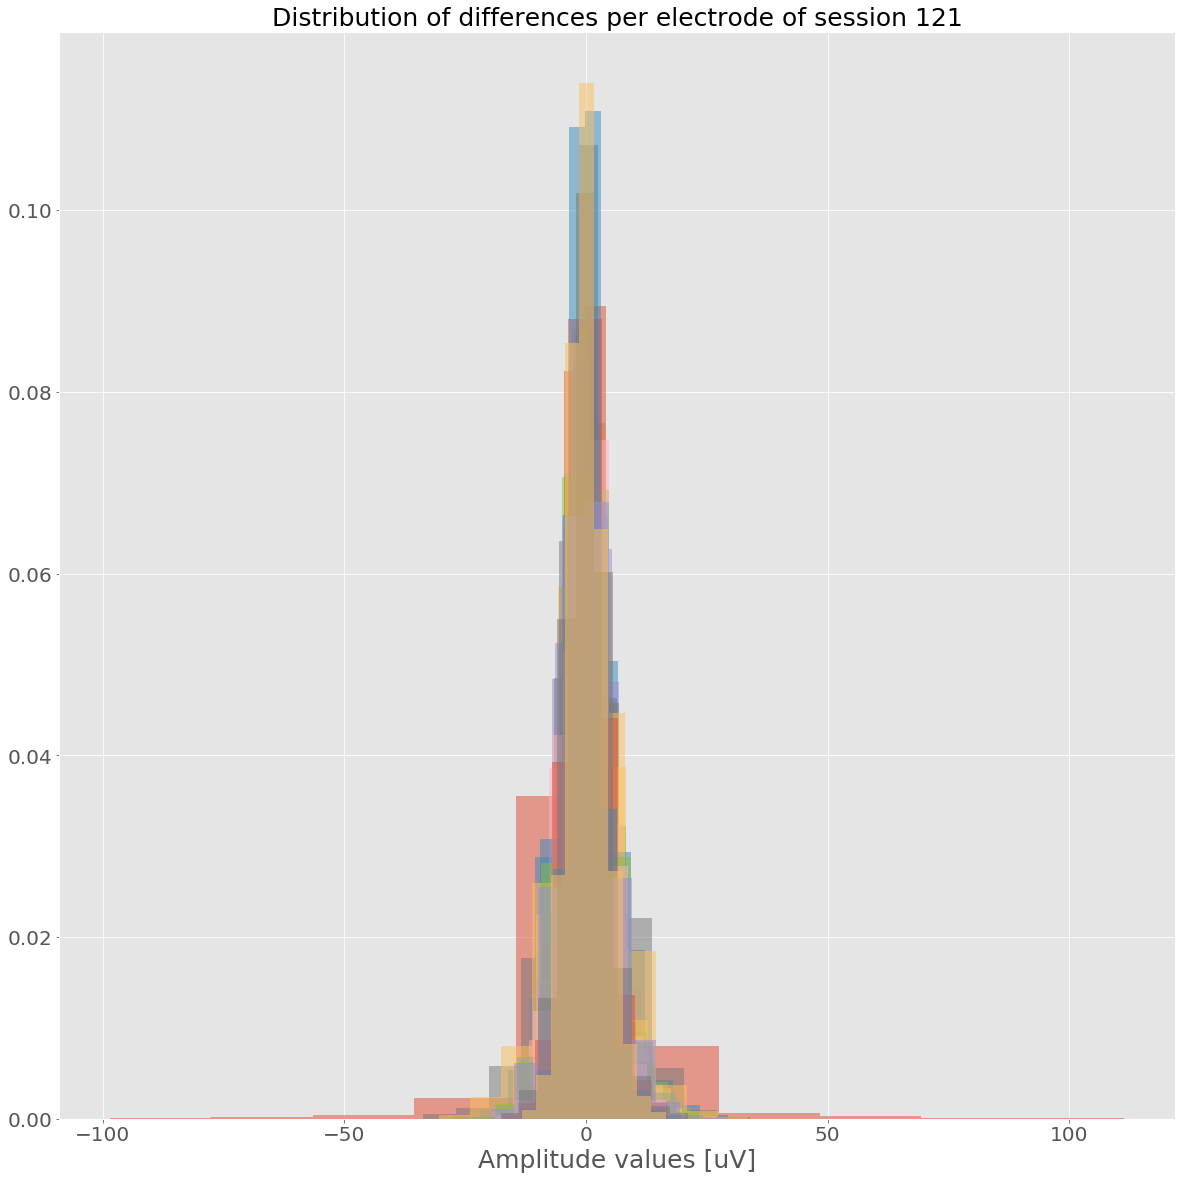

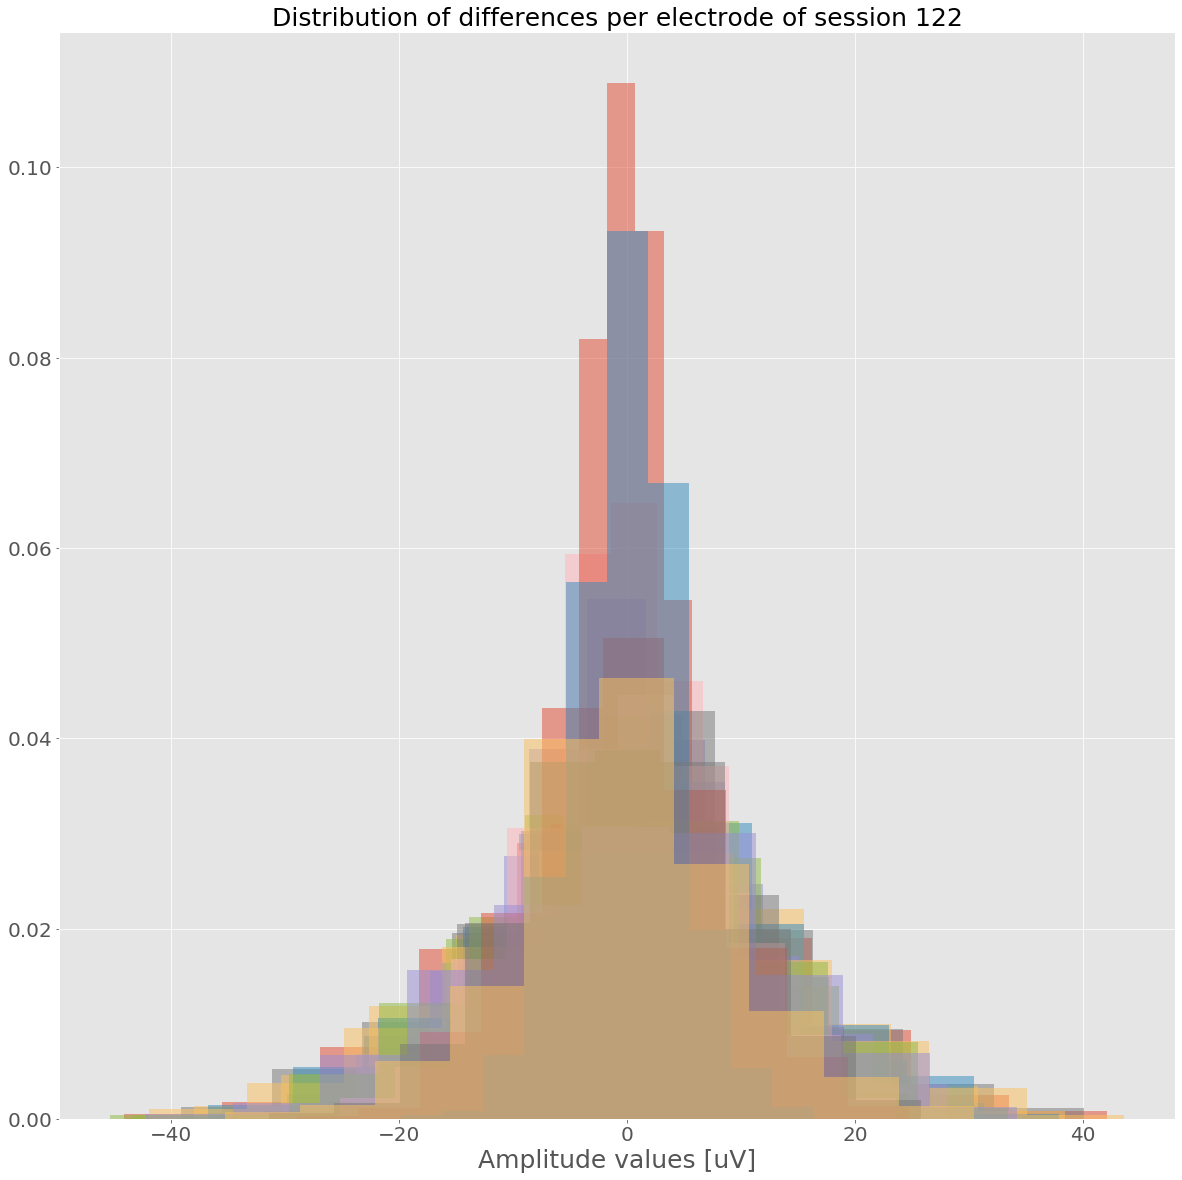

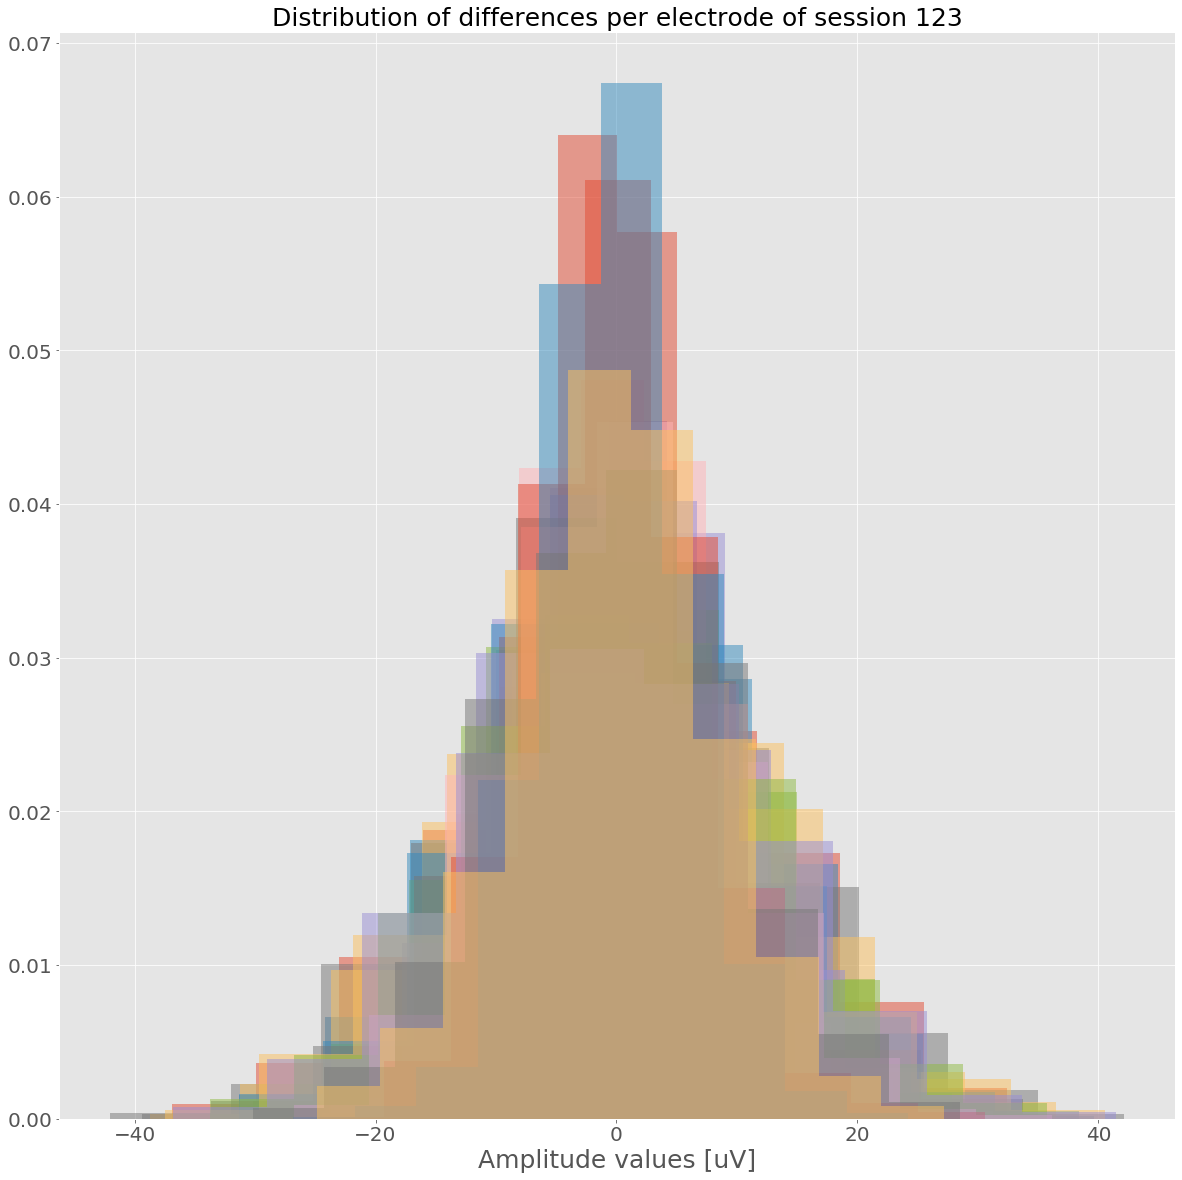

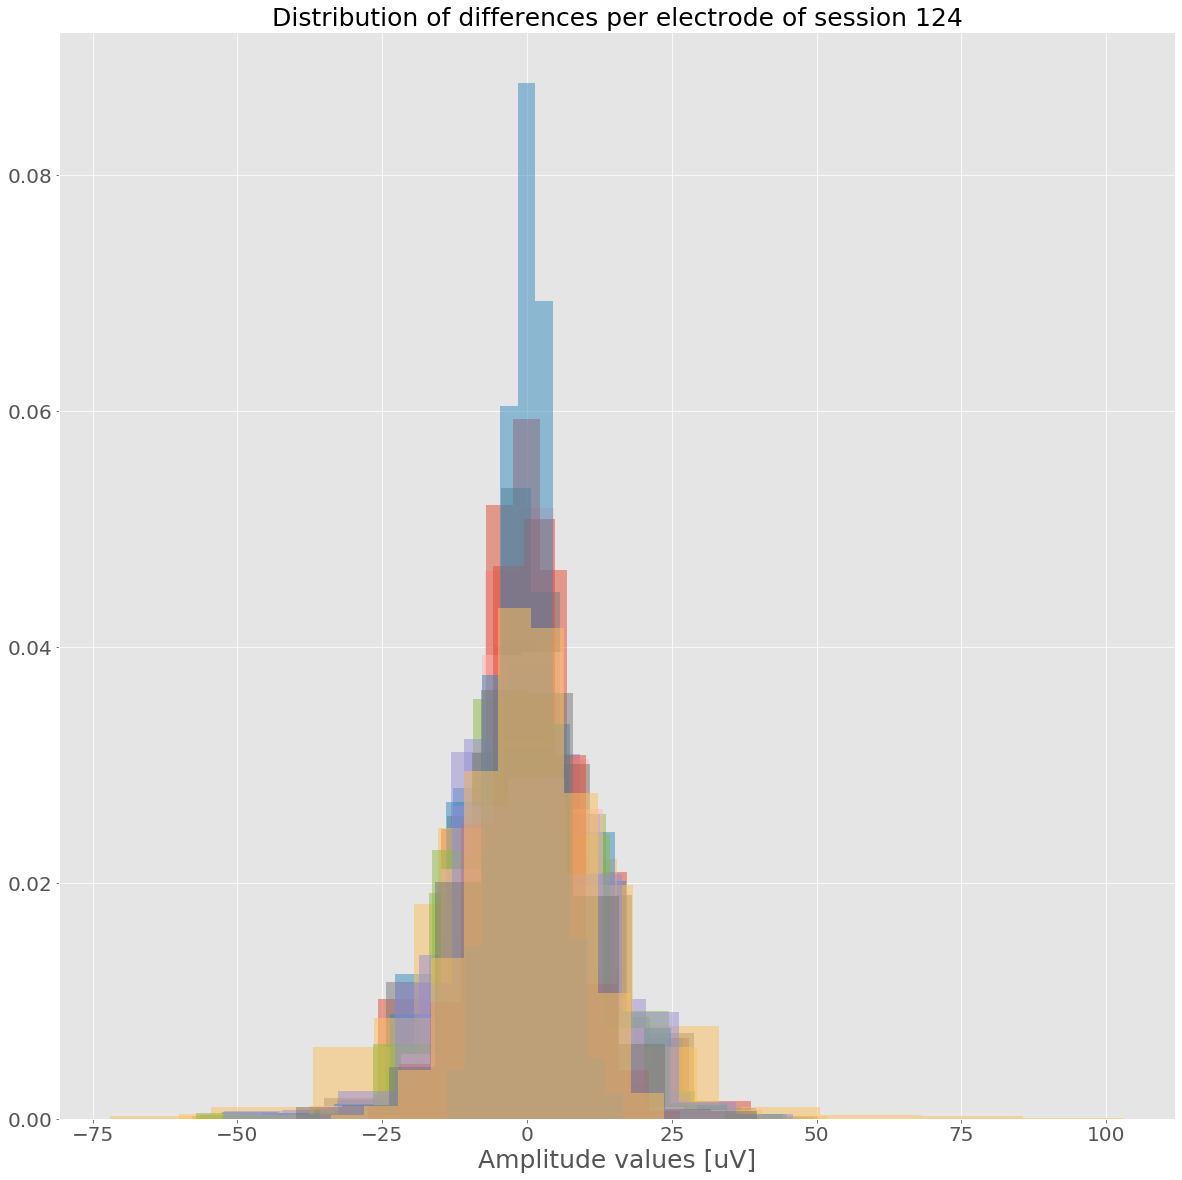

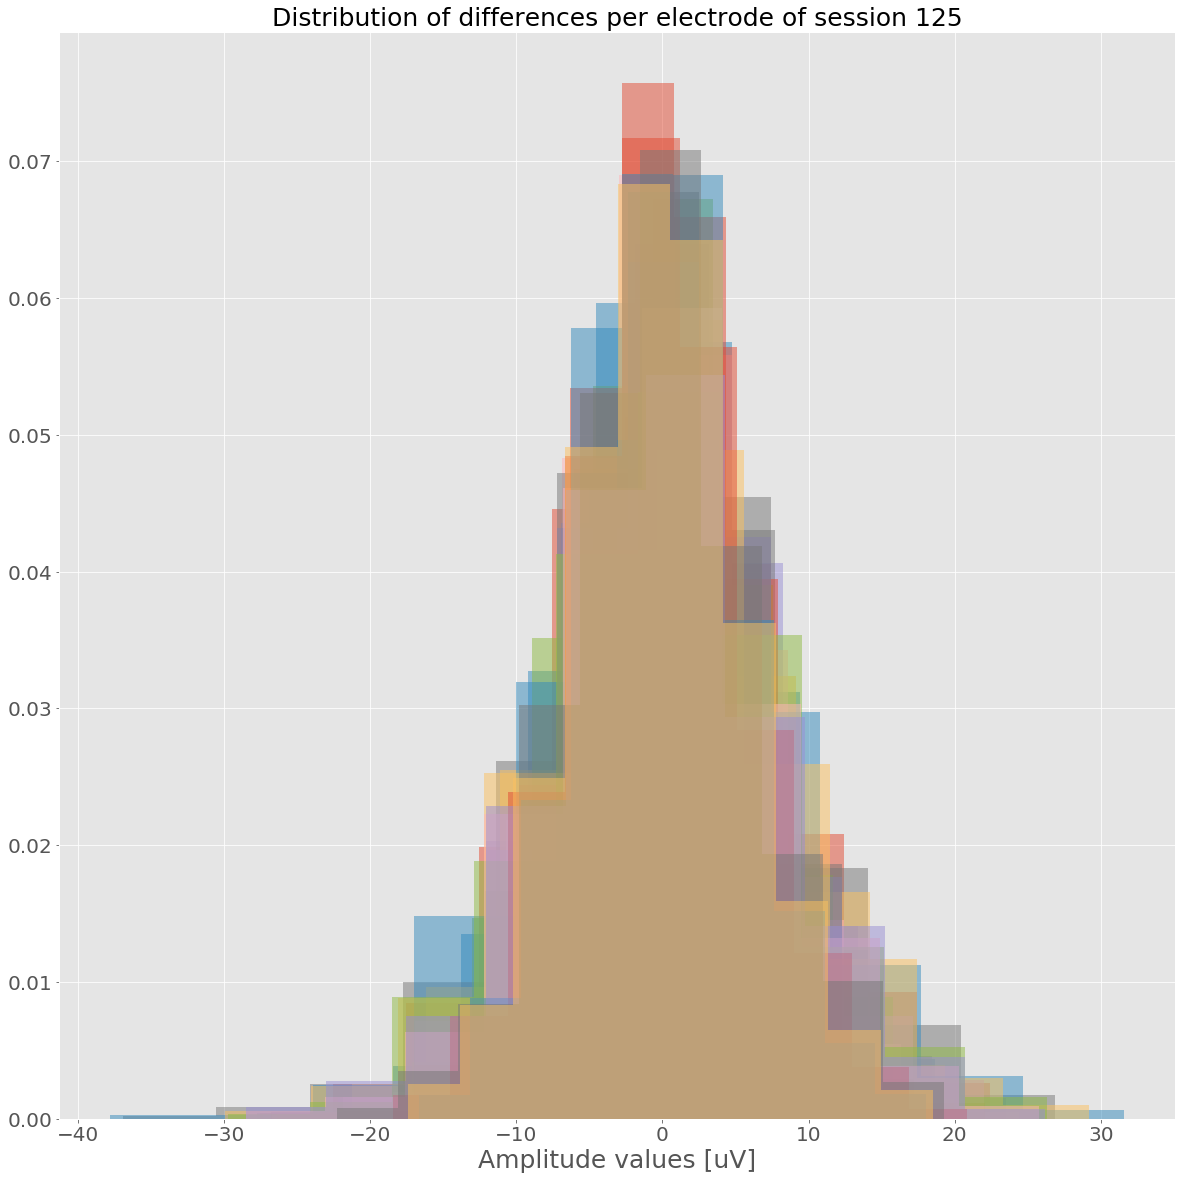

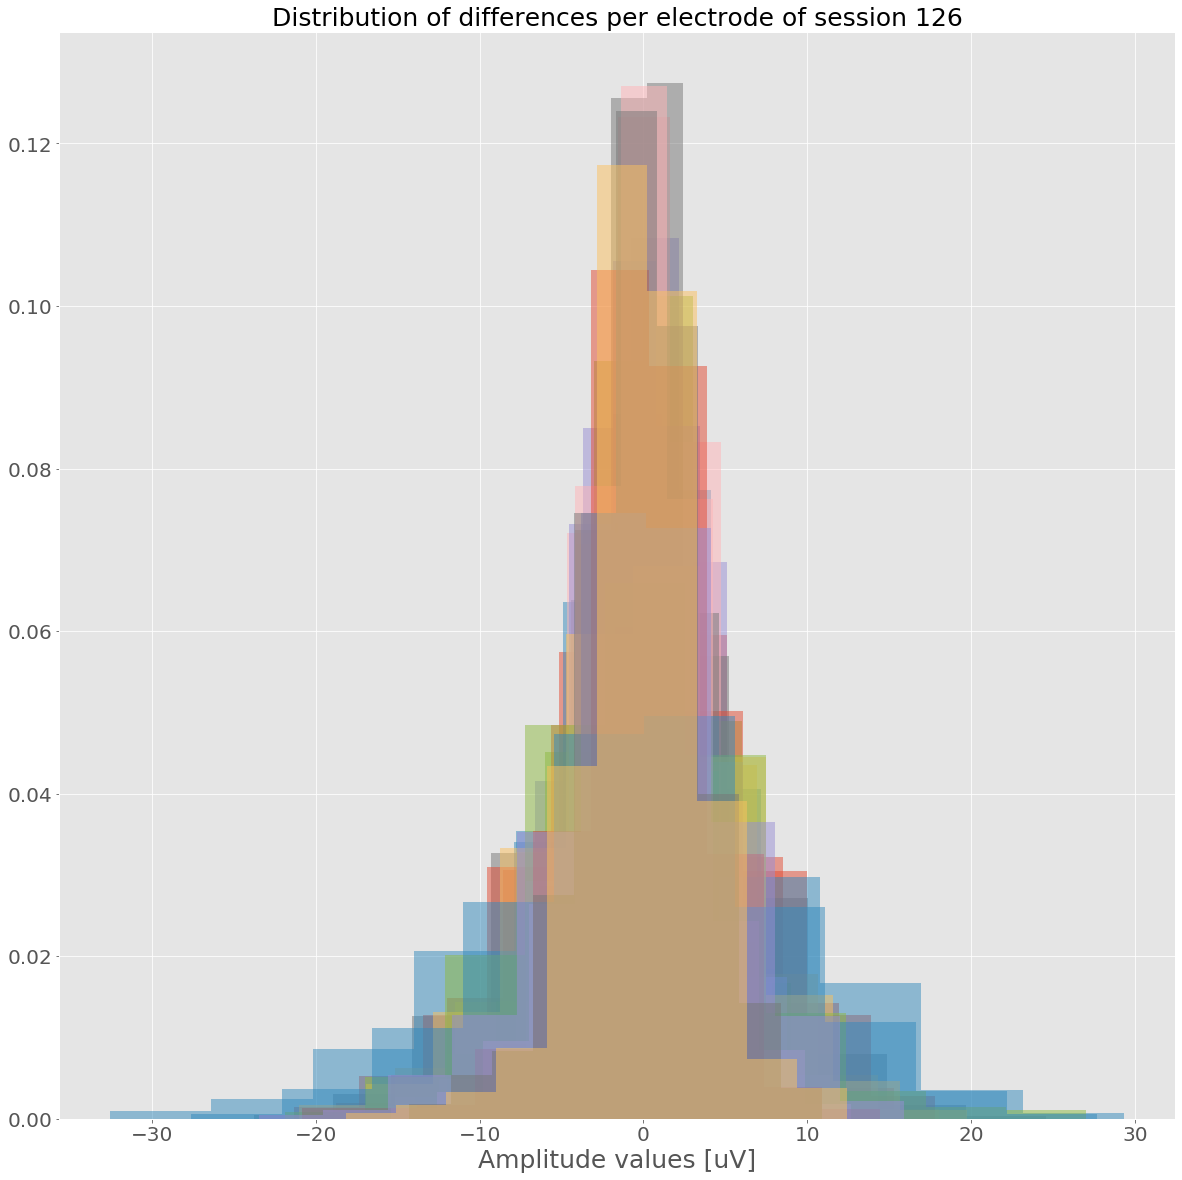

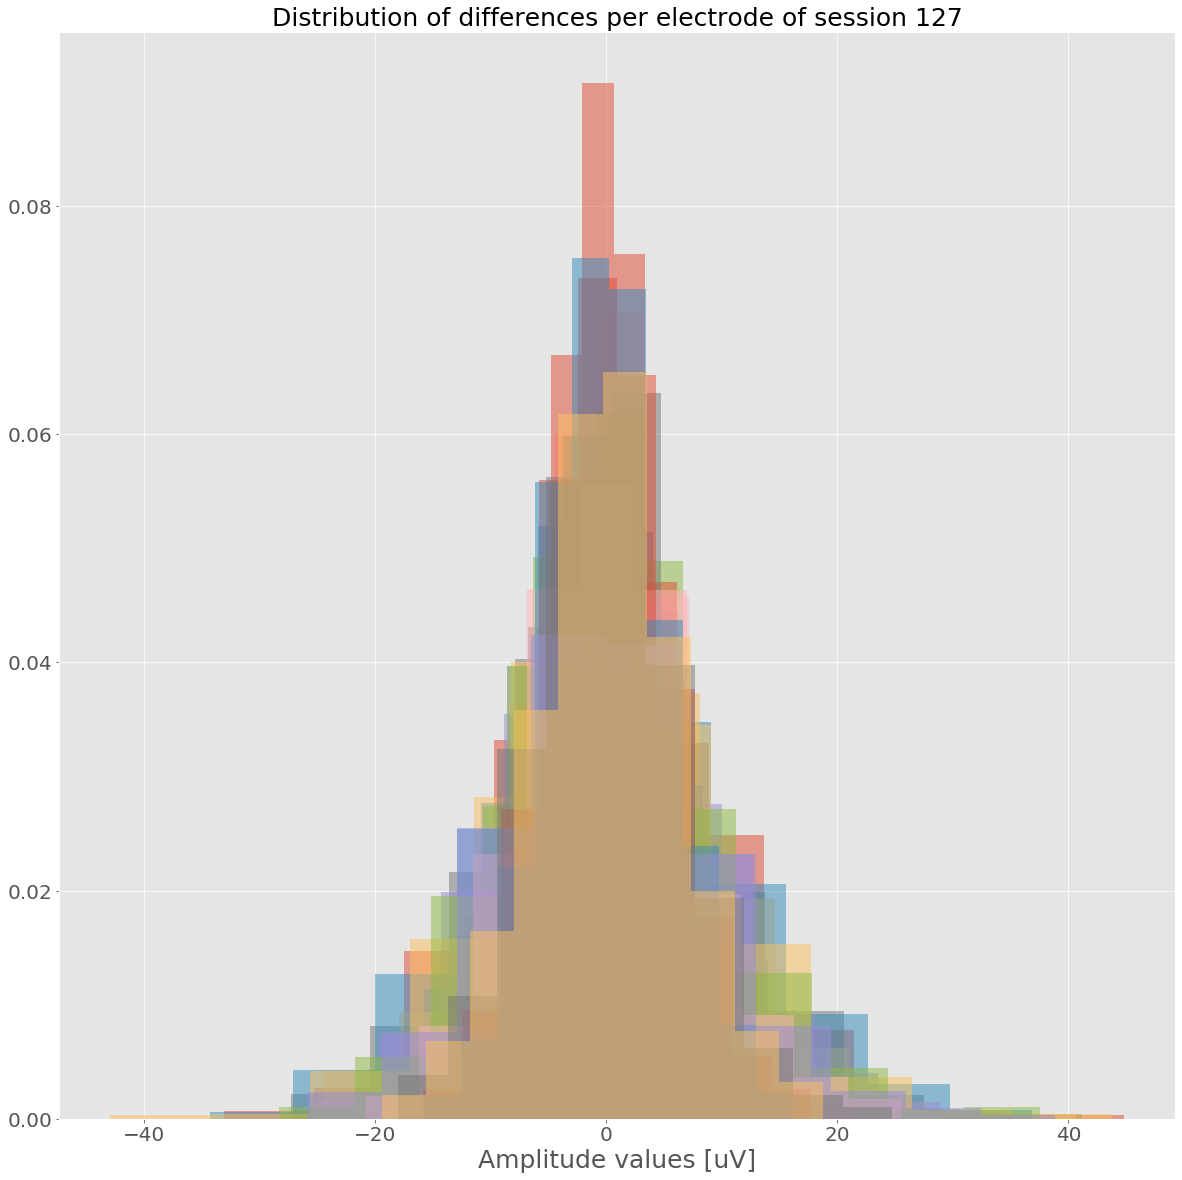

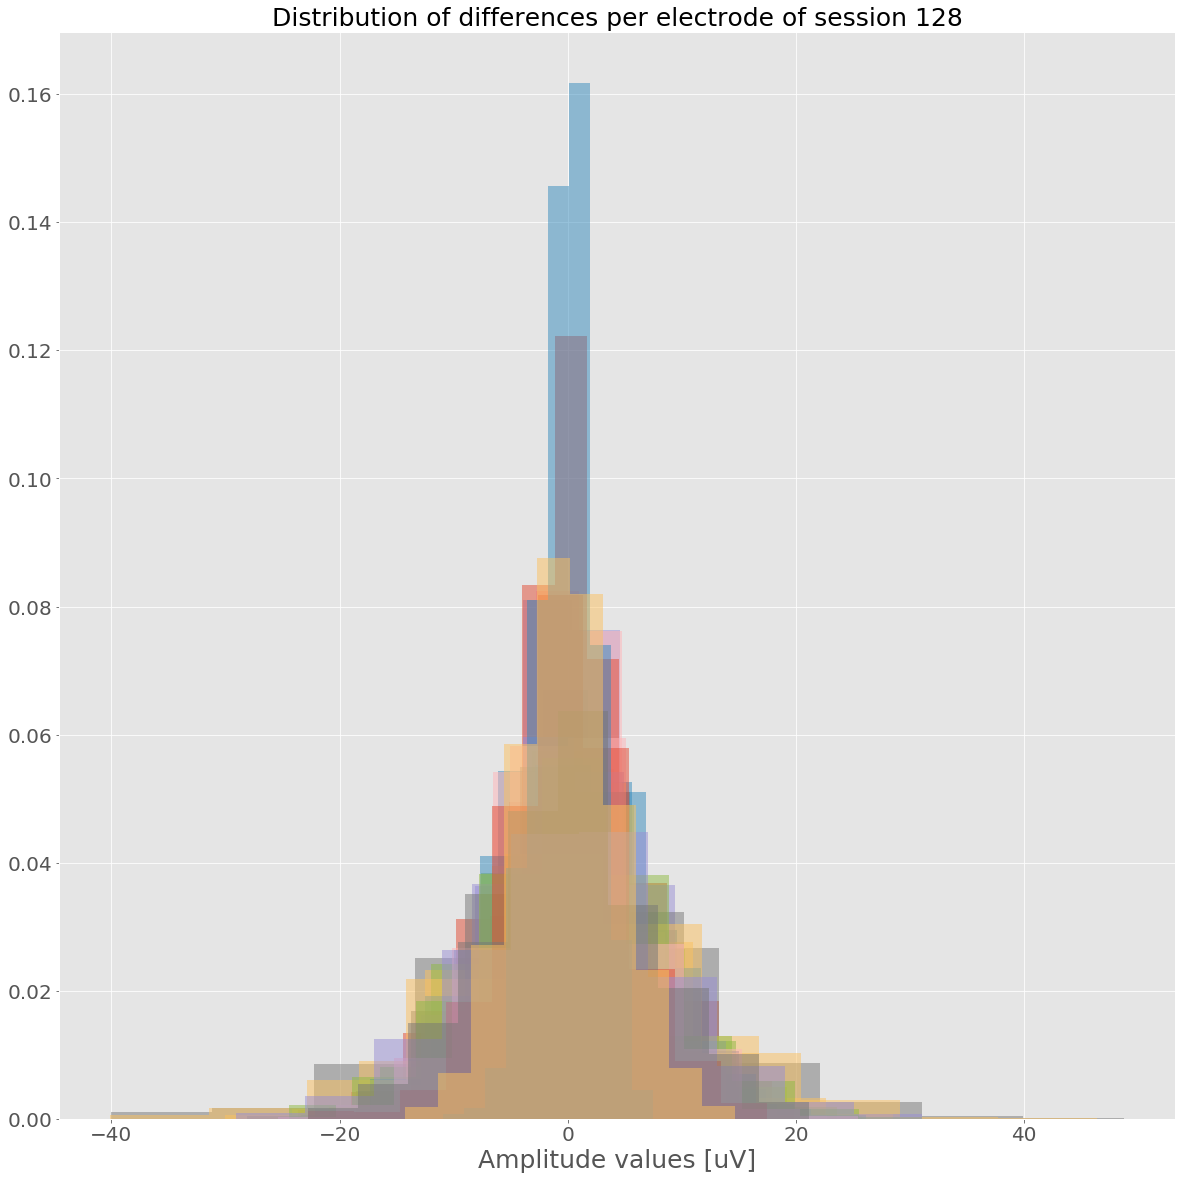

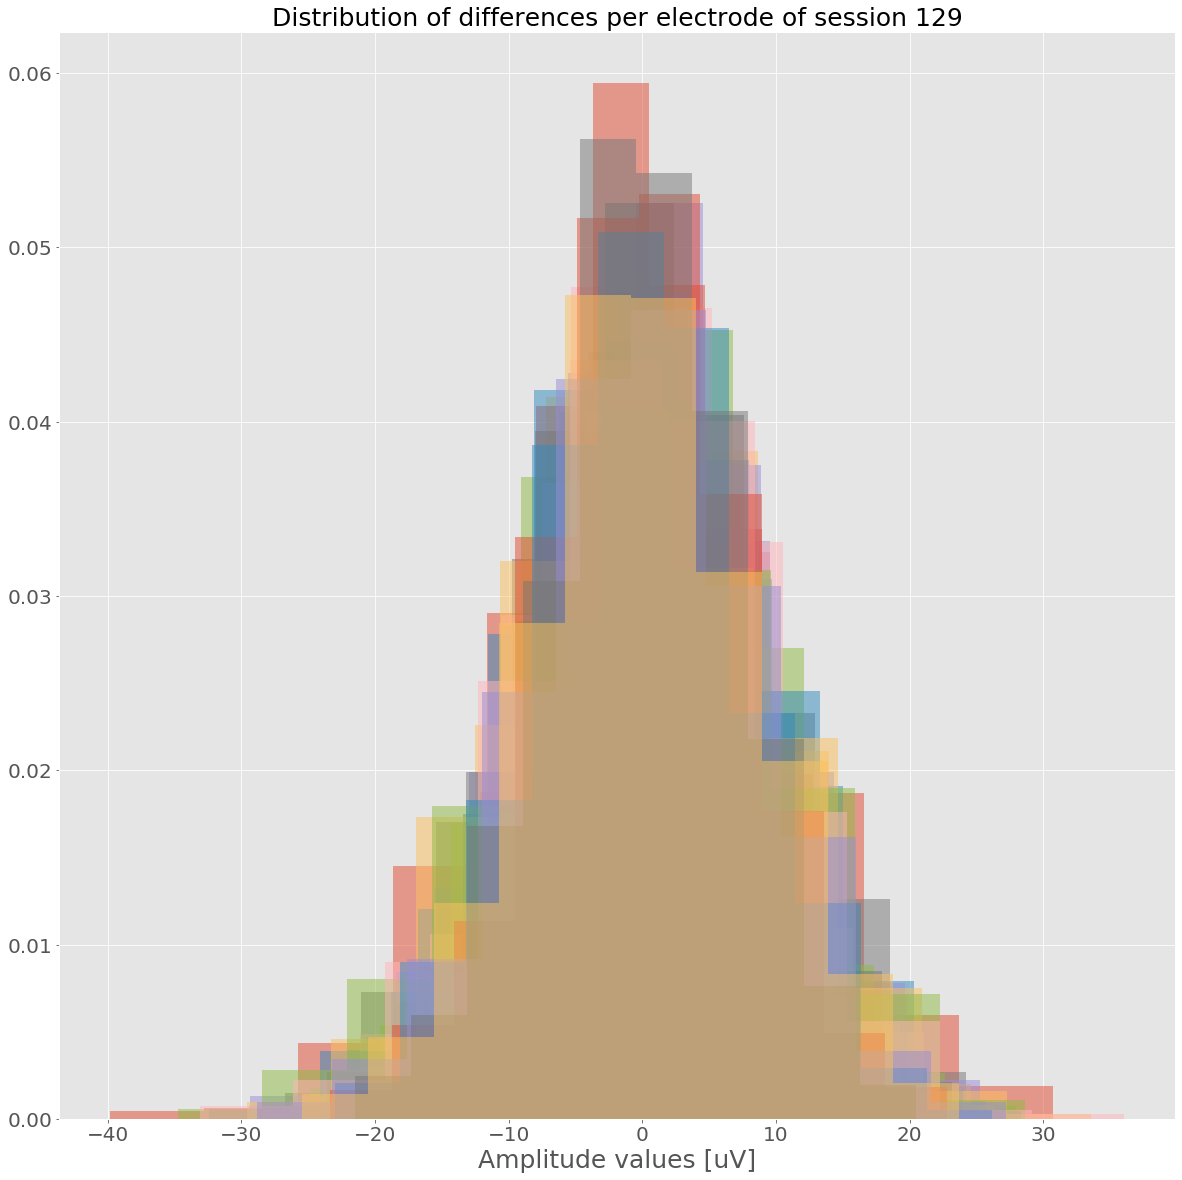

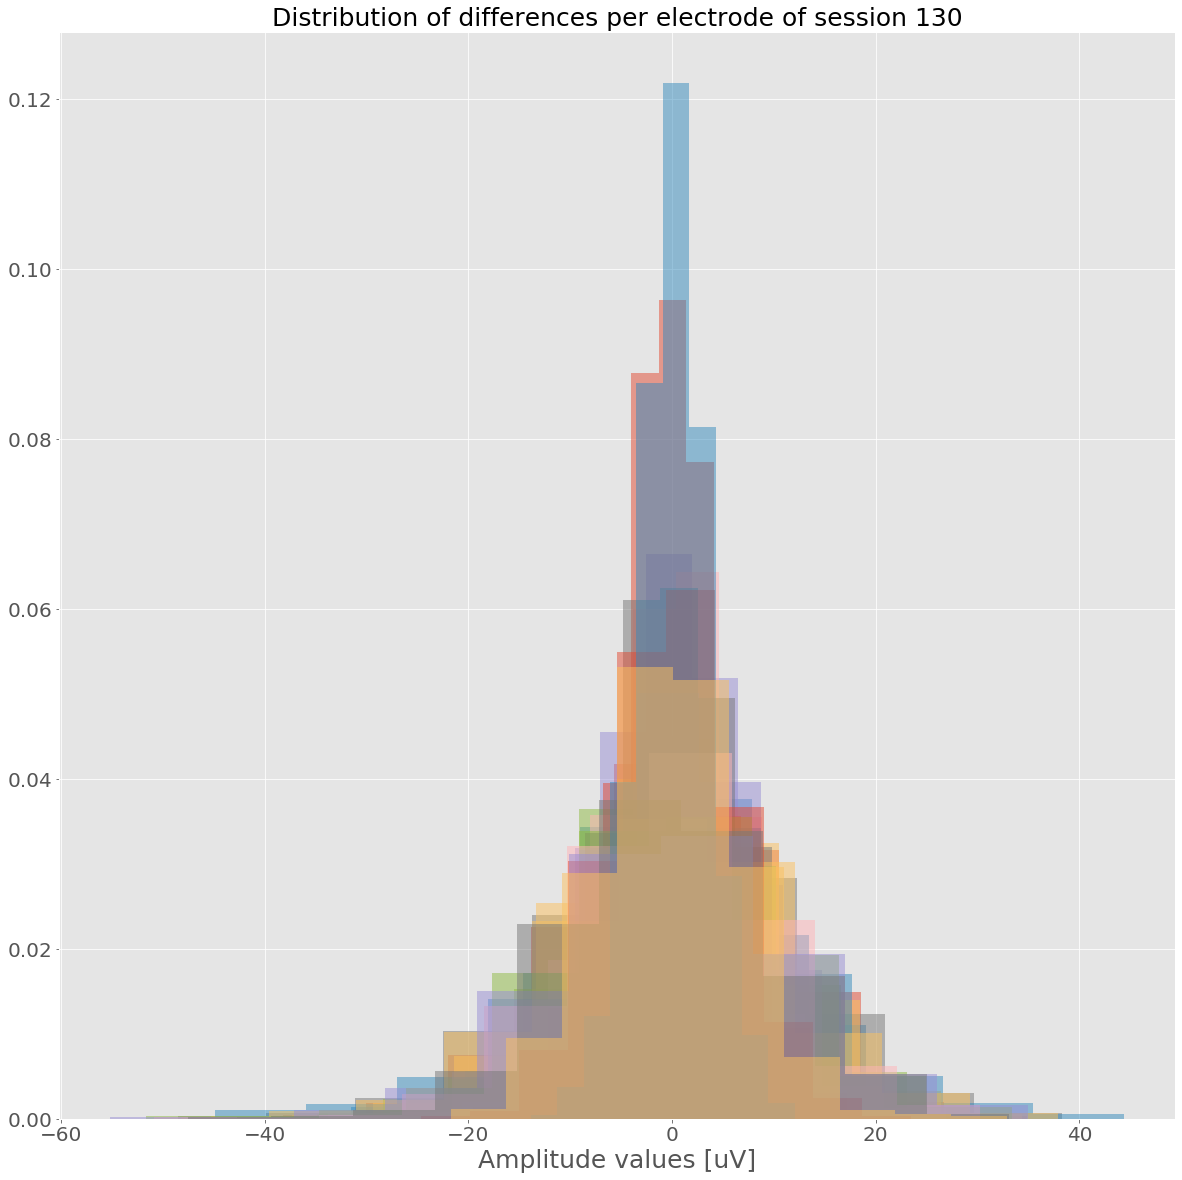

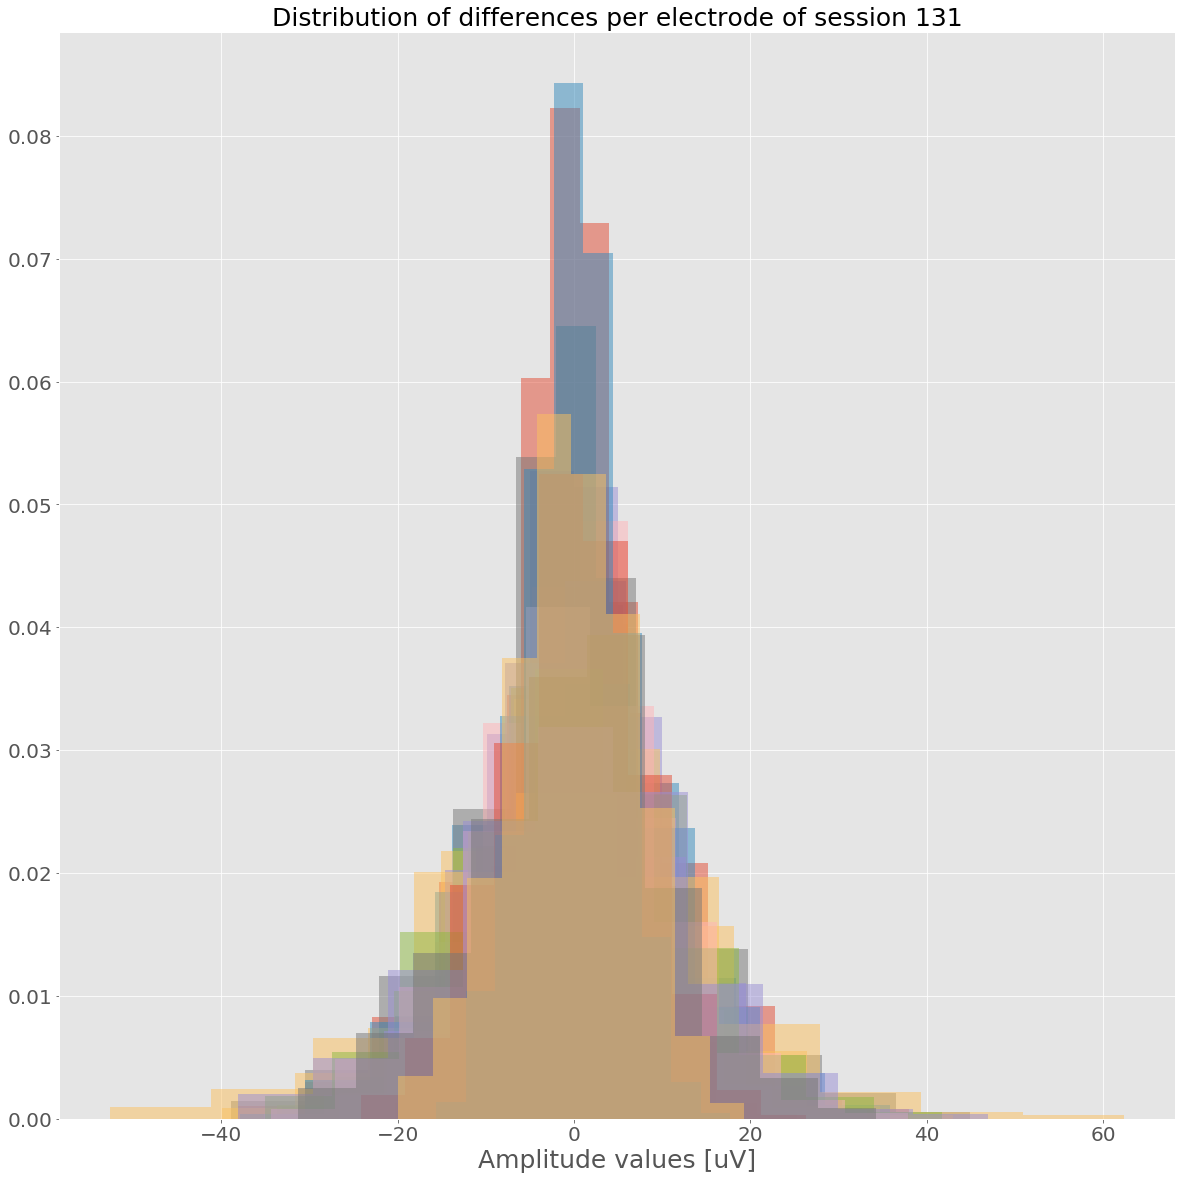

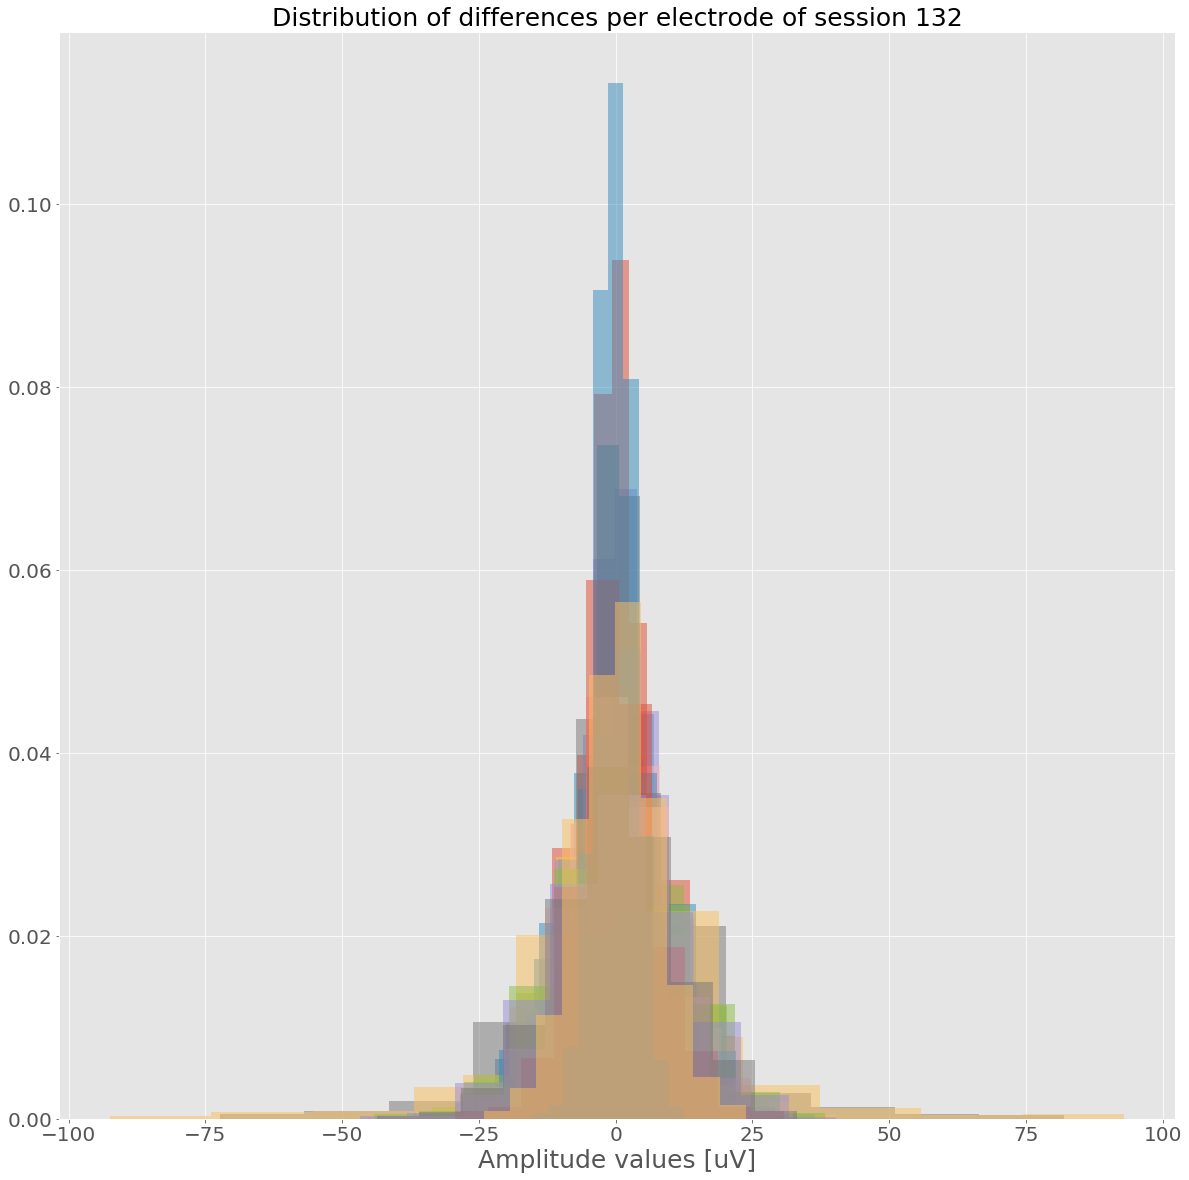

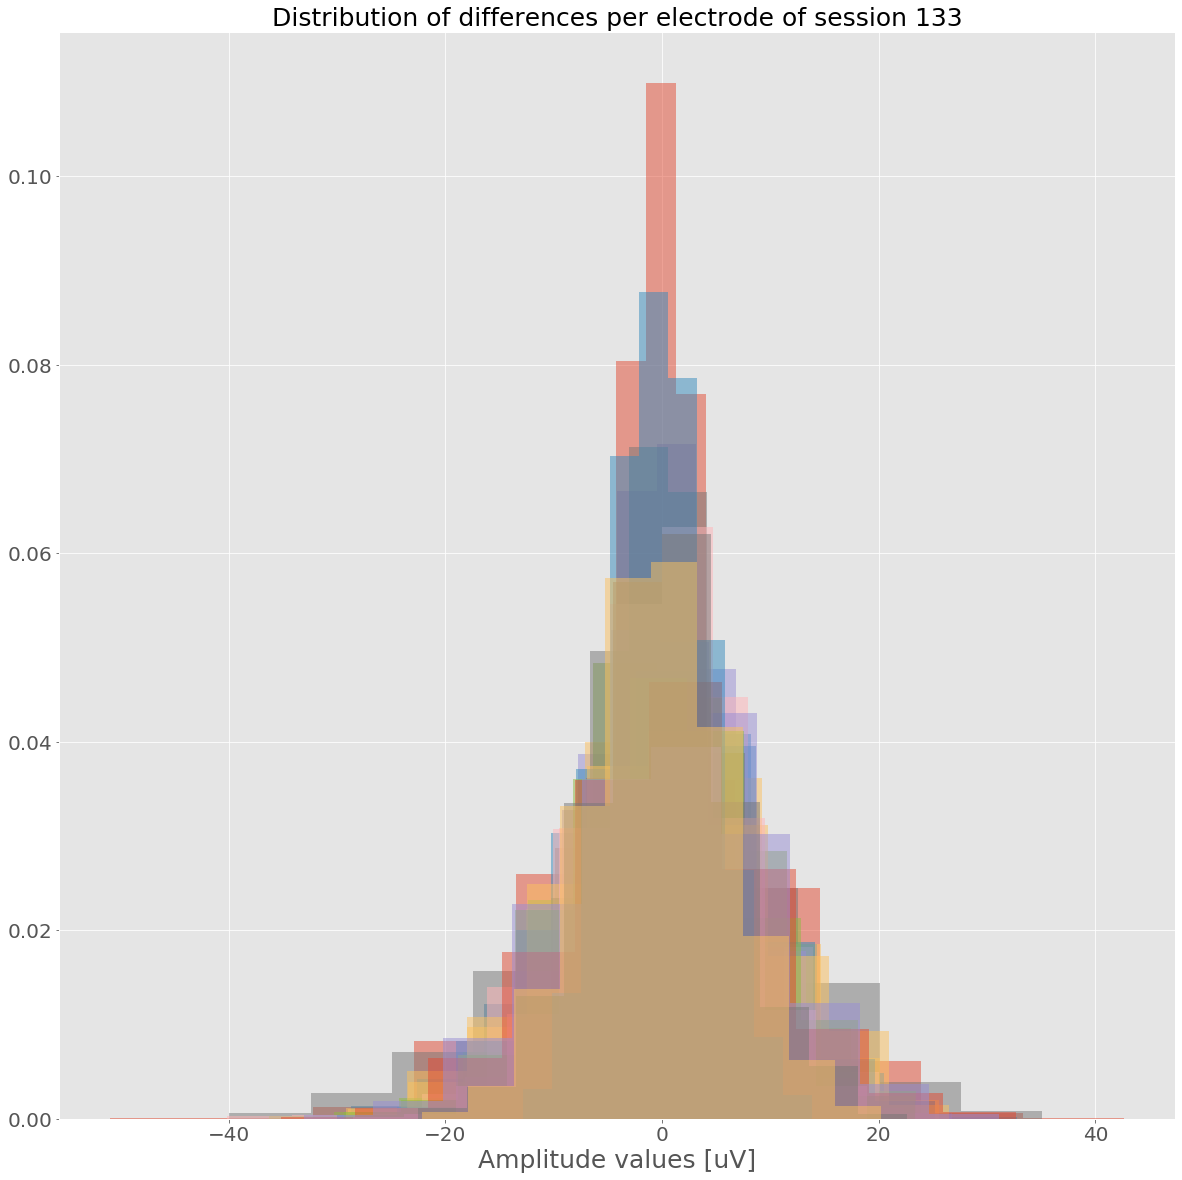

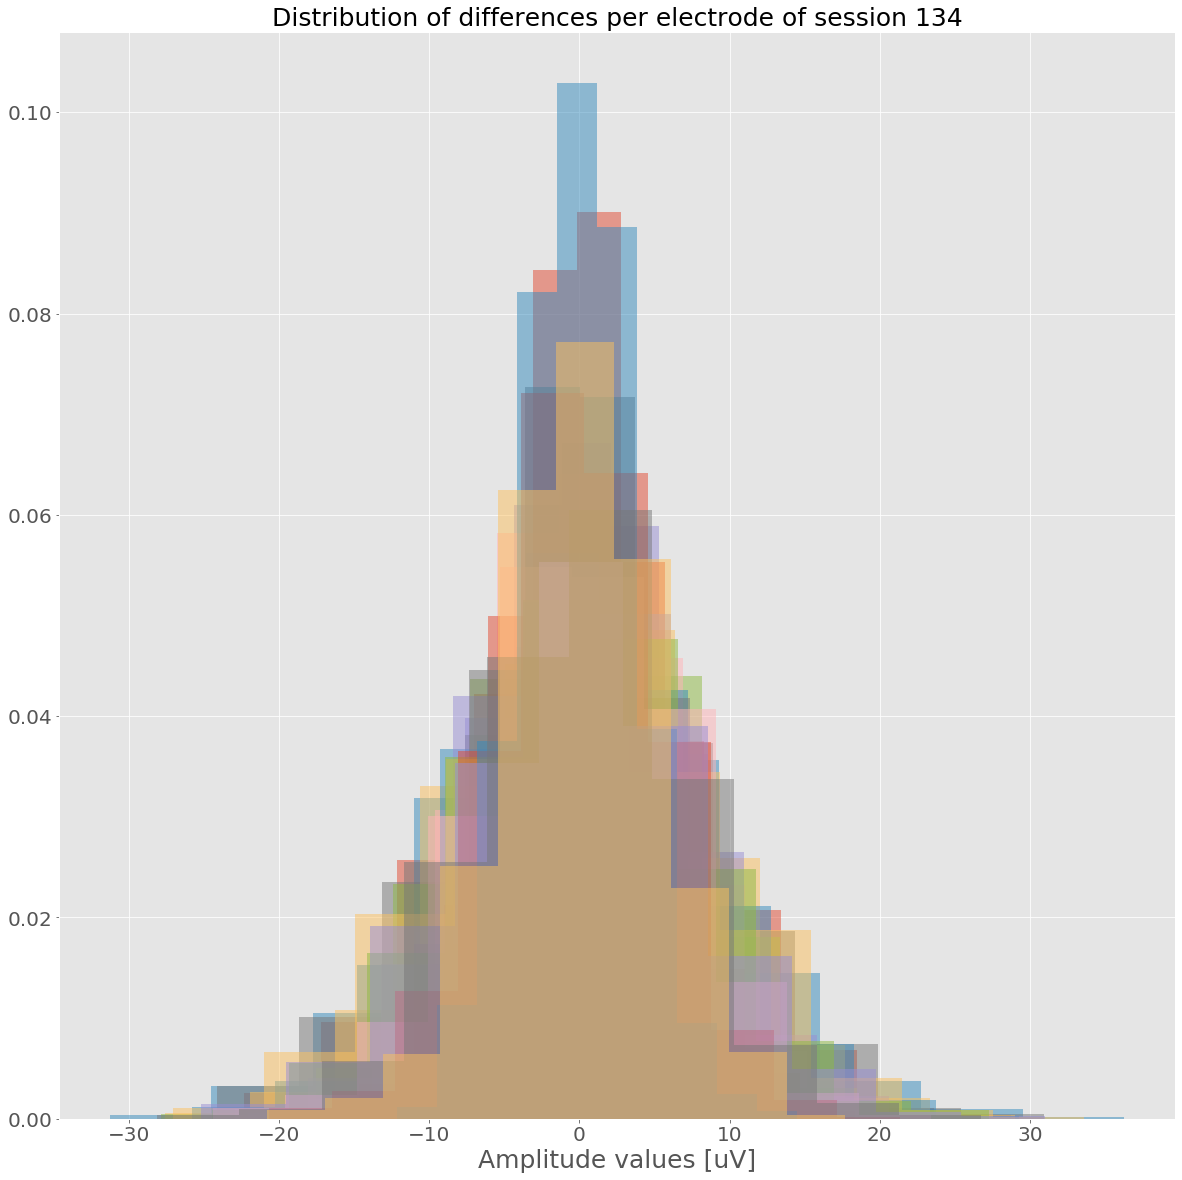

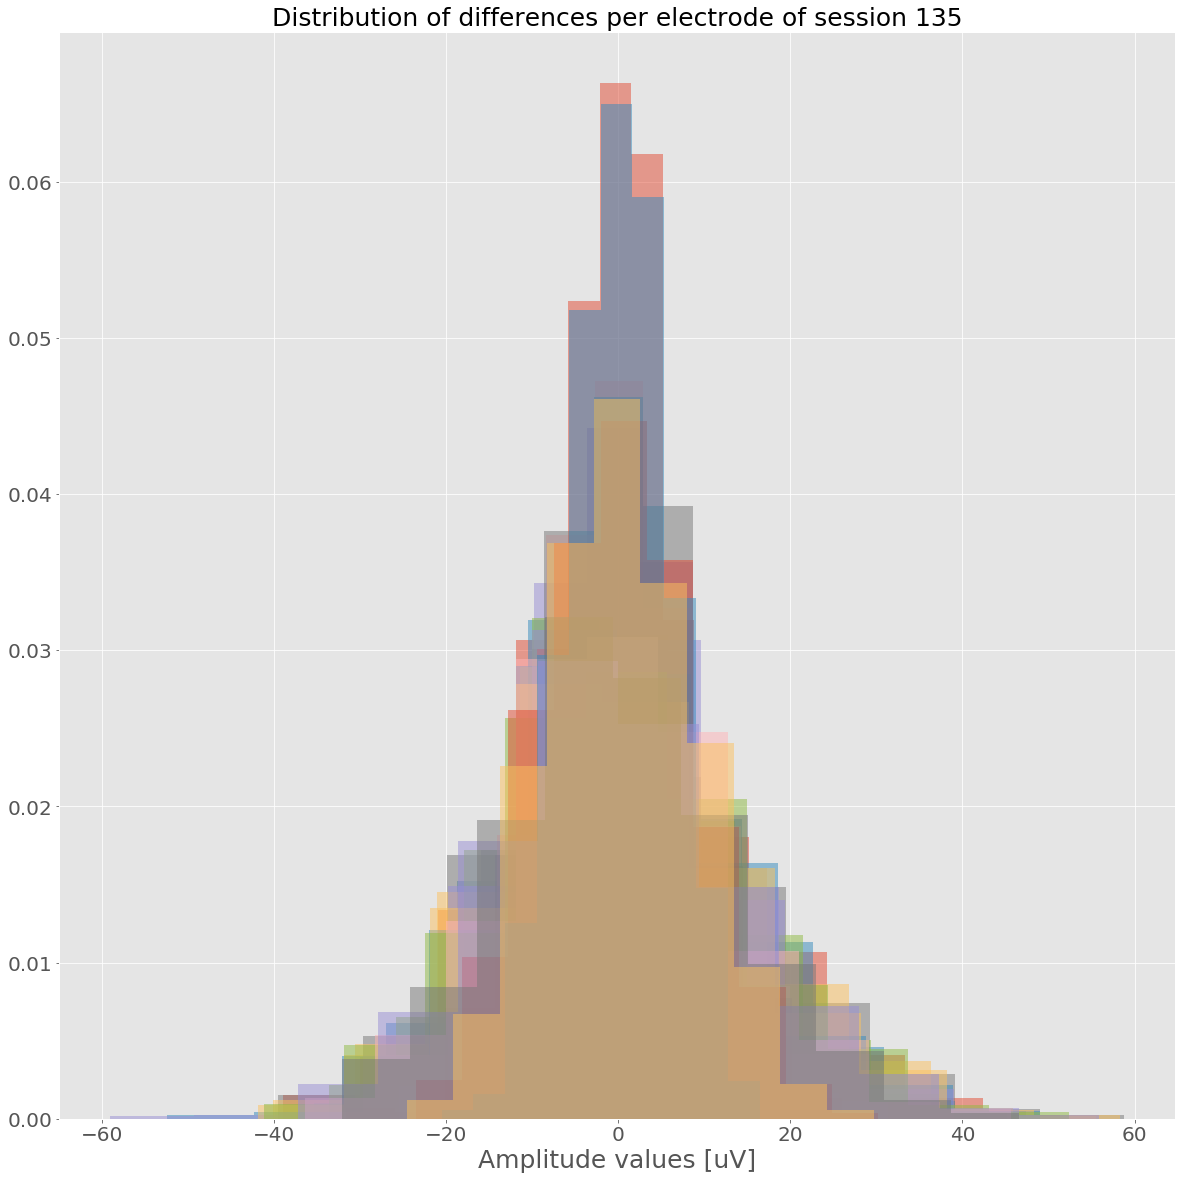

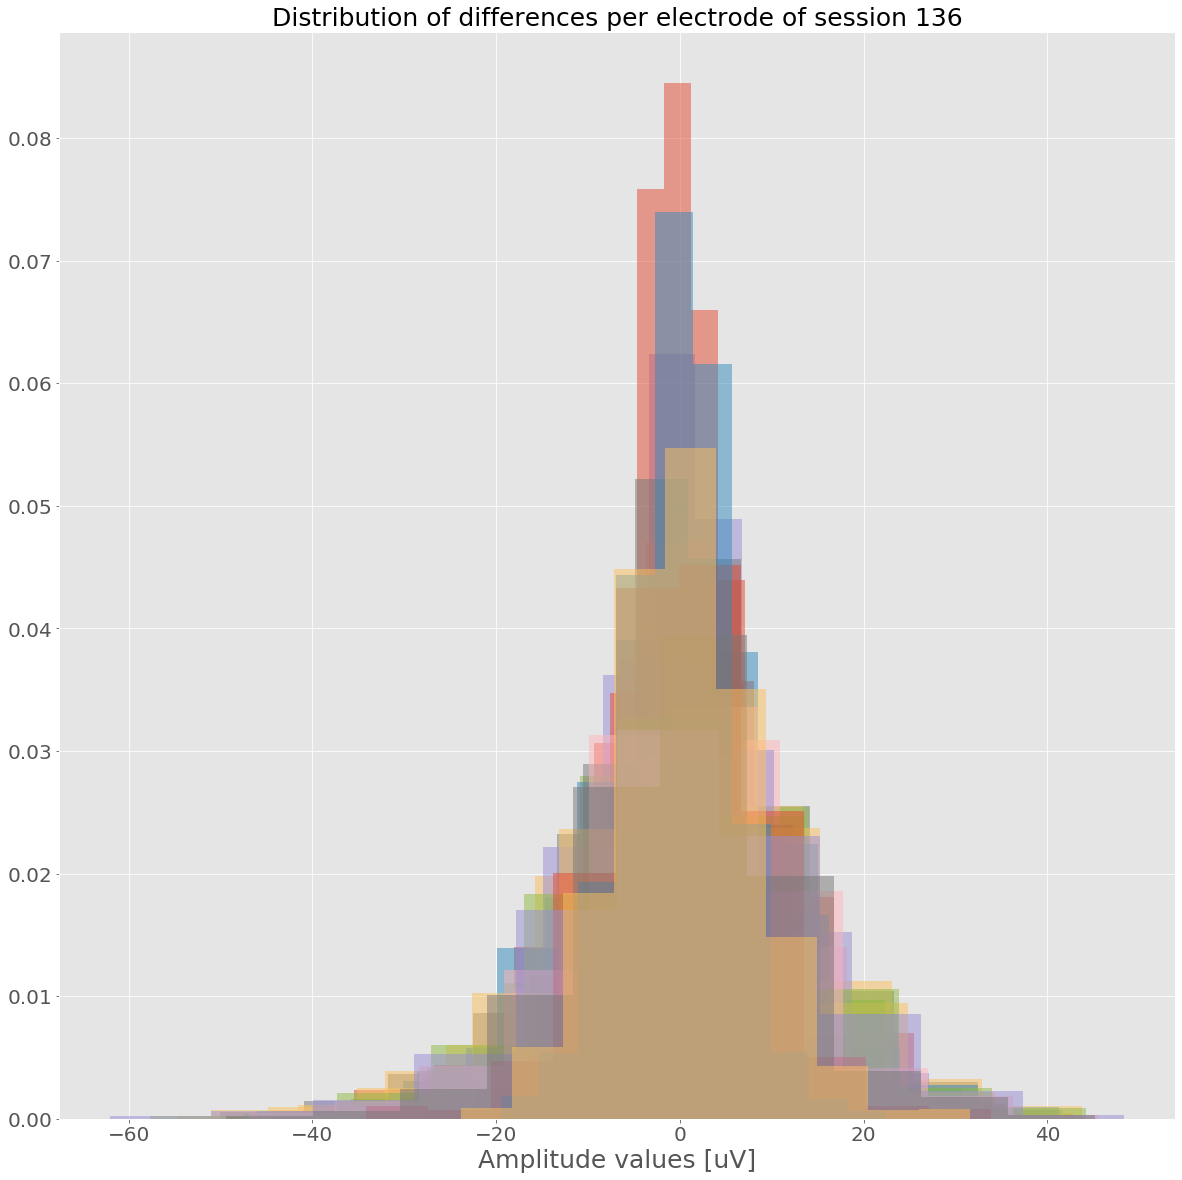

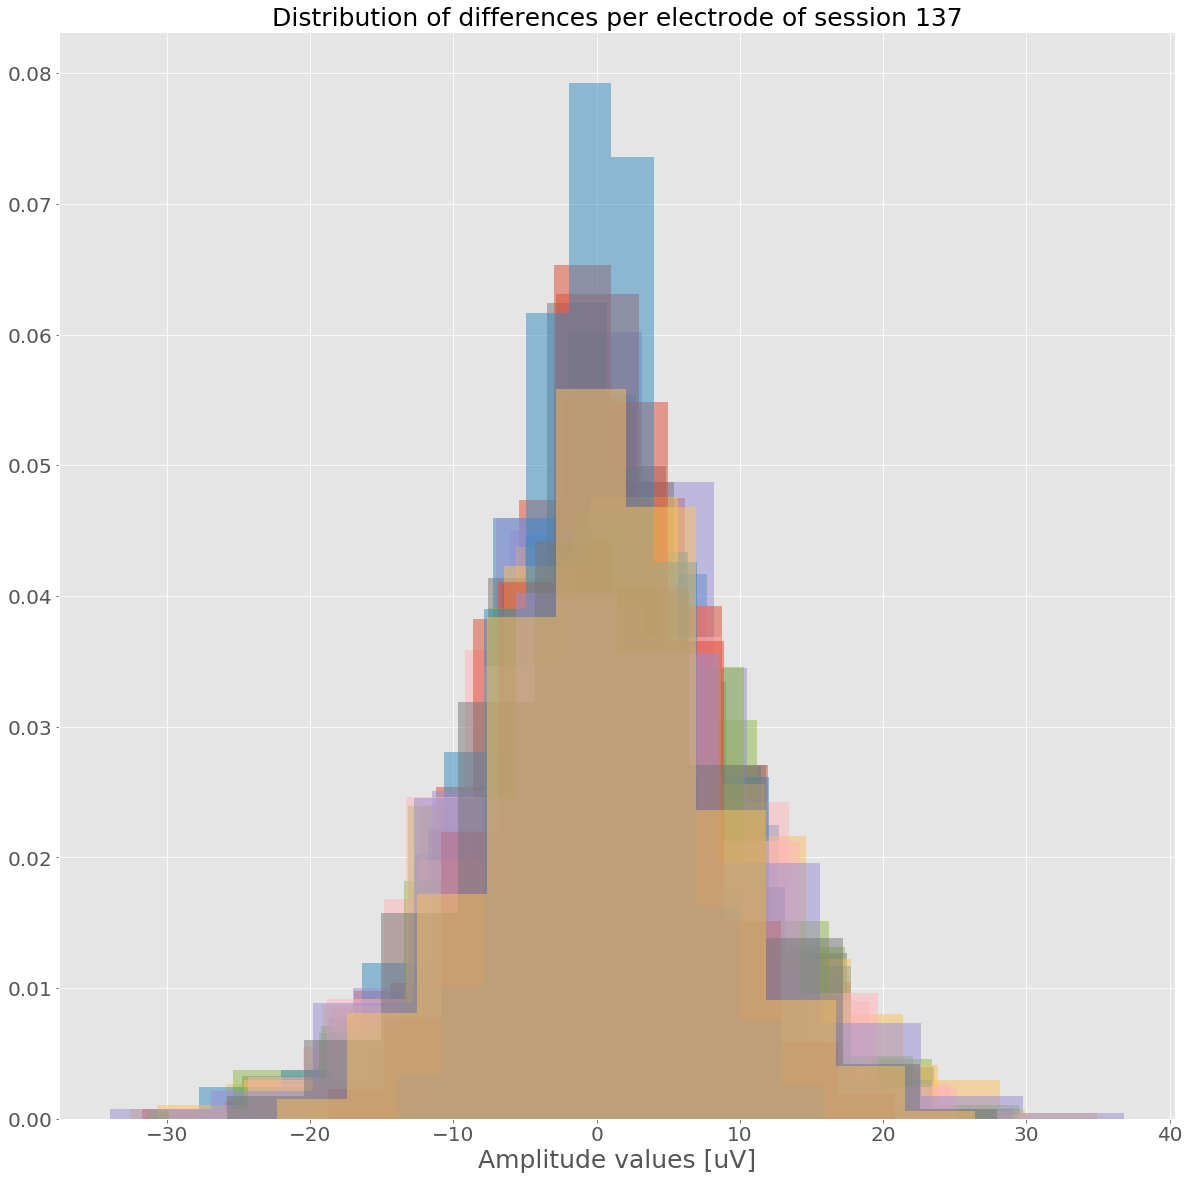

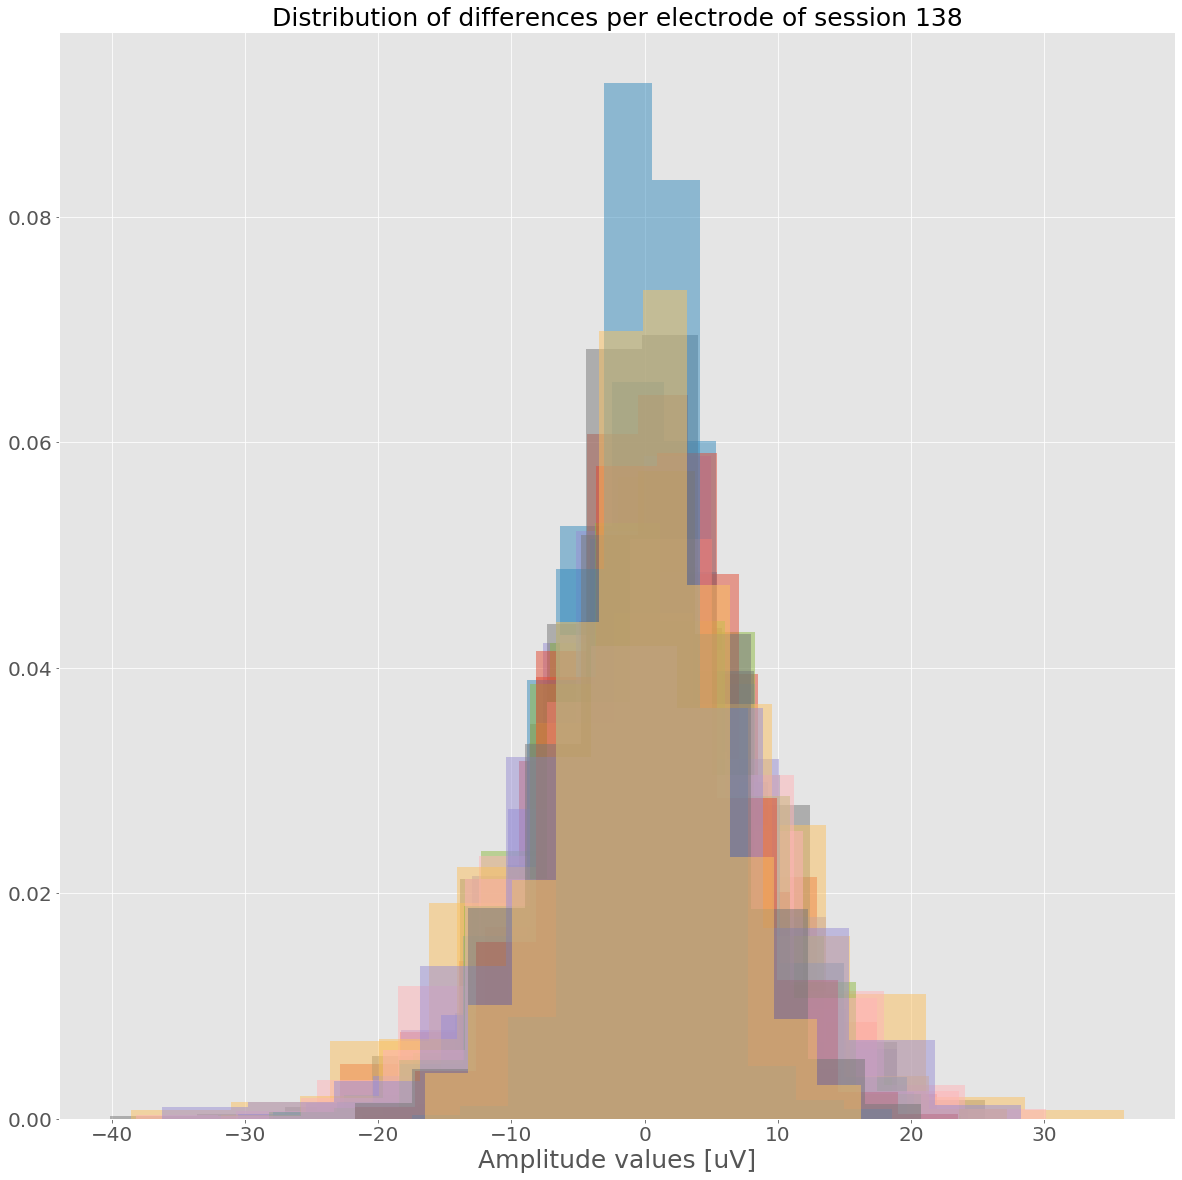

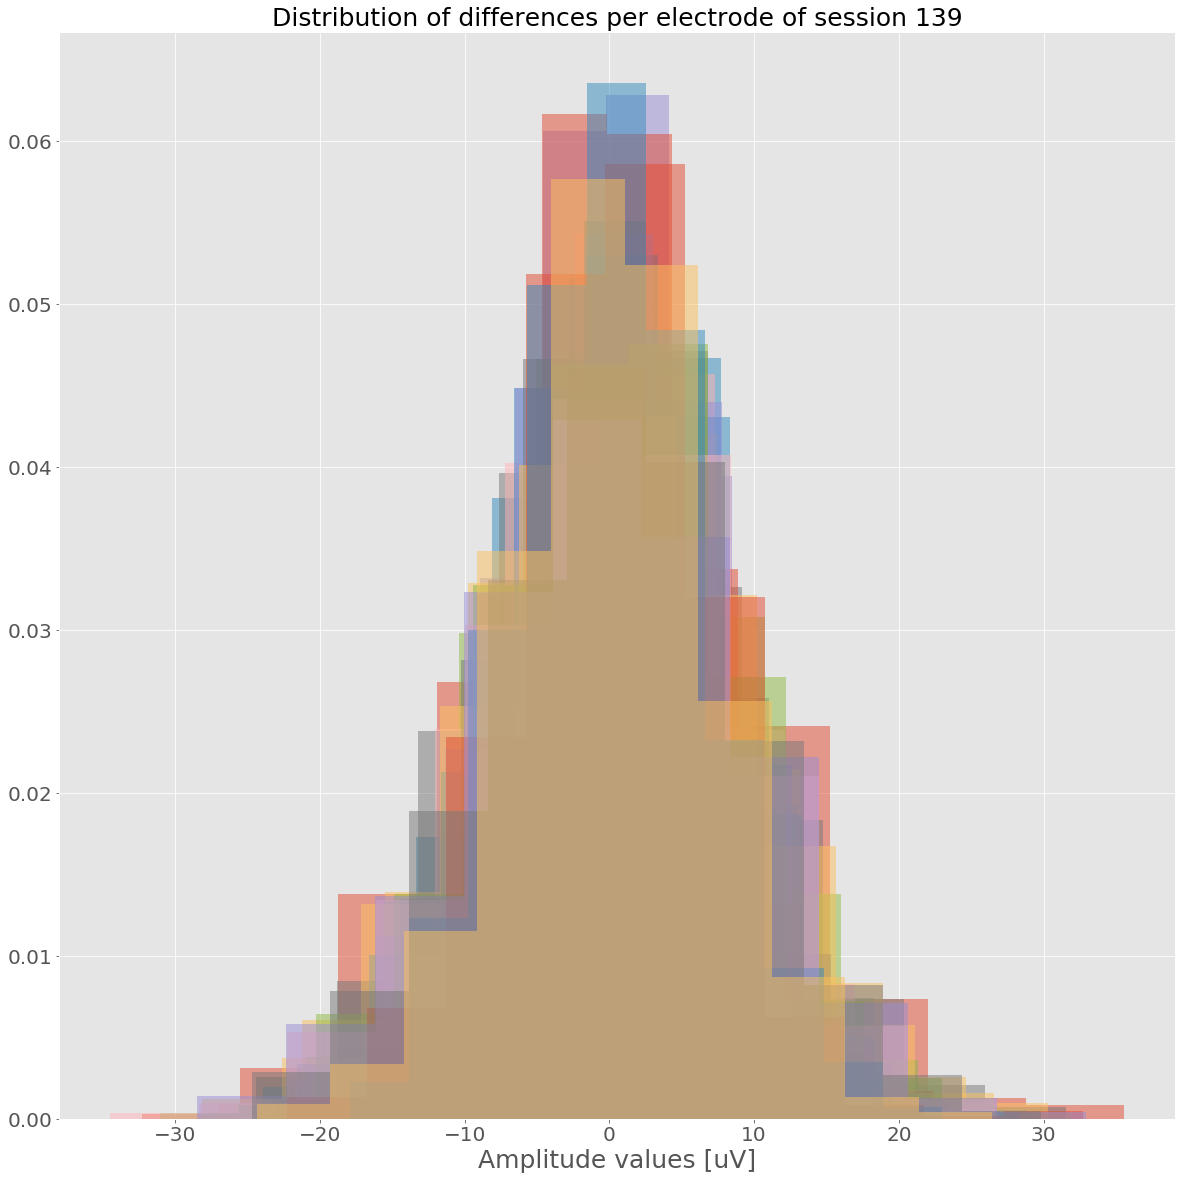

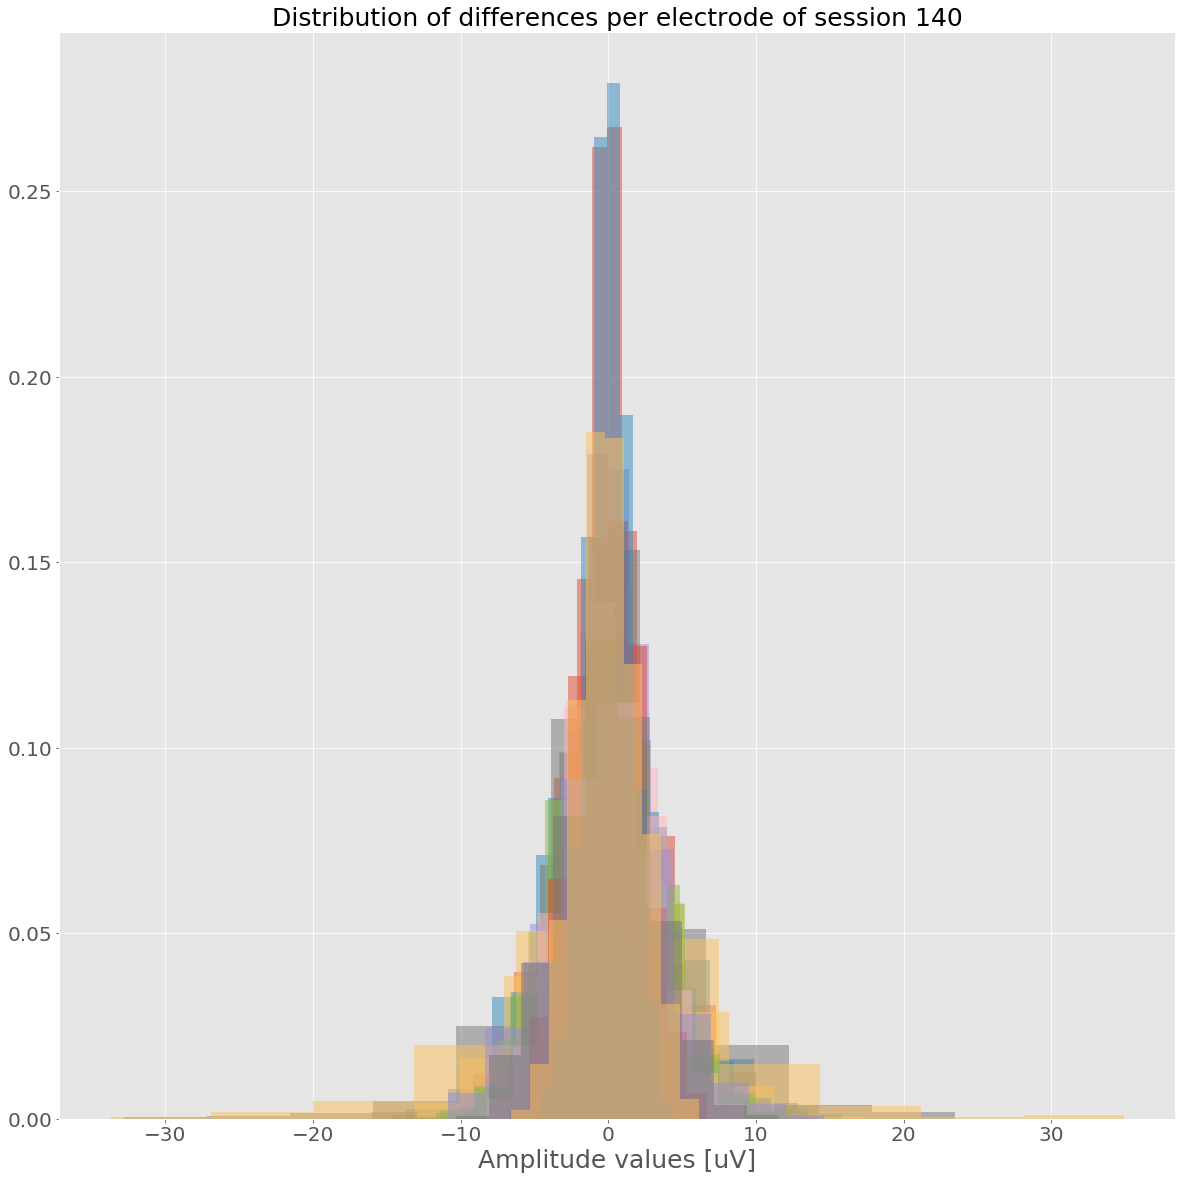

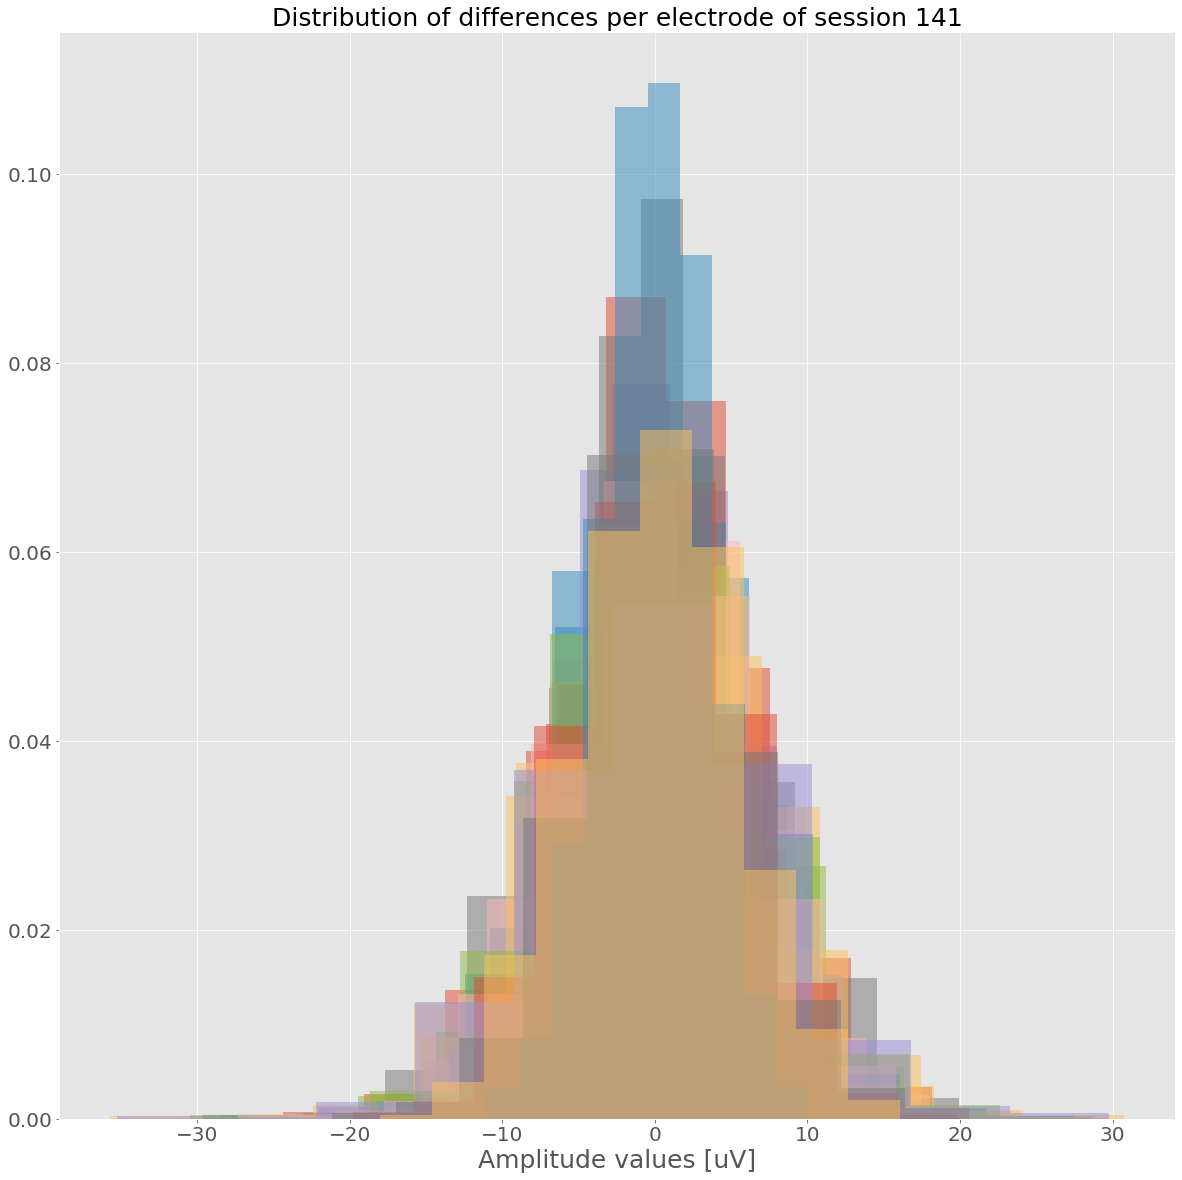

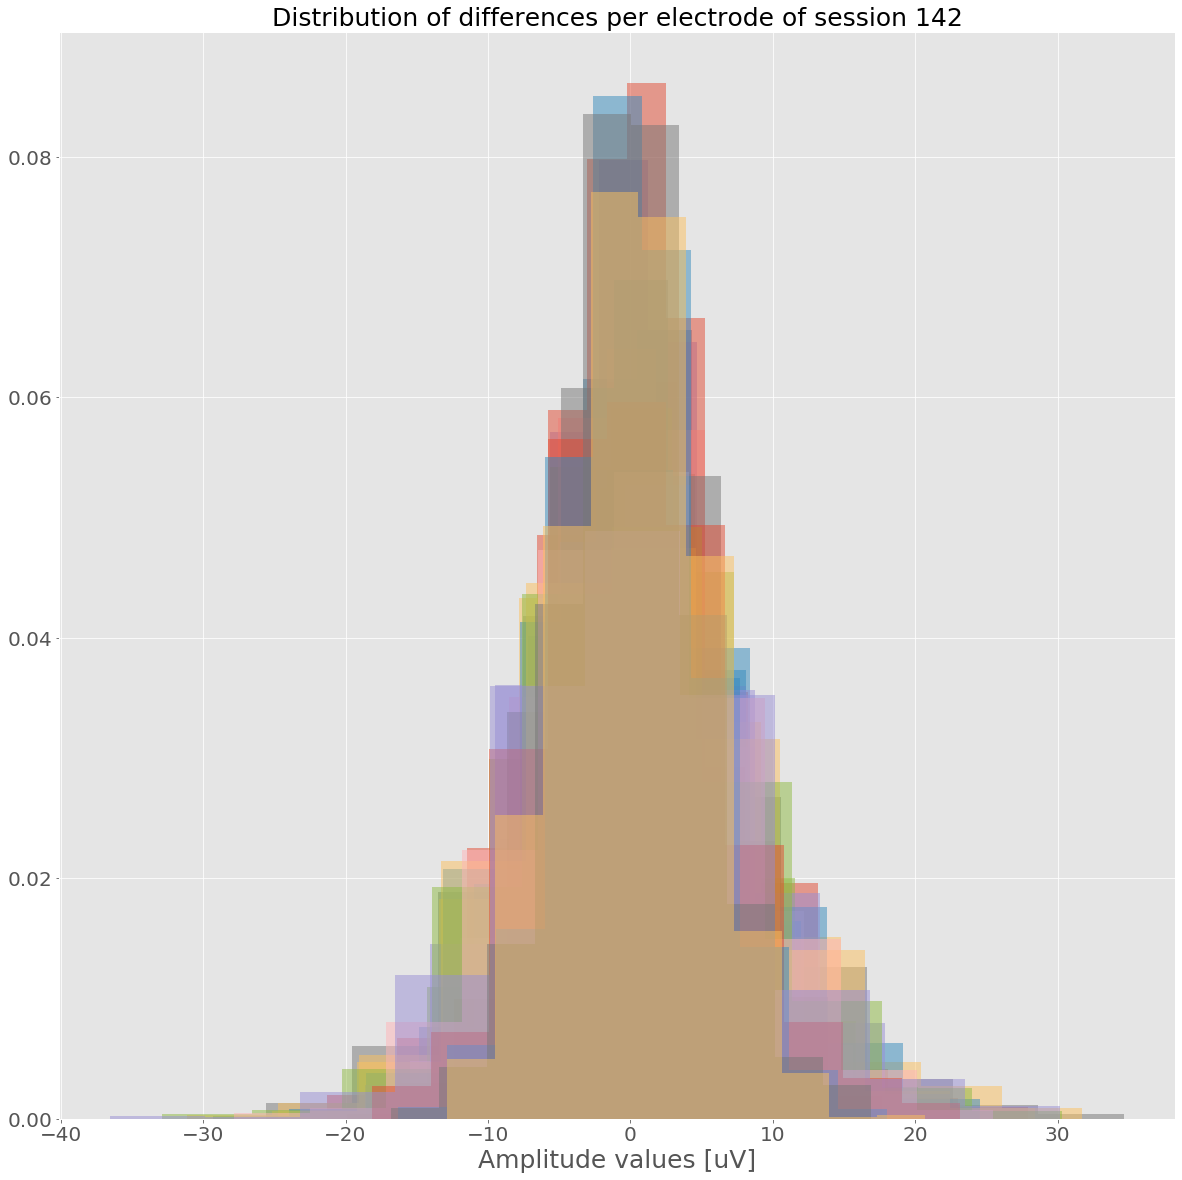

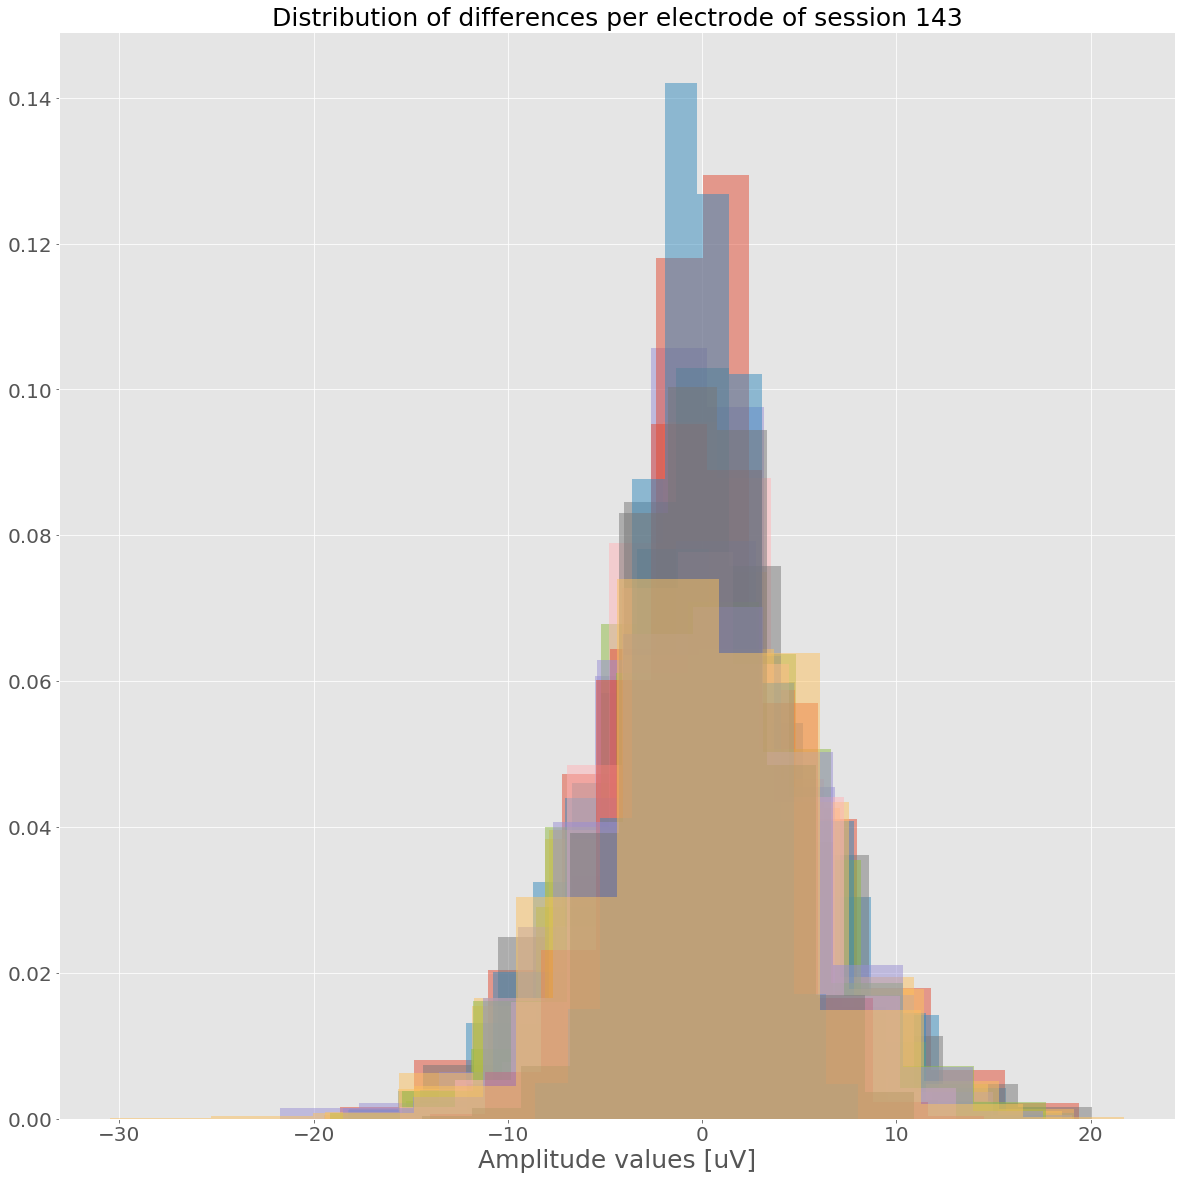

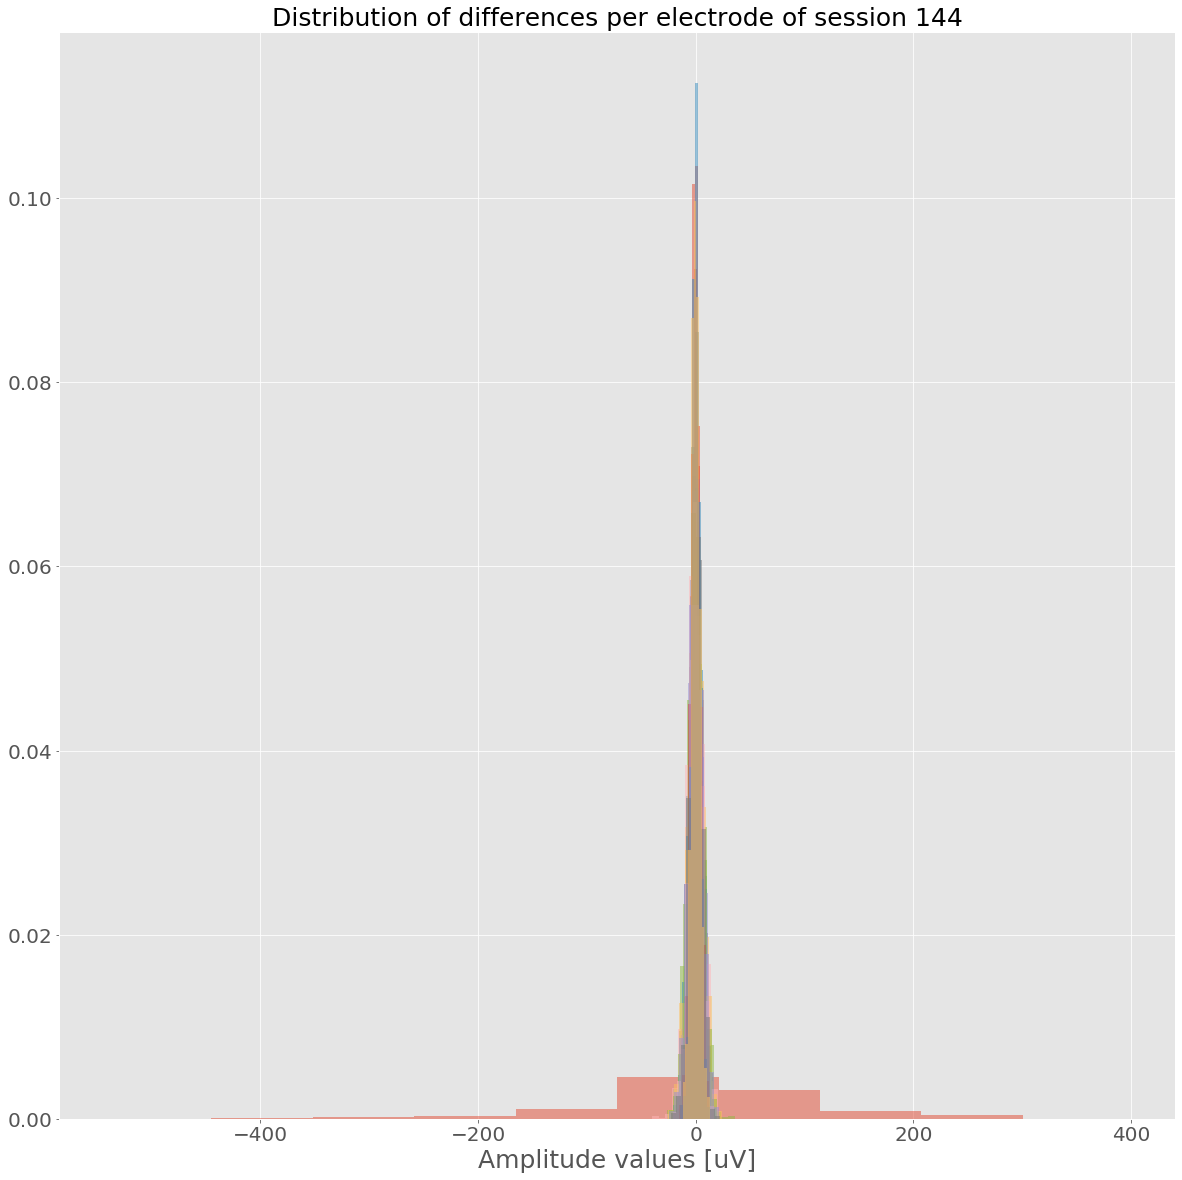

In [143]:
diff_exames = exames_1 - exames_2   # diferenca entre exames

# plotta distribuicao das diferencas entre exames
for exam in range(diff_exames.shape[0]):
    fig,ax = plt.subplots(figsize=(20,20))
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_title('Distribution of differences per electrode of session %d' % (exam+1),fontsize=25)
    ax.set_xlabel('Amplitude values [uV]', fontsize=25)
    
    for i in range(diff_exames.shape[2]):
        #sns.distplot(diff_exames[exam,i,:], ax=ax, kde=False, norm_hist=True)
        ax.hist(diff_exames[exam,:,i], density=True, alpha=0.5)

        
    plt.savefig('/home/pedrosergiot/Documents/PCA_Distributions/difference_distribution_exame_%d.png' % (exam+1))

# Comparing exams in the same session

The following piece of code returns how many electrodes for a sessions presented presented significant difference for each par of EEGs of the same session (right attention and left attention)

In [26]:
# Naive Approach (considers the points in time as independent
t_stats, p_values = ttest_rel(exames_1,exames_2,axis=1)

exam_has_diff = np.sum(p_values <= 0.1, axis=1)   # significance of 10 % (p < 0.1)

print(exam_has_diff)

[14  1  8 11  4  9 16  1  9  8  6 18  4  5  5 13 10  2  7  4  8  1  3  8
 13 13 18  3  4 19  7  8  9 14 10  4 10 16 16  6  7  8 12  3  9  5 12  0
  4 13  9  9 11  4  8  7  2  6  7  6  4 12  3  9 11 12 15  4 12  4  4 13
 11 11  1 13 15  7  4  3 10  7  4  6  0  2  7  7  4  7  8  6 11  9  6  9
 12  5  2  3 13  9 13  6 12  8  5  3  5  2 16 12  5  2  1 16  1 10  8 13
 15  2  1  3  2 13 10  6  4  1 15  5  4  1  2  6 17 11 12  4  2 19  3 15]


Now we calculate how many pairs of electrodes for all sessions presented significant difference according the t-test. The results shows that the electrode which presented more differences did this in at most half the sessions (which can be a reason for the low performance of the classification method) 

In [27]:
eletrodos = ['F7','T3','T5','Fp1','F3','C3','P3','O1','F8','T4','T6','Fp2','F4','C4','P4','O2','Fz','Cz','Pz']

index_diff = np.argsort(-np.sum(p_values <= 0.1, axis=0))

eletrodos_diff = [eletrodos[i] for i in index_diff]

print(eletrodos_diff, '\n')

print([element for element in zip(eletrodos_diff, np.sum(p_values <= 0.1, axis=0)[index_diff])])


['Fp2', 'C3', 'P4', 'Pz', 'Fp1', 'O1', 'P3', 'F7', 'Cz', 'Fz', 'T3', 'O2', 'F8', 'F4', 'T4', 'C4', 'T5', 'F3', 'T6'] 

[('Fp2', 74), ('C3', 67), ('P4', 65), ('Pz', 64), ('Fp1', 63), ('O1', 62), ('P3', 61), ('F7', 60), ('Cz', 59), ('Fz', 59), ('T3', 58), ('O2', 57), ('F8', 55), ('F4', 55), ('T4', 55), ('C4', 54), ('T5', 50), ('F3', 50), ('T6', 45)]


# Comparing an each exam with all exams of the opposite side of attention

For each exam of attention 1, this will calculate the proportion of how many exams of the opposite attention side presented significant difference

In [17]:
# Naive Approach (considers the points in time as independent)

has_diff_ratio = []

for exam1 in exames_1:
    
    has_diff = []
    
    for exam2 in exames_2:
        
        _, p_values = ttest_rel(exam1,exam2,axis=0)
        
        has_diff.append(p_values <= 0.1)
    
    has_diff_ratio.append(np.sum(has_diff, axis=0)/exames_1.shape[0])

has_diff_ratio = np.array(has_diff_ratio)

print(np.mean(has_diff_ratio, axis=0))

[0.39916088 0.38951582 0.38088349 0.41338735 0.39448302 0.41777585
 0.42250193 0.41184414 0.39375965 0.40716628 0.36631944 0.44270833
 0.39076968 0.40157215 0.41637731 0.42520255 0.39891975 0.38208912
 0.44241898]


In [23]:
eletrodos = ['F7','T3','T5','Fp1','F3','C3','P3','O1','F8','T4','T6','Fp2','F4','C4','P4','O2','Fz','Cz','Pz']

index_diff = np.argsort(-np.mean(has_diff_ratio, axis=0))

eletrodos_diff = [eletrodos[i] for i in index_diff]

print(eletrodos_diff, '\n')

print([element for element in zip(eletrodos_diff, np.mean(has_diff_ratio, axis=0)[index_diff])])

['Fp2', 'Pz', 'O2', 'P3', 'C3', 'P4', 'Fp1', 'O1', 'T4', 'C4', 'F7', 'Fz', 'F3', 'F8', 'F4', 'T3', 'Cz', 'T5', 'T6'] 

[('Fp2', 0.4427083333333334), ('Pz', 0.4424189814814816), ('O2', 0.4252025462962963), ('P3', 0.4225019290123455), ('C3', 0.4177758487654321), ('P4', 0.4163773148148147), ('Fp1', 0.41338734567901236), ('O1', 0.41184413580246926), ('T4', 0.4071662808641976), ('C4', 0.40157214506172856), ('F7', 0.3991608796296297), ('Fz', 0.39891975308641964), ('F3', 0.39448302469135826), ('F8', 0.39375964506172856), ('F4', 0.39076967592592593), ('T3', 0.3895158179012348), ('Cz', 0.38208912037037046), ('T5', 0.380883487654321), ('T6', 0.3663194444444444)]


# SECOND APPROACH: USING KL DIVERGENCE

First, let's try to find the distribution of an electrode by using a Kernel Density Estimation with gaussian kernel. The result shows a reasonable good fit for the data

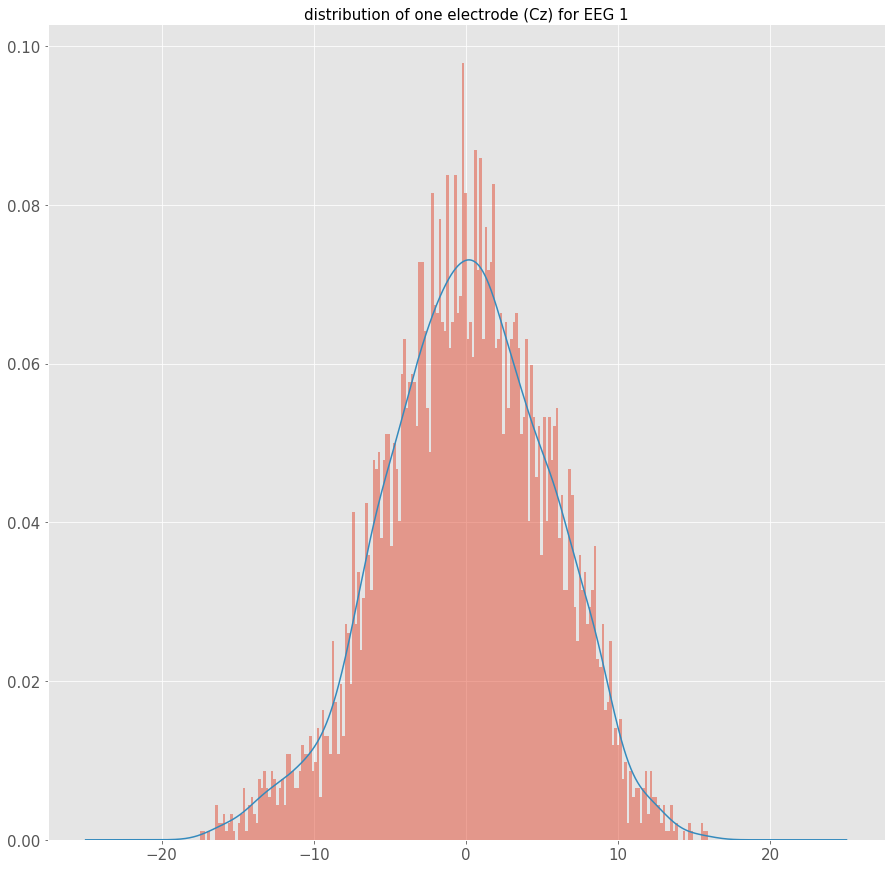

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

plt.style.use("ggplot")

fig,ax = plt.subplots(figsize=(15,15))
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_title('distribution of one electrode (Cz) for EEG 1', fontsize=15)
    
n,bins,_ = ax.hist(exames_1[0,:,18], bins=200, density=True, alpha=0.5);

KDEpdf1 = gaussian_kde(exames_1[0,:,18])

x = np.linspace(-25,25,len(exames_1[0,:,18]))
ax.plot(x, KDEpdf1(x));

Doing the same for same electrode of the same session, but for a different side of attention

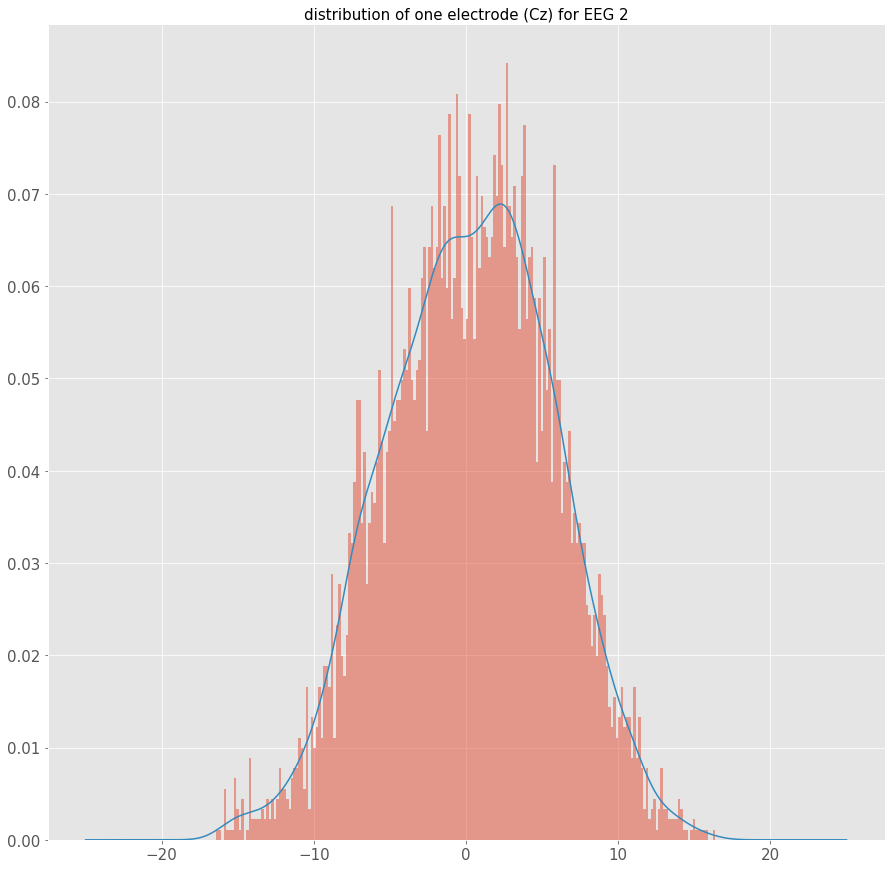

In [29]:
fig,ax = plt.subplots(figsize=(15,15))
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_title('distribution of one electrode (Cz) for EEG 2', fontsize=15)
    
n,bins,_ = ax.hist(exames_2[0,:,18], bins=200, density=True, alpha=0.5);

KDEpdf2 = gaussian_kde(exames_2[0,:,18])

x = np.linspace(-25,25,len(exames_2[0,:,18]))
ax.plot(x, KDEpdf2(x));

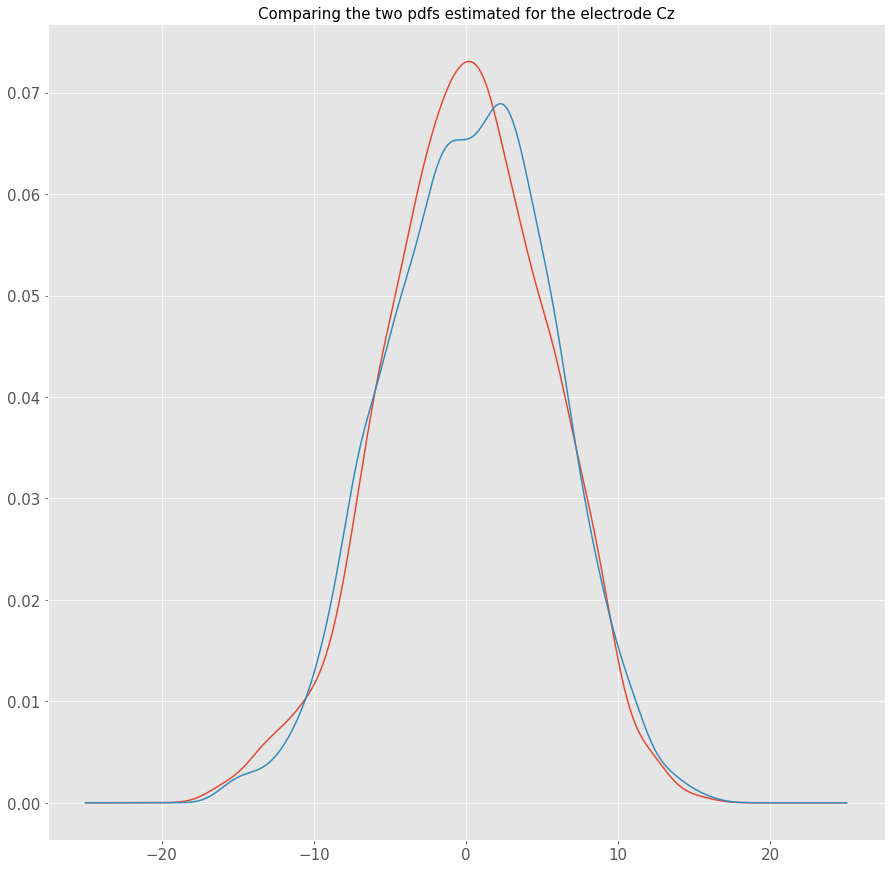

In [30]:
fig,ax = plt.subplots(figsize=(15,15))
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_title('Comparing the two pdfs estimated for the electrode Cz', fontsize=15)

x = np.linspace(-25,25,len(exames_2[0,:,18]))

ax.plot(x, KDEpdf1(x));
ax.plot(x, KDEpdf2(x));

# Comparing exams in the same session

In [33]:
kl_session = []

for exam_ind in range(exames_1.shape[0]):
    kl_channel = []
    
    for channel_ind in range(exames_1.shape[2]):
        x = np.linspace(-50,50,len(exames_1[0,:,0]))
        
        pdf1 = gaussian_kde(exames_1[exam_ind,:,channel_ind]).evaluate(x)
        pdf2 = gaussian_kde(exames_2[exam_ind,:,channel_ind]).evaluate(x)
        
        # to avoid zero values in the KL div equation
        non_zero_ind = np.logical_and(pdf1 > 0.0000001, pdf2 > 0.0000001)
        
        pdf1 = pdf1[non_zero_ind]
        pdf2 = pdf2[non_zero_ind]
        
        kl_channel.append(sum(pdf1*np.log(pdf1/pdf2)))
    
    kl_session.append(kl_channel)

kl_session = np.asarray(kl_session)

kl_session.shape

(144, 19)

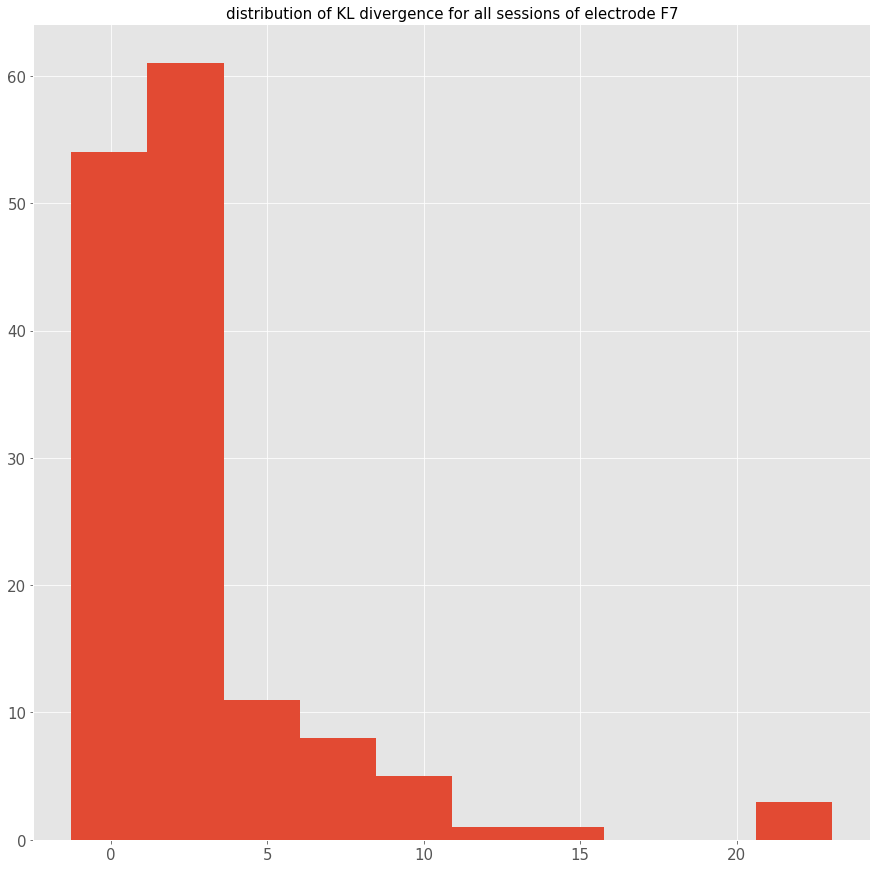

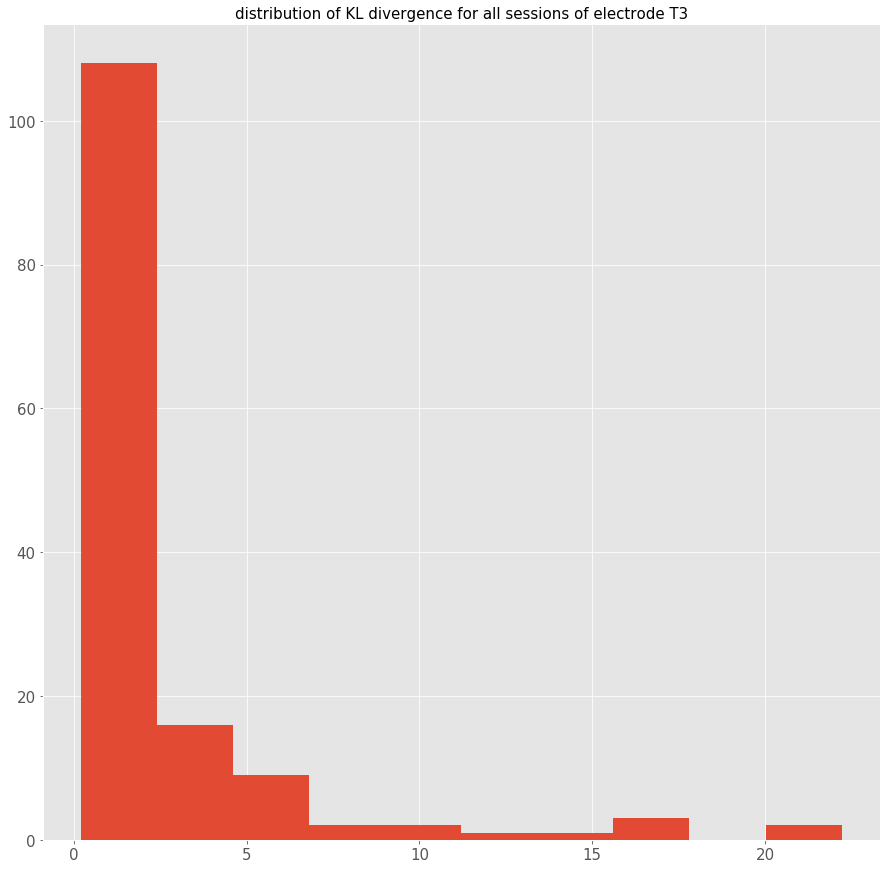

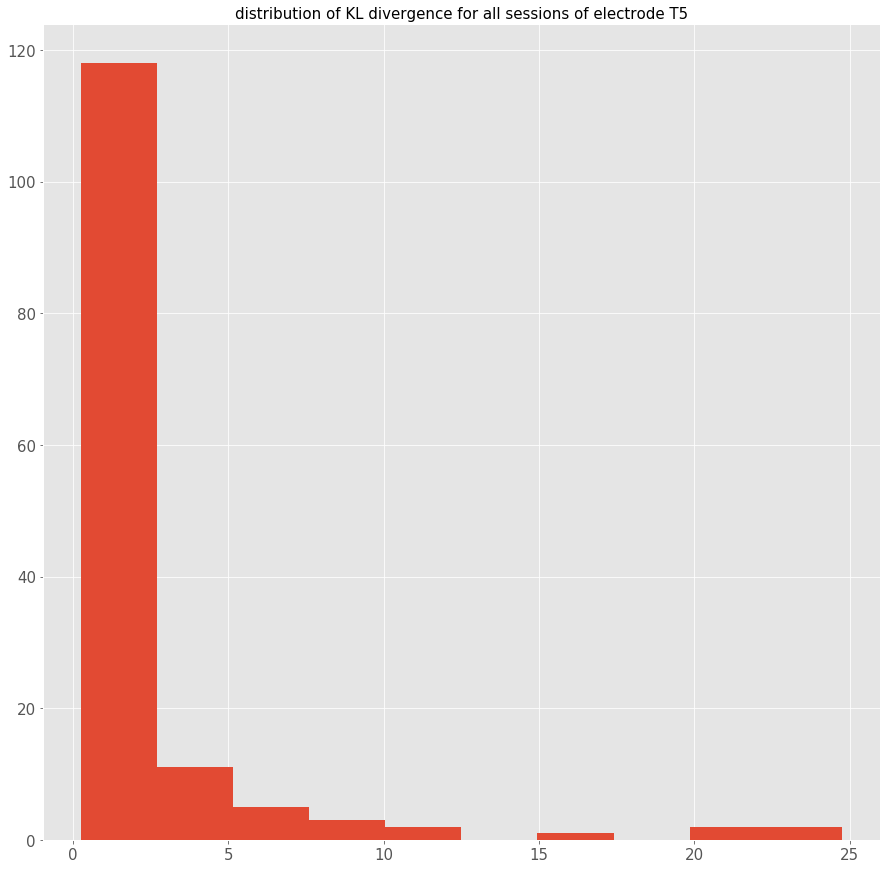

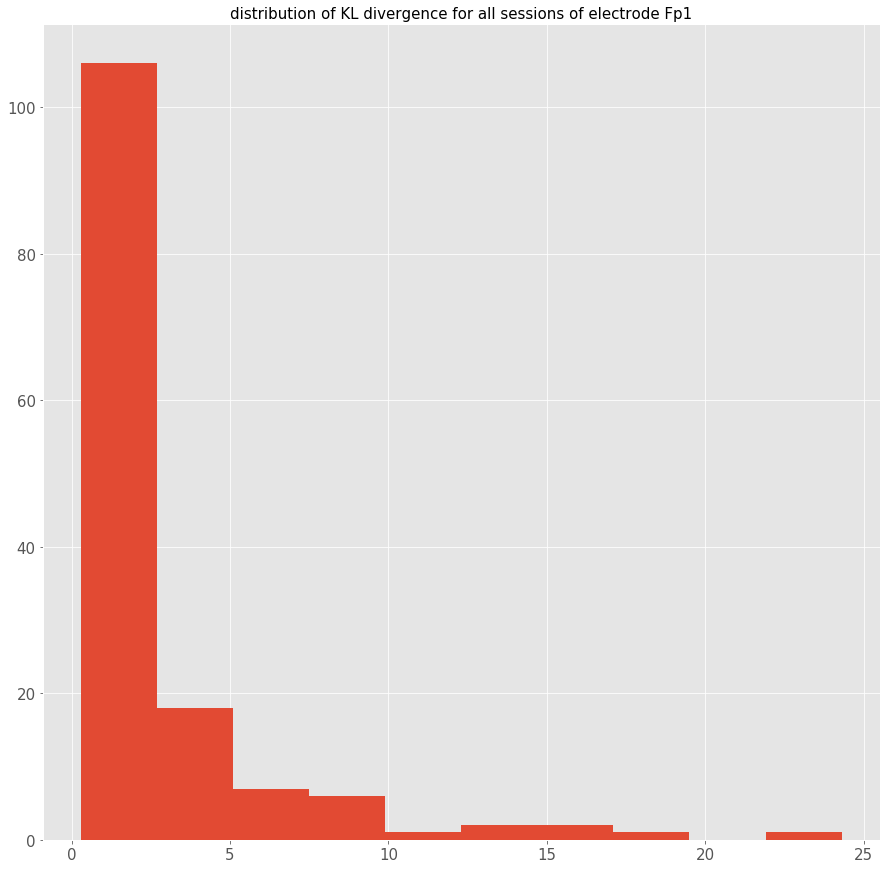

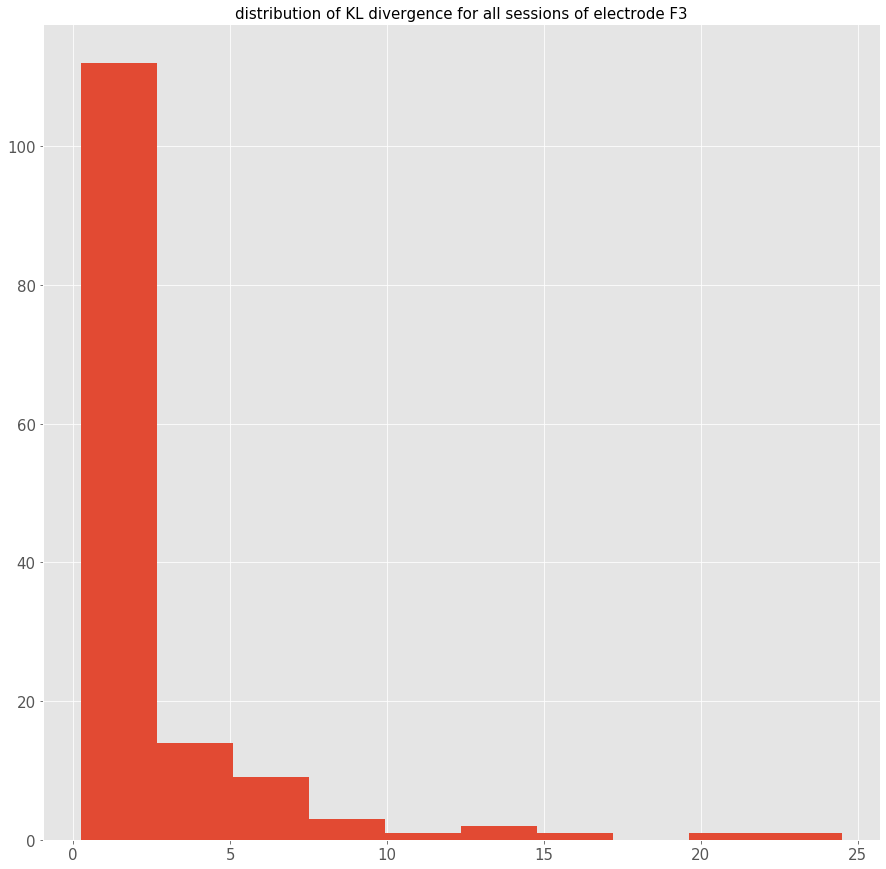

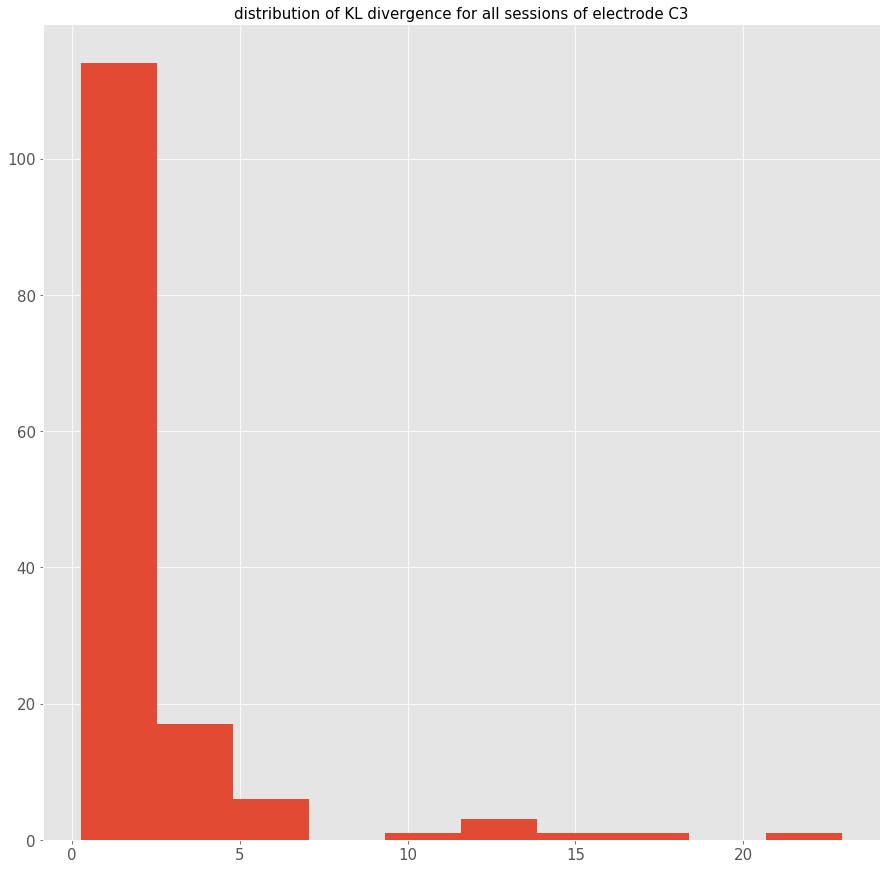

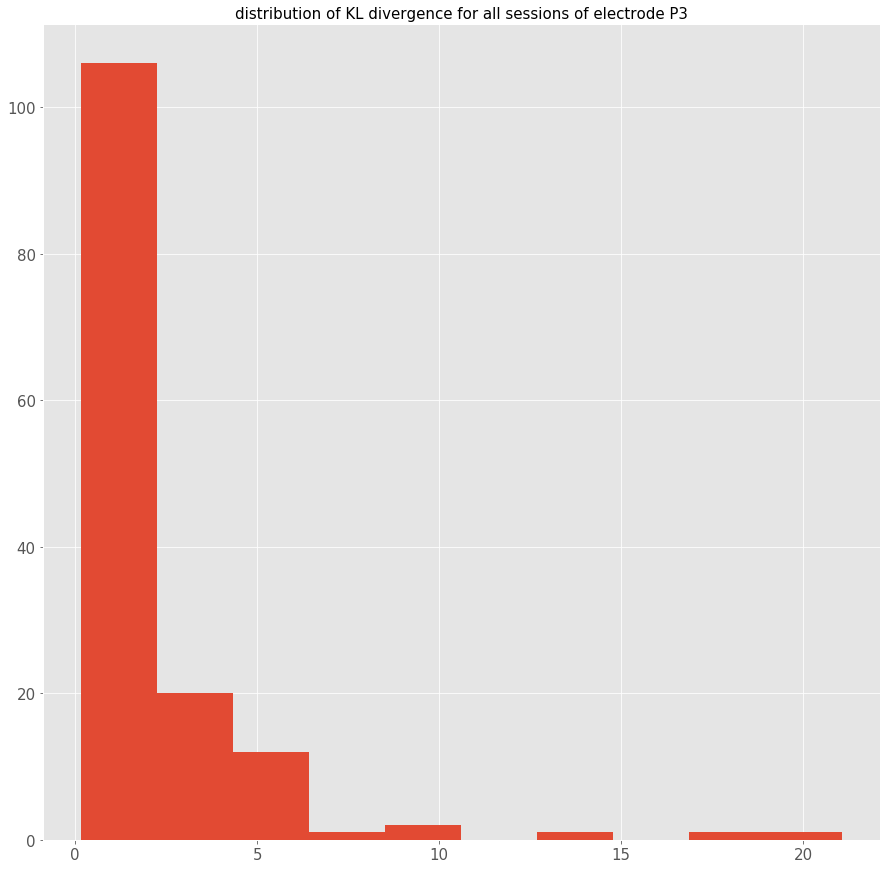

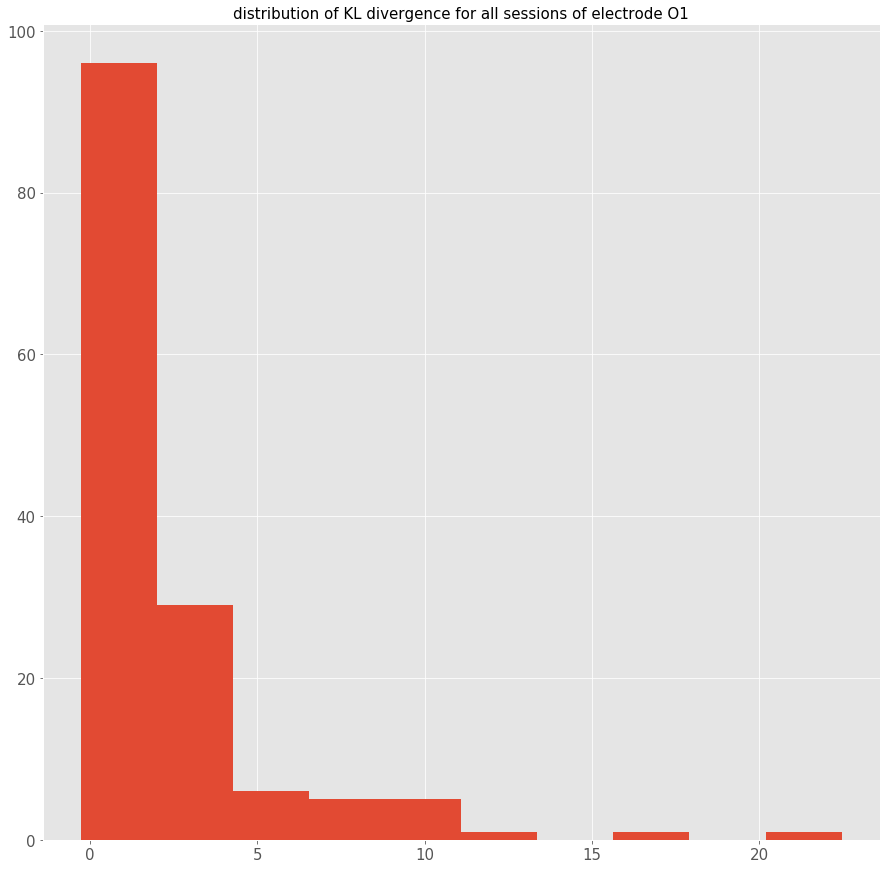

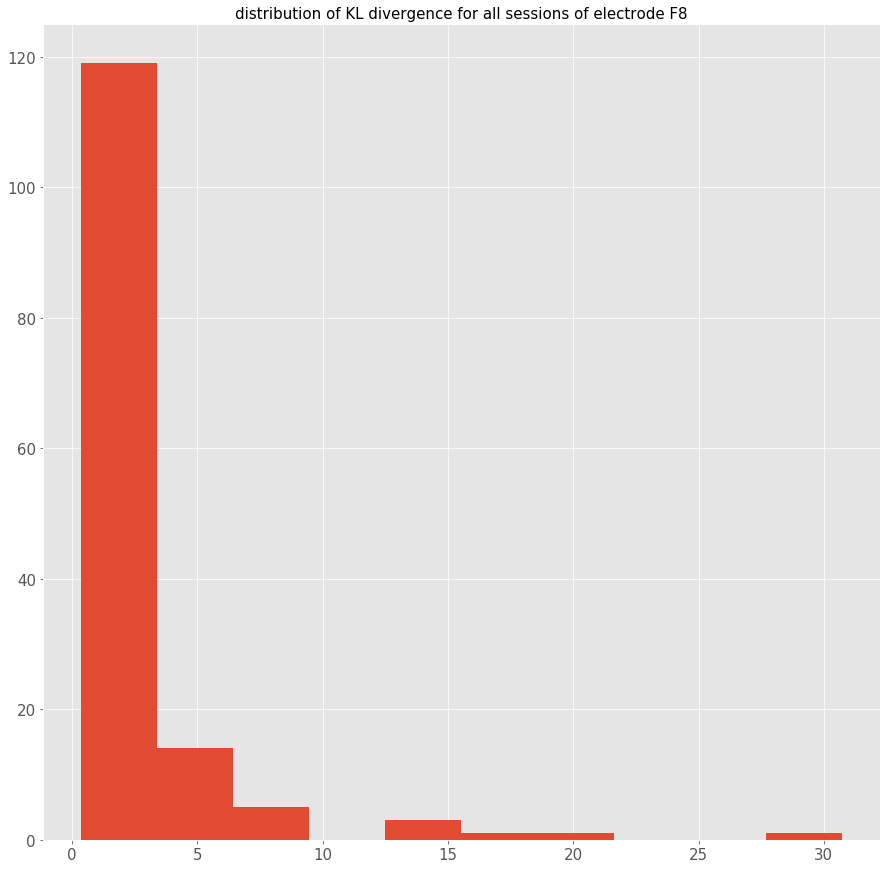

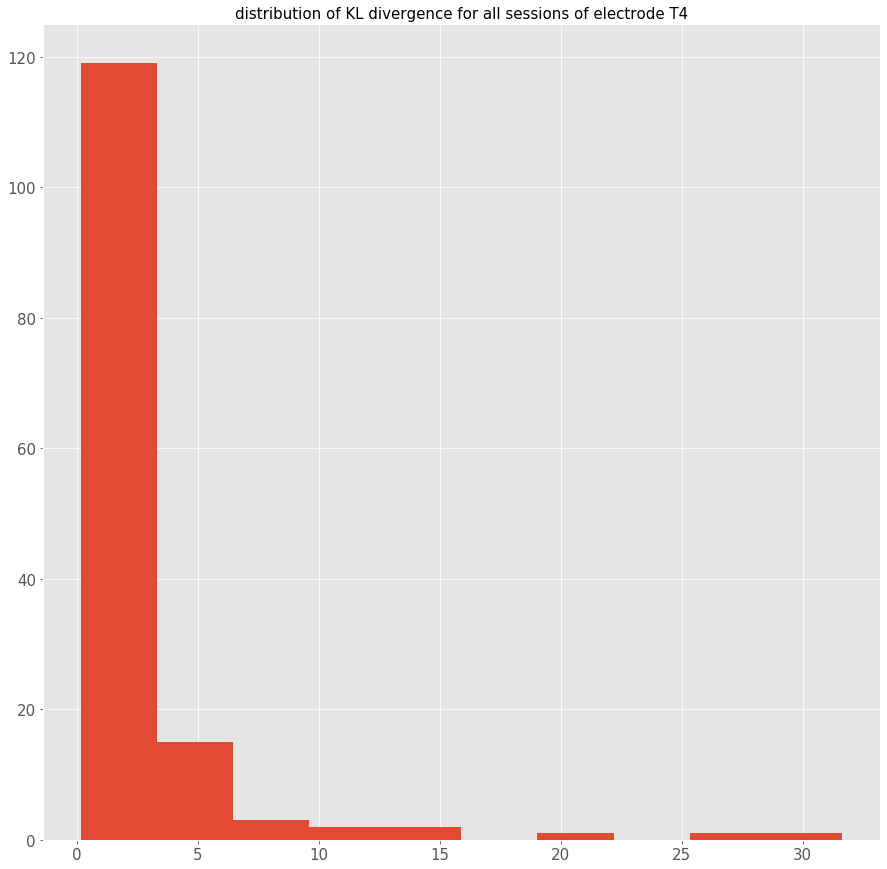

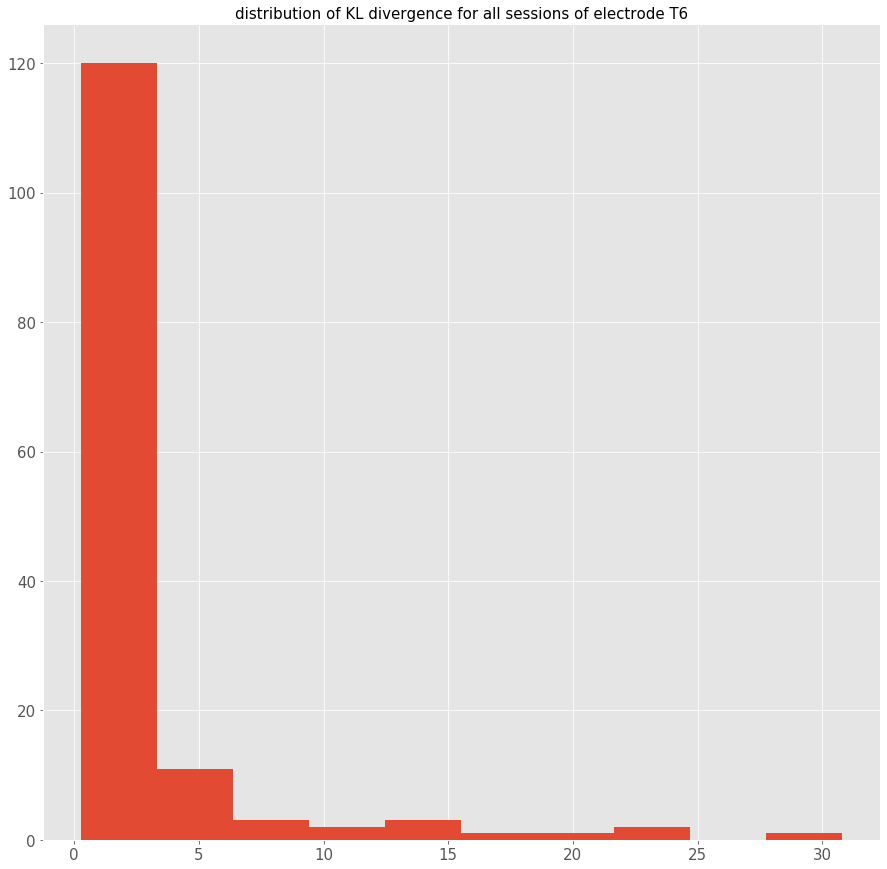

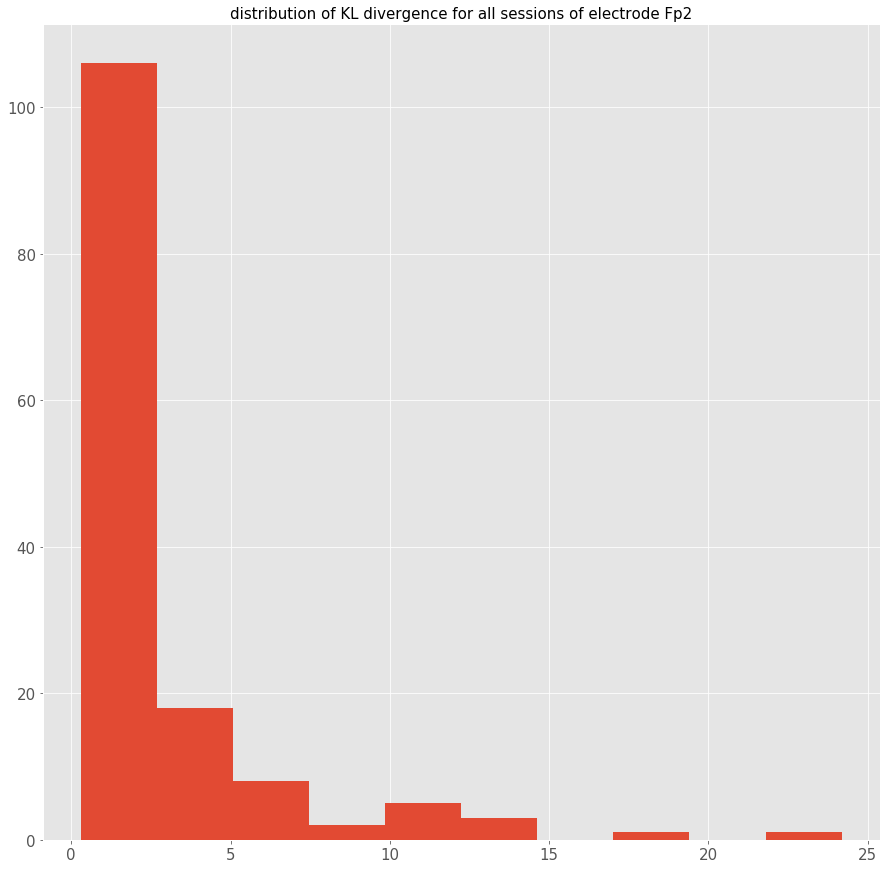

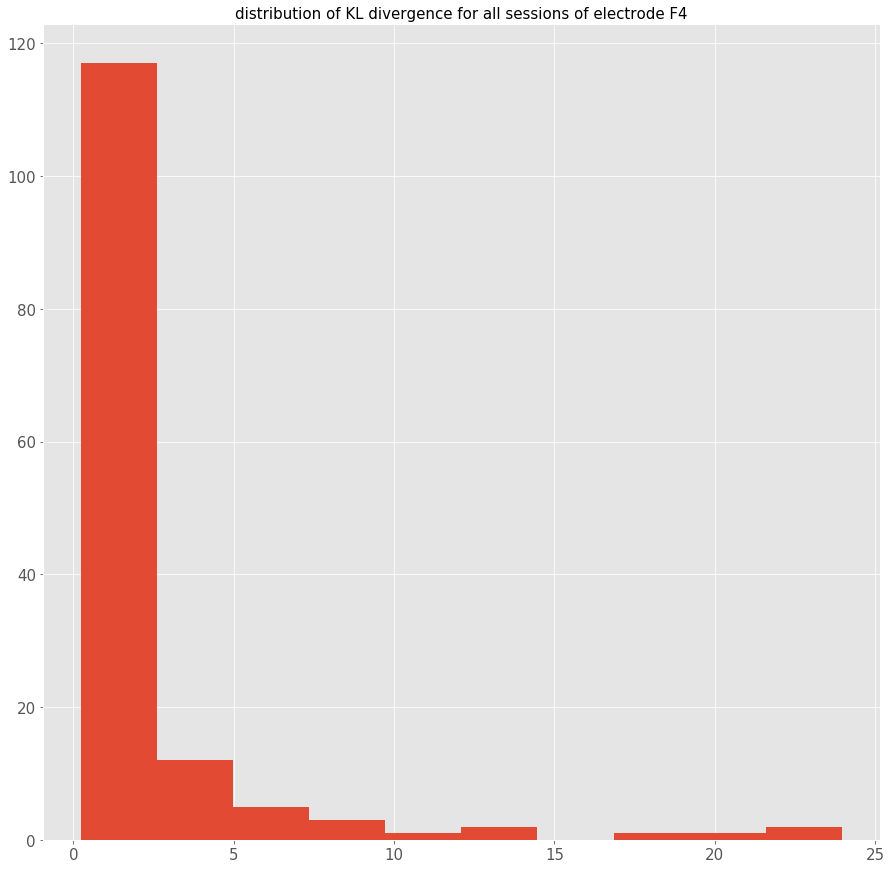

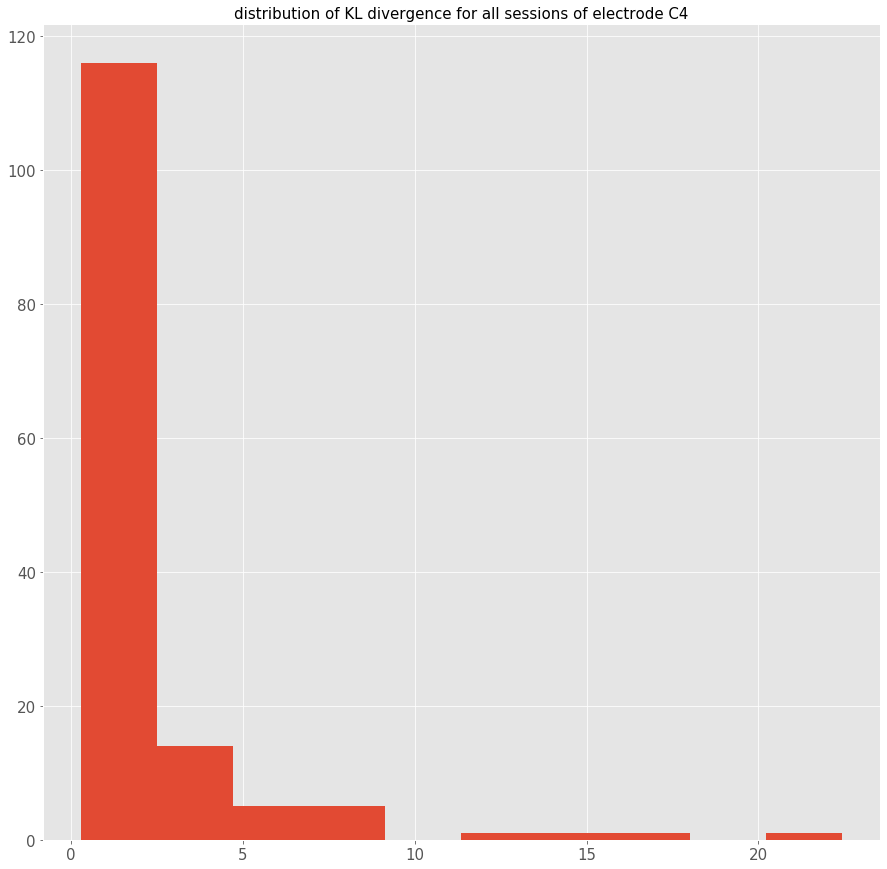

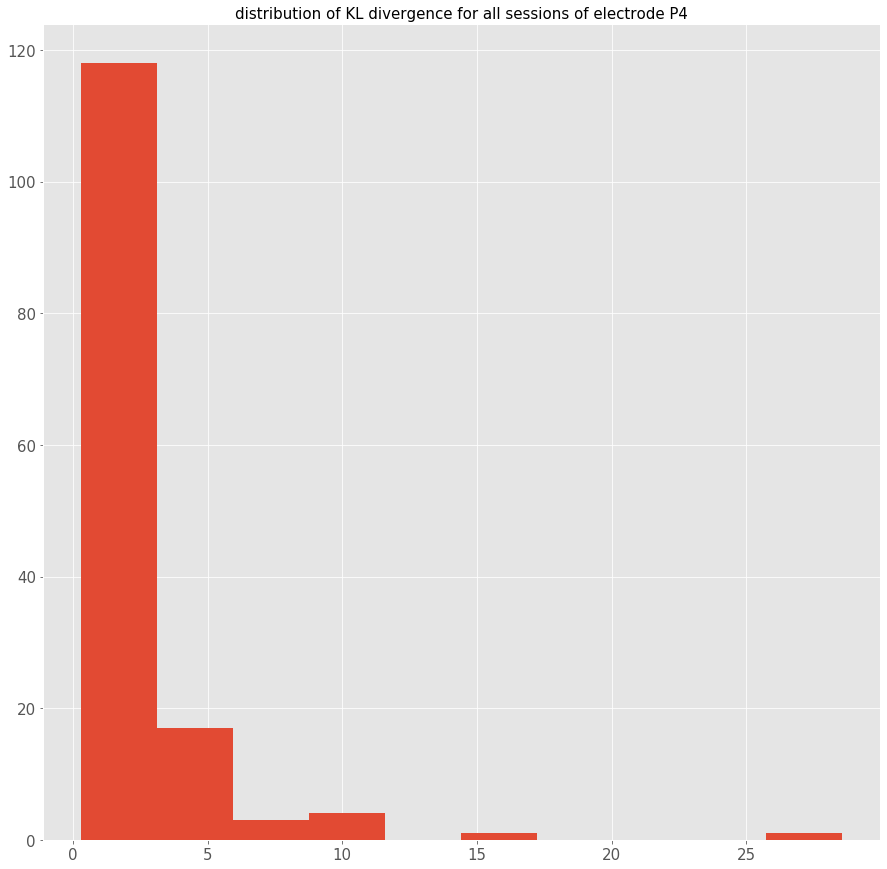

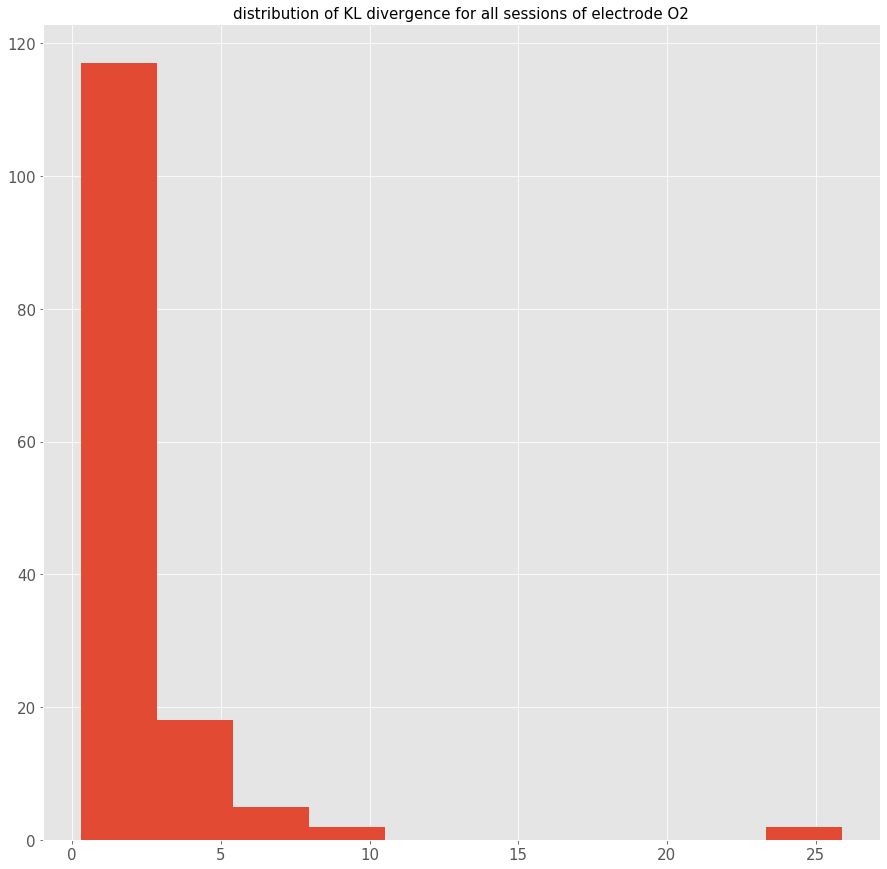

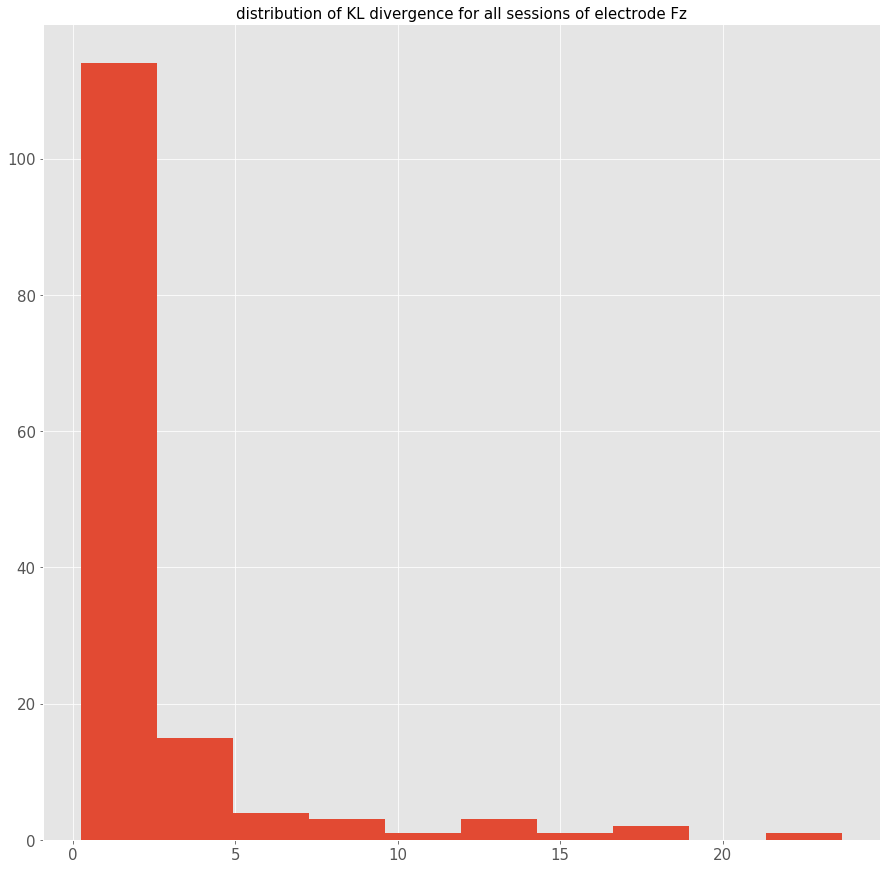

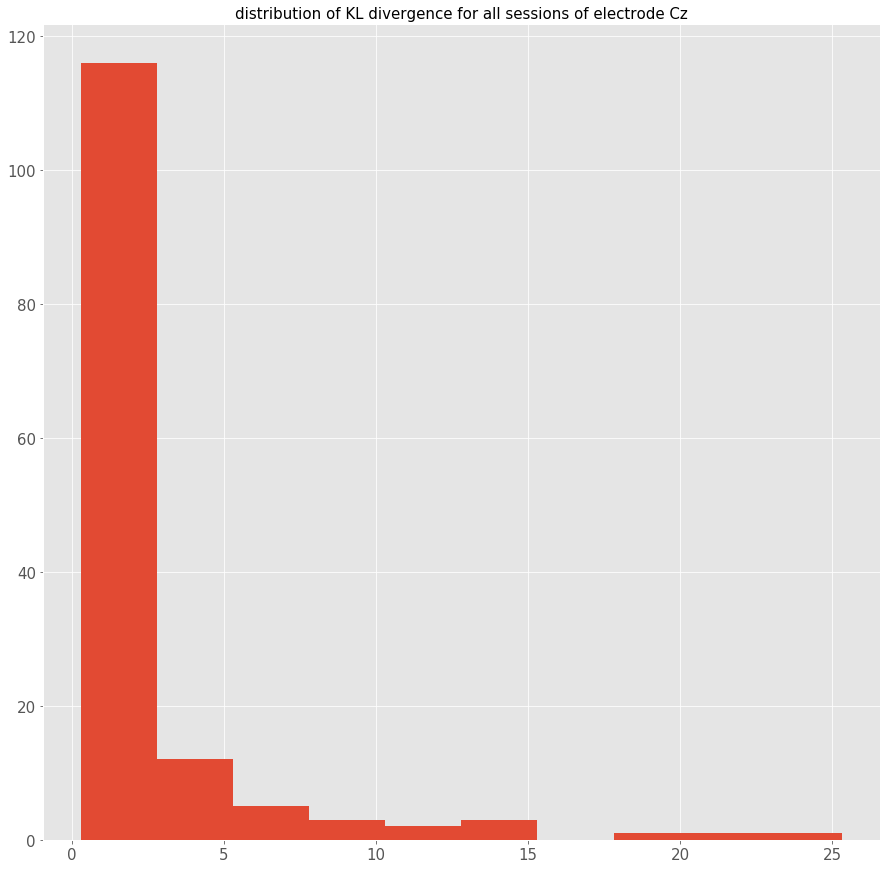

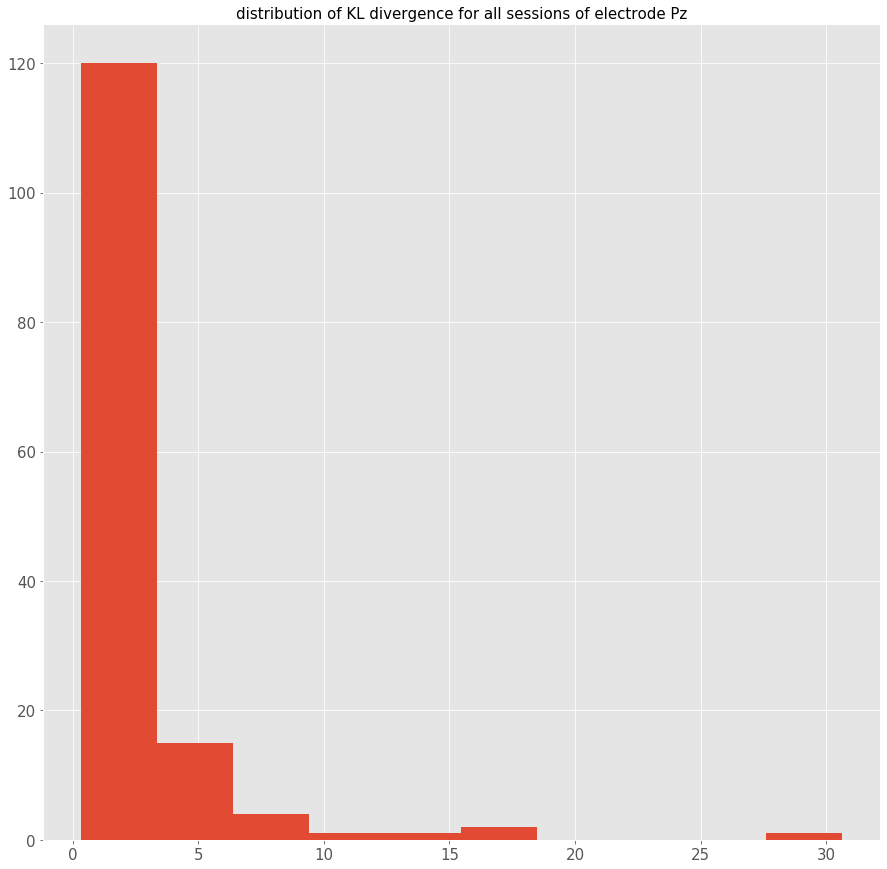

In [37]:
plt.style.use("ggplot")

for it in range(kl_session.shape[1]):
    fig,ax = plt.subplots(figsize=(15,15))
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.set_title('distribution of KL divergence for all sessions of electrode %s' %eletrodos[it], fontsize=15)
    ax.hist(kl_session[:,it])

In [38]:
index_kl = np.argsort(np.sum(kl_session, axis=0))
electrodes_kl = [eletrodos[i] for i in index_kl]
print(electrodes_kl)

['O2', 'P3', 'C4', 'C3', 'P4', 'F4', 'Pz', 'O1', 'Fz', 'F3', 'T5', 'F8', 'Cz', 'T3', 'T4', 'F7', 'Fp2', 'T6', 'Fp1']


# Comparing each exam with all exams of the opposite side of attention

In [45]:
def kl_div(ch1, ch2, x):
    
    pdf1 = gaussian_kde(ch1).evaluate(x)
    pdf2 = gaussian_kde(ch2).evaluate(x)
    
    # to avoid zero values in the KL div equation
    non_zero_ind = np.logical_and(pdf1 > 0.0000001, pdf2 > 0.0000001)
    
    pdf1 = pdf1[non_zero_ind]
    pdf2 = pdf2[non_zero_ind]
    
    return sum(pdf1*np.log(pdf1/pdf2))
    


kl_total = []

x = np.linspace(-50,50,len(exames_1[0,:,0]))

for exam_ind1 in range(exames_1.shape[0]):
    
    kl_exam = []
    
    for exam_ind2 in range(exames_2.shape[0]):
        
        exam1 = exames_1[exam_ind1,:,:]
        exam2 = exames_2[exam_ind2,:,:]
        
        kl_channel = Parallel(n_jobs=-3)(delayed(kl_div)(exam1[:,channel_ind], exam2[:,channel_ind], x)
                                         for channel_ind in range(exames_1.shape[2]))
        
        kl_exam.append(kl_channel)
        
        print('exam_',exam_ind1,'exam_',exam_ind2)
        
    print('exam_',exam_ind1,'completed')

kl_total.append(kl_exam)

kl_total = np.asarray(kl_total)

kl_session.shape

exam_ 0 exam_ 0
exam_ 0 exam_ 1
exam_ 0 exam_ 2
exam_ 0 exam_ 3
exam_ 0 exam_ 4
exam_ 0 exam_ 5
exam_ 0 exam_ 6
exam_ 0 exam_ 7
exam_ 0 exam_ 8
exam_ 0 exam_ 9
exam_ 0 exam_ 10
exam_ 0 exam_ 11
exam_ 0 exam_ 12
exam_ 0 exam_ 13
exam_ 0 exam_ 14
exam_ 0 exam_ 15
exam_ 0 exam_ 16
exam_ 0 exam_ 17
exam_ 0 exam_ 18
exam_ 0 exam_ 19
exam_ 0 exam_ 20
exam_ 0 exam_ 21
exam_ 0 exam_ 22
exam_ 0 exam_ 23
exam_ 0 exam_ 24
exam_ 0 exam_ 25
exam_ 0 exam_ 26
exam_ 0 exam_ 27
exam_ 0 exam_ 28
exam_ 0 exam_ 29
exam_ 0 exam_ 30
exam_ 0 exam_ 31
exam_ 0 exam_ 32
exam_ 0 exam_ 33
exam_ 0 exam_ 34
exam_ 0 exam_ 35
exam_ 0 exam_ 36
exam_ 0 exam_ 37
exam_ 0 exam_ 38
exam_ 0 exam_ 39
exam_ 0 exam_ 40
exam_ 0 exam_ 41
exam_ 0 exam_ 42
exam_ 0 exam_ 43
exam_ 0 exam_ 44
exam_ 0 exam_ 45
exam_ 0 exam_ 46
exam_ 0 exam_ 47
exam_ 0 exam_ 48
exam_ 0 exam_ 49
exam_ 0 exam_ 50
exam_ 0 exam_ 51
exam_ 0 exam_ 52
exam_ 0 exam_ 53
exam_ 0 exam_ 54
exam_ 0 exam_ 55
exam_ 0 exam_ 56
exam_ 0 exam_ 57
exam_ 0 exam_ 58
exam_ 0

exam_ 3 exam_ 42
exam_ 3 exam_ 43
exam_ 3 exam_ 44
exam_ 3 exam_ 45
exam_ 3 exam_ 46
exam_ 3 exam_ 47
exam_ 3 exam_ 48
exam_ 3 exam_ 49
exam_ 3 exam_ 50
exam_ 3 exam_ 51
exam_ 3 exam_ 52
exam_ 3 exam_ 53
exam_ 3 exam_ 54
exam_ 3 exam_ 55
exam_ 3 exam_ 56
exam_ 3 exam_ 57
exam_ 3 exam_ 58
exam_ 3 exam_ 59
exam_ 3 exam_ 60
exam_ 3 exam_ 61
exam_ 3 exam_ 62
exam_ 3 exam_ 63
exam_ 3 exam_ 64
exam_ 3 exam_ 65
exam_ 3 exam_ 66
exam_ 3 exam_ 67
exam_ 3 exam_ 68
exam_ 3 exam_ 69
exam_ 3 exam_ 70
exam_ 3 exam_ 71
exam_ 3 exam_ 72
exam_ 3 exam_ 73
exam_ 3 exam_ 74
exam_ 3 exam_ 75
exam_ 3 exam_ 76
exam_ 3 exam_ 77
exam_ 3 exam_ 78
exam_ 3 exam_ 79
exam_ 3 exam_ 80
exam_ 3 exam_ 81
exam_ 3 exam_ 82
exam_ 3 exam_ 83
exam_ 3 exam_ 84
exam_ 3 exam_ 85
exam_ 3 exam_ 86
exam_ 3 exam_ 87
exam_ 3 exam_ 88
exam_ 3 exam_ 89
exam_ 3 exam_ 90
exam_ 3 exam_ 91
exam_ 3 exam_ 92
exam_ 3 exam_ 93
exam_ 3 exam_ 94
exam_ 3 exam_ 95
exam_ 3 exam_ 96
exam_ 3 exam_ 97
exam_ 3 exam_ 98
exam_ 3 exam_ 99
exam_ 3 exam_ 

exam_ 6 exam_ 83
exam_ 6 exam_ 84
exam_ 6 exam_ 85
exam_ 6 exam_ 86
exam_ 6 exam_ 87
exam_ 6 exam_ 88
exam_ 6 exam_ 89
exam_ 6 exam_ 90
exam_ 6 exam_ 91
exam_ 6 exam_ 92
exam_ 6 exam_ 93
exam_ 6 exam_ 94
exam_ 6 exam_ 95
exam_ 6 exam_ 96
exam_ 6 exam_ 97
exam_ 6 exam_ 98
exam_ 6 exam_ 99
exam_ 6 exam_ 100
exam_ 6 exam_ 101
exam_ 6 exam_ 102
exam_ 6 exam_ 103
exam_ 6 exam_ 104
exam_ 6 exam_ 105
exam_ 6 exam_ 106
exam_ 6 exam_ 107
exam_ 6 exam_ 108
exam_ 6 exam_ 109
exam_ 6 exam_ 110
exam_ 6 exam_ 111
exam_ 6 exam_ 112
exam_ 6 exam_ 113
exam_ 6 exam_ 114
exam_ 6 exam_ 115
exam_ 6 exam_ 116
exam_ 6 exam_ 117
exam_ 6 exam_ 118
exam_ 6 exam_ 119
exam_ 6 exam_ 120
exam_ 6 exam_ 121
exam_ 6 exam_ 122
exam_ 6 exam_ 123
exam_ 6 exam_ 124
exam_ 6 exam_ 125
exam_ 6 exam_ 126
exam_ 6 exam_ 127
exam_ 6 exam_ 128
exam_ 6 exam_ 129
exam_ 6 exam_ 130
exam_ 6 exam_ 131
exam_ 6 exam_ 132
exam_ 6 exam_ 133
exam_ 6 exam_ 134
exam_ 6 exam_ 135
exam_ 6 exam_ 136
exam_ 6 exam_ 137
exam_ 6 exam_ 138
exam_ 6 e

exam_ 9 exam_ 123
exam_ 9 exam_ 124
exam_ 9 exam_ 125
exam_ 9 exam_ 126
exam_ 9 exam_ 127
exam_ 9 exam_ 128
exam_ 9 exam_ 129
exam_ 9 exam_ 130
exam_ 9 exam_ 131
exam_ 9 exam_ 132
exam_ 9 exam_ 133
exam_ 9 exam_ 134
exam_ 9 exam_ 135
exam_ 9 exam_ 136
exam_ 9 exam_ 137
exam_ 9 exam_ 138
exam_ 9 exam_ 139
exam_ 9 exam_ 140
exam_ 9 exam_ 141
exam_ 9 exam_ 142
exam_ 9 exam_ 143
exam_ 9 completed
exam_ 10 exam_ 0
exam_ 10 exam_ 1
exam_ 10 exam_ 2
exam_ 10 exam_ 3
exam_ 10 exam_ 4
exam_ 10 exam_ 5
exam_ 10 exam_ 6
exam_ 10 exam_ 7
exam_ 10 exam_ 8
exam_ 10 exam_ 9
exam_ 10 exam_ 10
exam_ 10 exam_ 11
exam_ 10 exam_ 12
exam_ 10 exam_ 13
exam_ 10 exam_ 14
exam_ 10 exam_ 15
exam_ 10 exam_ 16
exam_ 10 exam_ 17
exam_ 10 exam_ 18
exam_ 10 exam_ 19
exam_ 10 exam_ 20
exam_ 10 exam_ 21
exam_ 10 exam_ 22
exam_ 10 exam_ 23
exam_ 10 exam_ 24
exam_ 10 exam_ 25
exam_ 10 exam_ 26
exam_ 10 exam_ 27
exam_ 10 exam_ 28
exam_ 10 exam_ 29
exam_ 10 exam_ 30
exam_ 10 exam_ 31
exam_ 10 exam_ 32
exam_ 10 exam_ 33
ex

KeyboardInterrupt: 